### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 22 is here the size of the considered amino acid alphabet.


In [1]:
import numpy as np
import pickle
import tensorflow as tf
import logomaker
from time import time
from tqdm import tqdm
from IPython.display import Audio

import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))

print(tf.__version__)

%load_ext memory_profiler

<module 'sequtils' from '/home/matthis/genomegraph/learn_specific_profiles/sequtils.py'>
<module 'seq' from '/home/matthis/genomegraph/learn_specific_profiles/seq.py'>
2.3.1


### Create random genomes as toy data 

In [2]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[10000]] * N
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA",
                 ] 
repeatPatterns = ['AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA']
genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                               repeatPatterns,
                               mutationProb=0.1, verbose=True)

Pattern AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA translates to  ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']
  mutated to AGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGCGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAAGCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAGGAAGAGAACCTGAAGCTACTGCTAAACCTGAAAGA and inserted in genome 0 contig 0 at position 4599
  mutated to AGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGCGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAAGCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAGGAAGAGAACCTGAAGCTACTGCTAAACCTGAAAGA and inserted in genome 0 contig 0 at position 6491
  mutated to AGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGCGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGCTGAACCTGAAAGAAGAGAACCTGAAGCTACTGC

In [3]:
if insertPatterns is not None:
    desiredPatternAA = []
    for pattern in insertPatterns:
        desiredPatternAA.extend(su.six_frame_translation(pattern))
    
    print("Desired:", desiredPatternAA)
    
if repeatPatterns is not None:
    repeatPatternAA = []
    for pattern in repeatPatterns:
        repeatPatternAA.extend(su.six_frame_translation(pattern))

    print("Repeat:", repeatPatternAA)

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


---

#### Interlude: Magic Commands

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

`%time command` prints runtime of command  
`%prun command` profiler for command, what steps take how much time? Adds overhead  
`%memit command` peak memory usage and memory increment  
`%mprun command` memory profiling

---

In [4]:
# Load Real Data
if False:
    from Bio import SeqIO
    import os
    
    files = ['hg38.fa', 'mm10.fa', 'hetGla2.fa', 'macFas5.fa']
    genomes = [[] for _ in range(len(files))]
    datapath = "/nas-hs/projs/seedFinding/data/20210517_flanked/"
    def loadRealGenomes(genomes=genomes):
        for i in range(len(files)):
            genomes[i].extend([str(seq.seq) for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta')])
            
    %memit loadRealGenomes()
    
    # load pickled Q to safe time
    Qfile = os.path.join(datapath, "backgroundAAFreqs.pkl4")
    if not os.path.isfile(Qfile):
        print("Getting Q")
        %time Q = seq.backGroundAAFreqs(genomes, True)
        with open(Qfile, 'wb') as fh:
            pickle.dump(Q, fh, protocol=4)
            
    else:
        with open(Qfile, 'rb') as fh:
            Q = pickle.load(fh)
    
else:
    %time Q = seq.backGroundAAFreqs(genomes, True)

background freqs:  184454.0 *
C 0.0291
K 0.0354
E 0.0401
W 0.0131
T 0.0598
G 0.0572
Y 0.0290
A 0.0620
I 0.0405
N 0.0314
V 0.0598
H 0.0268
S 0.1026
D 0.0269
F 0.0400
M 0.0137
R 0.0913
L 0.0999
P 0.0572
Q 0.0352
* 0.0489
CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 147 ms


For seedFinding data on gs3

    background freqs:  765611260.0 *
    C 0.0329
    K 0.0412
    E 0.0332
    W 0.0165
    T 0.0578
    G 0.0558
    Y 0.0334
    A 0.0510
    I 0.0546
    N 0.0361
    V 0.0578
    H 0.0321
    S 0.0929
    D 0.0280
    F 0.0406
    M 0.0172
    R 0.0710
    L 0.1039
    P 0.0558
    Q 0.0352
    * 0.0527
    CPU times: user 7min 14s, sys: 1.69 s, total: 7min 16s
    Wall time: 7min 16s

In [5]:
len(genomes[0])

1

In [6]:
# uniform background distribution appears to be rather better
#Q = np.ones(21, dtype=np.float32)/21

#### Read in the genome

In [7]:
genomes[0][0][0:100]

'TCACAATTGTCAGTACCTGGTGCAGCCCGTGACTGTCATGATCTTCTCTGCGTATGAGAAGGTTCGCAATAAGCTTATCCTTCGTGAACGGTGAGTTAAG'

six frame translation in batch mode:

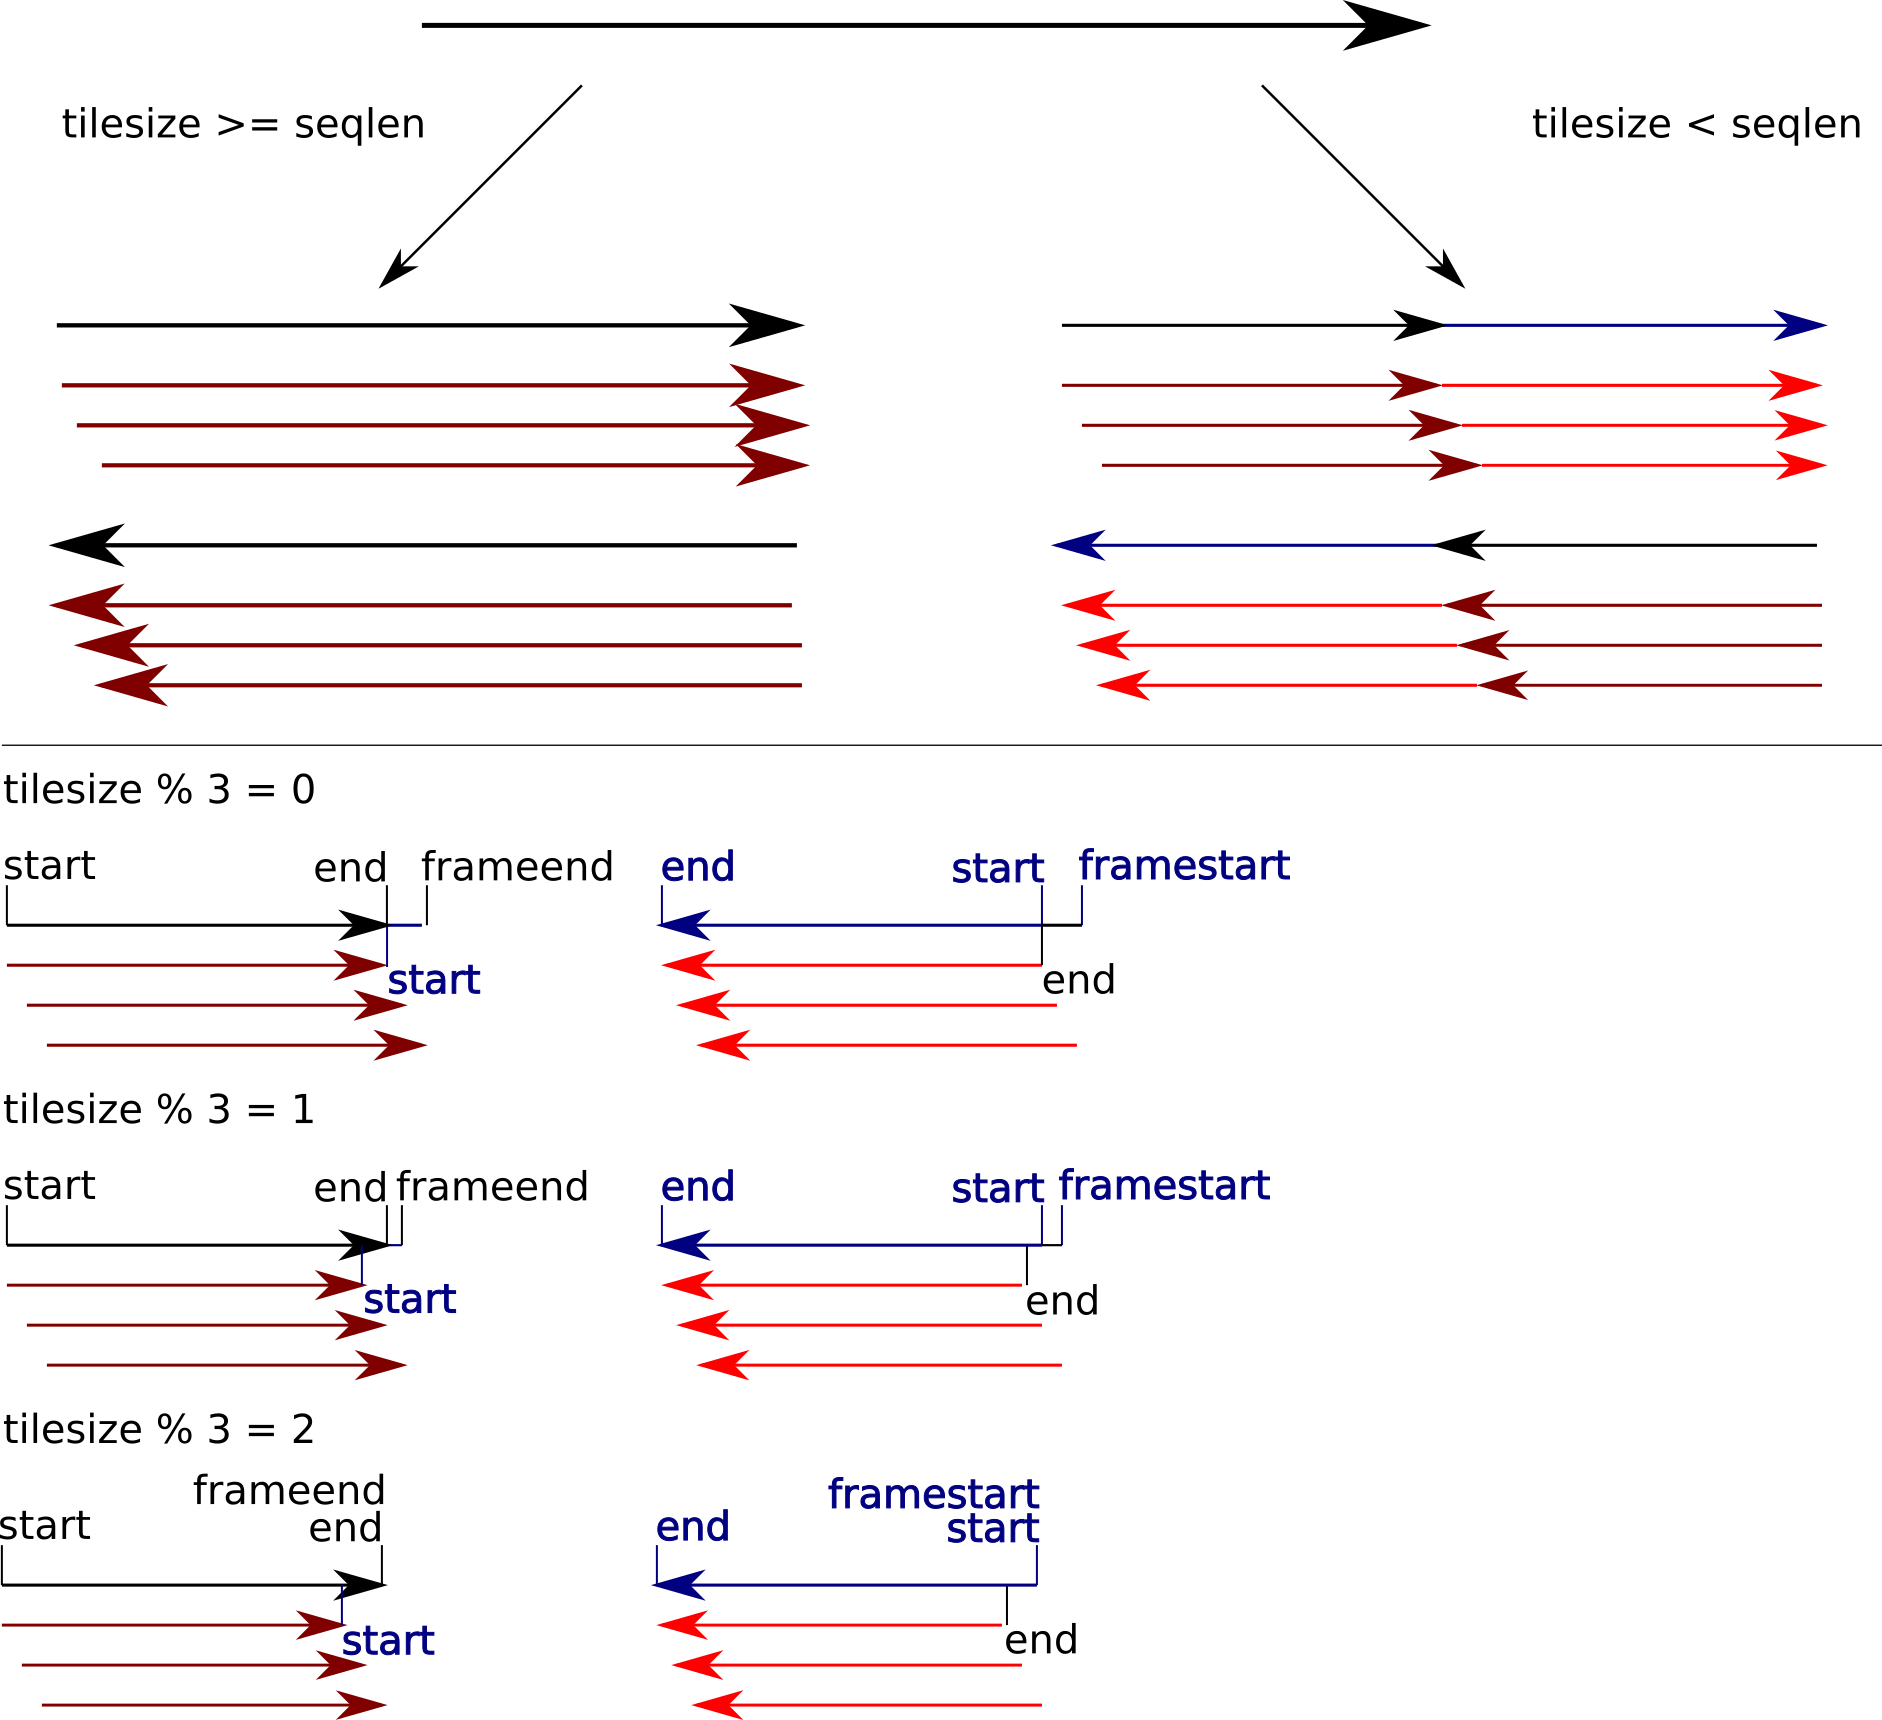

In [13]:
# manually handle reverse complements, assume that len(S) = x*3 + 2
def three_frame_translation(S):
    assert len(S) % 3 == 2, str(len(S))+" % 3 = "+str(len(S)%3)+"\n\n'"+str(S)+"'"
    T = []
    for f in range(3): # frame
        prot = ""
        for i in range(f, len(S)-3+1, 3):
            codon = S[i:i+3]
            if codon not in su.genetic_code: # real sequences may contain N's or softmasking or ambiguous bases
                prot += ' '                  # use null aa in that case
            else:
                prot += su.genetic_code[codon]
        T.append(prot)
    return T

def translateSequences(fwdSeq, pre_rcSeq, startPadding: bool):
    rcSeq = pre_rcSeq[::-1].translate(su.rctbl)
    if startPadding:
        rcSeq += '  ' # add padding
        
    fwdSeq += ' '*(2-(len(fwdSeq)%3)) # add padding such that len%3==2
    rcSeq = ' '*(2-(len(rcSeq)%3)) + rcSeq

    # some nucleotides are part of both neighboring tiles
    aa_seqs_fwd = three_frame_translation(fwdSeq)
    aa_seqs_rc  = three_frame_translation(rcSeq)
    aa_seqs_fwd.extend(aa_seqs_rc)
    return aa_seqs_fwd

# try using a generator to get genome batches
#def createBatch(genomes, ntiles, aa_tile_size: int):
def createBatch(ntiles, aa_tile_size: int, genomes = genomes):
    assert aa_tile_size >= 1, "aa_tile_size must be positive, non-zero (is: "+str(aa_tile_size)+")"
    tile_size = aa_tile_size * 3 # tile_size % 3 always 0
    N = len(genomes)
    state = [{'idx': 0, 'pos': 0, 'exhausted': (len(seqs) == 0)} for seqs in genomes]
    while not all(s['exhausted'] for s in state):
        X = np.zeros([ntiles, N, 6, aa_tile_size, su.aa_alphabet_size], dtype=np.float32)
        I = np.eye(su.aa_alphabet_size + 1) # for numpy-style one-hot encoding
        for t in range(ntiles):
            for i in range(N):
                if state[i]['exhausted']:
                    continue
                    
                sidx = state[i]['idx']
                slen = len(genomes[i][sidx])
                
                start = state[i]['pos']
                end = min(slen, start+tile_size)
                framestart = max(0, start-2)
                frameend = min(slen, end+2)
                assert start < end
                assert framestart < end
                
                # update state
                state[i]['pos'] = end
                if end == slen:
                    state[i]['idx'] += 1
                    state[i]['pos'] = 0
                    
                if state[i]['idx'] == len(genomes[i]):
                    state[i]['exhausted'] = True
                                
                # translate and add tiles
                sequence = genomes[i][sidx]
                if type(sequence) is not str:
                    sequence = str(sequence) # with tf, input are byte-strings and need to be converted back
                    
                aa_seqs = translateSequences(sequence[start:frameend], 
                                             sequence[framestart:end],
                                             (start ==0))
                for frame in range(6):
                    aa_seq = aa_seqs[frame]
                    assert len(aa_seq) <= aa_tile_size, str(len(aa_seq))+" != "+str(aa_tile_size)+", start, end, frameend, slen, tile, genome, frame: "+str((start, end, frameend, slen, t, i, frame))                        
                    x = su.to_idx(aa_seq, su.aa_idx)
                    num_aa = x.shape[0]
                    if (num_aa > 0):
                        one_hot = I[x] # here still aa_alphabet_size + 1 entries
                        # missing sequence will be represented by an all-zero vector
                        one_hot = one_hot[:,1:] 
                        X[t,i,frame,0:num_aa,:] = one_hot
                        
        yield X

---

_**Test Batch Generator**_

Retranslate and assemble all batches, compare to translations of genome sequences

_So far, fails for seedFinding data, no idea why_

In [14]:
# limit test to subset of sequences for large genomes
if max([sum([len(s) for s in genome]) for genome in genomes]) > 100000:
    testgenome = [[]]*len(genomes)
    while max([sum([len(s) for s in genome]) for genome in testgenome]) <= 100000:
        i = 0
        for g in range(len(genomes)):
            if i < len(genomes[g]):
                testgenome[g].append(genomes[g][i])
                
        i += 1
else:
    testgenome = [[s for s in genome] for genome in genomes]
    
# translate and concatenate whole testgenome aa sequences
genome_aa = [[""]*6 for _ in range(len(testgenome))]
for g in range(len(testgenome)):
    for i in range(len(testgenome[g])):
        aa_seqs = su.six_frame_translation(testgenome[g][i])
        for f in range(len(aa_seqs)):
            genome_aa[g][f] += aa_seqs[f].replace(' ', '')#.lstrip().rstrip()

# prepare generator testing
rev_aa_idx = dict((i,c) for i,c in enumerate(su.aa_alphabet))

def to_aa(onehot):
    assert onehot.shape[1] == 21, str(onehot.shape)
    aa_seq = ""
    for c in range(onehot.shape[0]):
        if np.max(onehot[c,:]) != 1:
            continue
        else:
            aa_idx = np.argmax(onehot[c,:])
            assert onehot[c, aa_idx] == 1, str(onehot[c,:])+", "+str(aa_idx)+", "+str(onehot[c,aa_idx])
            aa_idx += 1 # argmax + 1 as in translation, empty aa is cut out
            aa_seq += rev_aa_idx[aa_idx]
        
    return aa_seq#.lstrip().rstrip()

X_to_genome_aa = [[""]*6 for _ in range(len(testgenome))] # for each genome and each frame, concatenate translated aa seqs

# create generator
#Xgen = createBatch(testgenome, 5, tile_size)
Xgen = createBatch(5, tile_size, testgenome)

# iterate through generator, transforming and concatenating aa sequences
# X.shape [ntiles, N, 6, tile_size, su.aa_alphabet_size]
for X in tqdm(Xgen):
    for t in range(X.shape[0]):
        for g in range(X.shape[1]):
            for f in range(X.shape[2]):
                x_aa_seq = to_aa(X[t,g,f,:,:])
                if f < 3:
                    X_to_genome_aa[g][f] += x_aa_seq
                else:
                    #fr = 5 if f == 3 else f-1 # for some reason, frames rotate in generator compared to direct translation
                    #X_to_genome_aa[g][fr] = x_aa_seq + X_to_genome_aa[g][fr]
                    X_to_genome_aa[g][f] = x_aa_seq + X_to_genome_aa[g][f]
            
# compare aa sequences
assert np.all(genome_aa == X_to_genome_aa), str(genome_aa)+"\n\n!=\n\n"+str(X_to_genome_aa)

3it [00:03,  1.25s/it]


AssertionError: [['SQLSVPGAARDCHDLLCV*EGSQ*AYPS*TVS*VGRNRGPPENK*IGDYTKHDDTHSTCTSRIN*FVDPNTPTCAINQWTRLFELRDRAGSASCPKGL*LHTS*KPGMRV*CL*SFSCSHSYGAKKKLLALQCLLGHGWVTKHTRP*HVDCSTSSSSRFHLLTN*HF*LDLLRIARNICSHEGVVIIELQCLTSRLSRVSLDDLESR*QP*KISLKGSSEFGKHPPGYSLVAIPGYWIKEIQDWPDSVHTLAPDAAWTRSRGAV*GRCA*SPAVSNDTTRSDGQ*HAEIA*IVDTIARRGGL*RVSCGSMCTAAFQR*RHTPRDISA*ETPQFVIPILVRGSFTMRNFATYSY*IHDPLKVREDRVRQHR*DSIMSPDMTS*LCNVSAQVLSRG*RLGYISTTDQSGNTTYHRD*CRGTVLPIETSFDLYACSGILKCFFYK*ILWAVRPSSASPAVRWVEALNRDSVRVSCKMVRERRPVKHLSRTWYMS*LSSMASEQRKKIELITNRA*AKLVGAPNG*SEVPEKAWHGPSRASIAVENDIGPVYLPELRTPRPRVIGEPPRLGCLVLR*V*LPCAPAKFVKPILGTTIRQ*VHSGKGRTSDYRLQIMSSSLIRPASPNFLV*EPV*RCGGMWL*ECSAGKGHHLPKGQ*SWRFEPVLLSISRETLERWRISELRKSGLGCAVSCWLW*YLVVQMGVGLTRPFTIDTENSLCRRPRPT*TSVVQGCITAQPRAPHPNRTLYNC*PGS*PCPA*S*MRILAFFITLFVDNEFWRQMRKRGLTSD*PHTVFYARYLTVLYPTNTQLFEFQCNDPPDISLHGLRL*KRFPVTGDARGLPSLGLYYGPKAPLRPKLVVPRVALYLQLFVLAIRRCPQGRRPQSFVLALSLDLYSQ*IRHPGSSYPRHIELPRYFLC*RYV*SLASFRLTKVAN*TCYARLTFGIGVVV*RYPTRSRSVRVDSNALRPAAVYYT*RCNWTCTW*WG*PAKDVLAIPSSTPLFLDLSTIPSSHHPLERYRTSATEIWILFN*AVHRGDHSNAGLVVYVKYRRDSLPSYPGYIATSRRHCVMLTRANEALTLVYSRA*YGPPIVTRYGPRIGVR*PFTGSA*RCMVWGY*TDQKLATICMF*VRN*TAQGGVGHKRFSWRGIRPTPKCSRLPHC*WSPGSPRL*ERIVLNFYGLFPSPLIHPGPDET*PLTCALLHSRALENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKDELLQKRI**DQ*CKWTGLDVCAMPIVDIPVISRVSVWISSLNKREQQTQRWTHFQTSDGPWPARARPEPLTGHAIYIAKSTECVCIFRTSVNALKSHNGDRLTTPFMALWAVARGSFEG*GAFINTFQTILALCHHLCIMAGVSNNGNVQAFQVAQDTGP*GTRLTSESSY*LKRAILSLPAVGQLLPQYRDPE*TDLVMGD*CLSGHH*VYCVAGADGLWDRLRYITLFRAKRSPGSP*HVPLDA*LSLTRS*PARGIIRRG*RRVFFAGKPFKLVARSCRHGKIGELKMLQVVYHCMALPVTQTLICNHISSCPREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPERVRQRQTIH*GGSHAQSFGIRTERCTGLSDGVSGLQEYGGL*WVQHNNG*RPA*AYWEL*TSTWGFATFPIAF*SQSYYRGLICRPGAGG*LTFVGHAGG*HQPGARQESTYPFRLLIHGSRLSRKFRMSHLRALLTTGYAIAPPVAAES*TQCE*F*SHII*DNIAQGLRLARTAGTQVLPRI*FPLGCL*WKLLG*RRRGKDGIQVARCGRIVLQENSRLMQTR*RISGTSENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKDSTVSQLYCV*RQSRLISVTCRPTRLSLSYGEYSVII*TVGRKRDGGASFFVYDTIPPFKF*FPV*VRTFQDIGVTSEGESQRAIWWLCWGSGRRLRRPCCQLLDLILIVNDVK*ILRPRSWQLIRRLVDPSYLSYASSLQPGRMKLV*CCLLTVDTVDTASKLVLTD*CRRT*GQITASDQLLVAPYSSTLPPTVP*LPLYEV*FLSS*HKMSESLALLKSPWI*GLWIGK*VSFLVPLCSQV*KKRLTQATVSLQVRVVHLTREFHTVKIAPFDIGTYDPQVAMRVRCYIRYPRGAPVPENLKLLLNLKEANLKLLLNLKEENLKLLLNLKERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KKENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKETIDSSEAIRFLKSFPYVNDFIAYVDAKHRCPGVHTDHKGLFTNRSPCI*WYTLRSLPVKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KRVSRRQLHARLGACTRPA*VTTISPVSVAPRMHVTTLQSSNRSDRINAHSTTTLIPSPTQRGDRKS*FSSMARIQSTANKDFST*RRR*SDPLFL*KSVIFAQ*THWRRSAPGVARIAYGHQQVIV*DCYVNWSALSLRYRSYISSSACVGQRKSSVIAAQGGGAWFLRERSLRYCSNSAAGTYTRYGCHPRTLGLKYL*THERIKYLRKLKPAWHRVIPRYYAGTGLSAVRFENYRQCLNTEPPYGKSCMIARRAGGLALRRARPGISRDLPRLPCTASWKRGGCNSSLHLQAVCHCILIKNLWHAVDVTLYDRSFVWSRHLRYPARSTEACYTRNMQIASPRPTRKFVSIRISDQFCQRPRISGF*LYCCARALRSCGPSILRVKSLTD*YRLNLYIEYSCDLGYPTSS*FLILASR*ALGEAKELSRHNAVCLRMRSSASQWPVPTRRSQLEELNLSQSRVRLRYFP*KCSHSLSHNLLRTLGAVENKSGPDLASKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKERT*SYC*T*KRTR*LGNHLGDSACDESNAL*HWSRGL*A*PHI*VCNVV*LASALGLILQSEAVYIARRIKVPRNNLPMAVKRLRRPSNC*DDGRVSPPFLTLGRITQSVTTSVKHWTHRKAYT*QDPGPENHARTALSAGPIIIVSRSTVFNASHPYQI*F*C*RPIRCVKYFDYCVTI*STY**VRYCPVNYCPSAARPRKSAL*QLVRLQCRLRGRIQDVLPRYLNGLVHLGALQRNERPYRALRASP*QAVWNTRRPASRALTTKDSLLSASRSMDACYTHAKCDYS*PVRSIRRTV*IIVPVLHGLKFPKA*YPVKNPSRLSSCRTVCNCPTSHT**YDGCRSLLHVFAAGDIFP*TCDLWWSSQAS*VKLGRKLDSVPPQPSTPFAHQNHR*RDCH*LLKQLFKSRSPSYDALWLIASIV*HGI*HTALDDP*FWGFLLCVFAAYEASG*SLESAVRGWPRFLDPRERMCFSVKRATH*NPERLISKAFQREYTVFIYARTLYGDSSPEASLVVHGLYRLHSYSSLDPSVLPLRAIGRFSFLPWRFFNHET*HRKPADAGIAASNRNKLDVLEDNVIRLAHTVNSRQPDVLVKVSGSLCPRGAQRNAGSTNINYPRTKMQIPVR*PGC*LTTTAAP*EVPPEVQQ*VHFD*RFRMLTRYE*', 'HNCQYLVQPVTVMIFSAYEKVRNKLILRER*VKLDVTGVRRKTNKSAITQSTTTPIQHVHHALTDLSTQILQHVQ*TSGHVYSS*ETGPAQPHVQRDYNYTLHRNLECGCDACDLFHVATRMVRKKNCWHCNVFSDTAG*LSILDRSTWTAVLVPVLDSTY*LINTSN*ICYGSRETFVAMRVSLL*SFSV*LVVCPAYLLTT*SPGSSLRKSH*RGPQNLASILRGTPSLPYQATGSRRSKIGLTRFIPWPLMQLGLVLVERSRVDVLNRLRSRTILPDQMVNDMPRSRRSLTRSLAVEDYSELVADLCVLLPFNDDDTHQGTFPLRRLPNS*FPYWFAALLPCEISPRTHIESMTPLKFERTAYGSTDEIA*CRLI*RPSFATLVPKSSRGDNA*VTSPRQISPVIPRTTEISVGVPYCRLKHLSIYMLAAGFLNVFSINEFSGL*DLVQHRQQ*GG*KH*TEIQCEFHAKWLENAGLSSIYHGPGICLN*APWPRNRERRLSLLRIGHKQN**EPPMVSRKCQKRPGMGQAEQALRLKTTLVRYICQNSVRRVPA**ANRRV*AV*SYAKCSYRARRRSL*SQYSGQQSVSRCIPVRAEQAITACRLCQVP*SDPHHQIS*SKNQCDAVGGCGYKSALQVRDITSPKGNKAGALSRFCCRFLERHSKGGELVSCVNQAWAVLLVVGCGST*LFKWGSG*RDHSQ*TLRTRYVVDQDQRERRLSKAVSRHNPVRRTPTVPFIIASLGPNPVQHEAECGS*PSSLRYSWITSSGAK*ENEG*LPINRIPCSTPGI*QYCIQPIRNCLNFSVTTHQTYLYTV*GCESVSP*RVMRGVCRP*DYITGRRLPCGLSSLCRG*PCICNYLC*QFVVVLKDAVHKASYWPSASICIVNRYVIQDLPIHVTSSCHDTSFARGTYNRWRRSA*RRSLIKRATPGLPSELVSWSKDTLPAVDRLGSILTPYALQLSITPSGVIGPAPGDGGSRRRTFWPSPPPHRCF*T*VRFPHLTTR*KDTGLPQPRFGSFLTEQYIEVTIATPG*LFT*STGGTHSLVIQATLPRPEDTALCLLALTKR*R*FIRGRNMAHLL*PATGHV*VSANRSRDPHKGVWYGAIRLTRNSLPYVCFRYAIELLREV*GTNVFLGGVYGLRQNVRGCPIADGPLDHPDCKSA*SLTFTDYFPLLSSTLDQTRLNR*PVRSYTQEH*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KTNSCRSEYNKTNNVSGQD*MFVQCPSWIFL*YQGFLYGSVHSTRENSRPNVGPIFKPQMGHGPLVRVQSP*QGTLFILRKAPNVFVSSELP*TP*RVTTVIG*PLHSWRSGQLPEVLLRGRGPL*TRFRRSWPFVIIFALWRASRITAMCRLFKWRRILVRKVRA*HQKVVID*SEQFCLYQLSDSSYRSIEILSRPIW*WVTNAFLGTIECTASQAQMDYGIDCDI*HYSEPKGPRGRHNTSR*TPSYH*LDHSPPAGLYDEADVECSLQGNRSSWWRDHVGMGRSGS*RCCR*CIIAWRFR*HRHSFAIISPRARENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKEFGSAKLSIRGEATRKVLG*EPRGVQACQME*AASKSMVGYNGYNTTMVRGLLRPIGSYRHQRGGLPRFQSPSKVNPITEV*YVDLVQVDN*PSLATREANTNQVRGKNPPTRSAY*STGRG*AVSFVCLTCGRC*QRDMRSHHLWRPSLKRNVSNFDRTLYRTTLHRGSA*RGPPGRKFSPESDFP*DVSDGSFSDNEGEARTGSKLLAVGGSFSRRIAG*CKQGRGLAELQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KIPQ*VSFTVFSVSRD*YPLHVGPHDYLLVTANTA**SRPSGGSEMEAPVFLSMTQSRLLNSSSRSRYAPFKI*V*PLRVNLSAQYGGSVGAAGAAFGDLAASC*I*Y***MMSSESSDRGAGN**DVL*THHTSVMPVLYSRVV*S*FSAASLQWTPLILPPSLS*LTDAVEREDK*RRQTNC**LHIHQHCLPPSRNFRSMRFNSSQVNTKCRRA*RFSSRPGYRDCGSANKSHFLSHYVRKFKKRD*RRLPCRSKCAWFTSRGSFTQLRSHHSTLVHTIPRSLCASDVTSDTPGARRCQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPERKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KRR*THQRPYGS*NPSLM*MTSLRT*TRNTDVQVYILIIRDSLLIGVLAYDGIRSDLFRSREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPEREFRAVSSTRDSELVLARPR*PLYPR*VLLQECMLLPFNPATAVTGSMPTPLPP*YRPPLSGETERVDFLLWQEFSLPQIKTFPHSGAGNLTLFSSKKA*SLRSERTGGGPPPA*HA*PMAINK*SCKTAT*TGVLSRCGIEVIYRALHVLGKERVQ**RHKGEGHGFFVSDLSVIAPTLLPGLTLGTVATHALLASSISRHMSG*NTSEN*SPHGIE*FLDTMPAPV*AP*GSRTTDNVSILNRPMASLV*LHAEPVGWPLGGHALGFPGIYLAFRVLLHGKEGAVIRPCIFRQYAIVS**KTYGTP*M*HYMTEVSSGAVILGTLLAVRKPATHGICRLRRPAPRVNLYP*GFPINFAKDHELAAFSCTVVPEPYVHADRRY*G*SL*QTDTA*TYI*NTAAT*GIPQVHSS*YSQAVKL*EKPRN*VAITPFVSECVLPRRSGPCRRGEASWKS*TSVSQEFD*DIFRRSARTLYRITCYGR*GRWRTKVVQI*HLREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KREPEATAKPERGPGSWVTI*VTPPATNRMHCDIGRAGCRLDHTFESAM*YN*LLRWA*FCSRKRST*HAELKYLGITSPWRSSDSDDHQTAETMAECPPHSSPWVE*LNQ*LHPLSIGRTVRLTPSRIQGRKITHGPPSARARSSSSVGLRYSTRAIPIKFSSSVDAPYGVLNTLTIALLYSLHTNELDTVR*IIAHQPQDLGNLRCDSWFDCSADSEAESKMFFQGI*TVLYTWEHCSVTSDLTELCELHHSRQCGTQEDQPHAH*LRRIVYYLPLGQWMPATRTPSATIASLSGASGAQFESLCQCYMA*NFRKHSTQ*KTQVG*AHAGQCATVLPVIRNNTMDAGRFCTYSQQVIFSPEPATYGGHLKPRESSWGGSWILYLRNQVRHSRTRITDKGIAIDFSNSSLSQGAPLTTHSG**PPSSNTEFNIPLWMTRSFGVSYCAYSLLTKRPANP*RVR*EVGHVFWTRASVCVSP*SGPHIKIQSA*SLRPSNENIRCLYMLVLYTGIPLQKLV*LCTDFIGSIHTRA*THQFYPYAQSVASVFFLGVFLITRRSIVSPPTQVSLLPIGISSTFWKIM*SGSRIRLTQGNPMF**RSAVHCVRAALNGTPAPLILIIRVRRCRYQCANPDVN*LPQRHPRKYLQRYNSRYTLTSASEC*LGMNK', 'TIVSTWCSP*LS*SSLRMRRFAISLSFVNGELSWT*QGSAGKQINRRLHKARRHPFNMYITH*LICRPKYSNMCNKPVDTFIRVKRPGRLSLMSKGIIITHFIETWNAGVMPVIFFM*PLVWCEKKIAGIAMSSRTRLGN*AY*TVARGLQY*FQF*IPLTD*LTLLTRFATDREKHL*P*GCRYYRASVFD*SFVPRIS*RPRVQVAALENLTKGVLRIWQASSGVLPRCHTRLLDQGDPRLA*LGSYPGP*CSLDSFSWSGLGSMCLIACGLERYYPIRWSMTCRDRVDR*HDRSPWRIIAS*LRIYVYCCLSTMTTHTKGHFRLGDSPIRNSHTGSRLFYHAKFRHVLILNP*PP*SSRGPRTAAPMR*HNVA*YDVLALQR*CPSPLAGITPRLHLHDRSVR*YHVPQRLV*GYRIAD*NIFRSICLQRDS*MFFL*MNSLGCET*FSIASSEVGRSTKQRFSASFMQNG*RTQACQAFITDLVYVLTELHGLGTEKED*AYYE*GISKTSRSPQWLVGSARKGLAWAKQSKHCG*KRHWSGISARTPYAASPRDRRTAAFRLFSLTLSVVTVRAGEVCEANTRDNNPSVGAFR*GPNKRLPPADYVKFPDQTRITKFLSLRTSVTLWGDVVIRVLCR*GTSPPQRAIKLAL*AGFVVDF*RDTRKVEN**AA*IRLGLCC*LLVVVVLSCSNGGRVDETIHNRH*ELVMS*TKTNVNVGCPRLYHGTTPCAAPQPYPL*LLAWVLTLSSMKLNADPSLLHYVIRG*RVLAPNEKTRANFRLTAYRVLRPVFNSTVSNQYAIV*ISV*RPTRHIFTRSKAVKAFPRDG*CAGSAVPRIILRAEGSLAA*ARCAEGSLVSAIICVSNSSLSSRTPSTKLRTGPQPRSV*SIDTSSRIFLSTSHRAATILPLLEVRIIVGVVPPNEGR*LNVLRPAYLRNWCRGLKIPYPQ*IG*GRF*RPTPCSCLLHLAV*LDLHLVMGVAGEGRSGHPLLHTVVSRLKYDSLISPPVRKIQDFRNRDLDPF*LSSTSR*P*QRRASCLREVPEGLTP*LSRLHCHVQKTLRYAYSR*RSANVSLFEGVIWPTYCNPLRATYRCPLTVHGIRIKVYGMGLLD*PETRYHMYVLGTQLNCSGRCRAQTFFLAGYTAYAKMFAVAPLLMVPWITPIVRAHSP*LLRTISLSSHPPWTRRDLTVDLCALTLKSTREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPERRTPAEANIIRPIM*VDRIRCLCNAHRGYSCDIKGFCMDQFTQQERTADPTLDPFSNLRWAMARSCASRAPNRARYLYCEKHRMCLYLPNFRKRPKESQR*SADHSIHGALGSCQRFF*GVGGLYKHVSDDLGPLSSSLHYGGRLE*RQCAGFSSGAGYWSVRYALDIRK*LLTEASNFVFTSCRTALTAV*RS*VDRFGDG*LMPFWAPLSVLRRRRRWIMGSIAIYNTIPSQKVPGVAITRPARRLVIIDSIIARPRDYTTRLTSSVLCRETVQAGGEIMSAWEDRGAKDVAGSVSLHGASGDTDTHLQSYLLVPERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KSSAAPNYPLGGKPRAKFWDKNREVYRPVRWSKRPPRVWWVIMGTTQQWLEACLGLLGAIDINVGVCHVSNRLLKSILLQRFNM*TWCRWITDLRWPRGRLTPTRCAARIHLPVPPIDPRVAAEP*VSYVSPAGAVDNGICDRTTCGGRVLNAM*VILIAHYIGQHCTGAPPSEDRRDASSPQNLISPRMSLMEASRITKARQGRDPSCSLWADRSPGE*PVNANKVED*RNFREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPERFHSKSALLCLASVEIDIRYMSAHTIIS*LRRIQRNNLDRREEARWRRQFFCL*HNPAF*ILVPGLGTHLSRYRCDL*G*ISARNMVALLGQRAPPSATLLPVVRSNIDSE*CQVNPPTEELATDKTSCRPIIPQLCQFFTAGSYEASLVLPPYSGHR*YCLQACLN*LMPSNVRTNNGVRPIASSSIFINTASHRPVTSAL*GLIPLKLTQNVGEPSASQVALDIGTVDRQISLISCPTMFASLKKEIDAGYRVAPSARGSPHEGVSHS*DRTIRHWYIRSPGRYARPMLHPIPQGRAGAREPEATAEPERSEPEATAEPERREPEATAEPERENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKEREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPERDDRLIRGHTVLKILPLCE*LHCVRRRETPMSRCTY*S*GTLY**ESLHMMVYAQISSGQENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKESFAPSAPRETRSLYSPGLGNHYIPGECCSKNACYYPSIQQPQ*PDQCPLHYHLNTVPHSAGRQKELIFFYGKNSVYRK*RLFHIAAQVI*PSFPLKKRNLCAVNALEEVRPRRSTHSLWPSTSNRVRLLRKLECSLVAV*KLYIELCMCWAKKEFSDSGTRGRGMVSS*AISPLLLQLCCRDLHSVRLPPTHSWPQVSLDT*ADKIPPKTEARMASSNSSILCRHRFERRKVRELPTMSQY*TALWQVLYDCTPSRWAGP*AGTPWDFQGFTSPSVYCFMEKRGL*FVLASSGSMPLYLDKKPMARRRCDII*QKFRLEPSS*VPCSQYGSLLHTEYADCVAPPHA*ICIHKDFRSILPKTTN*RLLAVLLCQSLTFMRTVDTEGEVFNRLIPPEPIYRIQLRPRVSHKFIVLNTRKPLSFRRSQGTKSP*RRLSQNAFFRVAVARADEAKPAGRVKPQSVKSSIKIFSVEVLALSIA*LATDVRGGGEQKWSRFSI*ENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPERENLKLLLNLKEDQVVG*PSR*LRLRRIECTVTLVARAVGLTTHLSLQCSIISFCAGPNSAVGSGLHSTPN*ST*E*PPHGGQATPTTIKLLRRWPSVPPIPHPGSNNSISNYIR*ALDAP*GLHLAGSRAGKSRTDRPQRGPDHHRQ*VYGIQREPSLSNLVLVLTPHTVC*IL*LLRYYIVYILMS*ILSGKLLPISRKTSEICAVTAGSIAVQTPRPNPRCSSKVSERSCTPGSTAA*RATLPSSASFTIAGSVEHKKTSLTRIDYEG*FIICL*VNGCLLHARQVRL*LACPEHPAHSLNHCASVTWLEISESIVPSKKPKSAKLMPDSVQLSYQSYVIIRWMQVAFARIRSR*YFPLNLRPMVVISSLVSQAGEEVGFCTSATKYAIRAPESPIKGLPLTSQTAL*VKEPLLRRTLVDSLHRLTRNLTYRSG*PVVLGFLTVRIRCLRSVRLIPRECGKRLATFFGPARAYVFLRKAGHTLKSRAPDL*GLPTRIYGVYICSYSIRGFLSRS*FSCARTL*APFILEPRPISFTPTRNRSLQFSSLAFF*SRDVAS*ARRRRYRCFQSE*ARRSGR*CDPARAYG*LKATRCFSKGQRFTVSARRSTERRLH*Y*LSAYEDADTSALTRMLTDYHSGTLGSTSRGTTVGTL*LALPNVD*V*I', 'FIHT*STFGSASQSVPTVVPLEVLPRVPLW*SVNIRVSALVSASSYADN*Y*WSRRSVERRADTVNR*PLLKHRVALS*PYARAGSHYLPERRAYSDWKQRYLRRRAYDATSRD*KNAKEEN*SDRLRVGVKLMGLGSSMNGAYKVRAQLN*LLERNPRIEYEHI*TPYILVGRP*RSGALDFNVWPALRRNTYARAGPKNVANLLPHSLGISRTLRKQRIRTVRNPKTTGHPERYVKFRVRRWRLSTRVRRKRGSLT*RAV*EVNGNPFIGDSGARMAYLVAEVQNPTSSPA*LTRLEMTTIGRRFRGKYHLLRIRAKATCIHRIITYDW*DSCTLSGMSLADLGFLLGTMLSEISSHVTLAQ*FKLCAGCSGQASYSRTWRACSRHPLT*RQIINYPS*SMRVRLVFLCSTLPAMVKLAELGKVARYAAVLPGVQDRSDTLEEHLGFGLGVCTAIEPAVTAQISEVLRLMGNNLPDSI*LISM*TI**RNSQSI*HTVWGVNTRTKFDRDGSR*IP*TY*R**SGPR*GRSVRDFPALDPARCKPYGASNA*RM*LLIELFDPG*GMGGTLGHRLSSLMVVGVA*PPWGGYS*VL*FGVLCRPLPTAELGPAQKLIILHCRLKCVVKPTARATNVTVHSIRRRRSHLDGYPTTWSSFRFSSSFRFSLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFS*MLNLDHFCSPPPLTSVASYAIESASTSTENILIELLTD*GLTLPAGFASSARATATRKNAF*DKRRYGDLVPWLLLKLNGLRVLRTMNLWDTLGRSCILYIGSGGISLLKTSPSVSTVRMNVRLWHNSTAKSR*FVVFGKIDRKSLWIQIYAWGGATQSAYSVCSRLPYCEQGT*DDGSRRNFCHIMSHLRRAIGFLSRYNGILPEDARTNYSPLFSMKQYTEGEVNPWKSQGVPA*GPAHRLGVQSYKTCHRAVQY*DIVGSSRTLRRSNRCRHSIEELLDAMRASVFGGILSAHVSRDT*GQECVGGNRTECKSRQQSWSNNGEIAHEETMPLPLVPLSLNSFFAQHMQSSIYNFYTATREHSSLRSSLTRLLVDGHRLCVLRRGRTSSSAFTAQRLRFFRGKEGQITCAAMWKSLYLR*TEFLP*KKINSFCLPAEWGTVLRW*WSGH*SGHCGCWIEG**HAFLEQHSPGI*WLPRPGEYKLRVSRGADGAKLSFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFS*PEEI*AYTIICKDSY**RVPYDQYVHLDIGVSRLRTQ*SHSHKGRILRTVWPLMSLSSLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLSFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLAPARPWGIGCNIGRA*RPGDRMYQCRMVRS*LCETPS*GEPRALGATR*PASISFFKLANIVGQEMRLICRSTVPISRAT*EALGSPTFCVNLRGIKPHRAEVTGRWEAVLMNMELLAIGLTPLFVLTFDGISQLRQAWRQYQRCPL*GGSTKLASYDPAVKNWHN*GMMGLQDVLSVASSSVGGFT*HHSLSILDLTTGSKVAEGGARCPNRATILRAEIHPQRSHLYLERCVPRPGTRI*KAGLCHRQKNWRLHLASSRRSRLLRCIRRN*EIIVWADM*RISISTDAKHSKADLLWNLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLKFR*SSTLFALTGYSPGERSAHSEQLGSRPCLAFVIREASIRDILGEIRFWGELASRRSSLGGAPVQCCPI*CAIKITHIAFKTRPPQVVRSHIPLSTAPAGETYETYGSAATRGSIGGTGRWILAAHLVGVSLPRGQRRSVIHLHQVYILNLCNRIDFRRRLETWQTPTLMSIAPNRPKQASNHCCVVPIITHHTLGGRLLHLTGLYTSRFLSQNFARGFPPNG*FGAAELFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVLSGTRRYDCK*VSVSPEAPCNDTLPATSLAPRSSHADMISPPA*TVSLQRTLDVSLVV*SRGRAMIESMITRRLAGRVMATPGTFWLGIVLYIAIDPIIHLRLRRSTLNGAQKGISHPSPNRSTQDLYTAVRAVRQLVKTKLLASVNNYFLMSSAYLTDQYPAPLEKPAHCRYSRRPP*CKDDDKGPRSSETCL*RPPTPQKNLWQLPRAP*MEWSADHRCDSLGRLRKFGRYKHIRCFSQYK*RALLGALDAHERAMAHLRFENGSNVGSAVLSC*VN*SIQKPLISQEYPRWALHKHLILSTYIIGLIIFASAGVRLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLVLLSVRAHRSTVKSRLVQGG*EEREIVRKS*GLCALTIGVIQGTISNGATANILA*AVYPAKKNVCALHLPEQFNCVPKTYIW*RVSGQSNSPIPYTFMRIP*TVSGHLYVARSGLQ*VGHITPSNKLTLALR*RE*A*RSVFWTWQCSLDN*GVSPSGTSRKQLARRCYGHLDVLLS*KGSKSRLRKSCIFLTGGEMRESYLSLETTVWRRGWPERPSPATPITRCRSNYTARCNRQLQGVGR*NRP*PIYCG*GIFRPRHQFRR*AGRSTFN*RPSLGGTTPTIIRTSSKGSIVAARCDVDRKILDDVSIDYTDRG*GPVRSFVDGVLEDNDELLTQIIADTRLPSAQRA*AAREPSARNIILGTADPAHHPSRGNAFTALDRVKICLVGRYTEIQTIAYWLDTVLLNTGRRTRYAVNRKLALVFSFGARTRYPRIT**RRLGSAFSFMLDRVRTQASNYKGYGWGAAHGVVP*YSLGQPTFTLVLVYDITSSQCLL*MVSSTRPPFEQLSTTTTNN*QHSPSLIYAAH*FSTFRVSL*KSTTKPAQSASFIALWGGDVPYLQSTLITTSPHSVTLVLRLRNLVMRV*SGNLT*SAGGNRLFGPYRNAPTDGLLSRVLASQTSPARTVTTLSVRLNSLNAAVRLSRGDAAYGVLADIPDQCRFQPQCLLCLAHARPFLALPTNHWGLLLVLLMPYS**AQSSFSVPRPWSSVKTYTRSVINA*QACVL*PFCMKLALNLCLVLLPTSLLAMLN*VSQPREFIYRKNI*ESRCKHIDRKMFQSAIRYPYTNLCGTWYYRTDLSWRCNLGVIPARGLGH*RCKARTSYQATLCYLIGAAVRGPLEL*GGHGFNMSTWRNFAW*KSREPVWELRIGESPKRKCPLVCVVIVERQQYT*IRN*LAIILHGERSCQRSTRSRHVIDHLIG*YRSRPQAIKHIDPRPLHENESKLHQGPGYEPSQANLGSP*SSSLVWQRGSTPEDACQILRTPLVRFSKAATWTLGRQEIRGTND*SNTEAL**RHPHGYKCFSRSVANLVRSVN*SVSGI*NWN*YCSPRATV*YA*LPSRVREDIAMPAIFFSHHTSGYMKKITGITPAFQVSMKCVIIIPLDMRLSRPGLLTRINVSTGLLHMLEYLGRQIS*CVMYMLNGCRRALCNRRFICFPADPCYVQLNSPFTKDKLIANLLIRREDHDSHGLHQVLTIV', 'LFIPSQHSEALVKVYLLLYLWRYFLGCRCGSQLTSGLAHWYLHLRTRIINISGAGVPLSAARTQ*TADLY*NIGLP*VNRMREPDHIIFQNVELIPIGSSDTCVGGLTMLRLVIKKTPRKKTEATDCA*G*N*WV*ARV*MEPIKSVHN*TSFWRGIPV*STSIYKHRIFSLEGLRDQALWILMCGPLYGETHTLARVQKTWPTSYRTL*GLAGRFVSSEYAQ*ETPKLRVIQSGMLNSVLDDGGYQPECVVRGAP*LKELFEKSMAIPLSVILVREWRTWLRRYRIQLPPQLDSRGLR*PP*VAGSGENITCCEYVQKRPASIVLLRMTGRTVAHCPA*A*PTWVFYWVLCFRKFQAM*HWHNDSNCAPDAPDRLAIVALGVRVAGIH*PRGR**TILRSQCA*GWSSCVPHCLLW*SSQSSVRSLVTLQCSQVYKTVQIPWKNILDSASESALQSNQLSQRRFPRSCG*WAIIYRTVSNSLVCRLYSNAIVKVFNTPYGASTLELNLIGMARVEYRRPTDDDDRARAEGGPCVIFRPWILLGVSLTVRPMLNGCSY*LSYSTQGEEWGGHSAIVSAV*WSSESLDRHGEVIPRYFNSACYVDRFRLQN*AQRRS*LYYIADSNVWSSLQPARPMSQCIRFVAGGVT*MVTQLPGPLSGLAVASGSLFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVLFLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLRC*IWTTFVLHRP*RP*QVMR*RVRALLRKIS*SNS*LTEV*LFQLASPRRHGPLRRGRTHSETNGVMAT*FLGFS*SLTACEY*EL*TCGIP*VAAVFYI*VQAVSVC*RLHPQYRRSA*T*GSGTTVQLKAANSWSLAKLIGNPYGYKFTRGAGRRNLHIPCVAGFRTASRVPKMTAPDETSVI*CHIYGVP*VFYQDTMAYCLKMQGRITAPSFP*SSTRKAR*IPGNPRACPPKGQPTGSACNHTRLAIGRFSIETLSVVLEPYGAQTGAGIVSRNYSMPCGLQFSEVFYPLMCLEILEAKSAWVATVPSVSPGSRVGAITERSLTKKPCPSPLCRYH*TLSLPNTCRARYITSIPQRESTPVYVAVLHDYLLMAIGYACYAGGGPPPVRSLRKDYAFLEEKRVRLPAPLCGKVFICGRLNSCHRRKSTLSVSPLSGGRY*GGSGVGIDPVTAVAGLKGSNMHSWSNTHRGYSGYLGRASTSSESRVELTARNSLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLDRKRSERIPSYARTPISKESLMISMYTWTSVFRVYVRNEVIHIREGF*EPYGL**VYRLFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVLWHRRAPGVSDVTSDAHSDLGIVCTNVEWCDLNCVKLPREVNHAHLERHGSLRQSLFLNLRT*WDKK*DLFADPQSLYPGRLEKR*ALRHFVLT*EELNLIERKLRDGGRQC**IWSY*QLV*RRYLSSRSTASVS*DKLGGSINGVHCKEAALN*LHTTRL*RTGITEV*WVYKTSYQLPAPRSEDSLDIIHYQY*I*QLAARSPKAAPAAPTEPPYCALRFTLRGHTYILKGAYLDRELEFKRRDCVIDKKTGASISLPPDGLDYYAVFAVTKR*SCGPTCNGYQSRLTLNTVKLTYCGIFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVL*SSANPLPCLH*PAILLENDPPTASNLDPVLASPSLSEKLPSETS*GKSDSGENLRPGGPR*AEPLCNVVLYNVRSKLLTLRLRLGRHRWCDRISRCQQRPQVRHTKLTAQPRPVDQ*AERVGGFLPRTWLVLASRVANEGQLSTCTRSTY*TSVIGLTLEGDWKRGKPPR*CL*LPIGLSRPLTIVVLYPL*PTILLEAAYSI*QACTPLGSYPKTLRVASPLMDSLALPNSFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFSRARGDMIANECLCHRKRHAMIHYLQHL*LPDLPMPT*SRHQLERFPCKEHSTSASSYNPAGGL*SSQ**LGV*RDVLWRPRGPFGSE*CYISQSIP*SICACDAVHSMVPRKALVTHHQIGLLRISILR*ELSDSW*RQNCSLQSITTF*CQARTLRTSILRHLKSLHIAVIRDARHNAKMMTKGQDRLKRVYKGPLPLKRTSGNCPERHEWSGQPITVVTL*GVYGSSEDTNTFGAFRNINSVPC*GLWTRTSGPWPI*GLKMGPTLGLLFSLVE*TDPYRNP*YHRNIHDGHCTNI*SCPLTLLVLLYSLLQEFVFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVL*CS*V*ERTGQRLSLVWSRVDERRGK*SVKVKDYALLQSG*SRGPSAMGQPRTFWRRPYTPPRKTFVPYTSLSSSIAYLKHTYGSEFLVSLIAPYHTPLCGSRERLADTYTWPVAGYNRWAILRPRIN*R*RFVSASKHNAVSSGRGNVAWITRE*VPPVLHVNN*PGVAMVTSMYCSVKKDPNLGCGSPVSF*RVVR*GNRT*V*KQRCGGGDGQNVLRRLPPSPGAGPITPLGVIDSCRA*GVRIDPNRSTAGRVSLDHDTNSEGKPGVARLISDLR*AERRQRLYVPLAKEVSWQLDVTWIGRSWMTYLLTIQIEAEGQYEALWTASLRTTTNC*HK*LQIQGYPRHNELRPQGSLRPVI*S*GRQTPRITRHGETLSQP*TV*RYVWWVVTLKFKQLRIGWIQYC*IPGVEHGMRLIGS*PSFSHLAPELVIHE*RNEEG*DPHSASCWTGLGPRLAIIKGTVGVRRTGLCRDTALDNRRSRWSWSTT*RVLSVYCEWSRQPDPHLNN*VLPQPTTNSTAQA*FTQLTNSPPFECLSRNRQQNRLKAPALLPFGEVMSLTCRALL*PHPPTASHWFLD*EIW*CGSDQGT*HNLQAVIACSALTGMHLLTDCCPEYWLHKLRRRAR*LHLA*D*TA*TRRFAYHAGTRRTEFWQIYRTNVVFNRNACSAWPMPGLFWHFRLTIGGSY*FCLCPIRNKLNLLSLFRGHGAQLRHIPGP**MLDRPAFSNHFA*NSH*ISV*CFYPPHCWRC*TRSHSPENSFIEKTFKNPAASI*IERCFNRQYGTPTLISVVRGITGLICRGDVT*ALSPREDLGTNVAKLGRHIRRHYAISSVLPYAVLSNFKGVMDSI*VRGEISHGKRAANQYGNYELGSLLSGNVPWCVSSSLKGSSTHRSATNSL*SSTASDRVNDLRDLGMSLTI*SGSIVRDRRRLSTSTLDRSTRTSPSCIRGQGMNRVRPILDLLDPVAWYGNEGVPRRMLAKF*GPL**DFLRLLPGL*VVKRYAGQTTSQTLKLYNNDTLMATNVSRDP*QI*LEVLISQ*VESRTGTSTAVHVLRSSMLSYPAVSEKTLQCQQFFFRTIRVAT*KRSQASHPHSRFL*SV*L*SLWT*G*AGPVS*LE*TCPLVYCTCWSIWVDKSVNA*CTC*MGVVVLCVIADLFVFRRTPVTSNLTHRSRRISLLRTFSYAEKIMTVTGCTRY*QL*', 'YSYLVNIRKR*SKCTYCCTSGGTS*GAAVVVS*HPG*RTGICIFVRG*LILVEPAFR*APRGHSEPLTFTKTSGCLELTVCASRITLSSRTSSLFRLEAAIPASAGLRCYVS*LKKRQGRKLKRPIARRGKTDGSRLEYEWSL*SPCTTKLASGEESPYRVRAYINTVYSRWKALEIRRSGF*CVARFTEKHIRSRGSKKRGQPLTALSRD*PDAS*AANTHSKKPQNYGSSRAVC*IPC*TMEAINQSAS*EGLLDLKSCLRSQWQSLYR*FWCANGVLGCGGTESNFLPSLTHEA*DDHHRSQVQGKISPAANTCKSDLHPSYYYV*LVGQLHTVRHELSRLGFFTGYYAFGNFKPCNTGTMIQTVRRMLRTG*L*SHLACV*QASIDLEADNKLSFVVNAREAGLLVFHTACYGEARRAR*GRSLRCSAPRCTRPFRYLGRTSWIRPRSLHCNRTSCHSADFRGLAADGQ*FTGQYLTH*YVDYIVTQ*SKYLTHRMGRQH*N*I**GWLALNTVDLLTMMIGPALRAVRA*FSGPGSC*V*ALRCVQCLTDVVTD*VIRPRVRNGGDTRPSSQQFDGRRSRLTAMGRLFLGTLIRRAM*TASDCRIRPSAEANYTTLQTQMCGQAYSPRDQCHSAFDSSQAESPRWLPNYLVLFQV*Q*LQVLSFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFSFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVLLDAKSGPLLFSTAPNVRSKLCDRECEHFYGKYLNRTLD*LRFNSSSWLRLVGTGHCDAEERILRQTALWRLSSLASPKA*RLASIKNYELVGYPRSQLYSIYRFRRYQSVKDFTLSIDGPHERKALAQQYS*KPLIRGLWQN*SEILMDTNLRVGRGDAICIFRV*QASVLRAGYLR*RLQTKLLSYNVTSTACHRFFIKIQWHTA*RCKDELQPPLFHEAVHGRRGKSLEIPGRARLRASPPARRAIIQDLP*GGSVLRHCR*FSNLTALKPVPA*YRGITRCHAGFSFRRYFIRSCV*RYLRPRVRGWQPYRV*VPAAELEQ*RRDRSRRNHAPPPCAAITELFLCPTHAELDI*LLYRNERALQFT*QSYTITC*WP*AMRATPGADLLQCVHCAKITLF*RKRGSDYLRRYVEKSLFAVD*ILAIEENQLFLSPR*VGDGIKVVVEWALIRSLRLLD*RVVTCILGATLTGDIVVT*AGRVQAPSLAWS*RRETLFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVLLTGRDLSVYHHMQGLLLVKSPL*SVCTPGHRCFASTYAMKSFT*GKDFKNRMASDESIVSFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSFFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVLSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFSGTGAPLGYRM*HRTRIATWGSYVPMSNGAILTV*NSLVR*TTRTWSDTVACVNLFF*TCEHSGTRNETYLPIHSPYIQGDLRSARLSDILC*LERN*TS*SGSYGTVGGSVDEYGATSNWSDAVICPHVRRHQSVKTSLEAVSTVSTVRRQH*TSFIRPGCKELA*LRYDGSTRRLISCQLLGRRIHLTSFTINIRSNNWQQGRRRRRPLPQQSHHIAR*DSPSEVTPIS*KVRT*TGN*NLKGGIVS*TKKLAPPSRFLPTV*IITLYSP*LRDNRVGRHVTDINLD*R*TQ*S*LTVESFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFSEVPLILYLVCINRLFSWRTIRPQRATWIPSLPRLRYPRSFHQRHPRGNQILGRTCVPAVLARRSPCAMLSYIMCDQNYSHCV*DSAATGGAIAYPVVNSARR*DIRNLRLSRDPWINRRNG*VDSCRAPGWC*PPAWPTKVSYPPAPGLHIKPL**D*L*KAIGNVANPHVDVYSSQ*A*AGL*PLLCCTHYNPPYSWRPLTPSDRPVHLSVLIPKLCAWLPP*WIVWRCRTLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLGHEEI*LQMSVCVTGSAMQ*YTTCNIFSSPIFPCRHDLATSLNGFPAKNTRRQPRRIIPRAGYDRVNDN*ASSGTCYGDPGDLLARNSVIYRNRSHNPSAPATQYTQWCPERH*SPITKSVYSGSLYCGKSCPTAGKDKIARFSQ*LLSDVKRVPYGPVSCAT*KACTLPLFETPAIMQR**QRAKIV*NVFIKAPYPSKEPLATAQSAMNGVVSRSPL*LFRAFTEVRKIQTHSVLFAI*IACPVRGSGRARAGHGPSEV*KWVQRWVCCSLLLSELIHTETLDITGISTMGIAQTSNPVHLHYWSYYIRFCRSSSFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFSSALECKSAQVNG*VSSGPGWMRGEGNSP*KLRTMRSYNRGDPGDHQQWGNREHFGVGRIPRQEKRLCPTPP*AVQLRT*NIHMVASFWSV**PHTIHLYADPVNG*RTPIRGP*RVTIGGPYYALE*TNVSASLARVSITQCLLDVAM*PG*LGSESLRYFT*TTSPALLWSPRCTAQLKRIQISVAEVLYLSNGW*DEGIVLKSRNNGVEEGMARTSFAGYPHHQVQVQLHR*V**TAAGRRALESTLTDLLRVGYL*TTTPIPKVSRA*HV*LATFVRRNDANDYTYL*QRKYRGSSM*RG*EDPG*RIY*LYRSRLRASTKLCGRRP*GQRRIANTNNCRYKATLGTTSLGRKGAFGP*YNPRDGRPRASPVTGKRFHSLRPCKDMSGGSLH*NSNNCVLVGYSTVKYRA*NTVCG*SEVSPRFLIWRQNSLSTNNVMKKARIRIQLHAGQG*DPG*QL*RVRLGCGARGCAVIQPWTTDVHVGLGLRHNEFSVSIVNGLVNPTPI*TTKYYHNQQLTAQPKPDLRSSLILHLSSVSLEIDNKTGSKRQLYCPLGR*CPLPAEHSYNHIPPQRHTGS*TKKFGDAGLIRELDIICRR*SLVRPLPECTY*RIVVPSIGFTNFAGAHGNYT*RKTKQPKRGGSPITRGRGVRSSGRYTGPMSFSTAMLALLGPCQAFSGTSD*PLGAPTSFAYALFVISSIFFLCSEAMELS*DIYQVRDKCLTGLRSLTILHETRTESLFSASTHLTAGDAELGLTAQRIHL*KKHLRIPLQAYRSKDVSIGNTVPLH*SLWYVVLPD*SVVEM*PRRYPRERTWALTLQS*DVISGDIMLSHRCCRTRSSRTLRGSWIQYEYVAKFRMVKEPRTSMGITNWGVS*AEMSLGVCRHR*KAAVHIDPQLTRYNPPRRAIVSTIYAISACH*PSDRVVSFETAGD*AHRP*TAPRERVQAASGARV*TESGQSWISLIQ*PGMATREYPGGCLPNSEDPFSEIF*GCYLDSRSSRDTRDKRLVKH*SSIITTPSWLQMFLAIRSKSS*KC*LVSKWNLELELVLQSTCYGLVCLVTQPCPRRHCNASNFFFAPYEWLHEKDHRHHTRIPGFYEVCNYNPFGHEAEPARSLNSNKRVHWFIAHVGVFGSTNQLMRDVHVEWVSSCFV*SPIYLFSGGPLLRPT*LTVHEG*AYCEPSHTQRRS*QSRAAPGTDNC'], ['QQACHALRWFPLSYSARCKPCVFKTAFIGDWPMYCRSLEAFFLVHPLSRSPAFRRHTSVCIMFHDKTTHIGSYLTDSFEDRHTVRSIEPNGQSEDVTYVRERPLVHTTWVLPVR*EKILTNTGSCKIEFRLVEIS*VLTVSNGPSRNDLHELLSKLATCCRVSLHFLCAMDKL*A*YILPPDPSNRSAVVPRCTSYGVGSQTGSVYSGINCSLLDPTECRVINRNWLFGAAAYVPQTAYTHP*TQSVGRPYDLSCLYHSGFSFHSALREKSEGVPPTTVIARQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNVSALRWSL*FDLSPPLRSV*TVAYLPGRSGSVRLAWLDLRTTGQLSIVKI*QRTSMQESTC*SSRGQARR*SVSQSPRNSDHSPRYTFSGMDLSPSPVRYSAYESHIYFT***ATLMLRRCDGNLVCIYRLRILSL*IVLCYPPEPLPTVGWPRGIADLQLLLNVIFRVRGLLRPVVRCWN*N*SDLLQIDVMRIWGPLQKMRRRCALSMP*A*IIDCILPLQIHGEAMVLI*RLSLNMDDIPLNMYDYVH*RTRKSTVLIRRVLYISAAILTKKGNCSEESKGLDPIILAWLPTKRPEP*TTGG*SVSRLDGCDRRIHAPFFSQITSRSQGTGQPWYILPEDCRS*ILPPSESRYTCVTIGSLPCSVE*AT*SHE*PLGLTQAGR*AVPHSSRLRPIGVVGRL*DPLRHEFLIGHGSSF*TTGTMPDRPARSRLIRLILRQKNPQSEIKPSFGES*ERACA*ISCILMSSLS*IVESGFGDQSNGNEGHRHLPARSEGGPLSKSQAPVVNRPVESHRVILARGIGCSLVSPLRENIFRTARSDDCLEGVVEGNRPLSVRYEVSRQ*YEIRDGKEHVKGRAFIVLDHQ*HDYVDLKMAW*DEWYYACPNE*RVYYDIGRSSRLSHVGSGSVHRG*SNEVTVGWIGGAKCPSSGQRRARP*NLDMLPLPCRLQYKSMPLVLCPQIIALGCLLSY*RCV*PLMPTATHRISTLESVGTL*SDRERVQSQTSPRDHTGLVYSICSGVKVASLEGDRGWANHSLEIAGRLLRTSTWKCASIRLPWLHELCRPPLLHRGVGPYISHMNVVLLTCLSRSRRA*PAGNLGMTPPPSDKGTLIFMQTSRYGKLRSYMLHILVVTGPKAMGPRSPYCL*SLVMHRISC*GQPAGTVIPSFKLRVLGDRTS*LSSMLR*HISEAPLKGCPR*PN*GNAPVVRFLTQQFAVRVLPSACLSLMVALSYSSPHPYRILVMLGRAGFHTGDFFVKTAAKPHRGDPERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTLNHC*LE*PRVSGSGGSAVVDHSWSPHWSEKD*A*SSWVGYD*THSLSNLSPPPRRTL*ITGLFRKRADEYTPETHCAHRGLLFLFPTE*KLLGLDLQSEHGSIPALS*VRLRASVDHV*LRPLVGGLMISPRTRNRTPARESLPRLRSTTASKDSSAIGTCTPWTERTRETPKLEVQDTPSEENK*ETCKNK*PLIRIGRPMRKYMCP*QPSTHRKNILIESFTS**KKRPLGDTGSHVQPRLSVGFARLRVAAYGTGLHRFKD*LLPPPDASAQCSGLRHFLCIIRCV*RAPACTGKLFTPEKVWS*AFLQDLG*EVGCE*VPTSQ*IVFLARA*SLSRRARRLRLFIM*SDPRTLYTITRDLTLQSAHSTSP*ACLFLCHPCEGVYENLHPLARCLSKIQQVLTWNLEITNKSVVGECLQPERRPVSRSHDSPRIT**FLR*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTITREDRIDVL*NCGS*ESAGALVRTNVTCKVQCTASFQPLTSCTVQAVSYLCRSHICRLLWTNGRLPHPIIMLLDCSSLRPPPGSKESQQRVTGAHAHFY*AA*QYRIVLNREVSHGVSNTRENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEFRESRVRP*LGSGEVSLPPVNPAWELLD*G*SN**KLIGGQI*SIKTSECGPVRRRIQPVPASCVFGYESHTGPFFTGFLWKLAATTPLNS*NSSFAYR*L*QA*LAYSRIAFCCAWS*CTCRT*GGQLSDMLEELRGSADKVIRRGNIP*EPGRSSS*LFHFVTRSI*GTPELQEGRCIDPKPWCKRTSIITTAAPTACMD*YMWRDP*KELEIGLRVAHTMFSFRIWPVCRRSLASSRITMQC*RACLSPSPLLCFLKGAVASLDT*LMRIARLQPYSNAGRMMPWFDTMD*HSQLLHFYYTPIVPVTSFGLRHKHAYCLKKLVGSDTHSPF*CLVFDCRPSQGLPSSQWPQP*AARVIII*SIMPASIFFGLLSALSQGRLPVSPARPSRS*TLIHV*LLVEECLLSARKSRARFNIKEKVRLELRNSLPLQ*VERERPVFVVPKICLYLCPCIRRIIKNR*ILFRLTPPETKKRCRSR*ILCLPKVCNRENRRRVTCAATSMKLRVSRPRETSPSRLNAPVRHMRRQD*VPSLAKNLHIPMLNLDEKYHRYPKRR*YAALVRKPTTTEAPWACPGWTGINHDGGE*RTRGDVSMPTSRLKCYPFEAIPTHKITVI*YKRNGWAS*MTR*LP**LMNRFILVCKDLEGVKKERSKTSNRDSL*YQ*TYRCHLLGACMSVTEGSSIVTFDRIEDLTRMASIQSTAKKETSGALCIPVTPQSKFDDVFKNNASFITLCRSIQYEEADKLRALEGASLAITSPSGGSPKHINVFQRP*YKSCCAAYALDAHNVRRGCPGSSVLLPMYLSSLDLTIYDKRI*LTILLSIHHRREVRLGVS*PTPAYASRKRIVGPAPMASVTNTTVAQREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERFTGNTGCWLSVIGLRR*LSASNDDG*QTTVPSYELPRRTTNFDALVVDFPATSCGRIAVVRAAVRLEACDGSASS*EAISLRATIASLKRGIRCWLSNLN*IYPLGRYG*KERREREVIPSNLKAILAV**GRSGDAIISSNNCGVYLWQYRRLSDRML*TDRRCLRITCLNSLRI*LSEALLI*SKC*TPFFRNRIITKLRLVSHSPQIIMYTIWSARSTFPYRARAEFWDMVVGAETVKMANYVQVGTKYDTSVGFLRRPICSNFLCSPQQHVRKTI*GGEHRRIPDWHQ*LSDSRLSDPVKSATLSLCSAATRWLLPPFPVRGCHLSIVPWEHNLVSALNG*PTFIINSSPGQIGLARKNNSQSSSDGFQPDCGLTCARRVGRYSRGARLC*ISGS*KVLSLRAEPSVAA*CNAIRSRLASDLHIVTMCH*IGQSSRTH*QCG*LEALDLTSLSDAVRPDKTCPRNRRP*ILLRWKPNYSLKVDVRLARTQVYRRLDEAPDE*HSIAPFF*CELSLTTT*QLNLLSQKTLMA*EALSIRQVPRTQRAGQALACCTVFTFALNDLSR', 'NRRVTL*DGFPSPTRLDASLVSSKQHS*ETGLCIAVPWKLSSSSTR*AGRQPFGDIPRCV*CFTIKPPILAVILQILSRIGTQSDQ*NQMANPRMLLMYGRGLLFIQLGSCQYVERKSLRIPGVARLNSAWWRFPKSLLLVMVPVEMTCTSC*ASWRLVVASAYTFCVQWINCKPSTYYLPIRQTDQR*SRAAHPTELALKRARYTAASIARYWIQRSAA*LIATGYLGRPRTCRKLLTHIPRHRAWVGLTI*VACTTLDSPSIRHCVRSLRECHRQQS*PDREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERTSQHSVGLCSSTFRLLSEAYRRWHTCQAGLEVLDSRGWI*EQQDN*V**KYSNGRLCRSQPVNHRVGKLEDKVLANHLVIRIIVLGTHSRAWTCPLHL*DIPHMKAISILRSDEPL*CSEGVMAT*YASIGYGFSPYRSYCVIRPNLYRRLDGQGVSQICNFCST*FFGFEVF*DQLSAVGIRTSQTYYRLT**EYGGLYKKCVDGVHSRCHRLRSLTAYFLYKYTEKQWY*YDV*V*IWTISL*ICMIMYISEQENRLC*FVVCFTYPLQF*LRRVTAVRNQKDWTRSYWRGYPLSVLSRKQPADDRFPDWMGVTGEFTHLSSHKLLPGRKGPDSHGIFSRKTVGPRSCLRQRVDIPALRSGHYPVL*SKQLDLMNDHSGLHKRGGELSRIHRGYVQLVWLADCETHYVMNF*SDTVHHSEPRGQCPIDPRGPA*SDSFCDKKIHKVK*NRVSGKVKNVPALKLVASLCPACLRSLSPALGTNLTETRAIDTSRQGVKEAR*VKARLRL*TVP*NHTG*FSHEVSGVL**VPYVKTSFVPLGQTIVLRGSWKGIGLFQCDTK*ADSNTKSGTGKSM*KGARS*FLTTSSTITLT*RWHGEMSGTTPVLTSDESIMILEDLHVYRTWGPVVCIVDKVMR*Q*VGLAAPSAHLAARDVPGRKTSTCCHSPVACSINQCPSYCAHKL*RSGVYYRISGAFNP*CPPLRTGLVPWNL*EPCKVTEREFSRKPALGITLVWFIRFVAE*RSRRLKEIGVGRITR*KLPDACFGLAHGNVHPYDYRGFMSFVGHLYCIEA*VPTFHI*MLSS*PACRGRVAPNRQAIWV*HLRPVIREP*FLCRRAAMENSGATCYTFWW*QVPRQWVHARHIASEA**CIASVVEDNPLARLSHHLNCAY*VIEHRNSPRC*GNISLKRR*KVVLGSPIEVMLQLCGFSHNSLR*EYCLQRA*A*WWPYRIAVHIHIEYL*CWGERASILATSLLKRPPSLIEVTRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERP*ITVNWNDRGFLGQGAPL*SIIVGRRTGPRKIERSHPG*ATTRLIASVIFRPPRVERCKSRDYSVKGRTSIHLRRIAHTGVSYSYFPPNKSCSV*IFRVSTDQFRR*AKCVYELR*ITYSSGHLWEAS*LAHVLVIVLLHGNPCRGFDPLRRRKTRAP*GHARPGRNALERLPSSKYKTHRVKKTSRRPVRTNDRSSGLVGL*ENTCARDSHQLTGRIS*SSHSPVNKKNDPWATPAVTFNPDSASDLRASV*RHTGLGYTALKTSFYHHQMHRHSVLGCVIFYVLSGVYSELLLARANFSLLKKFGPEPSFKIWAKRWDANECQLHNKLSSWPVRNHYRDELDD*DFLLCSQTRERYIRSQEISLYSRRTLLHLKPVCSSVILARGFMRTYIHWHGVSQRSNRFSHGTWKSLINQL*GNASNPNAVPYHAATIVRE*PSNFCVREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERQ*LARIESTYYRTAGLESQRAR*FGQMSLVRCNAPPHSSR*PRVLCRPFRIYVARTSAACFGLTAGYRTPSLCS*IAPAFAPRPVVRKANNG*RARTHISTRQLSNIALS*IEK*VTGLATRERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNSGSLACGRNWEVGK*VYPRSIRHGSS*TKDRVIDRN*SAVRFRVLKPQNVARFAGVYNLSLLVVCLVMRATRGPFLRDFFGNWQRQPR*THETRPSHIADYSRHD*PIVGSRSVVRGASVHAGLKVDNSVICLRNFEALPTR*SGAVTSHENPAAPHHDYFISSHAASRERRNFRKGVA*TQNHGASELRLSPQPPQLPVWISICGVTRRRNWRSD*E*RTLCSHLEYGQSVAAHLRHPELQCSVSAPVSRRLHYYVS*KVQWLVSTRS*CALRGCNLTPMRGG*CPGSIPWTNTRSCFISITLQLSRLLVLD*DISMHTA*KSLLVLTPTPRSDV*FSIVDRAKDCLHLSGHNRKRLV*S*SEV*CLHRFFSAFYLR*VRVGYQSVRLDLADHKL*YTSDY*SKNAY*VRGSLVLVLI*KRKSGLS*ETVSPYSKLNGKGQSLSFPKFVYTYAHASGV**RIGKSCFD*PHLRLRNDVDLARSFVFPRFVTERIEEGSHAQLLP*SCECQDHEKHPPLG*MRLYATCGDRIEFPRLRRISISRC*T*MKNITGILKGADMRL*SASPRPLKLHGPAPGGQALITMVVSRGHEATSACLRAA*SAIPLRLYRLTRSL*FDISAMGGRVK*HVSYLNNS*TGSFSFARILKGLRRSVQKLQTGIPSNTNEPIDVTC*ALACPLQKGRV*LPLTESRT*RGWQAFNLLQKKRRRAHSVFR*HPNRNLTMSSRTMQVLLHFAVPFNTRRPTNLGRWRVLL*R*LVHPVAHQNTLMCFNVRDISLVVPLMRSMLITLEGGVLAHPFCSRCISPVST*LSMTRGYS*PYYCLSIIAAKFDWVSPSRPQRTPVVKE**DRHRWLV*PTLR*HKENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDLQAILGVGCRSSG*DDDSLRLMTTASRLPCPVMNSPVGQPTSTP*W*TSLQHPVVASP*SAQP*DWKHATAPHQARKPFL*GPLSQV*RGASVVGCRI*TRFTRSGGTARKSEEKEK*FPVT*RLYSQCDEGGRETR*YHRIIAGSIYGNTVGFRTVCFRPIADAYASLV*THYEYDFQRLY*FSQSARHLFFEIG*SRNCGLYPIHRRLLCTPFGLPGPPSLIEPVRNSGIWSLVPRRLKWLTMYK*VPNMTRVSDF*GGPSVRTFYVPLNNTCAKPSKAANTGGSLIGINSFPTVACLIP*NQPHCRSALQLHAGCCLRFPYEGAI*ALFLGSTTSYRPSTDNLPLSSIVVPGRSV*LAKITVNLPLMGFSPIAVLHVLGESVGIVEVQDFVKFRGLKKFYRLEPSRASPLDATQFGLDSQVIYT*SLCVTE*VKAPAPIDSVGSWRPWTSPRCQTQCAQIRPVLGIDVPRSYCGGNLITALKST*DSLVHKSTADWTRHLTSSTPSHHFFSVNCL*RPLSN*TC*AKKLSWLRRLFQFVKSHGRRERAKP*LAARCSRSP*MTYPG', 'TGVSRSKMVSPLLLGSMQALCLQNSIHRRLAYVLPFPGSFLPRPPAEPVASLSETYLGVYNVSR*NHPYWQLSYRFFRG*AHSPINRTKWPIRGCYLCTGEASCSYNLGPASTLRENPYEYRELQD*IPPGGDFLSPYC**WSQSK*LARVAEQAGDLLSRQLTLFVCNG*IVSLVHITSRSVKPISGSPALHILRSWLSNGLGIQRHQLLVTGSNGVPRD*SQLAIWGGRVRAANCLHTSLDTERG*ALRFKLLVPLWILLPFGTA*EV*GSATDNSHSQTENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKERLSTPLVSVVRPFASSPKRIDGGILARPVWKC*TRVAGFKNNRTIEYSKNIATDVYAGVNLLIIAWASSKIKC*PITS*FGS*SSVHILGHGLVPFTCEIFRI*KPYLFYVVMSHSDAQKV*WQLSMHLSATDSLPIDRTVLSARTSTDGWMAKGYRRSATFAQRNFSGSRSFETSCPLLELELVRLITD*RNENMGAFTKNASTVCTLDAIGLDH*LHTSFTNTRRSNGINMTSKSKYGRYPSKYV*LCTLANKKIDCANSSCALHIRCNSD*EG*LQ*GIKRIGPDHTGVATH*AS*AVNNRRMIGFPTGWV*QENSRTFLLTNYFQVARDRTAMVYSPGRL*VLDLASVRE*IYLRYDRVITLFCRVSNLIS*MTTRAYTSGEVSCPAFIAATSNWCGWPTVRPITS*ISNRTRFIILNHGDNARSTREVPLDQTHSATKKSTK*NKTEFRGKLRTCLRLN*LHPYVQLVLDR*VRLWGPI*RKRGP*TPPGKE*RRPAK*KPGSGCEPSRRITPGNSRTRYRVFFSESPT*KHLSYR*VRRLS*GGRGRESASFSAIRSKPTVIRNPGRERACKRARVHSS*PPVARLR*PKDGMVR*VVLRLS*RVTSLL*YWKIFTSIARGVR*CASWIK**GDSRLDWRRQVPI*RPETCQAVKPRHAATPLSPAV*INAPRTVPTNYSARVSTIVLAVRLTLNAHRYAQD*YLGICRNLVK*PRESSVANQPSGSHWSGLFDL*RSEGRVA*RRSGLGESLARNCRTLASD*HMEMCIHTTTVAS*AL*ATSIA*RRRSLHFTYECCPPNLPVEVASRLTGRQSGYDTSAQ**GNLNFYADEPLWKTQELHVTHFGGDRSQGNGSTLAILPLKLSDASHQLLRTTRWHGYPII*IARTR**NIVTLLDVEVTYL*SAAERLSSVAQLR*CSSCAVSHTTVCGESTAFSVPEPDGGPIV*QSTSI*NTCDVGASGLPYWRLLC*NGRQAS*R*PGENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDLESLLIGMTAGFWVRGLRCSRS*LVAALVRERLSVVILGRLRLDS*PQ*SFAPPASNVVNHGTIP*KGGRVYT*DALRTPGSPILISHRIKAARFRSSE*ARINSGVELSASTSFGRSRIAPATCGRPHD*PTYS*SYSCTGIPAEASIHYGVERLERHRDMHALDGTHSRDSQARSTRHTE*RKQVGDL*EQMTAHQDWSAYEKIHVPVTAINSQEEYLNRVIHQLIKKTTPGRHRQSRSTPTQRRICAPPCSGIRDWVTPL*RLASTTTRCIGTVFWVASFSMYYQVCIASSCLHGQTFHS*KSLVLSLPSRSGLRGGMRMSANFTINCLPGPCVITIATSSTIKTFYYVVRPANVIYDHKRSHFTVGALYFTLSLFVPLSSLRGGL*EPTSTGTVSLKDPTGSHMEPGNH**ISCRGMPPTRTPSRITQPR*SENNLVIFALENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDNNSRGSNRRTIELRVLRVSGRVSSDKCHL*GAMHRLIPAVNLVYCAGRFVSMSLAHLPPALD*RPATAPHHYAPRLLQPSPPAR**GKPTTGNGRARTFLLGSLAISHCLKSRSESRG*QHAREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERIPGVSRAAVIGKWGSEFTPGQSGMGALRLRIE*LIEINRRSDLEY*NLRMWPGSQAYTTCPC*LCVWL*EPHGALFYGISLETGSDNPAKLMKLVLRISLIIAGMISL**DRVLLCVELVYMQDLRWTTQ*YA*GTSRLCRQGDQAR*HPMRTRPLLIMIISFRHTQHLGNAGTSGRALHRPKTMVQANFDYHHSRPNCLYGLVYVA*PVEGTGDRIKSSAHYVLI*NMASLSPLTCVIQNYNAVLARLSLAVSTIMFPERCSG*SRHVVDAHCAVATLLQCGEDDALVRYHGLTLAVASFLLHSNCPGY*FWTET*ACILLKKACWF*HPLPVLMSSFRL*TEPRTAFISVATTVSGSCDHNLKYNACIDFFRPFICVKSGSATSQSG*T*PIINSDTRLTTSRRMLTKCAEVSCSF*YKRESPA*AEKQSPLTVS*TGKASLCRSQNLSIPMPMHPAYNKESVNLVSTNPT*D*ETM*ISLDPLSSQGL*QRESKKGHMRSYFHEVASVKTTRNIPLSAKCACTPHAETGLSSLACEESPYPDAELR*KISQVS*KALICGSSPQAHDH*SSMGLPRVDRH*SRWW*VEDTRRRQHAYEPLEVLSL*GYTDSQDHCDLI*AQWVGELNDTLATLITHEQVHSRLQGS*RG*EGAFKNFKPGFPLIPMNL*MSPARRLHVRYRRVEYSYL*PNRGPDADGKHSIYCKKRDVGRTLYSGNTPIEI*RCLQEQCKFYYTLPFHSIRGGRQT*GAGGCFSSDN*SIRWLTKTH*CVSTSVI*VLLCRLCARCS*R*KGVSWLIRFAPDVSLQSRPDYL*QEDIANHTIVYPSSPRSSIGCLLADPSVRQS*KNSRTGTDG*CNQHYGSTKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KIYRQYWVLAVGHRAETMTLCV**RRLADYRAQL*TPPSDNQLRRLSGRLPCNILWSHRRSPRSREIGSMRRLRIKLGSHFFEGHYRKFEEGHPLLVVESELDLPAREVRLERAKRKRSDSQ*PEGYTRSVMREVGRRDNIIE*LRGLFMAIP*AFGPYALDRSQMPTHHLFKLITNMTFRGFTDLVKVLDTFFSK*DNHETAACIPFTADYYVHHLVCPVHLPLSSPCGILGYGRWCRDG*NG*LCTSRYQI*HECRIFKAAHLFELFMFPSTTRAQNHLRRRTQEDP*LASIAFRQSLV*SREISHIVALLCSYTLVVASVSRTRVPFEHCSLGAQPRIGPQRITYLYHQ**SRADRSSSQK*QSIFL*WVSARLRSYMC*ASR*V*SRCKTLLNFGVLKSFIA*SRAERRRLMQRNSV*TRK*FTHSHYVSLNRSKLPHPLTVWVAGGPGPHLAVRRSAPR*DLS*ESTSLDLTAVET*LQP*SRRKTRSYTSLPPIGRGT*RVALHRTIFLV*IVFDDHLAIELVKPKNSHGLGGSFNSSSPTDAESGPSPSLLHGVHVRPK*PIP', 'SGIGHLGRT*TPCSKLGLGPLSASVGLDELKEPPKP*EFFGLTSSIAKWSSKTIHTKKMVRWSATRQVPRPIGGRLVYERVLRRL*GCN*VSTAVRSRDVDS*DRSYLGALRLTAR*GPGPPATHTVNGCGSFDLFSDT**LCVNHLRV*TELRCIKRRRSARL*AIKLFKTPKFNKVLHLDYTYRLA*HM*DRNRAETHQRKIDCYFCELDRSARDYY***R*VIR*GPIRGCAPKEQCSNGTLVRETEATTSV*LQSRATMWLISRDQTSDCRKAIDANQGSSCVRRLRWFCARVVEGNIKSSNRWAALKIRHSCHIWYLLVHS*PF*PSRHQRPYPRIPHGLDKGRWTGQTKWCT**SAVNGIQAAVS*LSYFEKKVSSTLTKSVKPLKVIFVMSLNK*CVGICDRSKAYGPKAYGIAINRPRNYSMILSRLPTSLITLRV*PSGYWESLLFLFALSSRTSRAGKSSSDSTTNNGCPSSNLR*WPSKKWLPSLMRSRRMLPISRLRGLRRCDHRMLQGSLPLRRRSWLSDGGVHNWAR*SASRRH*TQRVIVSAR*PTANTQYCL*IFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFVLP*CWLH*PSVPVLLFFYDWRTLGSARRHPIELRGDDG*TIVWLAISSCHR*SGRDWRDTSGAKRMSQDTPF*RYEHRAHKRHNKTYITDVETH*CVLVSHRMD*LSLEKHPPAP*VCRPPRIEWNGKV**NLHCS*RHRQISIGVLPEYRVRPTSLFLQ*IECLPSASGPRFGQR*LYSTLL*RTCKRLAGDIYRFIGIRGNPGLKFLNAPS*PLQDPCKRE*TCS*VIKVANVSFNSPTHCAYIKSQ*SCESV*PQRDSTSSGS*AC*RRLVSSTHHHRD*CLSTRGRPMELQWSWACGLEPHISAF*DTCDIFHLSSASGYGDSSQARELNPVSACGVQAHLAERGMFLVVLTLATSWK*LRM*PFFDSLCYKPWEDKGSSEIYIVS*SQVGLVETRFTDSLLYAGCMGIGIDKFWERQRLAFPVQLTVRGDCFSAQAGLSLLY*NEHETSAHLVSILRLVVRRVSEFMIG*V*PD*LVADPDLTQIKGRKKSMQALYFRL*SHEPLTVVATEMKAVLGSVYNRKLDIRTGSGCQNQQAFLSSMHAYVSVQN**PGQLECNRNEATASVSPWYRTRASSSPHWSKVATAQCASTTCRD*PLHLSGNIIVETARDRRANTAL*FWMTQVSGDRLAIF*MRT*CALLLIRSPVPSTGHATYTNPYRQLGRLW**SKFACTMVLGLCNALPEVPAFPRCCV*RNEIIMMRSGRVLMGCYRA*SPCRQSLEVPQAYH*VVHLKSCMYTSSTHNRTRSYYRLIMPAIISDMRRTSFMSLAGLSLPVSKEIP*KRAPCGSHNQTHN*QGQVVYACEPGHILRF*YSKSDRRLISINYSILSLRAPMPD*PGVNSLPHFPITAARETPGILSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLACC*PRDSLLDLRQCDIAKLPSRNVRARPLPVVGFPYYRAGGEGWSNLGA**WGAVAGR*SKAGGRCASDIDTKRPAQYTRLTAGMRRCIAPYK*HLSELTRPLTLKTRSSIVRRFDPRELLSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSNAKITRLFSDYRGCVIRDGVRVGGIPLQLIY**FPGSM*EPVGSLRDTVPVDVGSHKPPRKDDRGTNRLKVK*SAPTVK*DLL*SYITFAGLTT**KVLIVELVAIVITHGPGRQFIVKLALIRIPPLSPDLEGRLRTKLFQE*KVCPCKQELAIHT**YIENDATQNTVPMHLVVVEASL*SGVTQSRMPLHGGAQIRR*VGVERDCRCRPGVVFFINW*MTRLRYSSCELMAVTGTCIFS*ADQS**AVICSYRSPTCFLHSVCLVLRAWESLECVPSRACMSLWRSSLSTP*WIEASAGIPVQEYDYEYVG*S*GLPQVAGAIRDLPKLVDALSSTPELIRAHSEDLNRAAFIRWEIRIGDPGVRNASQVYTRPPFYGIVP*FTTFDAGGAKDY*GYESSRSLPRMTTLNLSRTSAATNYDRLQRSPLTQKPAVIPINSDSRSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSPGHLYEAWRPF*QRSRQYGSPLAPTSQVFYMDVDCYTIGPPSGSGTLKAVLSPQTVV*ETAQLEHYLNWATEDNLSAALQRYVTSTSRRVTMFYHLVRAI*MMG*PCQRVVLNN*CDASLSFRGNMASVDPLPWDLSPPKCVTCSS*VFHSGSSA*KLRFPYHWAEVSYPDCLPVRRDATSTGRLGGQHSYVKCRDLRLYAIEVAYKAHEATVVVWMHISMC*SEASVRQFLASDSPNPDLLQATRPSLRYKSNKPDQCDPEGWFATELSLGHFTRFLQIPRY*SCA*RWALRVKRTANTIVDTRAL*FVGTVRGALIYTAGDRGVAACRGFTAWHVSGR*MGTWRRQSNLLSPHYFIHDAHYRTPRAIDVKIFQYHNRLVTR*DRRSTTHLTMPSLGQRNRATGGQEL*TRALLHALSRPGFRITVGLLRIALKEADSLPRPPQDNRLT*RYERCFHVGDSLKNTRYLVRELPGVILRDGSQPEPGFYLAGLLHSLPGGVYGPRFR*IGPQSRTQRSKTSWT*GCN*FKRRHVLNFPRNSVLFHFVDFFVAE*V*SSGTSRVDRALSPWFRMMNRVRLEIHDVMGLTVGQPHQLDVAAMNAGQLTSPLV*ARVVIHEIKLLTLQNRVMTRS*RRYIYSLTEARSRTYSLPGEYTMAVRSLATWK*FVRRKVREFSCHTHPVGKPIIRRLFTAQDA*WVATPV*SGPILLIPHCSYPS*SELQRICKAHDELAQSIFLFANVHNHTYLEGYRPYLDLDVILIPLLLRVFVKEVCSQ*SKPMASRVHTVDAFFVKAPIFSLRQSVISLTSSNSNSGQLVSKDLEPEKLR*AKVADLRYPLAIQPSVEVRADNTVRSIGRESVADRCILSCHHTF*ASEWLITT*NRYGFHMRNISQVKGTSPCPRMCTEDYDPNYEVIG*HFIFELAHAMINRLTPA*TSVAIFLLYSIVLLFLNPATRV*HFQTGLASMPPSIRFGEEAKGRTTETNGVLRRSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSVWL*LLSVALPQTSHAVPNGRRIQSGTSNLNRKAYPRSVSRDVCKQFAARTRPPQIASCD*SRGTPLDPVTSN*CRCIPSPFESQLRRMCSAGLPLIGLTDREVICTRLTIYPLHTKSVS*RDNKSPACSATRASHFDWDHY*Q*GLRKSPPGGIQSCNSRYS*GFSLNVLAGPKLYEQEASPVHK*HPRIGHLVLLIGLCAYPRKNL*DNCQYGWFYRETLYTPRYVSERLATGSAGGRGRKLPGNGNT*ASLL*MLF*RHKACIEPSRRGETILERDTPV', 'PG*VI*GEREHRAAS*GLARSLRPWDLTN*KSLLSHESFLA*QVQLLSGRQRQFTLKKWCDGVLLVRCLVQSAVDLCTSESYVDFKAVIRFPPQ*DLGTSIPRTGLIWAHCV*QRGEVQGLQLPTLSMGAGALTYSVTHSDYV*ITCESRPNCVASSGDARLGSKR*NFLRPRNLTKSCTSTIPTDSPSTCKTAIGLKPIRGRLTVIFAS*TDLPGTTIDDKGRLSVEGRYEVVLPRNNAQMAPSYGKRRQQPACSCRAERQCG*FHGIRQATVGKLLMPIRDPPVFAALDGFAHVLLRGT*KVRTDGPP*KSDTRVIFGTYLYIVSHFNRLGTNDHIPEFRTGSIREGGPGRPNGVHNNLR*MGYKPQFRDYPISKKRCLAL*LNQ*SL*KSYS**V*TSDA*ASAIGLKHTVRKPTVLP*IDPAIIR*YYRVSRPPSSHCEYSLQVTGNHFSFSSLFLAVPPERVNLVQIRQPTTDAPLQTCDSGPQRNGFLA*CGAVACFQSHGCADYGDATTGCCREVYH*GVEVGCPTGEFITGHGSLLAVVIRRRESSSQPDDRQPTPSIACKSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSLCYRSVGYTSHRCRSYYSFTTGVRWGRLGDTQSNFAAMMDRQ*YG*LYPLVIDSQVETGEIHREQNG*ARTPPSNVMSIERISGTTRLISRTLKHINVFW*ATGWTSYR*RSTLQRPKFVGLLVLNGTAKCNKTCIVLEDIVKFRLGCYRNTECARRLFFCSRLNACHPRQVLDSVKGNYTRPFCNGHASA*QVTSIGSLVLEGIPV*SF*TLLLNPFKILANENEPVHELLR*LTCHLTRPPIALISNHSDLVSRYSLKGIALQAARRHADVASCPLLTTIVINACPPGAGPWSFSGRGLAD*SRISAPFRIPVIFFI*VQHRDMEILRKRGNSILSPHVAYRRI*PRGGCFSWS*HSQLHGSSCACDPSSILSVTNLGKTKDLARSTSFLSLRWG*SKQDLPILYYTPDAWA*V*TNFGNDKDWPFPFNLL*GETVSQLKPDFLFYIKTSTRLPRT**AFFD**SDVYQSL*SARSSRTDW*PTLT*RR*KAEKNRCRHYTSDYDHTSRLRLWPLR*RQSLARSTIEN*TSERGVGVRTNKLF*AVCMLMSQSKTSNRDNWSVIEMKQLRVLVHGIEPGHHPPRIGVRLQPRNAHQLRVETSHCTFQET**WRRRETGALTLHCNSG*RK*AATDWPYSK*EHSVRYS*SDLQFLLRVTPHILIHTGSWGGCGDNRSSLAPWFWVYATPFLKFRRSLDAACDEMK*S**GAAGFSWDVTAPDHLVGRASKFLKHITELSTLSPACTLAPRTTERDPTIG*SCLL*SAICEGRVS*V*RGCRCQFPKKSRKKGPRVALITKHTTSRDRLYTPANRATF*GFNTLNLTAD*FLSITLSLV*ELPCRIDRG*THFPTSQLRPHARLPEFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSRVANPVTHFSI*DNAILLSCLVEMCVRARYPLLAFLTTGRGAKAGAI*EHNDGVR*PAVSPKQAADVRAT*IRNGLHSTRG*RLE*GGALHLTSDICPN*RAR*LSRPAVL*YVDSILASYCLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLTQKLLGYSRTIVAA*YGTAFGLEAFPYN*FISDFQVPCENLLDL*ETPCQWM*VLINPLARMTEEQTGLR*SRVRRL*SEISCDRI*RSRV*LHNKKS*SSSSSR**LRTGQEDNLL*SWHSFASHLLAQILKEGSGPNFFRSEKFARASRSSLYTPDNT*KMTQPRTLCRCIWWW*KLVFKAV*PSPVCRYTEARKSDAESGLNVTAGVAQGSFFLLTGE*LD*DILPVS*WLSRAHVFSHRPTNPDERSFVLTGLLLVFFTRCVLYFELGSLSSAFRPGRACPYGARVFRRRSGSKPRQGFPCRSTITSTWANHEASHKWPELYVIYRSS*THLAQRRN*SVLTLKI*TEQLLFGGK*E*ETPVCAMRLRCILVRPFTE*SRDLQRSTRGGRKITEAMSLVVAYPG*LRSIFLGPVRRPTMIDYSGAP*PRNPRSFQLTVIQGLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLRVTSMRLGGRFNKEVASMEARSPQHHKYSIWMWTAIR*GHHQAQAR*RQYSHRKLLCEKPHNWSITSIGLPRTTFQRRFRDMLPQHRGELRCSIT*YAQFK*WDNRASGLSSTTDAMHH*ASEAIWRAWTHCLGTCHHQNV*HVAPEFSIAARLHKN*GSLITGRRCHTQIACRLGATRPRQAG*EDNIHM*NVGTYASMQ*RWPTKLMKPR*SYGCTFPCASPKQASGNF*RVIRPTPISFKRRDLHSATNRINQTSVIPRAGLRLNSLSVTLQGSYRFQGTNPVRSGGH*GLNAPLIR**TPERYNLWAQYEGH*FILQATGEWQHVEVLRPGTSLAARWALGAANPTYCHLITLSTMHTTGPHVR*T*RSSNIIIDSSLVRTGVVPLISPCHL*VNVIVLLVVKNYERAPFYMLFPVPDFVLLSAYFVSH*KRPIPFHDPLKTIV*PSGTKDVFT*GTH*RTPDTSCENYPV*FYGTVHNRSLAFT*RASFTPCREVSMALVSVRLVPKAGLNDLRQAGHKDATNLSAGTFLTFPETRFYFTLWIFLSQNESDQAGPRGSIGHCPRGSE**TVSD*KFMT*WVSQSANHTNWT*PR*MRDSSPPRLCKPEWSFMRSSCLLYRTG**PDRNAGISTL*RRQDLGPTVFRENIPWLSGPLRPGSNL*EERCVNSPVTPIQSGNRSSAGCLRLRTLSG*PRQYDRVQSF*FLTAVTLLSQNCSGYVKHTTN*HSRFSCSLMYIIIHI*RDIVHI*T*TSY*YHCFSVYL*RKYAVNDLSLWHRECTPSTHFL*RPPYSHYVNL**V*LVLIPTADNWSQKTSNPKNYVEQKLQICDTPWPSNRR*RFGRITQYDL*GENP*PIDAY*VAITPSEHQSGSSLRKIDMAFICGISHR*RGQVHARECVPRTMIRITR*LANTLSSSLPTR*LTG*LLHRRPLLYFYYTQLSCCS*IQPRESNTSRPAWQVCHRLYASERRRKVELQRPTEC*DVLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSGYDCCRWHSLRLLTQCRMEGESRVVQAT*IVRPTHALCLGMCVSSLRHVRGRPK*PVAINHAALRWIQ*RAIDAAVYRARLRANSVGCAARDYR*SV*RIGR*YVLGLQFIHCTQKV*ADATTSRQLAQQLVQVISTGTITNSKDLGNLHQAEFNLATPGIRKDFLSTYWQDPSCMNKRPLPYISNILGLAIWFY*SDCVPILERICKITANMGGFIVKHYTHRGMSPKGWRPAQRVDEEESFQGTAIHRPVSYECCFEDTRLASSRVGEGKPS*SVTRLL', 'RDRSFRANVNTVQQARAWPALCVRGT*RIERAS*AMRVFWLNKFNC*VVVKDNSH*KNGAMECYSSGASSNRR*TCVRASLTSTLRL*LGFHRSKI*GRRFLGQVLSGRTASDSEVRSRASSYPHCQWVREL*PIQ*HIVTMCKSLASLDRIALHQAATLGSALSDKTF*DPEI*QSLAPRLYLPTRLAHVRPQSG*NPSEED*LLFLRARPICPGLLLMIKVGYPLRADTRLCSQGTMLKWHPRTGNGGNNQRVAAEQSDNVADFTGSDKRLSESY*CQSGILLCSPP*MVLRTCC*GEHKKFEQMGRLKNPTLVSYLVPTCT*LAILTVSAPTTISQNSARAR*GKVDRADQMVYIIICGEWDTSRSFVIILFRKKGV*HFD*ISKASESHIRNEFKQVMRRHLRSV*SIRSESLRYCHK*TPQLFDDIIASPDLPHHTASIAFRLLGITSLSLRSF*PYLPSG*I*FRFDNQQRMPLFKLAIVALKEMAS*LDAEPSHASNLTAARTTAMRPQDVAGKSTTKASKLVVRRGSS*LGTVVC*PSSLDAESHRLSPMTDSQHPVLPVNLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLCATVVLVTLAIGAGPTILLRLAYAGVG*ETPNRTSRR*WIDNSMVSYILLS*IVRSRLERYIGSKTDEPGHPLLTL*ASSA*AAQQDLYHGR*NTLMCFGEPPDGLVIAREAPSSALSLSASSY*MERQSVIKLALFLKTSSNFDWGVTGIQSAPDVSFFAVD*MLAIRVRSSIRSKVTILDPSVTDMQAPSR*HL*VHWY*RESRFEVFERSFLTPSRSLQTRMNLFMSY*GS*RVI*LAHPLRLYQITVIL*VGIASKG*HFKRLVGMLTSPRVLYSPPS*LMPVHPGQAHGASVVVGLRTRAAYQRLLGYL*YFSSKFSIGIWRFFASEGTQSCLRMWRTGAFSREGDVSRGLDTRNFMEVAAHVTLLRFSLLQTLGRQRI*RDLHRFLVSGGVSRNKIYRFFIIRRMHGHRYRQILGTTKTGLSRSTYCKGRLFLSSSRTFSFILKRARDFRALSKHSSTSSQTCIRVYDRLGLAGLTGSRP*LNADKRPKKIDAGIILQIMITRAAYGCGH*DEGSPWLGLQSKTRHQNGEWVSEPTSFFKQYACLCLSPKLVTGTIGV**K*SNCEC*SMVSNQGIILPALE*GCNRAMRINYVSRLATAPFRKHNSGDGERQAR*HCIVILDDASERRQTGHILNENIVCATLNPISSSFYGSRHIY*SIQAVGAAVVIIEVRLHHGFGSMQRPS*SSGVP*MLRVTK*NNHDEERPGSHGMLPRLITLSAEPRSSSSISLSCPP*VLHVH*LHAQQNAILL*ANHACYNQRYAKDEFHEFSGVVAASFQRNPVKKGPVWLS*PNTQLAGTGCIRLRTGPHSEVLIL*I*PPINFYQLLYP*SKSSHAGLTGGKLTSPLPNYGRTRDSRNSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSRVLLTP*LTSRFKTMRYC*AA**KCACAPVTRCWLSLLPGGGRRLEQSRSIMMGCGSRPLVQSRRQMCERHRYETACTVHEVNGWNEAVHCTLQVTFVRTNAPADSQDPQFYSTSIRSSRVIVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*RKNY*VILGLSWLRDTGRRSGWRHSPTTDLLVISRFHVRTCWIFERHRASGCRFS*TPSQG*QRNKQA*GEVECADCKVRSLVIVYNVRGSDYIIKSLNRRARRDSDYARARKTIYCEVGTHSHPTS*PRS*RKAQDQTFSGVKSLPVQAGARYTHLIIHRK*RNPEHCADASGGGRS*SLKRCNPVPYAATRRRANPTLSRG*T*LPVSPRGRFFY*LVNDSIKIFFL*VDGCHGHMYFLIGRPILMSGHLFLQVSYLFSSLGVSCTSSLGVSRVRSVQGVHVPMALESFDAVVDRSLGRDSRAGVRLRVRGLIMRPPTSGRSYT*STEARRRT*LNAGIDPCSL*RSKPSSFYSVGNKNRRPRCAQCVSGVYSSALLRNSPVIYNVRRGGGERLLRL*V*S*PTQDDYAQSFSDQCGDQL*STTAEPPDPETRGHSN*Q*FKVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSGSPL*GLAAVLTKKSPVWKPARPNITSILYGCGLLYDRATIRLRHAEGSTLTANCCVRNRTTGALPQLGYRGQPFSGASEICYLNIEESYDVLSPSTRNLNDGITVPAGCPQQLMRCITKLQRQYGERGPIALGPVTTKMCNM*LLSFP*RLVCIKIKVPLSLGGGVIPRLPAG*ARRDLDRQVRRTTFICEM*GPTPLCNRGGLQSS*SHGSRMDAHFHVLVRSKRPAISSE*FAQPRSPSSDATFTPLQIE*TRPV*SRGLVCD*TLSRSLYKVPTDSKVLILCVAVGIKG*THR*YDSRHPSAIICGHSTRGIDLYCRRQGSGSMSRFYGLARLWPLDGHLAPPIQPTVTSLLYPRCTLPDPTCDRREDLPIS**TRHSLGQA*YHSSHHAIFRST*SCYWWSRTMNARPFTCSFPSRISYYCRLTSYRTERGRFPSTTPSRQSSDLAVRKMFSRRGLTKEHPIPRARITRCDSTGRFTTGAWLLLSGPPSLLAGRCLWPSFPLDWSPKPDSTI*DKLDIRMQLI*AQARS*LSPKLGFISLCGFFCRRMSLIKRDLAGRSGIVPVVQNDEPCPIRNS*RNGSHSRPTTPIGRSRDECGTAHLPACVSPSGHS*DQVAYSTEQGNDPIVTQVYLLSDGGKI*DLQSSGRIYHGCPVPCDLEVICEKKGA*ILLSHPSSRETDHPPVVYGSGRLVGSHASMIGSNPFDSSLQLPFLVRIAADM*STRRISTVDFLVR*CT*SYIFRGISSIFRLRRHINTIASPCICKGSMQSMI*AYGIESAHRRRIFCKGPHILITSICNKSD*F*FQQRTTGLKRPRTRKITLSKSCRSAIPLGHPTVGRGSGG*HSTIYRERIRSR*MHTKLPSHLLSIRVAHHYVK*IWLSYAEYLTGEGDKSMPENVYRGL*SELRGDWLTLYLRACPRDD*QVDSCIDVRCYIFTILNCPVVLKSSHASLTLPDRPGKYATVYTLRRGGERSNYRDQRSAETFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCLAMTVVGGTPSDFSRSAEWKENPEWYKQLKS*GLPTLCV*GCV*AVCGTYAAAPNSQLRLITRHSVGSSNEQLMPLYTEPV*EPTP*DVQRGTTADRFDGSGGNMY*AYNLSIAHKKCKLTRQQVASLLSNSCKSFRLGPLLTVRT*EISTRRNSILQLPVFVRIFSQRTGRTQVV*TRGLSRT*VTSSDWPFGSIDRTVCLSSKESVR*LPIWVVLS*NIIHTEVCLRKAGDRLSGWTRKKASRERQYIGQSPMNAVLKTQGLHRAE*ERGNHLRA*HAC'], ['SGQRRMSVTRYARYTLAGLIHVYFHEVG*SSPNYQWANEHCGSDPLVTRTQRTDSYRKWPRSGPNLL***TTGD*GPREGGHL*PIYPPHRVVWKVVTNLQLLPLKVAPSHKPKP*ENSRMGAH*PSFL*SMLVNLVRCPGIIISTVTS*CYAVVYRPPFVSFLILPDTNSNSP*LSPKIG**LARR*DSARDTSLIT*SDRLNRALSSVVYSYSNSALHLSTGLTEVLLLSNRCFGRGLLEHKQLGAPHLVQVQDEGPHTLCASLGVRQICPALLRSTCLTPPAYIGKWS*RSTTEA*TIPFCAMSTPYST*ATS*S*RISSIVIFHFN*VTCGLLGLLVATLICTSSVVLVSRVAFCR*KLRILKRAGIQGGFRREVATRSPAILFGMGHVHLTHRYRESTVRVYRQMGGSVLEMFRSFSACVLQKQAISISLTLHGLIIPACVYAGAMPIDW*RRR*CTNCCSEMDNSV*CSTQLTSCIVNQYENKLFIVLAWEVSHFGPFRRAQNVKNAQCGRWASPPYALQPAAGTGVDLVAFISAR*L*AILRTTEFTSVYEQSTCRIRASE*YRFASGPAFTVRSLGSTLGAKRYITLIG*SPN*ADRSRIPLHHVPLPTGTIRFPRRTNL*QSITVAIAHSDI*GRNPSRSLMCASQSGTIHLNLFLSAFVIYVWFRGSLSIVQRH*HWPTLKALLLTGAWASGITTRYGREPEATAEPERREPEATAEPEGREIARIQSTANKEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERPLGPAVLQTAG*ASWATVQWKPIHCNSLFHDLVCRTSSYSIAFRPLS*VSCWWT**VSNCVSKALKLYAHMFRSPSNQGDLL**IRCIEKVISTAHT*ISARAARRYANGSILQGKLACTQHILGLLLAMFRTRRA*GPRQHDFIGISRTELTLPTRQRSYTVSYQGRRILECPVIGDGMHPPRSRSRVAFFHG*TMIQITLIRWQGRSTDQFANDQDRKVFVCDHSGLLVVALNKGKTRLHFTYLGSVNFPKEFRVLGRKNKTPAYLTHVTLAY*DLRNRVLPGANTIATLP*KTYLSPLACVVIRRTR*IVFSRRNKGTNSPASAI*LSLDVVVALISEVN*CSAGRSPLGRIQMVYRTSKRHPHIP*KRPEVVPVRLPLQLYTRFFRMYRIKLRRGSILGRTHAKGGCRLKGSNSPLKSNGA*LFVLCVASFKQSC*FLRFVTGRGPRSNDGSSRFTYPLLACT*HLAYTLPLENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEKRT*SYC*T*RKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSR**SHPTSRSREHVYVEE*YPS*TADG*LHSWSSDIPKLGLIKLHLHAEPSGFLSVLYHAEIWVVVRVRR*IRLSSLASPCRVS*PCPLDCLAVSDPDSRT*A*PTEFTLPALFHFA*ICGSEAIEFAGGFGIHTG**DSTN*WKPGFVRVFRQDLAEYESIRPKQCTSTRREKKSK*CGSPPSYLI*GNHPIVPNTYTLALLNLSGCCNGWLTELYHVNRRCDGLPRPEASFCPVPRSVRLCSP*PRGYPKGGTIFFFQAISKEVRTHWPGITEDISYPSRETHVLTSVPGSYVPRQARNPRRSGQVEHS*VQPEIHLTVILRWRNVVPPSRGR*FDFFVRNKAID*TYHSGA*LGGESRCVRSPTGDNRTPYMIRDCCMIISSQLTRLCPFNFVTT*LWLIVLPLIAKPHSFARRPVPDSEDLQLNIPVIVKIVDGAAIMTLYFCVVVPPLDSLISIVPPGILN*SWLGRTVVPAWQSTTHVKSFVPDPFTTATGSFVV**FKECVNLTIERNLASARQWGKEKAGDLSNRLRAPAVHAIFAE*YVG*R*GPPGPFRFFQ*ESFGFSTPQRLSINHCSVLAGEIPALTQT*TNYYRLGAHYPTHRNYWA*IAYKEVSSRVTFVAASRFGPKELRVPRWFQNITASFVYSVWVLFMRIRAGR*TGGAFTCKFQGVGQ*LGL*RTLLTSAGE*VMPS*RQLVE*GL*HRCGPQMSSLVRA*ELYERPRTDNPCSEVLWLTYGMLTICARNPLSPRGDFGQAVSPVRGKFSLWFVAELVKQHGGNIPLGHVYS*WSSALTIRFNLSRSRNHCEFTENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDRWRAILESLVVRCKPTAMSTPTSGHFKLI**SHYVQ*RKGGFPVWTQCSRSKYHAEFYTAVSPTQCTRESHK*SFVRRIGSPMTANLSGRRTQSIKRT*SYC*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KIGSSPRFRPKYRPDTGRHHYRGTKRFCFPGTSPIRGAFKR*DGNEPHREPVRSRPHAPRQSIRPPMLSPGGA*EFVVQNRSCTYM*RRGVTMRHSSENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEAERLSQYTII*PNVAISTLRHLWQHTLVLPPAGNATLVCHENSRRTNHCLHI*LSCYNIVNMLFISTILTSRLLVNAKRT*SYC*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KILQACSARLNTDGCGPTHSEHDSSPVGVHNVSFGIVRYFANFALTATR*DASLGSPSRSALRSTSWKVGPFVLQTDVHISRTEETPSTLPTS*VIRLVTGIQKRLH*SYAPEAWPLLHVLSINWELVVQHSSTVLHMSEKSQPTESYVSAHSHKEKSQRRGVSFSL*FNLSFLRNR**GPRTSKQ*TGVAKTKIDFAGYPRCI*HAAAIIPFHISPRRLYQRQGVAQDSTGRTDLS*RGAAYTPHLISNPSQSGIER*GLVRQGSATHVHTSFIHHSWLALLLVKGVTSNSSDVLRR*LGENWGGAL*KQRDFALVRHERSWRASELELLGVQSPLKNYLYSSNHQSDARWAVANLGTTGSWWCST*IAAIRRSHLFHYST*RWTKPRISPSRVSQSETAMIQRSVR*PLT*TRYR*NGAEE*RHTVCKKATSK*STTRVPVLALVTPRRSRTITISVEFSSGIEGISRTSNSAYLIPLGVDYKDVPAT*TGSCGDLNNEDLGGRAQQSKSTQQPSIHKVATCEA*RRHNLSAMTPDT*ETRRVTG*NLDRDLATRITAWLGYARI*DVSCGI*SPVFGHFVSRTG*IPS*KRDGLMCQECIKATRSCVIGGYRILPALY*SRGCWIVPFRDILLVT*EGTSHVSSSPKLNY*KYALTAMIHQNCAGESSSYYIIGFSGLSPLPSGYYLS*HVFALRAADRSASAYMLRWTSPSVLKLCIQFRDV*GRHGYPELL*S*LRCAYDQGLELLPLPEARTPSSARDVYAPRPEDDL*GPAAIIDTTVNHSPCILYVDAP*GPVRNQDDH*PSDI**YRNDTSRRFV*FEGEFTP*TMPCCVTSNVRTETT*LRAPLHERSSWG*LEQVRAG*SETEDDSRTSQ*TQPNPKHPYVA*CAPTDTKLDKYDVDKKM*LVGYPSTRLKVDRPGKGM*RIPLPTRTDRFTQSSKLCGAMST*FGRDRKV*EPDNGDFLRAQEVIPCAGPLEWTYFIVRPRGVRIPGPC', 'PDKGA*VSQDTLGTP*LGLFTYTSTRWGNLHPIISGLTSIADLTLW*RELRGRIPTENGPGAAQTYSSNKRLVIEAPVKVGICNRSIRRTASFGK**QTSSCFH*R*RPHTNQSHEKIPGWAHISHLFFNLCW*IW*GAPALLLAL*RPNVTL*CIVRHSYHS*YYRIQTQIHRS*AQKLADN*LGVRTRRAIPP*LHSRTA*IVHYLAWCTATPIQRSI*ARGSPKFSSSQTDVSAVDF*NINS*GHPTWSRYKTKDRIRCVPLWGSGKYVLHSCEVRA*PPLRISVSGANVQRPKHKRFPSVQCRHLTPRRLLARAEESLP**FFISTKSHVACWGCLSLP*SVHPLSYWYRV*PFVGESSEF*SELEFKVGLGGRLRHDLPRFCLGWGMSI*HIVTENLLFESIGRWEGQFWKCFAHSLHAFCRSKQYPYPLHFTDLSYLRVFMPGQCR*TGDDEGSALIVAVRWIILSNVRHS*QAAS*INMKTSCLSCWPGRFLILVPSAALKTSKTLNVVVGHHLRMHCSPRQVPE*IWSPLFLLGSFKQFYALQNSRVCMSSPPAVYERRNSIDSPQARLSLFGA*VRLWERNVT*PSSDEVPIKRIVRVFHSTTSPYRREQLGSPDGPTCSRV*PLQSRIPISEVGIRAVL*CVLVSRELYTSIYSCPHLSYTSGSVVLSLSSNATNIGLLLRLSY*QGPGRAGSQRVTVENLKLLLNLKEENLKLLLNLKEEKLQEFNLLQIKNLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDHLGQQCCRRLGRRVGRPYNGSRSTVIVCFMIWSVALQAIRSHFAPSLR*AAGGRNEYQIAFRRH*NYMLTCSAAPRTKVTYCSE*DASRKLFLRLIHELVPAQHDATQTEAYCKESWPAHNTSWVCCSPCSVRVGRKVHGNTTLLG*AGRN*HFQRGSDPTQSPIKDAEYWNAPLSGMVCIRPDREAE*RFFMVKQ*YR*R*YDGKAGRPTSLRMTKTEKCSYVTIRAF*WLR*TRARPVCTLRTWVLLTSRKSSACSAERIRHRLI*RMLHWRIRTYATEYYLARIQ*RRSRRRHTLAH*HA*SYGVRAKLSFHVGTKVLTLLLPPFSLALMSS*P*YRRLIDVVLAALL*EGSKWFTVRVKGTHIFPRSDLR*SLYAYLCSFTLGFFECIGSNCAVARY*AGLTPRAAAD*KDRTPH*RAMARNYLCYV*RRSSSPVNFSGSLQGGGLEVMMALVDLRTPCWHVLNT*HIRCP*RT*SYC*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERAGNRVILHRDRGSTSTWKSDILLKRQMVSYIPGLRIFRSWDLLSCTCTQSPLVSSVYFIMPRYGSSSVCAGE*G*AP*HRRAGCRDHAR*IASQCPIQIHGPRRDQPSLLCRLFFTSLEYVEVRQSNSPGASVSTLDDKIQRTNGNLALLGSFAKTWPNMSLYGPNSVPRLDGRKKASDVDPLPATLYRVTTPLCPIRTLSPYLTCPGAAMVGLPSSTT*TADAMAFLVRRLRSVQSHAVYVCAVRSPVAIQRVGQSSFFKQ*AKRSEHIGLGLQKTSLTRLEKLMS*PRFRGVMFRAKQGTREEVAKWNTVKCSQRFT*PSF*DGGT*FPLLGDDNSTFSFAIKQSTKPITPGHDLGERVAVCVRPRVTTEPRT*YATVV*SSRLN*RGYVLSISSLPDYG*LCCH*SLNLTLSPEGQCLIQKTYSLTFLSL*KSWTERP**RFIFV**SPH*IH*LASCHRAF*INHGLGVLLFQLGSPQPT*SPSCRIHSQLLQDPL*SNNSRSALI*P*NATWPPLGNGGKKRPVTYLIDCALLRCMRSSRSSM*VEGEVRQGPFGSFNRSHSVSRLHNVCRSTIVVCLPGKYQRLRKPEPTTID*APTTQRIETTGRESLIRKSVPE*RLSRRLGSDPRNSVFHDGFRTLLLALCTPSGCYSCESGLAGKPEGRLRANSRGSDNDWDYDGPY*PVRENE*CHPSDN*LNKAYNTDADPKCRVW*ELENSMRDPELITPVRRSFG*HMGC*PSVHAIPYRLEETSGKLCPRSEVNFLFGL*LN*LSNMEAIYHWDTSTRNGRVL*LSDSTSVDLGITASSQRT*SYC*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KIVGEPF*KVSW*GANLLQCRRRLPDTLSLFDEVITCSSAKAVFPFGHNVAEANIMRSFTRQ*VPPNAQESLINEVLYAG*AVQ*PLIFLDDVLNQSREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERLDLALGLGRSTAPTRGDTTTGGLRGFAFPGRLPYVERLNDRMGTNRIGSLYAHDHMRRDRV*DLLC*VQGALKNLLCRTDLVPICEGEA*PCDTLQRT*SYC*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRPSGSLSTLLSDLMLPYRH*DICGNTL*FSRRPGTRPWFAMRTAGVRITASTFSYLVTI**ICYS*VRY*LHGS*LTLREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERYYKRVVHVSIQTDVAPPIASMIPVRWEYITSRSG*FATLLISL*RQQGRTPRWAAQVGAPCAVLVGKSGLLYCRLMCISPEQKKLPRPFPLAESYG*LRGFKKGFIKVTLPRHGPFYMYCPLIGNS*YNTRQQSYICRRRVNPLNPMLVHIPTRKNRSAAEYHLACDSIFLS*EIANKVLELVNSRPE*QRRRLILLDTPDVYSTQPRLYPSIFLPGGFTNVKV*LRIQLVVLIYHDEAQRTRHI*LVIHLKAESRDED**DKAPPHMFILPLYTILGWRSY*LKELRATVLMYLGDS*GRIGGEPYRNRGTSL*YDTKDHGVRRNLNYWVFSHH*KTTSTHQIISRTRDGL*QTWEPQALGGVPPRLLRFGDHISFTIRLDDGLSHVYHQAEYRNRRLP*YSDQLDDRSPKRVTGETGQRSSDTLFVRKQRANKARHVCRSWH*SHLAGAGRLRSRSNFLAGSRESQERRIPLI*SHSGLIIRMCQQRKRVVAETLITRTWGDAPSSPRALNNQVYTKSLRARLDGATI*VR*PRTLRKLDGLRARI*TETSPRALQHGWDTLEYKTCPAVFNLPFLVIS*AGLVKYRLRSETVLCVKSVLKLHEVAS*GDTEFCQRCINRGGAGLCPFETFCWLRERGLPMSRRHRS*IIKNML*QR*YTKIALENPPLTTS*VSQVFLRCPQDTIYLDTCSRCVRQTVAPLPICCDGLRPAYSNFVFSLEMCEEGMDTPSCCNLNFGARMTKAWSYSHCPRPVHLVALGTCTHPDPKTTCRALQQLLIQQ*IIHRVFFM*MPLKVR*ETKTTTNRPIYNSIGTTHPGVSCSLKANLLLRPCPVVLHPTSEPRRPNFGRRFTSDPRGDSLSRSGRVKARPKMIRERVSELSLTPNILTLLSAHRQTRNLTSMTLIKRCSS*GIRAPV*K*TGQGKECNGYHCRLEQIGLLSPASYVGP*ARDLEEIERCENQIMGTSCVHKR*SPVQGPSSGHIS*CDPEGCVFQVHA', 'RTKAHECHKIRSVHLSWAYSRILPRGGVIFTQLSVG*RALRI*PFGDENSEDGFLQKMAQERPKPTLVINDW*LRPP*RWAFVTDLSAAPRRLESSDKPPVASTEGSALTQTKAMRKFPDGRTLAIFSLIYVGKSGEVPRHYY*HCNVLMLRCSVSSAIRIIPDITGYKLKFTVVEPKNWLIISSALGLGARYLLDYIVGPLKSCTI*RGVQLLQFSAPFKHGAHRSSPPLKPMFRPWTSRT*TARGTPPGPGTRRRTAYAVCLFGGPANMSCTPAKYVPNPPCVYR*VELTFNDRSINDSLLCNVDTLLHVGY*LELKNLFHSDFSFQLSHMWPAGVACRYPDLYILCRTGIACSLLSVKAPNSEASWNSRWV*AGGCDTISRDFVWDGACPSDTSLQRIYCSSL*ADGRVSFGNVSLILCMRSAEASNIHIPYTSRTYHTCVCLCRGNADRLVTTKVVH*LLQ*DG*FCLMFDTANKLHRESI*KQVVYRAGLGGFSFWSLPPRSKRQKRSMWSLGITSVCIAARGRYRSRSGRLYFCSVALSNFTHYRIHECV*AVHLPYTSVGIVSIRLRPGFHCSELRFDFGSETLHNPHRMKSQLSGSFAYSTPPRPPTDGNN*VPQTDQPVAEYNRCNRAFRYLRSESEPFSNVC*SVGNYTPQFILVRICHIRLVPWFSLYRPTPLTLAYS*GSLTNRGLGERDHNALR*RT*SYC*T*KKRT*SYC*T*RKRNCKNSIYCK*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTTWASSVADGWVGELGDRTMEADPL**SVS*FGLSHFKLFDRISPPLLGELLVDVMSIKLRFEGTEIICSHVPQPLEPR*LIVVNKMHRESYFYGSYMN*CPRSTTLRKRKHIARKVGLHTTHPGSAARHVPYA*GVRSTATRLYWDKPDGIDTSNEAAILHSLLSRTQNTGMPRYRGWYASAQIEKPSSVFSWLNNDTDNANTMARPVDRPVCE*PRQKSVRM*PFGPSSGCAKQGQDPFALYVPGFC*LPERVPRARQKE*DTGLSDACYIGVLGLTQQSTTWREYNSDAPVEDIP*PISMRSHTAYALNCLFT*EQRY*LSCFRHLA*P*CRRSPDIGG*LM*CWPLSFRKDPNGLPYE*KAPTYSLEAT*GSPCTLTSAALHSVFSNVSDQTAPWLDTRPDSRQGRLQTKRIELPTKEQWRVTICVMCSVVQAVLLISQVRYRAGA*K**WL**IYVPPVGMYLTLSIYVAPREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEREENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEPVIESSYIEIEGARLRGRVISFLNGRWLVTFLVFGYSEVGTY*VALARRALWFPQCTLSCRDMGRRPCAPVNKAELLSIAVPGVVTMPARLPRSVRSRFTDLGVTNRVYFAGSFSLRLNMWK*GNRIRRGLRYPHWMIRFNELMETWLC*GLSPRLGRI*VYTAQTVYLD*TGEKKQVMWIPSQLPYIG*PPHCAQYVHSRLT*PVRVLQWLAYRALPREPPMRWPSSSGGFVLSSPTQCTFVQSVAPWLSKGWDNLLFSSNKQRGQNTLAWDYRRHLLPVSRNSCLNLGSGELCSAPSKEPAKKWPSGTQLSAARDSPNRHSKMAERSSPF*GTIIRLFRSQ*SNRLNLSLRGMTWGRESLCAFAHG*QPNPVHDTRLLYDHLVSIDEVMSFQFRHYLIMVNCAAIDR*TSLFRQKASA*FRRPTA*HSCHCKNRGRSGHNDALFLCSSPPIRFTD*HRATGHFKLIMAWAYCCSSLAVHNPREVLRAGSIHNCYRILCSLIIQGVR*FNHRTQPGLRSAMGERKGR*PI**TARSCGACDLRGVVCRLKVRSARALSVLSIGVIRFLDSTTSVDQPL*CACRGNTSAYANLNQLLSIRRPLPNA*KLLGVNRL*GSQFPSDVCRGVSVRTQGTPCSTMVSEHYC*LCVLRLGVIHANQGWQVNRRGVYVQIPGGRTMTGIMTDLINQCGRMSDAILATIS*IRPITQMRTPNVESGESLRTL*ETQN**PLFGGPLANIWDVDHLCTQSLIASRRLRASCVPGPR*IFSLVCS*TS*ATWRQYTIGTRLLVMVECFDYPIQPQSI*ESLRVHREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERSLESHFRKSRGKVQTYCNVDADFRTL*AYLMKSLRAVAQRRFSRLDTM*QKQISCGVLHGSESHPMHKRVS*MKFCTQDRQSNDR*SFWTTYSINQENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDWI*P*V*AEVPPRHGATPLQGD*EVLLSRDVSHTWSV*TIGWERTASGACTLTTTCAETEYKTSYAKSRGRLRICCAEQILYLYVKERRDHATLFREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERGRAALSVHYYLT*CCHIDIKTSVATHSSSPAGRERDLGLP*EQQAYESLPPHLAILLQYSKYVIHKYDTNFTAPS*R*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDTTSV*CTSQYRRMWPHP*RA*FQSGGST*RLVRDSSLLC*FRFNGNKVGRLAGQPK*ERLAQY*LESRAFCTAD*CAYLQNRRNSLDPSH*LSHTVSYGDSKKASLKLRSRGMAPSTCIVH*LGTRSTTLVNSPTYVGEESTH*ILC*CTFPQGKIAAPRSII*PVIQSFFLEKSLIRSSN**TVDRSSKDED*FCWIPPMYIARSRDYTLPYFSQAALPTSRCSSGFNWSY*FIMTRRSVHATSN**SISKRNREMRTSKTRLRHTCSYFLYTPFLAGALIS*RSYEQQF*CT*EIARGELGGSPIETEGLRFSTTRKIMACVGT*ITGCSVTIEKLPLLIKSSVGREMGCSKPGNHRLLVVFHLDCCDSAITSLSLFDLTMD*ATYITKPSIAIGDCHDTAIS*MTAHLNALQVKRGRGVATHCL*ESNEQIKHDTCAGPGISHTSPEQDDYDLGRIF*RDRGNLKNVEFRLFDPTRG*L*GCASNVNG*LRRP**RGPGGTRPAVQEHSTTKYTQSRYVRGLTAPQSECDDPGHLGN*TGYGLESRQRPRHAHYSMVGIR*NIRRVLRYLISRFWSFRKQDWLNTVLEARRSYVSRVY*SYTKLRHRGIPNSASVVLIEGVLDCALSRHFAGYVRGDFPCLVVTEAELLKICSNSDDTPKLRWRILLLLHHRFLRSFSAALRILFILTRVRAACGRP*RLCLYVAMDFAQRTQTLYSV*RCVRKAWIPRAAVILTSVRV*PRPGATPTARGPYT**RSGRVRTPTRRRPVGPCSNY*YNSKSFTVYSLCRCPLRSGKKPRRPLTVRYIIVSERHIQAFRVV*RRIYSLDHALLCYIQRPNRDDLTSGAASRAILVGIA*AGQGGLKRDRR*FENESVNSA*PQTSLRCLVRTDRHET*QV*R**KDVARRVSEHPSESRQARERNVTDTIADSNR*VYSVQQAMWGHEHVIWKRSKGVRTR*WGLPACTRGNPLCRAPRVDIFHSATPRGAYSRSM', 'RMDLEYAPLGVAL*NMSTRGALHRGLPLVHAGSPHYLVLTPFDLFQITCSWPHIACWTE*TYLFESAMVSVTFLSLACLLSDGCSDTLRATSFYQRHTCQVSCLSVRTKQRKDVWG*AEFTDSFSNHLRSRFNPP*PAQAIPTRIAREAAPEVRSSRFGRWM*HNRAWSKE*IRLQTTRNAWMCRSDTIIYRTVSGRLGFLPDLKGHLHKEYTVNDLLLYQ*LLQGPTGRLRVGVRTRPERY*VYGPRAVGVAPGLGHTRTEVKITAARGIHAFLTHL*TEYKV*VRWAKSIATYRQRRYGLPHAARTRVKINSILRAAEKDLRNL*CSKRRILQRNFGVSSLLEHIFNNSASVTTRHGKSPLT*PAKCLERAQSSTPSINTTLAEFGIPL*RNFV*L*YTLDT*DRLASKTVFNQSCLRNDQKREIKYRRTRLIF*RIPTML*CAWRGLCLDSSP*PV*FPKCPGSSHSDCGAVKPRT*RLCVYLVVECSWTAGRVPPGPRY*GLRNYPFTLLAHPYNQPRVGSNKRNSTFLRFPRSR*KIRPRS*SSCSGEV*LMPGPAHVSCFICSLLSYKQCVATPLPRFTCNAFR*AVI*LIAVSWQSPIAILGLVIYVA*SIVKSNSERDVIAESQQSRWNTTKSLWFPGLLQPISRPTDDLMSRGSFSMVTEHPVIQVPTHAMIFRVVLKRSPSVSIGLPPNSPLAIS*VHQNCCS*LL*LIRAPAKNGV*RKYEHVWRSLVLLVLISRFRFEMDY*LDVACTLRLVMINQYDQLNPELHLDVGKAAWEKYGRV*SRLRAIYIGGIQQNQSSSLLLRSTVY*FEDLISDFSRKKD*ITG*MILRGAAIFPCGNVH*HRIQWVDSSPTYVGLLTSVVLRVPN*WTIHVEGAMPRERNFNEAFFESP*LTV*LS*WEGSREFLLFWRYAHQSAVQKARLSN*YCARRSYLGCPARRPTLLPLKRN*QSSELSRTRRYVLPPDWNHARYGWGHIRLY*DVHYTLVVSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFS*R*LGAVKLVSYL*ITYLLYCNKIAKCGGSDSYACCSHGKPRSRSRPAGELECVATDVLMSIWQH*VR**CTERAARPLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLKSVAWSRLSFTYRYKICSAQQILKRPLDLA*EVLYSVSAHVVVSVQAPDAVRSHPIV*TLHVWETSRESKTS*SPCSGVAPCRGGTSA*T*G*IQSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFS*LIEYVVQKD*RSLDCLSCVQNFIYETLLCIGWDSLPCKTPHDICFCYIVSKRENRLCATARNDFIK*A*SVRKSASTLQ*VCTLPRDFLKWLSNDLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSL*TRSDS*ID*G*IG*SKHSTITSRRVPMVYCLHVA*LVQLQTKEKIYLGPGTQLARSLLEAIRDCVHRWSTSHMLAKGPPNRGYQFWVSHRVLKLSPDSTFGVRICVIGLIQLIVARMASLILPHWLIRSVIIPVIVRPPGICT*TPLRFTCQP*FA*ITPRRSTQS*Q*CSETIVEHGVPWVRTETPRQTSLGN*LPYKRFTPSSFYALGSGRLIDSSWFRFA*ALVFPRQAHYNG*STDVVESRNRMTPIERTERALADLTFNLHTTPRRSHAPQERAVY*IGHRPFLSPIAERRPGCVLWLN*RTP*IIRLQRIL*QL*MDPARRTSRGLWTAKLEQQYAQAMINLKCPVARC*SVNLMGGLLHKNKASLWPLRPRFLQ*QEC*AVGLLNQALAFWRKSEV*RSMAAQLTIIR**RN*KDITSSIETR*SYNSRVSCTGFGCHPWANAHSDSLPQVMPRSDRFSRLLYCERKSRIIVP*KGELRSAILE*RLGESLAALNCVPLGHFFAGSLLGAEHNSPEPRLRHEFLETGKRCLL*SQANVF*PLCLLLEKRRLSHPLDSHGATDCTNVHCVGLDRTKPPDEEGHRIGGSRGRAR*ANHCSTRTG*VRRECTYWAQWGGYPI*GSWEGIHITCFFSPV*SRYTVWAV*THIRPSLGERP*QSQVSISSLNLIIQCGYRSPRRIRLPHFHIFKRSEKEPAK*TRLVTPRSVNLDRTLRGNLAGMVTTPGTAMLRSSALFTGAHGRRPISRHDKVH*GNQRALRASAT**VPTSEYPKTRNVTNHLPFKKDITLPRRRAPSISM*DDSITGSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLGATYMLSVKYMPTGGT*IY*SHHYF*APAL*RT*EINRTA*TTLHITQIVTRHCSLVGSSILLVCSRPWRESGLVSSHGAV*SDTFEKTECKAAEVSVQGLPQVASREYVGAFYSYGKPFGSFLKESGQHYIN*PPISGLRRHQG*AKWRKQES*YLCSYVKRQFSAYAV*LRMLMG*GMSSTGASLLYSRQVVLCCVSPNTPM*HASDKPVSYSFCRARGTLSGS*QNPGT*SANGSCPCLAQPLEGPNGHIRTLFCLGHSQTGRSTGLAIVLALSVSLFNHEKTLLGFSIWADAYHPR*RGIPVFCVLDRRLCRIAASLEVSIPSGLSQ*SRVAVDLTPYAYGTWRAADPGCVVCRPTFLAICFRLRSVVLRGH*FMYEP*K*LSRCILFTTISHLGSRGCGTCEHIISVPSKRNLILITSTSSSPKRGGEMRSNSLKCDRPNHETDYYSGSASIVRSPNSPTQPSATLLAQVVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYLQ*IEFLQFLFLQVQQ*LQVLFFQVQQ*LQVLYRNAL*SRSPRPLLVREP*E*ANVSGVGR*RENHGTRRI*QMRTRIN*GV*FPTD*HTLENGSDSDLRYRNARLQRLYSATGWSVWGT*LFPSVGGRGGVEYANDPLNWDFIR*GLCNVSLPKSNLSSEQ*KPGLRRIDTIPTLVYGRWTAHTHS*IL*CVKLLKATEQK*RRPDLLRYLPRAAMHTEVMPNDHIERF*RFERGGRDQNEKPPRPAR*TTCFHIDSRCSLLAVSNIRQNYPSHCNN*CTTFVVTSLSALPRHKHTQV**VREV*GIWILLASAERMQRMSETFPKLTLPSAYRLEQ*ILCNDVSDGHAPSQTKSREIVSQPPA*THLEFQLASEFGAFTDKRLHAIPVRQRMYRSG*RQATPAGHM*LS*NEKSLWKRFFSSS**PTWSKVSTLHRRESFMLRSLNVSSTYRYTQGGLGTYFAGVQDIFAGPPKRHTAYAVLRLVPGPGGVPLAVYVLEVHGRNIGLRGGELR*APCLNGALNWSSCTPR*IVHDLSGPTM*SRRYRAPSPNAELIISQFLGSTTVNLSLYPVISGMIRMADDTLQRNIRTLQC***CRGTSPDLPT*IKEKMANVRPSGNFLMALVCVRALPSVEATGGLSLLSKRRGAADRSVTNAHLHGGLNHQSFITRVGLGRSWAIFCRNPSSEFSSPKGQIRNAR*PTDNWVKITPPRGSIRE*AQLRCTERIL*HSCAFVR', 'AWTWNTHPSGSHYEICPLEGPCTGDYLLCTQEVPIIWFSHLSISSKSRAHGPT*LAGLSKPICSSRQWYPLHSFPWPVYFQTGARIPYELHLFINVILVKFRVCRCALSNVRMFGVRLSSLTRSRIIFGLALTRPDLLKLSPRGSLVKRRPKLGRLGSDVGCNTTGHGLRSKFAFKLHETPGCVVPILLYIGRLVVVLVSYRTLRGIYIKNTR*MIYCCINNCCRALQVVFGSGCVHVPSATRCTGLGQWE*LQALVIRAPKLRLQQLGVSMPSSHISKLNTKFEYAGRSPSQHIGRGATVCRTQREHVSR*IVS*GQRRKT*ETYDVVRGGFSSAILVYHRC*SIFLIIQLR*RRDMGSPLSRNQQNVSKGHNPAPPRLIQRWQNSVSPYDATSCSFNTLLTHKTVSLLRRYLTSPAYEMTKNGRLNTAGHVLYSSVSQPCCNARGEVSV*ILARNPSSFLSVRGHRTQIVAPSSLARSDFVYTWLLSALGLLGASPQVLVIKVSATTRLRCWHILIINPEWDQISGIRRS*DSLDPARKFDRDRNRPAPARCD*CQDRHTCRALFARCFLTNSVSLLLCPVSPVTRLGERSSN*SLYHGSLRLRYSAW*YTWLSPSSSRIVKEM*SPNRSNLGGTPPRACGSQVCYSPSRVRLMI**VEVVFQW*LNTQ*FKFRRTP*SFVSY*SEVPLFL*GSPPILP*LSPKYIRTVARNSFN**ERQPRMVYKGSMNMCGGALSY*SSSLDSALRWITN*MWRVRCASS**ISTTS*ILSYTLTLVKPPGRNMEGYNRGCVLYTSGVSSKINLRLCYSGLLFTSSRTLLAISQERKIESQAK*YSAALRFFLVGMCTNIGFSGLTLLRHM*DC*RVLYYEFPINGQYM*KGPCLGSVTLMKPFLNPRN*PYDSASGKGRGSFFCSGDMHISLQYKRPDFPTSTAQGAPTWAAQRGVLPCCR*SEISKVANYPERDVMYSHRTGIMLAMGGATSVCIETCTTRL*YLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLSVN*EP*S*YRTYE*HIYYIVTR*LNVEAVIRTPAVLMANQGRVPGRREN*SVLPQMS*CRYGNIRSDNSVLREPLGLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQQ*LQVL*RVSHGHASPSHIGTRSVLHNKFLSAPWT*HRRSYTLSRRMWS*AYRLPMRFVPILSFKRSTYGRRPGKAKPLSPPVVVSPRVGAVLRPKPRARSNLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLD*LSTSSRKISGHWTAYPAYKTSFMRLSCALGGTHCRVKLRMIFASATLCPNGKTAFALLHVMTSSNKLKVSGSRRRHCSRFAPYHETF*NGSPTIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQQ*LQVLCELAVIPRSTEVESDSQSTRPLRVDVSQWYIASMLLN*FSYKPKRKFTSDRGHSLPEVSSRR*GIACTDGQHPIC*PKDLRTGVISSGSLIEFSSSHQTRHLGSASVL*ALFN*LSLGWHHSFSRTG**GPS*SQSLSDPLEFARKRPSGLPASPDSHE*HPDGVHKASSNVLKPSWNTEFLGSEPRRRDKRHSGTDFLISDSRPVVSMRWVVGA*SIVVGSGLRKRWYFPGKHTTMVDRQTLWSRETE*LLLKEPKGPWRTSPSTYILLREDRMHRRSAQSIR*VTGLFFPPLPSGGQVAFYG*INALLELLDYKGSCSSCEWIRHEGLHVGCGLPSWNNSTPKP*LI*NARWHDANQ*I*WGDYYTKIKRHYGRSVHDFYNDRNVKL*VF*IRHWPSGERVRFSDQWQHN*P*SGSDEIERT*PRQLRRDDHTTVAYHVRGSVVTRGRTHTATLSPKSCPGVIGLVDCFIANEKVELSSPRRGNYVPPS*NDG*VNLWLHLTVFHLATSSRVPCLARNITPRNRG*DMSFSRRVRDVFCNPRPMCSDLFAYCLKKEDCPTLWIATGLRTAQTYTAWDWTERSLRTRKAIASAVHVVELGKPTIAAPGQVK*GESVRIGHNGVVTLYKVAGRGSTSLAFFLPSSRGTLFGPYRLIFGQVLAKDPNKARFPLVR*ILSSSVDTEAPGEFDCLTSTYSSEVKKSRQSKLGWSRLGP*IWIGHCEAI*RAWSRHPARRC*GAQPYSPAHTDDDPYLGMIKYTEETRGLCVQVQLNKSQLRNIRRPGM*LTICRLRRISLFHVDVLPRSRCRMTLLPALSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQQ*LQVL*GQRIC*VLSTCQQGVRKSTRAIITSRPPPCNEPEKLTGLLERRYT*HK*LRAIAL*WGVRSF*SAAALGVSPA*YRATAQFDPIHSKKPSVKLQR*AYRDYLRSLLGNMWVPFTRTVNHLDPS*RRAASTTSINLRYQGYDDIKAKLNGGSRRVSTFVPT*KDNLARTPYDYAC*WAKVCLLRERRYCIRAR*YSVA*VLIRQCNMRQISRCLILSAEHAELFREVNRTQVRKVQTGLALV*RNH*KARMVTYEHFSVLVIRKLVGRPALPSY*RYLYHCLTMKKRYSASRSGRMHTIPDNGAFQYSASLIGDCVGSLPRWKCQFRPAYPNKVVLPWTLRPTRTEHGEQQTQDVLCAGQLSLQYASVCVASCCAGTNSCMSRRNNFLDASYSLQ*VTLVRGAAEHVSI*FQCLRNAI*YSLRPPAAHLREGAKCDRIA*SATDQIMKQTITVDRLPLYGRPTRLPSRLQHCWPKWSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFFICSRLNSCNFSSFRFSSSFRFSSFRFSSSFRFSTVTRCDPARPGPC**ESLKSRPMLVALDDRERTTEPDVYDKCGQE*IEVYSSRLTSTH*RTARIPTSDIGMRDCNGYTLLQVGPSGEPNCSRR*GDVVEWNTRTIRLIGTSSDEGYVTFRSQSRT*APNSESRA*GESILFRRSYTAGGLLIHTREFCSA*NCLKLPSRNKGDQIYSGTCRGLQCIRR*CPTTTLSVFDVLSAAEGTKMRNLPGQHDKQLVFILIHDAAC*LCRTLDRIIHLTATISALPSSSPVYRHCPGINTRRYDKSVKCKGYGYCLLLQNACRE*AKHFQN*PSHLPIDSNSRFSVTMCQMDMPHPKQNRGRSCRNLPPKPTLNSSSLQNSELSPTKGYTRYQYDRGCTDQGSDKQPQQATCDLVEMKNHYGRDSSALASSLRGVRCRHCTEGNRLCFGR*TLAPLTDIRRGG*ARTSQECRTYLPDPQRGTQRMRSFVLYLDQVGCP*LFMF*KSTAETSV*EEENFGEPRA*MER*IGVAVHHAR*CTI*AVRLCNQGGIARRVLTPS*LSANFWAQLR*I*VCIR*YQE*YEWRTIHYSVTLGRYSANNNAGAPHQIYQHRLKKRWLMCAHPGIFSWLWFV*GRYLQWKQLEVCHYFPNDAVRRIDRLQMPTFTGASITSRLLLE*VWAAPGPFSVGIRPLSSRHQRVRSAMLVSPLIIG*RLPHLVEVYVNKPS*GVPSVSCDTHAPLSG', 'HGPGIRTPRGRTMKYVHSRGPAQGITSCARRKSPLSGSHTFRSLPNHVLMAPHSLLD*VNLSVRVGNGIRYIPFPGLSTFRRVLGYPTSYIFLSTSYLSSFVSVGAH*AT*GCLGLG*VH*LVLESSSVSL*PALTCSSYPHEDRS*SGARS*VVSVRTLDVTQQGMV*GVNSPSNYTKRLDVSFRYYYISDG*WSSWFLTGP*GAST*RIHGE*FTVVSIIAAGPYRSSSGRGAYTSRALLGVRASGSGSSSRPWSYAHRS*DYSSSGYPCLPHTSLN*IQSLSTLGEVHRNI*AEALRSAARSANTCQDK*YPEGSGERPEKPMM**EEDSPAQFWCIIAVRAYF**FSFGDDETWEVPSHVTSKMSRKGTIQHPLD*YNAGRIRYPPMTQLRVALIHS*HIRPSRF*DGI*PVLLTK*PKTGD*IPQDTSYILAYPNHAVMRVARSLSRF*PVTRLVS*VSGVIALRLWRRQASHVATLCILGC*VLLDCWARPPRSSLLRSPQLPVYVAGTSL*STPSGIK*AEFDVLEIPSIPLENSTEIVIVLLRRGVTNARTGTRVVLYLLVAFLQTVCRYSSAPFHL*RV*VSGHLTDRCIMAVSDCDTRLGDIRGLVHRQVE**KRCDRRIAAI*VEHHQEPVVPRFATAHLASD**FDE*R*FFNGD*TPSNSSSDARHDLSCRTKAKSLCFYRAPPQFSPSYLLSTSELLLVTPLTNKSASQEWCIKEV*TCVAEPCLTSPHLSIPL*DGLLIRCGVYAAPRHDKSVRPVES*ATP*RW*SRLGEIWKGIIAAACYIHRGYPAKSIFVFATPVYCLLVRGPY*RFLKKERLNHRLNDTPRRCDFSLWECALT*DSVG*LFSDICRTVDECCTTSSQLMDNTCRRGHASGA*L**SLF*IPVTNRMTQLVGRVEGVSSVLEICTSVCSTKGPTFQLVLRKALLLGLPSEASYLVAVKAKLAK*RTIPNETLCTPTGLESCSLWVGPHPSVLRRALHACSIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQQ*LQVLLALTRSREVSIVLMNNIFTIL*QDS*MWRQ*FVRLLFSWQTKVAFPAGGRTRVCCHRCLNVDMATLGQIIVY*ESRSASFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSEECRMVTPLLHI*VQDLFCTTNS*APPGLSIGGLILCLGACGRERTGSRCGSFPSYRLNAPRMGDVPGKQNLLVPL*WCRPVSGRYFGLNLGLDPIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQQ*LQVLLID*VRRPERLAVIGLPILRTKLHL*DSLVHWVGLTAV*NSA*YLLLLHCVQTGKPPLRYCT**LHQISLKCPEVGVDIAVGLHLTTRLSKMALQRSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSVNSQ*FLDRLRLNRIVKALDHYE*TCPNGILPPCCLTSSATNQRENLPRTGDTACPKSPRGDKGLRAQMVNIPYVSQRTSEQGLSVLGLS*SSQALTRLDIWGPHLCYRPYSTNCR*DGITHSPALVNKVRHNPSHCPTPWNLHVNAPPVYLPALIRMNNTQTEYTKLAVMF*NHRGTRSSLGPNRDAATNVTRELTSL*AIHAQ*FLCVG*WAPNR**LVQVCVSAGISPASTLQWLIDRRCGVEKPNDSY*KNRKGPGGPHLQPTYYSAKIACTAGARSLLDRSPAFSFPHCRAEARLRSMVKLTHSLNY*TTKDPVAVVNGSGTKDFTWVVDCQAGTTVRPSHD*FKMPGGTMLISESNGGTTTQK*SVIMAAPSTIFTMTGMLSCRSSESGTGLLAKE*GLAINGSTINHNQVVTKLKGHNLVN*DEMIIQQSRIMYGVRLSPVGERTQRLSPPSHAPE**V*SIALLRTKKSNYRPLEGGTTFRHLRMTVR*ISGCT*LCSTWPLLRGFLAWRGT*LPGTEVKT*VSRDG*EMSSVIPGQCVLTSLLIA*KKKIVPPFG*PRGYGLHKRTLRGTGQNEASGRGRPSHRRFTW*SSVSQPLQHPDRLSKARVYVLGTMGWLPYIR*LGGDPHHLLFFSRLVEVHCLGRIDSYSAKSWRKTLTKPGFH*FVESYHPVWIPKPPANSIASLPHIQAK*KRAGKVNSVGHA*VRESGSDTARQSSGHGHDTRHGDAKELSLIHRRTRTTTHISA**STLRKPEGSACKCNLISPNFGISEDQECN*PSAV*EGYHSST*TCSLDLDVG*LYYRLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSRGNVYAKC*VHANRGYVNLLEPSLLLGPRPVTNLRN*QDCLNDATHNTNSYAPLLFSGEFDPFSLQPPLA*VRPSIEPRRSLIRYIRKNRV*SCRGKRTGTTSGRF*GICGCLLLVR*TIWILPKGERPALHQLTSDIRATTTSRLS*MAEAGELVPLFLREKTI*RVRRMTTHANGLRYVFYGSVAIVFAPGSTLLRKS*YANVTCVR*AGVLFFLPSTRNSFGKLTEPRYVKCKRVLPLFSATTRRPEWSHTNTFLSWSFANWSVDRPCHRISVICIIV*P*KNATRLLDLGGCIPSPITGHSSILRP**ETV*DRCLVGSVNSVRLIPIKSCCRGPYALRVRNMASSRPRMCCVQANFPCNMLPFA*RRAARALIHV*AVEITFSMHLIHYNKSPWFEGLRNM*AYNFSAFETQFDTHYVHQQLT*ERGRNAIE*LEVRQTKS*NRLLQWIGFHCTVAQLAYPAVCNTAGPSGLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLFAVD*ILAISLPSGSAVASGSLLSGSAVASGSLP*RVVIPLAQAPVSKRALRVGQC*WRWTIEREPRNQTYMTNADKNKLRCIVPD*LAHIRERLGFRPQISECAIATVILCYRLVRLGNLIVPVGRGTWWSGIRERSA*LGLHPMRVM*RFAPKVEPKLRTVKAGPEANRYYSDARIRQVDCSYTLVNSVVRKIA*SYRAEIKATRSTPVPAAGCNAYGGDAQRPH*AFLTF*ARRKGPK*ETSQASTINNLFSY*FTMQLVSCVEH*TELSISLQQLVHYLRRHQSIGIAPA*THAGMISP*SVRDMDIACFCRTHAENERNISKTDPPICL*TRTVDSL*RCVRWTCPIPNKIAGDRVATSRLNPP*IPARFRIRSFHRQKATRDTSTTEDVQIRVATSNPSRPHVT*LK*KITMEEILQL*LVAYVE*GVDIAQKGIVYASVVER*LHLPIYAGGVRHVLRRSAGHICRTPKEAHSVCGPSSCTWTRWGAPSCLCSRSPRPKHRFERRRTSVSPVLKWSAELE*LYTTLDSARFKRSDYVIKEVSRAES*RRANYQPIFGLNYGEFEFVSGNIRNDTNGGRYTTA*H*DVTVLIIMPGHLTRFTNID*RKDG*CAPIREFSHGFGLCEGATFSGSNWRFVTTFQTTRCGG*IGYKCPPSRGPQSPVVYY*SRFGPLLGHFL*ESVL*VLVTKGSDPQCSLAH**LGEDYPTSWKYT*ISPAKVYRAYLVTLMRLCP'], ['TFCFVMTIG*IDALQRWQKSTYCIILAPFCSGSTLFKPS*ISASLRGGTGLGQLQWDPAGLLLGTFRLWETMRMPNPEVIPALPNSVLHD*IGILPMYLEGKLRCIAIYTLLLARSAKCIDIRR*SIATKGNTTTCISSSY*KHES*KDVQSMVVC*IQCPQVTIVLPHDKYLDREVQPQPEEPEVCQQLTSVP*TLAMLNLPASRVRLRLETVDNGLFQD*VAPKGTPTRDSDDSD*FITVNGIIILLVSGASDYSRFKRVLKKEQC*DLITLPVLFQGSTTRIRENVGPSWPNTLET*RMSTSRPGGGPAP**LVHARSQLSTHCLLSAQIQLGSTSC*VS*WAPIDQLSSSAGRSDGPMRYVRV*SH*VIHIFFVAELYRG*MRKNILFNATLPYQWVQLQAHISYSPHTKTCCTTYRDQG*QSRLRRLNLDIAVKSTRSVRTLRQIDIPAQIRPHS*SPIGMVEP*ET**LGCVI*DASRYVAE*ATRRPNGKAWRRSD*ERAAAPDDSLGCVIACQKGSIDVF*QAQ*HLFCIERQSGIPRALSKVENHVVTPALLGKSIYRIYLTHTA*FRCISDLYDIENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDPELFRGTTMSHQIIILD*IITHVLCRKADHRAVMCVI*TSVPWEYDKLLIH*GILPYFGFPEALRRRSSLFQSNGLFWTLNGDLLFLDSVIRMRTWNSVYAQTPT*N*FIPLSTASYILGYTPEGTTL*QS**LMPRANYRTCRAWVPLLEIGLGPYDRMDP*IY*LSAYTQTQVALTPARIVRASRLSFRQESPR*PRLLLPRCLHETTPVTSLFIQAPECMLDILDRSYLSQPHSSEIICHQPYTYDG*APCIIPL*PTLMRV**ASTN*GGELMPSEKAGVSSIVRMYDSVFTCLHSIGTLAIKKEGYARRVIAPDPSAR*GAPSLPFGLCG*AIRGRYFPYLIYEDKASPSNVRTRPPDHDLA*LRKAALLSSQEGGLKSSELHCRT**RLESAVTLSPAPLSSMFLRQILERFHDSLI*SGDVLVLVEPQ*INY**DSFENKDLNR**VS*KGPSSSRSQERPILLCPSPLNFL*RIRSPLTVYHSPPVGTRCKRFSYLYAHPGDLPTMVYGDACDLPSAASYSQRQYSTSSVKHP*RDNGAPPWSARTCQN*SFRLHLDTTIKYRRPSCPRTYGLRTDGGPSKDLVMGLRL**CRKYTWFSTKRYASSRFQIVSWVRVSAYMHGLLVWTTGFTTDNPSRQPPRNK*P*MLLQIDGNKWDAPRTHIAYLNPKKQDLRLLNRNTQYDIIRLLSI*DYRQ*RSLARRSGGDRAISAPLS*QLSNSR*CRLRNLHTAIPKAFVLPLGSAPLSQ*DSLVRYLWNVLPAIGYVLA*GGNTHPRCTYNYAVAKSHK*GGYSARGDEPATPLLGTGGDGSIELTINTD*EMRGGRHTLVDYKPQLSSWK**LTKRRRQPMSKSTLYHREWNMTKN*HPFTI*RLV*CRPSVRSVTIYPRVAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEFSSLLRNTK*VLF*RIS*AWLFLLLWGALAVTPFHPINM*TQLNSTAAHATVSGIAIRSHWRGDTSALVPP*GPAGRSSYRYRTLQAPSPSTLHC*GSPTLSLRELRSRWRFLLH*FEQPGVVRSISCIPVRIPFRENLKLLLNLKEENLKLLLNLKEENLKQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*REPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPERKKRT*SYC*T*KILLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEKVYCGFVAYRAHT*GVDHSALTSMLWVQNS*KRHTVNVSSKISRRPAVRAHEALIALECMNIPGYKWLSIKGTN*YRQINCRDKNSLGASIVVGREHLTF*GDTS*QIAARQSVA*KKLRRMLGKGRKL*FSRQRFGHGLWSTK*TPF*LLPTEMPRIRSNAAAAYQMASRGLCGRCTGLGPEYEGGTLLGQGTKTA*HPFLEGMTLQRG*ESWLCAEHKRGRQLPSCFF*VCLCPTKFTAPSLRTQDTRLERIDGLRGYGLIRVVQTGPSHMGGS*T*PGGSAHP*RASFRPCPLEGSPKSMRRRHLQHVTQQTRHAITLRNRVGVVCDRRTYPGMLSLASHNYRE*RDHHTDRCLSLWRVGSLSSICSAMVAGFALHIRTDAPFPRGRAILG*D*TRSVSPSVVYSDMLALD*CRGDSDRAPFYVR*NHGKEAEMSPNADMSSS*SALPDG**QLFGIFD*LILCQVRYDRHPF*QALKGTW*WLVLRRAQSTAC*PVIISVDNLSPQPFSHVSIILNLQRPLILINGS*NVIPVGLLGRTQSAVTHLKSRKVHHSEGPLGT*ICVSGHRARSAL*KDGTRDAAEPNVKAVITSLWSTYPTFPYV*AFLTWSEKSDF*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTVVLET*VGSAH**IALSGRLTGYIARIQSTAKKE*PSDGKMR*LSLCKYHTVDDLCRVDGF*V*FRGEGIYT*R*RHMAVR*DEGNVPCYNGICR*GSEPNRSLGTQQP*IRTCRSMHHSLSSDFMVCD*ASRWATGRRVCCDVPPATDVLDLVRQSGAGTAKHCERPDLLQRITNVQQSSKPMGMIFPCKWLTVMQSSYKHI*GSYGTVCWASNFSKTTHASRINHFI**PVGARP*ERSSQHRLVGLYLGSTYALTNEELSIASP*TDGRQRPQVIPPTADRSLSGRRSAI*LRAAIQSYTVSLVANRVQKSGRSTGSSSHDEAKSVRPGLTDYFFLHLGTGLLSSLTGLTLSWSTHSRI*WNFL*RPRSAQ*SLQVLYWGHEPLFSRLGVLQEENRCRVRTASNRRSYNPAKDTVVFPKGQCLAEHSPAIYDHYGQFGVLSGAILHIARLGGQLLATASKALQLIGKGYDPILSL*NRSF*TFPCEVRPFSGPSWIMYPLTS*IVALW*IFVAHGRVTSLQIGSKA*LRRLPPGTRMQNPTIYLVFGVVCAGAQC*GFPVVLAQRCSFAS*NQLRLVIRQASPTSYAEADLH**EATTARCGR*DEPSATRPGAPQLVLCLCLEDFIKCQFEQSNNIVGVALSRFILSE*QLHPWELSSAIHDSPAKPSDS*HTRRRLGRMNLVNSLERYRRALI*KPYIFLVIR*NPSSLGLVTNEENPTQCVQDTITAEDSP*VQHK*SNFLAMTEPAPWM*HGHRTF*SG*LRVLGDTRIRRSPSRIHGTGGRGLNIRLRP*WRSTVWIMVSTHTRAPATVNVGSKRIPHCRAQDLTRFSSRGYKALRMSLQ*IKSSMSNKSLRMNPIRQ*E**NLTAEGRSRCNW*PLQRITVESW*ERYSSPCSAFEHHIFVM*NYSGSTPC*GLNRMSRCVW*DSSKLNGRHRCLGTERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTWGFSQCTST*ACSFESMTTSSVINPHKC*ATTFANAPFHTEPMYKANWASKGAVRA*SYDSDHTSC*ACNETNPCCWFERFDL', 'LSVS**RLDE*MRCSDGRKVLIALFSRLSVRAQLCLNPLELVLPCGAGRAWDNYSGTRQVCCWELSDFGKQ*GCQTLRLYRLCQIVYYMTRLESCQCT*KES*GALQYTRCS*RVPPNA*TYAASPLQPKETQQLAFHPVTKSTRVEKMSSPWWFAEYNALK*RSFCRMTNILTGRSNRSPRSQRYVSNSPASLKP*QC*TCPRAECDYDWRQ*ITAYSKTR*PLREPLHGIAMIVINSLPSTASLYYL*VGRVITAVLNGF*RKSSVETLLLFLCCSKARRHESERM*VRHGQTRLKHSVCPPRDLEEVQRPNDLYMRGHS*APTVYSVPKSSLARPVAKCHSGLRSISFHHRPVGRMVQCDT*GYKAIESYIYSS*PNSTAAK*ERIFSLTLPSLISGSSCRPTSAIAPTQKHVVPLTVIKVSNHA*DG*IWILL*SQLAVLGPCGKSTYRRRSDHIPNHRLAWWNRKRLNSSAV*YETHLGMSRSRRHEDLMGRRGGDRIKNAPQRLTTHWDV*LLAKRVQLTYFNRPNDIYFA*KGSRGYHVHSPR*RTML*HPRCLERASIVFT*RTRRNSDVFQICMI*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTLNCFGERRCRIKSSS*IRL*LTFCVGRPTIVPSCA*SKHRYPGSMISC*STEGFSRISGFLKHFGDGPAYFSQMACFGHLMVIFSS*TPS*E*GHGIASTRKHRHEINSSPYQPQVTSWVIHPRVLRCDKVSS*CQELTTARAEPGFLSWK*GSAPTIEWTHKFINYLHTPKHKSH*LPLVSSAPADYLSDRNPLGNLVCCYRGVSTRQHLSRACSFKPPSVCWIFLIDLIYPSRTRQRLSVTSPTLMTGKRPVLYRFDPH**ECDEHPLTKAAS*CLPRRQECLQ**GCTTRYLRACTQLER*RLRKRDTHVESSHPTQVLGRGLPRCHSDSAVRQYEADIFPT*FMRIRPPLLTYVRDRLITILHNYVKRHYCLRKREG*NQVNCTAGLSSVWSLL*LSPPHHCHPCSFVRSLNVSMTL*FSRAMF*CWSSRNRSIINETLSRTRTSTVDE*AERVHLRLGPKSAQSCCARHP*TFCRGYAPPSPCIIRHPLEQGVSDSRTYTHIRVTSRQWCMEMHATCHLRRHTANGNIQHLRLSTPNETMGPPPGVPGLARTRVSGSTLILQSSIGARVVHVLTACGPTGGRVRISSWAYGFNNVESTRGFLRRDTHRRDFR*YHG*EFRPICMVY*SGQPVSRRIIPRGSPLEINNPKCCCRLTATNGTPQGRI*LI*TLRSRIFDYLIETHSTTL*GCFLFRTIGNDVA*RVVPEETAQSLLR*VSSCRIVDDVDLETYTRLFRRLSCYLWVLHH*ANEIR*CAIYGMSFPL*GMC*LRGVTHTPGARTIMQ*QKAISRAAIQHEAMNQLPRYWEQGVMVA*S*PSIQTKRCAEDVIPWLTTSPS*AHGNDD*LNAGDSRCLNLPFIIGSGT*LKIDTRLLSDGSCSVGPRCAA*PSILGWQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSLVHCSEIQNEYYFNAFREPGCSSYCGERLP*RHFIRSTCRLS*TVLRLMRRYLG*PSAVIGEGIQVLSSRLKGLRVEALTATVLFRPLHLQRSTVEDHLRCPCVNSAAGGDSCYINSSNQA*SGLLAVYRSESRSERT*SYC*T*KKRT*SYC*T*KKRT*SREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKERREPEATAEPERYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKKYTAGLLRTGHTHEEWTIAR*RVCCGCKIAKRGIP*MSAVR*ADARL*GHTKPL*H*SV*IFRGTNGCQSKVQTSTGR*IVETKIP*ERQ*WSEENI*LSKATPRSK*LRGNLSHEKNYDGCWARAVNYSFHGKDSGTDYGAPNEPRSDYSRLRCPESEVTLLPRIRWLQGGSAEDVLG*DLSTKAVPY*ARERKRRDIHF*RA*PCNGGRSHGYARSTSEDVNYLHAFSESVCAPQSSQHQVCVRKTRV*RGSMAFVAMDLYA*SRLVPRIWVGVELSPGVAPILDALAFGPVRWKARPKACVVDTSNMLRNKHDMQLLCAIASEWSVIGVRTRVCSH*LLTTIVSNATTTPIAAFLFGG*GLLAASAAQWLPVSRFISGPMHHSLEGVPSWVKIEPAVCHLQ*FTQTCSHWIDAGVTPTERPFTFGRTTAKRPKCLPMQTCLVRDPHFPMGNSSYLGYSIN*SFARCDTTDIRFDRPSKVRGNG*SCAEHKVPLANR**FLWIIFRLSPLVM*A*S*TYSAL*FSLMDHEMLYQSGS*AEPNRPLHI*SPGRYITPKVHWEHKFVLVGIALARRCKKTGRGMLPNLM*KQ*LPHCGAPIPLFLTFKHS*HGQKKVISREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPERR*YLRHEWGLLTSELLCLAD*QDILREFNQQQKKNNLQMGK*GNYLYVSIIQSTIYVGLMDFEFDLGVRGFILNVNDTWRSGETRGTCHVITASVDKVQNRTAL*ALSNPEYGHAAACITASRLTLWFVTKPRVGQRVGGCAAMSLPPPMC*T**GSPVQVLRSTASDRICSKE*RTSSNPANLWA*YFLASG*L*CSRRISISEGHTEQCAGPATFRRRLMLQESTILSNSPSVLDRKKGVHNIAW*DFTWVQLTL*QMRSYPLHHPEPMDDSGHRSSLQPLTGLYRVDGLPSN*EPQSNRTP*VWLQTASRSLDVPLDHRAMTRRRVFDPV*RITSFCI*EPGY*VP*RGLHCPGLRTLAYDGISYNVQGRLNSRFKCFIGDMNHYLAV*ECCKRKTAAG*ELPQTVGLTTRRKTPWCSQRVNV*RSIPRPSMITMANSGSCPGLFYI*HGLEGNYWRQPPRPCS*SEKVMTQYYPCRTGAFKRFRARFVRFQGLHGLCIL*QAKSLHSGKFS*LTDA*LVYRLVQRRDYVDYPQEPGCKIRQSI*SLELYALGPNVEVSPSS*HSVALSRAETNYV*L*DKHLRPAMRRLTCTSEKLLPLGAGDEMNHLLRDPVRRNLYYVYVLRTSLNVNSNNLIILSV*RYRGSYLVNNSYTHGSFPVPSMIRQRSQVTHNILGGV*GE*ILLIRSRGIGER*SENHTYFSLSAEIPRR*DWSRMKRIRRSVYKTPLLRRTLHKSNISSPISWQ*RNPRPGCNMDIAHFEVADYAYSATHVFVDPRPEFMAQGAGA*T*GSDRSGGVLCGLW*VHTHGLRPL*TSGRSEFPIAGRKI*LGSRLGVIKHSE*ACSKLRVL*VINR*G*TQFVNKNSRI*RQRVGPAVIGDPSNG*QSSPGKRDIVVLAARLNTTSSLCETIVAVPPVEVLIECPDASGKILLN*MGDIDA*GPREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPERRGASLSARPHRRVRLNL*RLAPL*IHTNVKRQLSRMRHSIPNQCTKPTGRPKEQ*ERDPMIVIIRHVRHAMRLIHAVGLSVLIY', 'FLFRDDDWMNRCAAAMAEKYLLHYSRAFLFGLNFV*TLLN*CFPAGRDGPGTITVGPGRSAAGNFQTLGNNEDAKP*GYTGFAK*CIT*LDWNLANVPRRKAEVHCNIHAALSAFRQMHRHTPLVHCNQRKHNNLHFIQLLKARELKRCPVHGGLLNTMPSSDDRFAA*QIS*QGGPTAARGARGMSATHQRPLNLSNAKPAREQSATTIGDSR*RLIPRLGSP*GNPYTG*R***LIHYRQRHHYITCKWGE*LQPF*TGSKERAVLRPYYSSCVVPRLDDTNQRECRSVMAKHA*NIAYVHLETWRRSSALMTCTCEVTVEHPLFTQCPNPAWLDQLLSVIVGSDRSAFIIGRSVGWSNAIREGIKPLSHTYILRSRTLPRLNEKEYSL*RYPPLSVGPAAGPHQL*PPHKNMLYHLP*SRLAITPETAKSGYCCKVNSQC*DPAANRHTGADPTTFLITDWHGGTVRDLIARLCDMRRI*VCRGVGDTKT*WEGVAEIGLRTRRSA*RLIGMCDCLPKGFN*RILTGPMTFILHRKAVGDTTCTLQGREPCCNTRVAWKEHLSYLLDAHGVIQMYFRSV*YREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPERP*IVSGNDDVASNHHPRLDYNSRSV*EGRPSCRHVRDLNIGTLGV**AVNPLRDSPVFRVS*STSATVQPISVKWPVLDT*W*SSLLRLRHKNEDME*RLRANTDMKLIHPPINRKLHPGLYTRGYYAVTKLVANAKS*LPHVPSLGSSLGNRARPLR*NGPINLLTICIHPNTSRTDSRSYRPRQPTIFQTGIPSVTSSAATEVSPRDNTCHELVHSSPRVYAGYS**ILSIPAALVRDYLSPALHL*RVSALYYTALTHTNESVMSIH*LRRRADAFREGRSVFNSEDVRLGIYVPALNWNASD*ERGIRT*SHRTRPKCSVGGSLVAIRTLRLGNTRQIFSLLNL*G*GLPF*RTYATA*SRSCITT*SGITVFARGRVEIK*IALPDLVAFGVCCNSLPRTTVIHVPSSDP*TFP*LSNLVGRCSSAGRAAIDQLLMRLFREQGPQPLMSELKGSIFV*VPRAPNLAVPVTPELFVEDTLPPHRVSFATRWNKV*AILVPIRTSG*PPDNGVWRCMRLAICGVIQPTAIFNIFG*APLTRQWGPPLECPDLPELEFPAPP*YYNQV*APELSTYLRPADRRGAE*GSRHGLTALIM*KVHVVFYEEIRIVAISDSIMGESFGLYAWSISLDNRFHDG*SLEAAP*K*ITLNVAAD*RQQMGRPKDAYSLFKP*EAGSSTT**KHTVRHYKAAFYLGLSAMT*LSASFRRRPRNLCSAELAAVE*SMM*T*KLTHGYSEGFRVTSGFCTIKPMRFASALSMECPSRYRVCVSLGG*HTPPVHVQLCSSKKP*VGRLFSTRR*TSYPVIGNRG*W*HRADHQYRLRDARRTSYPG*LQAPAKLMEMMTN*TPATADV*IYPLSSGVEHD*KLTPVYYLTARVVSALGAQRNHLSSGGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPERV*FTAPKYKMSIILTHFVSLAVPLTVGSACRDAISSDQHVDSAKQYCGSCDGIWDSHPQSLERGYKCSRPALRACGSKLLPLPYSSGPFTFNAPLLRITYAVPA*TPQPVEILVTLIRATRRSQVY*LYTGPNPVPREPEATAEPERREPEATAEPERREPEAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKEENLKLLLNLKDTAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPEREATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPERKSILRVCCVQGTHMRSGP*RANEYVVGAK*LKEAYRECQQ*DKPTPGCKGTRSPYSIRVYEYSGVQMVVNQRYKLVPADKLSRQKFLRSVNSGRKRTSDFLRRHLVANSCEAICRMKKITTDAGQGP*TIVFTAKIRARIMEHQMNPVLITPD*DAPNPK*RCCRVSDGFKGALRKMYWVRT*VRRRYPTRPGNENGVTSISRGHDLATGVGVMVMRGAQARTSITFMLFLSLFVPHKVHSTKSAYARHAFREDRWPSWLWTYTRSPDWSLAYGWELNLARG*RPSLTR*LSALSAGRLAQKHAS*TPPTCYATNTTCNYSAQSRRSGL**AYVPGYALISFSQLS*VTRPPHRSLPFSLEGRVS*QHLQRNGCRFRASYPDRCTIP*RACHLGLRLNPQCVTFSSLLRHARIGLMPG*LRQSALLRSVEPRQRGRNVSQCRHV*FVIRTSRWVIAVIWDIRLTDPLPGAIRPTSVLTGPQRYVVMVSPAPSTKYRLLTGNNFCG*SFASAL*SCEHNLKLTAPFNSH*WIMKCYTSRAPRQNPIGRYTSEVQEGTSLRRSIGNINLC*WASRSLGVVKRRDEGCCRT*CKSSDYLIVEHLSHFSLRLSIPDMVRKK*FLENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDGST*DMSGVCSLVNCFVWPTDRIYCENSINSKKRITFRWENEVTIFM*VSYSRRFMSG*WILSLI*G*GDLYLTLTTHGGPVRRGERAML*RHLSIRFRTEPLSRHSATLNTDMPQHASQPLV*LYGL*LSLALGNG*AGVLRCPSRHRCVRLSEAVRCRYCEALRATGSAPKNNERPAIQQTYGHDISLQVADCNAVVV*AYLRVIRNSVLGQQLFEDDSCFKNQPFYLIARRCSTVRKEFTTSLGRTLPGFNLRSNK*GAIHCITLNRWTTAATGHPSNR*QVFIGSTVCHLTESRNPIVHREFGCKPRPEVWTFHWIIEP*RGEECSTRFNGLLLFASRNRVTKFPNGAYTVLVYALSHMMEFLITSKVGSIVASSALLGT*TTI*PSRSVARGKPLPGENCLKP*VLQPGERHRGVPKGSMFSGAFPGHL*SLWPIRGPVRGYFTYSTAWRATIGDSLQGPAANRKRL*PNTIPVEQELLNVSVRGSSVFRAFMDYVSSNKLNRCTLVNFRSSRTRD*STDWFKGVIT*TTPRNPDAKSDNLFSLWSCMRWGPMLRFPRRLSTALLFRELKPTTFSYKTSISDQLCGG*LALVRSYYR*VRAMR*TICYATRCAATCIMFMS*GLH*MSIRTI**YCRCSAIAVHT**ITATPMGAFQCHP*FASEAK*LITY*EAFRANESC*FAREV*ESADLKTIHISRYPLKSLVARIGHE*RESDAVCTRHHYCGGLSISPT*VVQFPGNDGTRALDVTWTSHILKWLTTRTRRHTYS*IPVQNSWHRGQGPEHKAQTVVAEYCVDYGEYTHTGSGHCKRRVEANSPLPGARFDSVLV*GL*STPNEPAVN*EFYE**IAEDEPNSSIRIVESNGRG*VPL*LVTPPTDNSRVLVREI**SLQRV*TPHLRYVKL*WQYPLLRS**NVQMRLVRFF*TKWAT*MLRDRENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDVGLLSVHVHIGVFV*IYDD*LRYKSTQMLSDNFRECAIPYRTNVQSQLGVQRSSKSVIL***SYVMLGMQ*D*SMLLV*AF*F', 'VNQNAQTNSMD*SHCMPNMTYDHYHRITLLLLLWTPSWLCTLVRYGMAHSRKLSLNICVDL*RS*SS*IQTNTPMWTCTERSPTSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSRSLSIYVAHLV*KNLTRRIWTFY*DLNRGYCHYSFT*RRCGVQTRCKDYYISLTRTRLLSVGGVTNYSGTYPLPLDSTILIDELGSSSAIYYS*NS*FTAGSFGVLYNP*TRTESNLAPGNGEFASTRRLQWPEPVCVYSP*STQYSATTV*ALCSGPCPLCHEFWTGIYEYVCRRVRVVSHFKMCDVHVTSRARVPSLPGNWTTYVGLMESPPQ*WCLVHTASDSLHS*PILATRDFSG*REICMVFRSALSYTSRAN*QDSFALNAS*YVMSHLASLANHGWHWKAPMGVAVIH*V*TAIALHRQYY*IVRIDI**SPQDINIIQVAAHRVA*QMVHLIART*R**LLTSASQPPHSWSEMLVL*LNVVGFSSRKSNAVLRRRGNLNIGPQRIQLQRLNRLSDFASGFLGVVYVITPLNQSVD*SRVRELRKFTRVQRFSLLEDT*SMKALKTDEPRTETFKSSCSTGIVLGHNLFRLAAGPWRLSPIVALQAVLYVK*PRTGPRIGHSDHRWPGNAPLNIDPLGTPRCLSPGCKTYGLRQFSPGSGFPLATLLDG*IVVHVPNKALEATIEPTLDVIRNSIICESA*TRTV*APLGNLVTRFLDAKRSNPLNRVEHSSPRHGSMIQWNVQTSGRGLQPNSRCTIGLRLSVRWQTVDPIKTCQRLEG*PVAAVVHRFRVMQWIAPHLLERKLNPGKVLPSDVVNSFLTVEHRRAIR*NG*FLKHESSSKSCWPSTLFRMTLRYAYTTTALQSATCKEISCP*VCWIAGRSLFFGADPVARSASQYLHRTASLSLTHRWREGHRSTPAYPLPNARLSHKP*SQTRGCDACCGMSVFRVAECLESGSVLNLIDRCRYNMARSPRLTGPPCVVNVKYKSPHP*IKLKIHQPDINRRLYDTYIKIVTSFSHLKVILFLLLIEFSQYILSVGQTKQFTSEQTPLMSQVLPSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSRNHFFLTMSGMLKRKEKWDRCSTMR*SLLLH*VRQHPSSRLFTTPSERDAH*HKFMFPMDLRSDVPSWTSDV*RPIGFCLGARLV*HFMIH**ELKGAVSLRLCSHD*RAEAKDYPQKLLPVSKRYFVLGAGLTITTYL*GPVKTDVGRIAPGKGSVNRISQITAITHREVRITN*TCLHWETFRPLCRGSTERKRALCRSHPGINPMRACLSKLLKVTHCGFNLNPRWHAL*GMVHRSGYEARNRQPLRCRCC*ETLPSKEKGSDRCGGRVTHDSCEKLMRAYPGTYAYHRPLRRDCAE*LHVVFVA*HVGGVYDACFWASLPADRAES*RVKDGRYPRAKFNSHPYARDQSGLRV*VHSHEGHRSSLNACLAYADLVL*TLWGTNRLRKSMKVIDVLACAPRITMTPTPVARSCPLEMDVTPFSFPGLVGYRLRTQVLTQYIFRRAPLKPSDTRQQRYFGFGASQSGVIRTGFIWCSIIRARIFAVKTIVYGPCPASVVIFFMRQIASQLFATRCRLRKSDVLFRPLLTLLRNFCLDNLSAGTSLYL*LTTICTPEYSYTLML*GLRVPLQPGVGLSYC*HSRYASFSYFAPTTYSLARYGPLLMCVPCTQQTRSILFLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVSFRFSSSFRFSSFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSASGSLLSGSAVASGSLLSGSAVASGSLGTGFGPVYS**T*LRLVARINVTRISTGCGVHAGTA*VILNSGALKVKGPEEYGSGKSFDPQALKAGREHLYPLSNDCGWLSQIPSHEPQYCLAESTC*SDEMASRQALPTVRGTARLTKCVKIILILYFGAVN*TLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPPEDRWLRCAPRADTTRAVR**TGVNF*SCSTPDDKG*I*TSAVAGV*LVIISMSLAGACSQPGYDVLRASLSLY*WSALCYHHPLFPITG*LVHRLVLNSRPTYGFLLLHNCTCTGGVCYPPKLTHTL*REGHSIDSALANLIGLMVQNPEVTRKPSE*PCVSF*VYIIDYSTAANSAEQRLRGLLRNDALSYVIADSPK*KAAL*CRTVCFY*VVEDPAS*GLNKLYASLGRPICCRQSAATFRVIYF*GAASRDYPS*NRLSRLIDHAYRPKLSPMILSEIATMRISS*KTTCTFYIIKAVSP*RDPYSAPRRSAGRKYVDNSGAYT*L*YQGGAGNSSSGKSGHSRGGPHCLVRGA*PKMLNIAVGCMTPQMASRMHLHTPLSGGHPDVRIGTRIAYTLFQRVANDTR*GGSVSSTKSSGVTGTARLGALGT*TKMDPFSSLING*GPCSRKSLINN*SIAARPALEHRPTKLESHGNVQGSDEGTWMTVVRGRELQQTPNATKSGSAIHLISTLPLAKTVMPLYVVMQDRDQAVAYVR*KGRPYPHKLSRENICLVLPNRRVRMATREPPTEHLGRVR*LYVRIPLS*SLAFQLSAGT*IPSRTSSLLKTLLPSRKASARRLS*WMLITLSLVWVKAV*YRALTRHKCRAGDR*SLTSAAGIDKIYQEYPAYTRGLE*TSS*QVLSRGDTSVAADEVTEGIPV*KIVGWRGRYERESVRLVFGCMQIVNKFMGPFYRRGRALFPREEPRLGTCGS*LLALATNFVTA*YPRVYNPGCNLRLIGG*INFMSVFARRRYSMSSFL*RSLRREDHH*VSKTGHLTEIGWTVAEVLQETRNTGESLSGLTAYHTPRVPMFRSRT*RHDGRPSYTEREL*SNLG**FDATSSFPETIQGLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLYHTDLKYI*ITPCASSKYDRCSFQATRVLQHGSLPWRVHVVSPTAFLCKINVIGPVKIRQLNPFGKQSHIPMSRQALRRVLNPISATPSH*VFVSPTPRHT*MRLISHSRAIKSLTVPPCQSVIRNVVGSAPVCRFAAGS*HCELTLQQYPDLAVSGVIANLDHGKWYNMFLCGGYS*CGPAAGPTDKGG*R*REYSFSFSRGRVRLRRIYV*LNGFIPSRIALDHPTDRPMMKADRSEPTMTLSNWSSQAGFGH*VNSGCSTVTSHVQVIRALDLLQVSRWTYAMFQACLAMTDLHSL*FVSSSLGTTQEE**GLNTALSLEPV*NGCNHSPHLQVI**CR*R**INHYHRYPV*GFP*GLPSLGISRYLLSPIVVALCSRAGLALLRFKGRW*VADIPLAPRAAVGPPCQDICHAAKRSSLEGIVFSKPPWTGHLFNSRAFSNWMKCKLLCFLWLQWTSGVCLCIWRNALRAACILQCTSAFLLGTLARFQSSHVIHYLAKPV*PQGLASSLFPKV*KFPAADLPGPTVIVPGPSRPAGKH*FKRV*TKLSPNRKARE*CNKYFSAIAAAHLFIQSSSRNRK', '*IKTLKPTAWISLIACLT*RMITIIGSRSYCSFGRPVGFVHWFGMEWRIRESCRLTFVWIYNGASRHRFKRTRLCGRALREAPRLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLGP*ASMSPI*FRRILPDASGHSIKTSTGGTATIVSHNEDVVFKRAARTTISLLPGLDCYPLEGSPITAGPTLCR*ILLFLLTNWVHPQRFITHRTLNLLQAHSECFITPRREPSQILRPAMGNSLRPDVYSGRSPCVCTHHNPHSTPPLRSEPYVQAPAPCAMNSGRGSTNTCVAEYA*SATSKCAMSMLHPGRGFRHCQEIGLLMLDLWRVLRSNGVLYTLRRILFIRDQS*RRGISADNEKYVWFSDQRSPIPLERINKIHSP*TPPSML*VTWLRWRIMDGTGKLPWV*LLFTKYEPR*RYTDNIIRLFELTFNEVLKT*T*YKLRRTGSRSRWFISSPAPSGSSFSLVQVSLRIAGRRCLSYN*T*LVSARERATLC*DDGETSTLGPSAYNSKD*IDCRILHPGSWG*ST*SRL*TNL*TSHASVSYENLPECNDLAC*RIHNP*RP*KRTNLARKRLKAPVLQG*YWVITFSD*LQGLGGCRQ*LPSKPCYM*NSPGQDPELAIVIIDGRGMLR*TLTLWEHHGVFRRVVRPTV*GSSHPAAVFLLQHS*TAK*WFMSPIKHLKRLLSRPWTL*EIPSYARVRRPGQCKPR*GT**PGS*MQKEVIR*TGSNTLRLVMAR*SSGTSRLLDAVCNQTHGVRLDCGSQLDGRPSTR*RPVSGWRDDLWPLSSIGSG*CNG*LLIC*SVS*TQVKSYQAML*TPFLRSSTDGLLDKMVDS*SMSRLRKVAGPAHCSV*PSDMLIRRLHYSQPLARKYHAHRFAGLLDVRYSLEQIRSLAVLRSTCTGLPH*V*HIGGGRDIAAHPPTRCPTRGLVTNHKVRREAVMHAAACPYSGLLSA*RAVRF*TLSTDAVITWHVPLVSPDRHVSLTLSINPLTPKSNSKSINPT*IVDCMILT*R*LPHFPI*RLFFFCC*LNSRNISCQSARQSNSLVSRPHSCLKYYRLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLEITFF*PCQECLNVRKSGIGAPQ*GNHCFYIRFGSIPRPVFLQRRASAMPTNTNLCSQWTFGVMYLPGLQMCNGRLGSA*EPDWYNIS*SINEN*RAL*V*DYAHMTKGLRRKIIHRNYYRLASGTLCSAQD*PLPRTFEGLSKRMSVVSHLAKDQLIEYPK*LLLPIGKCGSRTRHVCIGRHFGLFAVVLPNVKGRSVGVTPASIQCEHV*VNY*R*HTAGSILTQDGTPSREWCIGPDMKRETGNHCAADAAKRPYPPKRKAAIGVVVALLTIVVRS**EHTRVRTPITDHSDAIAQSNCMSCLLRNMLEVSTTHAFGRAFQRTGPKASASRMGATPGLSSTPTHMRGTSLDYAYKSIATKAIDPL*TRVLRTQTWCCELCGAQTDSEKA*R*LTSSLVLRA*P*LLPPLQGHAL*KWMSRRFRSLA**GTAFVLRS*PSTSSAEPP*SHLIRGSSVTSDSGHLSRE*SERGSFGAP*SVPESLP*KL*FTALAQHPS*FFSCDRLPRSYLLRGVALESQMFSSDHY*RS*GIFVSTIYLPVLVCTFD*QPFVPRNIHTL*CYKGFVCPYSRASAYLTADIHGMPLLAILHPQHTR*RAMVHSSCVCPVRNKPAVYFFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQYLSGSAVASGSLLSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLQVLFFQVQQ*LQVLFFQVQQ*LQVLSERDSDRYTANRPDYAWLLELM*QESPPAAEFTQGQRR*SSTVER*R*RGLKSTVAVRASTRRPLRRDESTCIPSPMTADGYPRYRRMSRSTV*LSLHVDRMKWRHGKRSPQ*EEQPGSRNALK*YSFCISEQ*TKLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCHPRIDGYAAHRGPTLHEPSDSKRVSIFSHVPLPMIKGRFRHRLSPAFS*SSFP*A*LGLVVNQGMTSSAHLLVCIDGQLYATITPCSQ*RGSWFIASC*IAALLMAFCYCIIVRAPGVCVTPLS*HIPYSGKDIP*IAH*RISLA*WCRTQR*HESLRNSRV*VSKSTSSTIRQLLTQRSRDCAVSSGTTR*ATSLPIVLNRKQPYNVVLCVSIK*SKILLLRV*ISYMRPWGVPFVAVNLQQHLGLFISRGLPRGIIRRETGCPD**TMHIGRNSHP*YYLKSRRCVSLRRKPRVLSTLLKP*AHDEILTRPPVGPQAVSTWTTRAPILDCSIKVEPETLVLASPGTPGGGPIVSLGVLNRRC*ILPLAV*RRRWQVACISIHHCREVTRMCV*VRESLTPCSNGWRMIHGEGGAYPLQKVQG*RAQQDWALLGPRRRWTLSAHSSTVEVLVLERVSLIIDLLRLDQH*NIARLN*RVMETFKDLTKEHG*QWCGGESYSRLQTLLSPAVQFT*FQPSLLRRQ*CRFT*LCKIVIRRSRTYVRRGGLILIN*VGKISASYCLTAESEWQRGSPLPSTWVGCDDSTCVSLFLNR*RSN*VQARKYRVVHPHY*RHSCLLGRHQLAALVSGCSSHSH*CGSKRYNTGRLPVISVGLVTDNL*RVRLG*IRSIKNIQHTLGGLNEQARDRCCLVETPR*QQTRLPRGFLSER*SAGADDTSGSQCDLCLGVCR*LINLWVHSIVGAEPYFQERNPGSARAVVSSWH*LLTLSQRSTLGCITQDVTCG**GDELISCRCLRVDAIPCPHSYDGV*EEKITIKCPKQAI*LK*AGPSPKCFRKPEIRENPSVD*QLIILPGYRCLDHAHDGTMVGLPTQNVSYNLI*DDDLMRHRRSPKQFRVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYIIQI*NTSELRRVRQVNTIDALSKQRGCYNMVLYLGECTWYPRLPFYAK*MSLGLLKYVN*TLLASNHTSQ*VVRRCGAFLIRSPPRLPIRSSCRLLRDIPRCVSYHTAELLSLLRFHHANR*LGMWSDLRRYVDLPQGPNTAS*LYSNIQI*PSQA*LLTLITVSGTTCFCVGAIADVGLQLDPLIREGSVKENILSHLAAVEFGYEEYMYDSMALYPHVSHWTIRPTGR**KLIDRSPL*HLATGRAKLDLGTE*TVGAQL*PRMYKSLGRWTSSRSRGGHTLCFKRVWP*RTYILSDSCRRALEQHRKSNKVSTLLFL*NPFKTAVITRPTYK*YNDAVDGNELITIIAIPCRGSLRGYLVLE*AVIYCLQS*SHSARGQV*HC*GLRDAGELLTYLWLLGLRLDLPVKIFVMRQNDRHLRALYSANHHGLDIFSTLVLLVTG*NASCCVSFGCNGLAAYVYAFGGTR*EQRVYCNAPQLSF*VHWQDSNLVM*YTIWQSRYNLRVWHPHCFPKSESSQQQTCRVPL*LSQARPAPQGSTNSRGFKQS*ARTERRENNAISTFLPSLQRIYSSNRHHETES', 'KSKRSNQQHGLVSLHA*HDV*SLS*DHALTAPLDAQLALYIGSVWNGAFAKVVA*HLCGFITELVVIDSNEHAYVDVH*EKPHVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSVPKHLCRPFSLEESYQTHLDILLRPQQGVLPL*FHITKMWCSNALQGLLYLSYQDSTVIRWRGHQLQRDLPSAVRFYYSY*RIGFILSDLLLIELLIYCRLIRSAL*PLDENRVKSCARQWGIRFDPTFTVAGARVCVLTIIHTVLRHYGLSLMFRPLPPVP*ILDGDLRIRVSPSTRSQPLQNVRCPCYIQGAGSVIARKLDYLCWTYGESSAVMVSCTHCVGFSSFVTNPSDEGFQRITRNMYGFQISALLYLSSELTRFIRPKRLLVCYESLGFAGESWMALESSHGCSCYSLSMNRDSATPTILLDCSN*HLMKSSRHKHNTSCGAPGRVADGSSHRPHLAVVASH*CKSASA*LVGDACLITKRSWFQLAKEQRCAKTTGKPQHWAPAHTTPKTK*IVGFCIRVPGGSLRNHAFEPICRLVTRP*ATKIYQSATI*LVRGYIIHEGPENGRTSHGNV*KLLFYRDSIGS*PFPISCRALEAVANSCPPSRAICKIAPDRTPNWP**S*MAGECSAKH*PFGNTTVSFAGL*DLRFEAVLTRQRFSSCNTPRRLNSGSCPQ*ST*SDY*ADLGRYKKFHHMRECVDQDSVSPVRELSNPVPRCKKK*SVKPGRTLFASSWLDDPVERPDFWTRFATKLTVYDWIAALS*MADRRPDKDLSAVGGMTCGRCRPSVQGDAMDSSSFVRA*VEPR*SPTKRCCELLSYGRAPTGY*IKWLILEA*VVFEKLLAQHTVPYDPQICLYDDCITVSHLQGNIMPIGLLDCWTFVILWSRSGRSQCFAVPAPDCLTKSNTSVAGGTSQHTRLPVAQREA*SQTIKSDERL*CMLRHVRIQGC*VPRERFGSEPYRQMPL*HGTFPSSHRTAMCR*R*V*IPSPLNQTQNPSTRHKSSTV*YLHKDSYLIFPSEGYSFFAVD*ILAIYPVSRPDKAIH**ADPTHVSSTTVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*KSLFSDHVRNA*T*GKVG*VLHNEVITAFTLGSAASLVPSFYNAERARCPLTQIYVPNGPSE*CTFLDFRCVTADWVLPRSPTGITFHDPLMRIKGRCKFKIMLT*LKG*GERLSTEIITG*QAVLCARRRTNHYHVPLRACQNGCRSYRTWQRIS*SNIPNNCYYPSGSADHELDMSALGDISASLPWFYRT*KGALSESPRHQSNASMSE*TTEGDTLRVQS*PKMARPLGNGASVRI*SAKPATIALQMLLRDPTLQRERQRSVWWSRYSR*L*EANESIPGYVRLSQTTPTRLRRVIACRVCCVTCWRCLRRMLLGEPSSGQGRKLARQGWALPPG*VQLPPICEGPVWTTRISP*PRRPSILSKRVSCVRRLGAVNFVGHKQTQKKHEGN*RPRLCSAHNHDSYPRCKVMPSRNGCHAVFVPWPSRVPPSYSGPNPVHLPQSPLEAI*YAAAALLRIRGISVGSNQNGVHLVLHNPCPNLCRENYSLRPLPSIRRNFFHATDCLAAICYEVSP*KVRCSLPTTIDAPKEFLSRQFICRY*FVPLIDNHLYPGIFIHSNAIRASCALTAGRRLILLLTFTVCLF*LFCTHNILVSALWSTPHVCALYATNPQYTFSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSIFQVQQ*LQVLFFLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCFRFSSFRFSSSFRFSSFRFSSSFRFSRNGIRTGIQLIDLTTPGCSN*CNKNLHRLRSSRRDSVGDPQQWSVEGEGA*RVR*R*ELRPAGP*GGTRALVSPLQ*LRMAIPDTVA*AAVLFS*VYMLIG*NGVTASAPHSKRNSQAHEMR*NNTHFVFRSSELNSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSATRG*MVTLRTEGRHYTSRQIVNGCQFLVMFHSR**RVDLDIGCRRRLVSHHFHELSWGL*STRV*RPPRIS*SVLMVSSMLPSPPVPNNGVAGSSPRAE*PPYLWLFATA*LYVHRGCVLPP*ANTYPIAGRTFHR*RTSESHWLNGAEPRGNTKAFGIAVCKFLSLHHRLFDSC*LSGAEIARSPPERRAKLRHCR*S*IESSLIMSYCVFLLSSRRSCFLGFK*AICVLGASHLLPSICSNI*GYLFLGGCLEGLSVVKPVVQTNRPCI*AETLTHDTI*NRDDAYLFVENHVYFLHY*SRKPMTRSLLGPPSVRRP*VRGQLGRLYLIVVSRWSRKL*FWQVRALQGGAPLSR*GCLTEDVEYCRWLYDAADGKSHASPYTIVGRSPGCAYRYENRLHLVPTGGE*YTVRGERILYKKFRGDGHSKIGRSWDLDEDGPFQLTHQRLRSLFSKESH**LIYCGSTSTRTSPD*IRESWKRSRI*RRNMDDSGAGERVTADSKRY*VRQCNSLDFNPPSCEDSNAALRSYARS*SGGRVRTLEGEALSS*IK*GKYLPRIA*PQSPNGNEGAPYRALGSGAMTLRAYPSFLIASVPIECRHVNTESYILTIEDTPAFSEGISSPP*LVDAHHTLISVGQSGIIQGAYPS*V*GW*QIISDECGWDR*DLSRISSIHSGA*MNKLVTGVVSWRHLGSSRRGYRGDSCLKDSRLARTIRAGVSATCVWVYADS**IYGSILS*GPSPISKRGTQARHVR*LALGISY*LCHSVVPSGV*PRM*LAVDRGMN*FHVGVCA*TLFHVLILMTESKKRRSPLSVQNRPFD*NRLDRRRSASGNPKYGRIPQWINSLSYSQGTDV*ITHMTARWSAFLHRT*VII*SRMMI*CDIVVPRNNSGSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSISYRSEIHLNYAVCVK*IR*MLFPSNAGVTTWFSTLESARGIPDCLSMQNKCHWAC*NTSIEPFWQAITHPNESSGAAARS*SDLRHAFPLGLRVAYSATYLDASHITQPSY*VSYGSTMPIGD*ECGRICAGMSICRRVLTLRVDFTAISRFSRLRRDC*P*SR*VVQHVFVWGL*LMWACSWTH**GRVALKRIFFLI*PR*SSATKNICMTQWLYTLTYRIGPSDRPADDES*SIGAHYDT*QLVEPSWIWALSKQWVLNCDLACTSH*GAGPPPGLEVDIRYVSSVFGHDGPTFSLIRVVEPWNNTGRVIRSQHCSFFRTRLKRL*SLAPLTSNIMMPLTVMN*SLSSLSRVGVPLGAT*SWNKPLSTVSNRSRTLLAGRFSIAKV*GTLVSC*HTSGSSGCGWTSLSRYLSCGKTIVT*GHCIQQTTMDWTSFQLSCF**LDEMQVVVFPLVAMD*RRMSMHLAERAKSSVYIAMHLSFPSRYIGKIPI*SCNTLFGKAGITSGFGILIVSQSLKVPSSRPAGSHCNCPRPVPPRREALIQEGLNKVEPEQKGARIMQ*VLFCHRCSASIHPIVITKQK'], ['GRYRQVFGHELRKPFNDSSYHRVQNNKTMRQANSRQSSRTRPVPTN*MA*N*PL*ARDEGMCEDANRHLA*VRSSFIRVRP*CLALFVSCDAPALVM*CGGIHGY*RTRHR*G*V*QRMRRIDILESTNPACFELFGPVLQEVIPREMNNDLR*YQWKQTTSEVMGSLAIRSS*VVFRIHRRYSWLGGSRVACRFEG*HR*PSSINRILNQLGVCTSL*DHVAFTSYFR*LLNRVGDRQ*YTGCVVRGSAFNDTRFPIRLLGSPVT*CLNLFPEGTDLPHWSSRVQEKICTSNS*NAGTVGDMAPPERWVRVQAYRGPRLRISCITANHRTPSDGW*RT*SYC*T*KKRT*SYC*T*KREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKLSGTFVWLLIP*LQHRPQTDHNEQKGI*TDRALPSTSS*RHS**RLA*FERRGVQRVVHHGIVT*DHREESVQVWGHLLWSIIDAGQRAQRFVYVGRRTRHMARVRK*TTSVMRDTTSP*NLALPAARRPNSYATSLRAGIGLLGRNDGLRIYLIRWREW*IYEQSSRCLCMSLTKRIMAP**PMCCPRHQNHLLTIGWNAFSSGVRSRLSTPISCRRQGIPTVQKRRLDITRSI*NYGTRMSGEKLVDGTGAYQTLCSFDTNKN*QSDMTYEHDFRAKSIHMYIPTVPTVHCECLDWSVMPPFMLTYYVPIQQSYIL*SLSTGI*RRFLR*GGKEGSSPQVFDATLLPTVSLD*NSCFARRL*VLKLRGLAS*YVA*VVFESLLRHSRNEDADRRISEIECSDPTT*FALQEFVTPSPGNGDSYRLSTL*H*TPFSAAPDLIKGTNLQPKRFQPT*RKKTKRGYWYQFGVSIHDPASNSAPSRGPEKSSQNIPRLNKQRPRCL**TPHKHPRQECLVKFSIKSPYSCGTRSLRVLDCP*PRGRIRQCQLKWLTNF*DIRLLHKRRVVAITMVYYLPANGSNFNP*VKYANVDMFFHPLATSYGPMWVTPWTLGCARDSFPIPRCSVRS*GG*RFFE*STSGRLHGSRRHLALSTASVN**WVRSRCYVLSSHYSGGSVL*RPRSTSLI*EYSG*WQLGCILRP*PFQDRILYPTKFA*WVTKTNLECPRALRDDLCQYRRPSILGV*LLVI*LGPGKGDTPAQTSYARCFILGATSK*EARAQRRPHCPLWYGTASS*GCQAI*GIKWITSVTLGLHNYAILL*RSVLTFKDHFHRRSLDMLVVDTHLSYLIICTTAYVESEEVSINCYLAL*IWHAYHAGPGYHAVTIRRRDGQCSVRYPSKAKNGVRLPLGGILHAYSAF*QFFW*FGRDELRDLSYHAAALQGR*LPTMRRTLTSIERSDTRLTVSLLY*NERRLELALSTPLRVHDPGPECNPPCRIGLGLRHVRTADH**SKRESPHVLSIGHAPYVEVYSVLAR*RPRYL*PAN**MGEMSHIFSWARGR*RASNLSYSSWAM*LEECYRNIMTFPIVRLSCPVLYITIVRDPI*SRRTQ*AVIPVFHNPSRLSID*IKTVYRLEYSVGPRRVG*RRL*YHGPAWGRSWHIIHVPQYTLTPL*KLASFACITNEKQPEVHLLLSILKHSEELHLR*TKT*QVSSRLNGASNCDRMSLNVR*RPICII*TQESYPDFRSLHYYLRS*HPQQRPINHDYTGTRPRCRYHSTQLDLV*TLRQLYLSV*FFH*GPTTITAASDLTVKLCTSYEQTSPETCAGVSYREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERASVEHRPTCTSVGGGFAVPAASSSLEPLDVNNR*RK*VTYSGHVVLA*MTAQC*MSLQDEKPHGVNSNYAVLF*DRCYYVGLVAQCEARNLHSAQKCYPLVGVSQSNHLMFTSERLACRSGTYNRNRNFWLRTG*MPTILTALQLTPPSAKHAYRIRDHPAAIASNNMSIVCMVSVLSNDVSVVISLPAMRPENVVPGASSAWSINSTN*HIFV*SLVSGRGFTATVMSINSSAK*NRHISEETESAERQSIFLV*VV*IDLVGPEPAFNGCPMLSALRPDGYHRPGGIECSAPCGPSPLACGGNCGKRSTSNVYNPLICLRR*RMLSHPVTLIEKFHFLIPV*LHTNDQNSNLVSRTSCCITPTIAN*LAIRKIC*DMTGGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEWREFNQLQKKNVKDI*VGLHYFLRCFCYHLTSNASKVRSLRK*K*TIG*LCQTQSHPVVIIPFWPRHSSYLMALSDITARVSARDPNTSKGAP*IRMTAKKTFPSINNDNHLVSRKVLTLMGALLVPTVV*FMRCVGWGNAFTLELIPFDEG*TELAMDAHSKQISVTQ*PTNVSIIWEPCHLSSVALLTKHP*INHLIVTS*PGRKPVIVLRVARLVHMPLALDTSMCTLGRNSTSLTPRVREPGGQEQTRPSIVDIQSNGPHFAS*KAPYFE*VIVRGRDTTSATS*SITLWSFRILQGPQGRKN*NLLNGNHLAETAGMTSSYEWMTRV*WVRETCLISMHFQENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEN*VKNTPCRLDIEQSARRKVSTDLYKSRYTSNATRA*CARIQPVLQDNHSALREVSCVL*RR*RGNRATLT*HYSTTHETIGTG*FGRSRFSRRRYGDVSSNECHRKKPRTSYLPR*WRVLGRRMSGGGDDLKILIIGDLP*HHGYKRKRSAYLRGHLGHPDTKGAVCWLLPCAIGGRRRRLHPGLTKRATSFLVVWWMSQAPGASLLVRLYSRGTDAETENLSAEGVRNRVRADRATLKPWLPFLAGNTLHSSVPGHLMVNKLFHRAEGTCST*YGPPDGTIGAVTSRRRLVYPNCD*RYHFTRPT*PLRGPDDIDDRG*QQVRVCCQLHPAEGRALYHIRGESGTKK*FHVS*MECCKLYSSLILH*TLGHFQVPQGVNAAKGIERRFA*HIT*YC*PR*VSTR*TSSTRDQNSFSET*GSRP*AHG*CIARCYV*LSNSPRS*GFG*RTHSCRDRPPLLASV*GLIRTIGLLLGVGARGSPDKARLIWWQRDMEESLATLRVFPIVFRRTRRNSVDILQSDSVSIWTPTQKLITSPRDISCLI**CVAFTVQLKVIC*VYRILRRAPLLYKTNTTNCAQSPKRRDARYGLFVYEIIWLILYESGRPSIN**VTLITRHMRSLIENHGIP*RTCVNSPEIHRTP*HGHWKVMQQDACSN*KA*QICLSTFWAGGCLKSQNW*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KK*LDSRFLFRQTRLLAQTCPSGYLVRWRGTFICSGQTFILQQKPVSGLRGRQLISPFNDSVPNGTGSIHLLKQGVRHFFA*EQTKNRVSVKHVVHENITVVIDRGGFWGRRTYLTTITMGHLLKSHIISKLNVSRKVFLGLQAVNDNVAFFYGNGLIELPHINIGWGLFGRTS*NDYHFTTGVGLVELRESNELS', 'VDIDRSLVTSCVSPSTTHRIIAFKTIRLCGRPTVDSRAALDLSRRTKWPETDLSERGMKVCARMPIVT*LEFGVHLYVFVPNA*RFLSAVTRQH**CDVGVSTAIKGPGIAKGRYNKGCGESTFWNQLIPLVSSCSVPSYRR*SHER*ITI*GSISGSKLHPRSWDHLPSEAVRWSSEYTEDIAGWGGRG*LAVLRGSTDDPVALIEF*TSWAFAHHYRIMLLSLVIFVSS*TELAIVNDTQGA*SGVQLLMILDSQ*DY*ALQ*RDA*TCSRKELTCRTGHLEYRKRFVPVILETLVLWGTWPRLNVGLGYRRIEGLGFGFHV*QPTIVPPPMDGREPEATAEPERREPEATAEPERENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERSFLVLLYGSSSLNCSTAHRRTTMSRRVYRPIEPCRRPPLNGIHNKGLRSSKGAACRGLFITGS*RRTIERSQSKFGDTFSGRLLTLDRERKDSFTLGDVRDTWPGYANRRPAS*GIRHPRRI*RSLLPADRIRTRLVSGLVLVYWVGTTG*ESILSVGVSGKSMNRVVDVFACR*LRE*WHLSDRCAVPDIKTIY*QLAGMLFPREFDPD*VLPFPVVDKGFPLCRRDDWTSHEVFRTTALGCLVRN*SMELARIKHCVHLTQIRIDSRI*HTSMIFAQNPYICTFPRSQRFTANA*TGL*CRHSCSHIMCLSNKVTFFEVSPLESSADSSVKGGKRAAHPKSSTPRCSPRFP*TRTLALREGFES*N*EA*HRSMWLKLSSSRCSGILEMRTQTDGYPK*NARILLHNSPCRSL*HRRLEMVTAIDCRHCDTRLHFRRLQILLKAPIYNRRDFNPRNERRQNGVTGTSSEFPYMIRPRTPHLQGDPKRAPRIYPG*TSRDRDVCDKLLTSTLDRSVW*SSLLRVLILAVHGRFGFWIARNLGDVSGSASSSGLRTFEISDCYTNGG*LQSQWFTICRRMEVILIRK*SMRTWICFSTHWLLPMDRCGLHLGPLGAQEIHSRSPGARYGPREAKGFLSNRRVEDCTVPVAIWHYQPHP*INNG*EVDVTFCPRTIQVGAFSEDLDLRA*YKNILVSGSLDAFYVLDPFRIGFCIPRSLHDG*LRLTSSVLGHCVMTYVSTEGPPFWESSC**SN*GQEKVILPPKRPMPDVLF*ARRASRRQGLSDDPIARCGMAPPAREAVKPSRA*SGSRP*P*AYTTTLYCCEGVSLPLRTIFIVVRSTC*LLIRICRT*LFVRRHMWNLRKFQLTATLPCEYGTLTTRGLAIMQLLSVVGMVNVLFVIPRKRRTGYVCL*AVFFMPTLRSSSSFGSLVAMNCEICRTTRPLCKAGDCLQCAAPLPASNVLIRD*PCLFFIETNAAWNWPLARPCASTTPARNVTRLAGSV*G*GMCGPLTTSRAKERARTY*ASVMPRM*RFIQCSHDDGPATYDPPTDRWAR*VTFLVGLGDVSERATCPIPLGRCSWKSAIEIL*RSQ*LDCPVPYYTSPSCAIRYDHVGLSRRLYLYFTTRRG*VSTR*RLCTASSIR*DPGG*VNGDSSTMARHGVVLGTSYMSHNTR*RHYENWRPSLA*QTKSNLKYTCCYRYSSTPRNYIFAEPRRNR*AVG*TAPLTVIGCPSM*GDDQSVSFRHRSHTPTSGRSTIIYVLDIPNSDL*IMTTPGPVLGVDTTRHN*TLCEHSASFIYPSSSFTRAPLPLPLLQT*P*NFAPHMNKRPPKHVQA*VIENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKERLLSTGRHVLVSGVDLPYRRLVPVSNLLMSTTADESK*PILDMSYWRK*LLSVECLSKTRSPMASIRTTQFCFKTGAITWV*SPSARPGTCTLHKSAIR*WVSANRTI*CLLVNDSLAGAGPTTEIETSGLGPVKCPLY*QPYSLHHPLRSTHTVYATTQPPSLVIICQ*YAWYPYSQMMYRW*LASPR*GQKMWSQEPHQLGP*IQPTSTSLYNLW*VVEVLRQP*CLSIPAQNRTATFLKRPSPQSDNPFFWYEWFK*I*SDLNQHLTVVQCYLP*GQTVIIDQEESSAQHRVGHRRLRAVVIAANGPPRTFIIR*YACGVEGCFLIP*H*SRNFIS*SRFNSIPTTKTRTWCLALLAVSRQLLPID*PYVKSVEI*LGEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNGENSINCKKRMSRIYELGYTIFLDVSAII*LQMPVKCDPFESESKR*VDFVRHNLIPL*LSRFGRATHPTSWR*AI*QHESAPGTQTPRKARPKYA*LRKRHFRL*ITITISLAVRC*R*WGRFWFQLSSDSCDVWAGETHLPSNLSRLMKAKRNLLWMHTLSKFP*HNSLLTYP*SGNRVILVQLPY*PNILKSIT*SSLHSPAGNR*LYCA*LDSSICRLLSTQACAH*GGIPRR*PLVFANRAAKNKHDLLSSIFNQMGLILLVEKHPTSSKLSSGEETRLVLHREA*PCGHFEFSRVRRAGRTKTC*TEITWQKLRE*PVHTSG*LACNGSVKRV*FLCISKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRTESKTLHAGLILNNPLGARCRPTCTNLGTHLMPLGRDARVSNQSYRTITQHCEK*VVSYNDDNEGTERRLRNTTQLHMKR*GQVSLAVQDFLEEGMATFPQMSVTEKSPGLHICRANGGFWDDVCRVEAMI*RS*LLVIFHSTTATKGSAQHISGVI*AIQILREQYVGYSLVRSAGVDDDYTRVLPSVQLHS*SSGG*VKHQERVYSSGCTPGVRMLRRRILAPRVFVTA*EQIAPH*NLGCPF*RGTHYIVPFLDT*WSTSCSTALKAHAALNMGLQMERSGRLLPGEGWCILTVINVTTSLDPPNRSEVQMI*TTVGSNRYVSAANFIPRRGELYITSVASLEPRNDSMFHRWNAVNYTPV*FYIKRWDIFRCHKG*MRRKELNEGSLDT*LDIASRVRSLRDKLVLHVTRIRFRRPKGAGLKRMADV*PGAMCNSAIAHDREASVDAPILVETGLHY*RLYKV**GRSGYFSGLGPGGPRIRLD*SGGREIWRKALPLLGSFLSFFAAPDGTPSTSCSLILSPSGRRPRSSSPARGIFLA*YDSASRSLYNSR*YVESTVFCEELLYCIRPIPLTALNPRSVVMPGMGSLSMR*SG*YSTNLEGHLLINE*RLLPVI*DL**KITEFHSVPV*ILQKYIGPHSTVTGKSCNRTPVVIRKHNRSVCQRSGPGAA*RVKTGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERNNSTHAFSLGKPACWRRLVRADTWSAGVVLLYVQVKRSSFSRSLLVVFAAGN*FPRLTIRFQTVQGLFIY*NRVYDIFSHRSKRKIAFPSNTSYTKTLQSLSIGVVFGVGELILQQ*LWGTF*NHI*YLNLMSPEKSF*ACKRSMIM*PFSMAMV*LSCPT*TLGGDCSVGPRKTTTTLLLGLA*WSSGKAMSCL', 'SISTGLWSRAA*ALQRLIVSSRSKQ*DYAAGQQSTVEPH*TCPDELNGLKLTSLSAG*RYVRGCQSSPSLSSEFIYTCSSLMPSAFCQL*RASISDVMWGYPRLLKDQASLRVGITKDAANRHSGIN*SRLFRVVRSRLTGGNPTRDE*RSEVVSVEANYIRGHGITCHQKQLGGLPNTPKI*LVGGVEGSLPF*GVAPMTQ*H*SNFKPVGRLHIIIGSCCFH*LFSLAPKQSWRSSMIHRVRSQGFSF**YSIPNKITRLSSDVMLEPVPGRN*PAALVISSTGKDLYQ*FLKRWYCGGHGPA*TLG*GTGV*RA*ASDFMYNSQPSYPLRWMVENLKLLLNLKEENLKLLLNLKERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEAFWYFCMAPHPLTAAPPTDGPQ*AEGYIDRSSPAVDLLLTAFIIKACVVRKARRAEGCSSRDRNVGP*RGVSPSLGTPSLVDY*RWTESAKIRLRWETYATHGPGTQIDDQRHEGYDIPVEFSAPCCPPTEFVRD*SQGWYWSTGSERRVKNLSYPLA*VVNL*TE**MSLHVAD*ENNGTLVTDVLSQTSKPSTNNWLECFFLGSSIQIEYSHFLSSTRDSHCAEETIGHHTKYLELRH*DVW*ETSRWNWRVSNTVFI*HK*ELTVGYDIRA*FSRKIHTYVHSHGPNGSLRMLRLVCDAAIHAHILCAYPTKLHSLKSLHWNLAPIPPLRGERGQLTPSLRRHVAPHGFLRLELLLCEKALSLKTKRPSIVVCGLSCLRVVAPAF*K*GRRPTDIRNRMLGSYYIIRLAGVCNTVAWKW*QLSIVDIVTLDSIFGGSRSY*RHQSTTEEISTHVTKEDKTGLLVPVRSFHT*SGLELRTFKGTRKELPEYTPAEQAETEMFVINSSQAPSTGVSGEVLY*ESLFLRYTVASGFGLPVTSGTYPAVPAQVAYELLRYPIATQTEGSCNHNGLLFAGEWK*F*SVSKVCERGYVFPPTGYFLWTDVGYTLDPWVRKRFIPDPPVLGTVLGRLKVF*VIDEWKIARFPSPSGTINRIRKLIMGEKSMLRSVLALFRWERSLKT*IYEPDIRIFWLVAAWMHFTSLTLSG*DFVSHEVCMMGD*D*PRVSSGIA**PMSVPKALHSGSLAVSNLTRARKR*YSRPNVLCQMFYSRRDEQVGGKGSATTPLPVVVWHRQLVRLSSHLGHKVDHVRDPRLTQLRYTVVKECPYL*GPFSSSFARHASC*YAFVVPNYLYDGICGI*GSFN*LLPCLVNMARLPRGAWLSCSYYPSSGWSMFCSLSLESEERGTSASRRYSSCLLCVLAVLLVVWSR*TARSVVPRGRFARPVTAYNAPHPYQHRTF*YATDRVSSLLKRTPPGTGP*HAPARPRPRPGM*PALPDRFRVKACADR*PLVEQKREPARIEHRSCPVCRGLFSARTMTAPLLMTRQLIDGRDESHF*LGSGTLASEQPVLFLLGDVAGRVLSKYYDVPNS*IVLSRIIHHHRARSDMIT*DSVGGYTCISQPVEVKYRLDKDCVPPRVFGRTPEGRLTATLVPWPGMGSFLAHHTCPTIHANAIMKTGVLRLHNKRKAT*STPAVIDTQALRGTTSSLNQDVTGKQSAKRRL*L**DVPQCEVTTNLYHLDTGVIPRLQVAPLLFTFLTSPTATYKS*LHRDPS*VSIPLDTIRPCVNTPPALSIRLVLSLGPHYHYRCFRPNRKTLHLI*TNVPRNMCRRKL*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSVC*APADMY*CRGWICRTGG*FQSRTS*CQQPLTKVSDLFWTCRIGVNDCSVLNVSPRREAPWRQFELRSSVLRQVLLRGFSRPVRGQEPALCTKVLSASGCQPIEPFDVY**TTRLPERDLQPK*KLLA*DRLNAHYTDSLTAYTTLCEARIPYTRPPSRHR***YVNSMHGIRTLK*CIGGD*PPRDEARKCGPRSLISLVHKFNQLAHLCIISGEW*RFYGNRNVYQFQRKIEPPHF*RDRVRRATIHFFGMSGLNRFSRT*TSI*RLSNAICLKARRLSSTRRNRVLSTVWAIAACVRW*LRQTVHLERL*SVNMPAALKDAFSSRDINREISFLNPGLTPYQRPKLELGVSHFLLYHANYCQLISHT*NLLRYDWGKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*MARIQSTAKKECQGYMSWVTLFS*MFLLSFNFKCQ*SAIPSKVKVNDRLTLSDTISSRCNYPVLAAPLILPHGVERYNSTSQRQGPKHLERRALNTHDCEKDISVYK*R*PSR*P*GVDVNGGAFGSNCRLIHAMCGLGKRIYPRTYPV**RLNGTCYGCTL*ANFRDTIAY*RIHNLGTVSS*FSCPTDQTSLNQSPDRHFIARQETGNCTARS*TRPYAACSRHKHVHIRAEFHVVDPSCSRTGRPRTNTTFYRRYSIKWASFC*LKSTLLRVSYRQGKRHD*CYIVKHNPVVISNSPGSAGQEELKLVERKSLGRNCGNDQFIRVDDSRVMGP*NVFDFYAFPREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERELSQKHSMPA*Y*TIRSAQGVDRLVQISVHI*CH*GVMRAYPTSLTGQSLSIARSKLCPITTITREQSDAYVTLLNYT*NDRDRLVWPFKIF*KKVWRRFLK*VSQKKAPDFIFAALMAGSGTTYVGWRR*FEDPNYW*SSIAPRLQKEALSISPGSFRPSRY*GSSMLATPLCDRRA*TTITPGSYQACNFIPSRLVDESSTRSESTRQAVLQGYGC*DGES*RRGCS*PRKSRSRHIETLAALFSGEHTT*FRSWTPDGQQAVPPR*RHMQHLIWASRWNDRGGYFPEKVGVS*L*LTLPLHSTHLTAPRSR*YRRPWVATGTCLLPTSSRGGESSISHPWRVWNQEMIPCFIDGML*TILQSDSTLNVGTFSGATRGKCGERN*TKVRLTHNLILLAALGLYAIN*FYT*PEFVFGDLREQALSAWLMYSPVLCVTQQ*PTIVRLRLTHPFL*RQASITSVCIRSDKDDRATSRGWGPGVPG*GSIDLVAERYGGKPCHS*GLSYRFSPHQTELRRHPAV*FCLHLDADPEAHHQPAGYFLLNMIVRRVHCTTQGDMLSLPYFAKSSSIV*DQYH*LRSIPEAS*CPVWALCL*DNLVDTLRIWKAIY*LMSNAYYPSYEISNRKSRNSIAYLCEFSRNT*DPIARSLESHATGRL**LESITDLFVNVLGRGLPKESKLVENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEITRLTLSL*ANPLVGADLSERIPGPLAWYFYMFRSNVHPSAEAC*WSSRQATNFPV*RFGSKRYRVYSSTKTGCTTFFRIGANEKSRFRQTRRTRKHYSRYR*GWFLG*ENLSYNNNYGAPFKITYNI*T*CLPKSLFRPASGQ**CSLFLWQWSN*AAPHKHWVGTVR*DLVKRLPLYYWGWPSGAPGKQ*AV', 'QTAHCFPGAPLGQPQ**SGSRFTRSYRTVPTQCLCGAAQLDHCHRKRLHYH*PLAGLKRLFGRH*V*ILYVILKGAP*LLL*DKFSYPKNHPYR*RL*CFRVRRV*RKRDFSFAPMRKNVVHPVLVDE*TLYRLEPNR*TGKLVACREDH*QASAEG*TFDLNI*KYHASGPGIRSDKSAPTSGFA*RESVSRVISFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSTSFDSLGSPRPRTLTNRSVMLSNYYRRPVA*LSSDRAMGSYVFLENSHRYAMEFRDFLLEISYDG**ALLIN**MAFQIRRVSTRLSHRQRAHTGHHDASGIERS*WYWSYTIEELFAKYGRLNISP*VVQ*TRRTIILSKKYPAGW**ASGSASRWRQNQTAGCRRSSVWCGEKR*ERP*EWQGFPPYLSATRSIEPYPGTPGPQPREVARSSLSDLIQTLVMEACLYKNGCVNRSLTIVGYC*VTHSTGLYISHALKACSLRSPKTNSGHV*N*FIA*RPNAASNIKLCVKRTFVQFLSPHLPLVAPENVPTFNVESDWSIVYSIPSMKHGIISWFQTRHGCDIELSPPRDEVGSRHVPVATHGRLYHLDLGAVRWVE*SGNVNHS*DTPTFSGK*PPRSFHLEAHIKCCMCLQRGGTAC*PSGVQERNYVVCSPLKRAAKVSMWRDLLLRGYEHPRR*DSPSQHPYPWSTA*RVDSLLVLDSSTRRLGMKLHAW*DPGVIVVYARRSHKGVANILLP*YLDGLNDPGDMLSASFCSRGAMEDHQ*LGSSNHRLHPTYVVPEPAISAANMKSGAFFCDTHLRKRRHTFF*KILNGQTNLSLSFHV*LSSVT*ASLCSLVIVVIGHNLLLAMLSDCPVRLVGYARITP*WH*MCTEICTSRSTPCAERIVQYQAGMECF*LSSLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLGNA*KSNTFHGPITRESSTRMNWSFPQFLPSDFRSTSFSSSCPADPGEFEMTTGLCFTM*H*SCLFP*R*LTRSRVLFN*QNEAHLIEYRR*KVVFVLGRPVREHEGSTTWNSALMCTCLCREQAAYGRV*LRAVQLPVSCRAMK*RSGD*FKDVWSVGQLN*DDTVPRLWIR**AIVSRKFA*SVHP*QVPFSLHQTG*VRG*MRFPSPHIA*IRRQLEPKAPPLTSTPYG*RDGYRYL*TEMSFSQSCVFRARLSRCLGPWR*LVLLYRSTP*GRMSGAAKTG*LQRDEIVSDKVNLSFTFTFEGIALYWHLKLNDSRNI*ENSVTQLIYP*HSFFAVD*ILAIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFPQSYLNRFYVWLINWQ*LA*YSKKCETPSSSFGRWYGVKPGLRNEISRLMSRDEKASFNAAGILTDYKRSRWTVCRNYHRTQAAMAHTVLSTRFLLVDDNRLALRQIALDNR*MLVQVRLNLFKPLIPKKWIVALRTRSLQKCGGSILRWN**TLRLP*NLYHSPEIIQRCASWLNLWTKLMRLLGPHFLASSRGG*SPPIHHLRVRIPCILLTYYY*RWRLGGRVYGMRASQRVV*AVRLSV*WAFNRS*ARSFYFGCRSRSGKRVVH**TSNGSIG*HPLADSTFVQSAGSWPRTGRLNPRNSTCLKTELRSSN*RHGASRLGETFNTEQSFTPIRHVQNRSLTFVSGC*HQEVRDWN*PPVRQIHPRH*YMSAGAQQTLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYNLRLHMFRGTFVHMRCKVLRLGLKQR*W*WGPSERTRRIDKAGGVFTQGLIVSSGIDT*DGSRCSHDL*VAVGDVKNVNNSGAT*SRGMTPVSK*YRLVVTSH*GTSYHS*RRRLADCLPVTSWFSEDVVPRSA*VSITAGVLQVAFRLLCKRRTPVFIMALACIVGHV*CAKNDPMPGHGTRVAVNLPSGVLPNTRGGTQSLSSRYLTSTGCEIQV*PPTESYVIISDRARW*CIIRDRTI*LLGTS*YFDSTLPATSPKRNRTGCSLANVPEPN*KCDSSRPSISWRVISSGAVIVRALNKPLHTGHDRCSIRAGSLFCSTSGQRSAHALTLNRSGKAGYIPGRGRGRAGAC*GPVPGGVRFNKEETRSVAYQNVRCW*GCGAL*AVTGLAKRPRGTTDLAVHRDQTTKRTARTQSRHEEYRLEADVPRSSLSRDNEQNIDHPDDG**LHDSQAPRGKRAIFTRQGSS*LKLPQIPHMPSYK*LGTTNAYQQLACRANDDENGP*R*GHSFTTV*RSCVSLGSRT*STLCPRWLDSLTSWRCHTTTGNGVVAEPLPPTCSSRLE*NIWHRTFGREYHLFLALVRLLTARLPEWRAFGTDIGHHAMPEDTRG*S*SPIMQTSWDTKSYPERVKDVKCIQAATNQNILISGS*I*VFRERSHLNSARTERNIDFSPIINLRMRLIVPDGDGNRAIFHSSITQKTFSLPRTVPSTGGSGMNLLRTQGSKV*PTSVHRK*PVGGKTYPRSHTLLTD*NYFHSPANSKPL*LQLPSVCVAIGYLKSS*AT*AGTAGYVPEVTGNPKPEATVYRKNKDS**RTSPDTPVEGACEEFITNISVSACSAGVYSGSSFRVPLKVRSSRPDHVWKLRTGTSNPVLSSFVTWVEISSVVDWCL**DLEPPKMESSVTMSTIDSCHHFQATVLQTPARRIM**DPSILFRISVGLRPHF*NAGATTRRQLKPHTTMLGLLVLRLKAFSQSKSSSLRKPWGATWRRRLGVSCPLSPLNGGIGARFQWRDFKECNFVG*AHNM*A*MAASQTSLSIRSEPLGPWECTYVWILRENHARMSYPTVNSYLCQMNTVFDTRQFHRLVSHQTS*CRSSKYFV*CPIVSSAQWESLVDDRKWEYSIWIELPRKKHSSQLLVDGFDVWDSTSVTKVPLFS*SATCKDIYYSVHRFTTHANG*DRFLTRRSDPVDQYQP*D*SRTNSVGGQQGALNSTGMSYPS*RWSSICVPGPCVAYVSQRKRIFALSVQRQ*STREGVPKLGLTPLYGPTLRSRDEQPSARRAFRTTQAFIMNAVKRRSTAGLDRSIYPSAHCGPSVGGAAVKG*GAIQKYQKASFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSFRFSSSFRFSSFRFSSSFRFSTIHRRGYDGWLLYMKSEA*ALYTPVP*PNVQAGPCPPQYQRFKNYWYKSFPVLEMTSAAGQFLPGTGSSITSLESLVILLGIEYH*KLNP*LRTLCIIDDRQLCLGANENN**KQHDPIMMCKRPTGLKFD*CYWVIGATPQNGKLPSTPPTSYIFGVFGRPPNCF*WQVIP*PRM*FASTDTTSDRYSSLVGLPPVRRDRTTRNKRD*LIPECRFAASFVIPTLSDAWSFNSRGYPHITSLMLARHS*QKALGIRDEHV*MNSELKLGDDWHPRTYLHPALREVSFRPFSSSGQV*CGSTVDCWPAA*SYCFERDDTMSR*RAYAARDQRPVDID', 'RQLIAFPELH*ANPSSKVVVVLRGPTEQSPPNVYVGQLN*TIAIEKGYIIIDRLQA*KDFSGDIKFRYYM*F*KVPHSYCCKISSPTPKTTPIDNDCNVFVYDVFDGNAIFRLLLCEKMSYTLF**MNRPCTVWNRIVKRGN*LPAAKTTNRLLLKDERLT*TYKSTTPADQVSARTSLRQQAGLPKEKA*VELFLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPVLTL*AAPGPER*QTDLLCFLITTGVLLHDFPVTVLWGPMYFWRIHTGTLWNSVIFY*RSHMTGNKRYSLINRWPSRFVEYQPDYLIDKEPIPGITTLRGLSAVSGIGLIQ*RSSSQNTVDSTYHLELYSERDALSY*ARNIPRAGDELLGRRPDGDRIRLQDVDGVPSGAAKNDRKDPKSGKAFLHISLPPDQSSLIRGPPGPNPEK*PDRPYQTLYRR**WRPVSTRMGASTEASRSWAIAELHIAPGYTSAMRLRPAPLGLRKRILVTCRTSLSRRDLTRLAISSYVSSEPSFNSFRRIYPLWHLKMSQRLM*NQTGV*FTAFHL*NMESFLGSRLATDVI*SSPLRGMKLAADTYLLLPTVVYIIWTSERLGGSSEVVTLITVRIHQPSPGSNRPDRSIWRPILSAACAFSAVEQLVDHQVSRNGTM*CVPR*KGQPRFQCGAICSYAVTNTLGAKILRLSIRTPGVQPDE*TRSWCLTHPPDD*E*SCTLGKTRV*SSSTPADRTRE*PTYCSLSIWMA*MTPEIC*ALPFVAVVLWKITNN*DLQIIASTRHTSSQNPPLARQI*SPGLFSVTLI*GNVAIPSSRKS*TAKLTCPYRFMCS*VVLRKRRSVPSLSSL*DTTYFSQC*VIVL*DWLDTRASRPSGIRCVPRFVQVGRHLAPSGLFNIKPAWSVFDSVLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLLEMHRNQTRFTDPLHASHPLV*TGHSRSFCQVISVQQVLVLPALRTLENSK*PQGYASRCSTSRVSSPDDNLLEVGCFSTSKMRPI*LNIDDRRSCLFLAARFANTRGQRRGIPP*CAHACVESKRHMDESSYAQYNYRFPAGL*SDDQVIDLRMFGQ*GN*TKMTRFPDYGYVSRLLCHGNLLRVCIHSKFRLAFIKRDKFEGKCVSPAHTSHESDDSWNQKRPH*RQHLTANEMVIVIYRRKCLFRSHAYLGRAFRGVWVPGADSCCYIAQRHEVG*VARPKRDNYNGMRLCLTKSTYRLLSLSKGSHFTGI*S*MIAETSKKIV*PNSYILDILFLQLIEFSPFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSPSHISTDFTYG*SIGNSWRDTARSARHQVRVLVVGMELNRD*EMKFLD*CHGMRKHPSTPQAY*RIINVRGGPFAAITTARKRRWPTRC*ALDSSWSMITVWP*GR*HWTTVKCWFRSD*IYLNHSYQKNGLSLCGLGLFRNVAVLFCAGIDRHYGCRKTSTTHQRLYKDVLVG*IYGPS**GSWDHIFWPHRGEANHHRYII*EYGYHAYY*HIITSDGGWVVAYTVCVLRRGWCKL*GCQYSGHLTGPKPEVSISVVGPAPASESFTSKHQMVRLADTH*RIALLCRVQVPGLALGD*THVIAPVLKQNCVVRIDAMGLLVLERHSTLSSHLRQYDMSRIGHLLSSAVVDIKRFETGTSRRYGKSTPDTSTCRPVLNRRSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSITYACTCFGGRLFI*GAKFYG*V*SSGNGSGALVKELDG*IKLAECSHKV*LCRVVSTPRTGPGVVMIYRSLLGMSRT*IIVERPEVGV*LLCLNDTDWSSPHIEGHPITVRGAV*PTAYLLRLGSAKM*FLGVLEYR*QQVYFRLLFVCYASEGRQFS*WR*RVLWDMYDVPRTTPCRAMVLESPLTYPPGSYRILEAVHSLYLVDT*PRRVVKYRYNRLLSPT*SYRIAHDGDV*YGTGQSNYWERHNISIALFQLHRPRGIGQVARSLTSPSPTKNVTHLAHLSVGGS*VAGPSSCEH*INLYIRGMTDAQYVRALSFALLVVSGPHMP*P*TDPARRVTFRAGVVDAQGRAKGQFQAAFVSIKKRHGQSRIRTFDAGKGAAHCRQSPALQSGRVVRQISQFIATKLPKELLERRVGMKNTA*RQTYPVLRFRGITNRTLTIPTTDSNCMIARPRVVSVPYSQGKVAVN*NFLRFHICRRTNN*VRQMRINN*HVERTTMKMVLKGKDTPSQQYSVVV*A*GHGRDPLYALDGLTASRAGGAIPQRAMGSSLSPCLLLARRA*NKTSGIGRLGGSITFSWP*LDY*QLDSQNGGPSVLT*VITQCPRTLEVSLSHPSCKLRGIQNPILKGSRT*NASKLPLTRIFLYQARRSRSSENAPT*IVRGQNVTSTSHPLLIYGCG**CQMATGTVQSSTRRLLKKPLASLGPYRAPGDRE*ISCAPKGPRCNPHRSIGSSQWVEKHIHVRILYLRIKITSIRRQIVNHCDCNYPPFV*QSDISKVRKPLELALPDTSPRLRAIQNPKRPCTARIRTLNRELHQTLLSRVLVRSLSQTSRSLLVQPGYILGALFGSP*RCGVRGRIMYGNSELVPVTPFCLLSLRGLKSLRL*IGAFNKIWSRRKWSLVSQCRQSIAVTISRRRCYKLLQGELCSRIRAFYFGYPSVCVLISRMPEQRLEDNLSHILRC*AS*F*DSKPSRKARVLV*GNRGEQRGVEDLG*AALFPPLTEESALDSSGETSKNVTLLDRHIICEHEWRHHRPV*AFAVNRWDRGNVHMYGFCAKIMLVCHIRLSILICVK*TQCLIRASSID*FLTRHPSAVVLNTSCDVQSSLLHSGNPLSTTGNGSTQSGSNSRGKSIPANC**MVLMSGTAHRSLRCHYSLSQRHAKTSTTLFIDLPLTPTDKIDS*PVVPTQ*TNTSPETSRVRIRSAGSRER*ILRGCRIPHDAGRLFAYPGHVSRTSPNVNESLRSLSSVNNRPEKVSPNLD*LLSMVLRYDPVMNNPLHAAPFELRKPLL*MPLRGGRRQGSIGLYTLLLIVVRLWAVLQLRDEEPYKSTRKLLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSLSGSAVASGSLLSGSAVASGSLPSIGGGTMVGCYT*NPKPRPSIRLYPNPTFRRGHVPHSTSVSRITGTNLFLYSR*PVRQVSSFREQVQASRHWRA**SYWESSIIKS*TPDYAPCVSLTIANSV*ELTKITSESNMIL**CANAQLV*NSINATGSSVLPLKTASYPRPPQPAISSVYSEDHLTASDGK*SHDLGCSLLPLILPQIVIHLSWDYLL*DGTEQLETSGIS*FQNVDSPHPLLYLPLAMPGPLIAVDTPTSHH*CWRVTADKKR*ALGTNTYK*TPNSS*VTIGILAHTFIPRSERSVSGHLVRRDRSSAARLSTVGLPHSLIVLNAMIR*VVEGLTQLVTKDLSIST', 'DSSLLSRSSTRPTPVVKW*SFYEVLPNSPHPMFMWGSSIRPLP*KKATLSLTACRPKKTFRETLSLDIICDFKRCPIVIVVR*VLLPQKPPLSITTVMFSCTTCLTETRFFVCSYAKKCRTPCFSR*IDPVPFGTESLNGEISCLPRRPLTGFC*RMNV*PEHIKVPRQRTRYPLGQVCANKRVCLKRKRESSYFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYQF*LFRQPPAQNVDKQICYAF*LLQASCCMTFQ*PCYGVLCISGEFTQVRYGIP*FSIRDLI*RVISVTH*LIDGLPDS*SINQIIS*TKSPYRASRRFGD*AQLVVLVLYNRGALRKIR*TQHITLSCTVNATHYHIKQEISRGLVMSFWVGVQMETESDCRMSTEFRLVRRKTIGKTLRVARLSSISLCHQINRALSGDPRAPTPRSSPIVLIRPYTDASNGGLSLQEWVRQPKPHDRGLLLSYT*HRAIHQPCA*GLLP*VSENEFWSRVELVYRVET*RG*QYQVMCQANLRSIPFAAFTPCGT*KCPNV*CRIRLEYSLQHSIYETWNHFLVPDSPRM*YRALPSAG*SWQQTRTCCYPRSSISSGPRSG*VGRVKW*R*SQLGYTNLLREVTAPIVPSGGPY*VLHVPSARWNSLLTIRCPGTELCSVFPAKKGSQGFNVARSALTRLRTPSALRFSVSASVPLEYSLTSRLAPGA*LIHQTTRNEVARLVRPGCNRRLRPPIAQGSSQHTAPLVSGWPK*PRRYAERFLL*PWCYGRSPIIRIFKSSPPPDIRRPRTRH*RGKYEVRGFFL*HSFEETSPYLLLENLERPN*PVPIVSCVVE*CYVSVALFPRYRRYRTQLTSRNAE*LSCKTGWIRAHHALVALDVYRDLYKSVDTLRRADCSISSRHGVFLTQFSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSWKCIEIKHVSRTHYTRVIHSYELVIPAVSAK*FPFNKF*FFLPCGPWRIRNDHRVMLHDVALVVSLPLTITYSK*GAFQLAK*GPFD*ISTIEGRVCSWPPGSRTRGVNDVEFRPNVHMLVSRASGIWTSLATRSTITGFLPGYEVTIR*LI*GCLVSRATELR*HGSQIMDTLVGYCVTEICLECASIASSV*PSSNGISSRVNAFPQPTHRMNQTTVGTKSAPINVNTLRLTRWLSLFIDGNVFFAVMRI*GAPFEVFGSLALTRAVISLNAMR*DEWRGQNGIITTG*DCV*QSQPIVYFHFRRDRTLLAFEVK**QKHLRK*CNPTHISLTFFFCS*LNSRHSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPPVISQQILRMANQLAIVGVIQQEVRDTKFEFWSLVWS*TGIKK*NFSINVTG*ESILQRRRHINGL*TFEVDRLPQLPPHASGDGPHGAEHSIPPGR**PSGLKADSIGQPLNAGSGPTKSI*TTHTKKMDCRSADSVSSEMWRFYFALELIDITVAVKPLPLTRDYTKMC*LVEFMDQADEAPGTTFSGLIAGRLITTDTSFESTDTMHTIDILLLAMAAGWSRIRYACFAEGGVSCKAVSIVGI*PVLSQKFLFRL*VPLRQASRSLVNIKWFDWLTPTSG*HFCAECRFLASHWATKPT**HLS*NRTA*FELTPWGFSSWRDIQH*AVIYANTTCPE*VTYFRQRLLTSRGSRLELAAGTANPPPTLVHVGRCSTDALSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSL*LTPAHVSGDVCSYEVQSFTVRSEAAVMVVGP**KN*TDR*SWRSVHTRSNCVEWYRHLGRVPV*S*FIGRCWGCQERK**WSDLKSGYDSCV*MIQIGRHLTLRDILSQLEAPFSRLLTCYVLVQRRCSSSECLSIDNSRCTSGCFSFVMQAKDASFHNGVSVYCGTCMMCQERPHAGPWY*SRR*PTLRGPTEYSRRYTVFI*SILNLDGL*NTGITAY*VLRDHIGSRTMVMYNTGQDNLTIGNVIIFR*HSSSYIAQEE*DRLLAR*RPRAQLKM*LISPIYQLAGHK*RGRHRASTE*TSTYGA*PMLNTCGLSLLLY*WSAVRTCLNPKPIRQGGLHSGPGSWTRRGVLRASSRRRSFQ*RRDTVSRVSERSMLVRVRRIVGSHRPCKAAAWYDRSRSSSRPNYQKNC*NAE*A*RIPPRGRRTPFFAFEG*RTEH*PSRRRIVTA**PGPAW*ACHIHKAR*QLIETSSDSTYAVVQIIRYDKCVSTTSMSSERR*KWSLKVRTLLHNSIA*LCKPRVTDVIHFMP*MA*QPHELAVPYHNGQWGRR*ALASYLLVAPRIKHLA*DVWAGVSPFPGPS*ITNS*TPRMEGLRY*HRSSRNARGHSRLVLVTHHANFVGYKILS*KGQGRKMHPSCH*PEYSYIRLVDLGLQRTLPPE*CEDRT*HRLLTHY*FTDAVDSARWRREPCNLPLVDYSKNL*PP*DRTEHRGIGNESLAHPRVQGVTHIGP*EVASGWKNISTFAYFTYGLKLLPFAGK**TIVIATTLRLCSNRISQKFVSHLSWHCRIRPRGYGQSKTRSDRVPQE*GLLIENFTRHSCRGCL*GVYHKHLGLCLFSRGIFWELFSGPLEGAEFEAGSCMETPNWYQ*PRFVFFRYVG*NLFGCRLVPLIRSGAAENGV*CHNVDNR*LSPFPGDGVTNSCKANYVVGSEHSISDIRRSASSFLECRSNDSKTT*ATYYDARPLSFKTQSLLAKQEF*SKETVGSNVASKTWGELPSFPP*RRNRR*IPVERLQRM*LCWIGT*YVSMNGGITDQSKHSQ*TVGTVGMYICMDFARKSCSYVISDCQFLFVSNEHSV*YAPVPSTSFSPDILVP*F*ILRVMSNRLFCTVGIPCRRQEMGVLNLDRTPEEKAFQPIVSRWF*CLGQHIGH*GAIILLVSDMQRHLLLCS*IYHSRQRIR*ILNPSFRPSRPIPALRLVAYEFGRRAAGSAKFYGDVVSLMTLVVYLRTRAMCRVRLPT*TNLCALCPASIIDQRRCPQTWTDSSLWSYVTIP**TTLCTPRLSNYASLYYECR*EEVDGRARSVYIPFCSLWSVCGRCCS*GMRSHTKVPESFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLFQVQQ*LQVLFFQVQQ*LQVLYHPSEGVRWLAVIHEIRSLGPLYACTLTQRSGGAMSPTVPAFQELLVQIFSCTRDDQCGRSVPSGNRFKHHVTGEPSNLIGNRVSLKAEPLTTHPVYH*RSPTLFRS*RK*LVKAT*SYNDVQTPNWFKIRLMLLGHRCYPSKRQATLDPPNQLYLRCIRKTT*LLLMASDPMTSDVVCFH*YYLRSLFISRGITSCKTGPNNSKQAGLVDSRMSIRRILCYTYP*RCLVL**PWIPPHHITNAGASQLTKSARH*GRTRINELRTQAR*RLASSHIPSSRAQRGQFQAI*FVGTGLVRLDCRLLACRIVLLF*TR*YDESLKGLRSS*PKTCRYR'], ['LEMVDSATRSRRPVESLHPKLLPRGLGMGNGSFSPYYSFRTTRVLTHICGPLELFLRGGFSVKRLKSPCFDISCGPR*LEHTQRI*LSTPACFYNTLIARNQGHGLLVCRRRW*LADNRAFSGIRQGVHIYRSLKSWLMLHSW*LFSEAACDGGTACYGVLISVPCL*TPCARNDVHDLARD*TARPIV*AITRCMMRGKSGQIRTC*LALKYSWN*RSIPSSCVVVSYRSRLSLEVRQLESP*RDLTVARTIRTYFLITQKIGVRSKNRVLNQ*GCVTLTVARACARDPYMERNLYRGTSNGCIQKRGVQIHH**CAYREYDSQRCSPKYRG**VQWLC*VGLRR*LVFNNRICVWHNSKQTPFSRGWLIPSLRRRHPSV*TTAWLFFGKGAHTY*RSGS*SNGARATN*YYWRPVWP*ERFSLRLPQRL*NV*TNKVAPKLGAHAYVEPGWCSETPKVER*RRMAYLGHNVTICGSSTTFRPVNRRTIYSFT*TEPSSVGRRRMFLHAG*ASVPARIPPAMNPMVGALCMLRK*LF*EP*RPPYLIWHGLGWWRYYH*VAGEAPCVFSL*GMSYRPARFSQTTANSLFYSRRLAVIKSLTSRGTSSRLFLRNPATVVRPADRRHRPL*SSYVGLPEGSWWSRVRAVMDEPIWRSNFWITEAGKW*SFLWARTSSGLYFVQRGSAPCVNY*VE*GDWVCEISHKTFSM*DRDDYIVDCSTPLSAQKQLAGL*HFFYKVAERGIVG*ARESRWTWMLG*ASRTPRTTSIHDAHFGS*PQIRALPPQCKLYELPACLD*TSTSEPYPHRRYH*SMTHFSEPENSSGRDVARASRFTSRDQGPATEISEDLRVLFGGGRAGLLGVGLRHC*SMEQENL*ISESHDRSVTRARNAPLVTDTMWHPDHLL*SGRWEHSIFYVENFLSTSRDQSATLTLATQSTVLS*VRT*KEG*RSQQRLHSKWGVCWQTYTRKRNVRGRIFAPTANAHYRNRSRGYQATYTGYSPNRGRTPMNGQTSEWTRSTTSRQASSCPVDSVEVTLLCFWPSQIALYRSIPIYDSRE*LLDALIGLCHTPINAGSPYLLSPLDLLGPTWGLYHPS*GTSRLIFCDYRSNAGLVGLHARQ**SGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREWREFNLLQIKKPEATAEPERQYLASYYSVLLRLNVLTPSAHRAPQTAT*FGSPC*HISLGCSGYVNP*LNDAGTCIALEDLSRNSLPVVP*LLRAALNSSPAVVIQMVGSGHYTDATRMGCSGLKV*YMWWIP*C*D*PP*VRALEVQA*TPAWFRDSGGL*LIRARKPSS*TTNVCMLLDDTCTTVKSPSNYTRAKAKAVHS*STGFG*RLP*QATY*VHHPVPTTLVTK*GVDTASGGCMRPPSSKSKWPIFHPM*VFGVMRTLPYRGPDADICAENWAA*RVAVPQPAS*FTVGNCLSNVVGETTEFESRRLENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNQKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEALQGRASLADILTCSVFVPMKNISCLIALR*PASWITIGPCWTN*GVVSTLIINGLYW*SRV*SVGTDYSEGTCPIRSSLMCNSRLTTREAHSRYFYPSPGRMAWDLYPCHCHAPGFALPTMHNRRQEGAL*TRRRHRD*SGSDLLDPGMRPADQGARLVITQSS*NPPTPFGERNLRGAHRS*QGIAPVIVNLQSSR*VSF*TACV*ANPVANEYPFCSNPPL*CGRLDLKHRPGYHGRGDA*PKRCSGMGQSDIGNSSPFTPESMLRLHARKTQGVDCYLLFLNTSHGTPSETEVFTTIHPRRMPSDRTVLTLRT*SRSSSAIRLITIYRKT*LASVMAIFNQTRTNGLK*GIFISSYDTQTDARSILSEIPLSGSRRACLTQGHTVHWSLLQKGYRRFLTAGVGYKLSLIT**SLSIL*IAVDHLPLLDTDMT*RYCRRSSTQAVAIAIMSLIRSCTTL*KAHIVLMLAPSYANSSSVRATGPTAFSSN*PNWASERNTVVAVSYIQTTSI*HFDRTPGQTRYLPAPNLWYSLAIRECSFLVFRATYKRLFEIDLIPGYPAAILNN*IENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNQKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKENAVPLLQH*SRVHEYCLKCRGPECSRKKVGLLWWAQVARACIARDVRICRHHARRSAYECGGEVPSWLPGRT*NRLPERREQPEFPLLARFTRELHP*SNIPRESLTLARAPLTGFTSPLQIVIVVVPRGIYL*TGVSGQIPQFRNGKLWAERALLVTSL**ALLRVRGVQYRVRAY*IFARTGGIASYISCSYRYWIRRFPPRNSQGCAAKR*GPALYFLT*AIINTLYVRTKERYREADPRPGFIQRSSTSQV*RSRHSYRQSSVL*FRDLVIGDSILLPSLR*KDVRAPPRDSDYQ*LKRRSSEHRRTKSSERFTRLPSMDLYLSAT*ALRFDQPGANTAVSRRARESKRCLNPVRQLRRANNLPAGSKVSSFGVTTFIPHTDSGQRP*TWGLEISIRKSRACNFLRD*FWISL*GFG*VYGNRSPHRCITVILVSSGLMNN*CSRSDRSHRLHLSKRVATFIAHASWNTLRSRFSEICFQGNREIRDTPCE*SLASSLFAIKDKMQSPAALMARGKVDTSSK*VNAVLIHSHVRALHASSLVNTLNGQHVWPSCNPLGVAVFC*SWCTSILTHWELLSSRGGRRIGKS*YVSHRDR**KGTANDNA**FTRGLLSYRKERPIARYFETVDTQFSSSTPDNGPR*Y*ILCSHVGVATELVTIVFIGDTRRFAKSVKTRGDNLAGVNVG*NRCG*HF*TRCPPIL*DTTLRARLNLTDSSAVHAKTQNGVIDCSLRATHYLNYDNGNNTRNLPSDKRAEPAVWLPSPTVSHIVQCLNDSNRAPSSKQCPDTVSLILNPQRDDSFTRSLL*RTCLMRGPSQPKQRRGNIERASTYESVRLSRSIFTERALAAATPKCSSRDGMRMAPQEMKVHLEDPRSLLVTIQFNRARSLSPPIILTTTSRDRV*VT*PGFKIEAVLTG*RTMNFHKHHCTALCALTFLLGS**RSLPLLRLHGESHLPVTSSGPSKTENNLTGEWGMH*GEAPYADSRLWALQWET*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNQKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEQSR*PNTAYLVQTLRPGRPINPFIAREQQPVLGFTVSRWGALGQEQATYNEYTLGHPRQQGNGLGSGFVHHLMDLLIVCLQIRQLE*THSYPTSLREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERHNPEIWRGSDSGLVLPGVCPLIPFPRMT*NGVYHGVTVTFQISV*ISQKIDWTPLLATLRKNTRFSYILRRRGPLTAWISFSHIVPTLYLILPYLYKSTCQWASIATILRLLN*CNGHTTLVLESTIGRGNTSSTVYTSRA*VDLPLYRHRNI*M*MWGIPSWNRIYLS*PAIKILRVDQAVDKRSHPLLY', 'SKWWTALPEAVARLRVYTQSCSREDWAWVMGHFLLITHLERPES*LIYVGH*SSFCVAASQLNDSNPLAST*AAAPGDWSTPSASN*VRQHAFTIR*LRGIRAMDCLFAVGGGD*QTTEPSVGYARGYTSTGL*KVG*CYTPGSFSVRQPVTGEQPAMEF*YQCHAYEPRALETMSTTLQGIERPGQLCERSPVV*CAVNQGRYGHAS*H*NTVGTSDRFPLHAS**VIGVDLAWKSDS*SLPKGT*Q*LVLSGLTFL*RKK*VYEVKTGC*TNKVA*R*RLLAPVLGTRIWRGTFIAGQAMGAFKNAVCKSTTDDAHIGSTTPSGAALNTVADKYSGYVKWD*DGNWYLITAYASGITPSKPRSHGDGSSRP*DDGTRRYRQPHGFFLVKAPTHTDVQEVRATERGQQISTIGALSGRKSDSRCDFPNDCKMCKRIRLRQN*VRTHMSSQGGVRKRRKSKGSAGWPTSGIT*LFVDQVQHSDP*TGGLFIVLRRRSPAR*DVVGCFCMLDERAFPLGYRRP*TPWLAPFACYGSSCFRSHKDPHT*YGMGSVGGDTTIKLPGRLLVSSLCKACRIAQLGSHRPRRTLCSTLVA*QSLSR*RRGGPLAVCSFAILLR*SGPRTVDTDRSSPVMLASLRAPGGLEYAL*WMSRYGGVIFG*PRPVNGSLSFGPERPLVCILSSEDQLRV*TIRWNRETGYAKYPTKRSLCETGTITLWTAAHHFRHKNNWQAYDIFFIRWRSVA*SDKRGSLGGRGCWARPHARQGQRAFMMHISGLDRRLGRYPLNVNCTSCLHVWTRPRLPNRILTEDTISQ*HTSVSPKILQDATSLELPVSRLGTRDQPQRFRRIFVFCLAAEGLGSWVLV*GTVSQWNKRTFKFPNLTIDLLQGRVMLP*LQTRCGILTIYCRVVAGSTQFSMWKIFCRLVAISLRRSL*QHSRQS*VEYARRKRVRDHNSGFTASGEYAGKRTRAKET*EGEYSPPQRTHTIGTDHAGIRPPTLDIHQIEVGRP*TVKLVSGRDPQPPDRPAPVQ*IPSK*LCCASGHPKSPYIEVSQSMIVGNDCLMH*LGCATHPSTQVHLTY*VLLTSWGLPGGCIIQVKELLDLSFATTGVMQDS*GYTRDNNKAVENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNQKEENLKLLLNLKEENGENSIYCK*RNLKLLLNLKDNTLPPITQFYCA*MFLLPPPTEPPRRLPSLGALANI*A*AVPAT*THD*TMPAPV*RWRTSPVTLSR*SPNCCVPLLIQVRPWSFRWWVVVTIRMQPGWGVRV*KSDTCGGSPSAKIDPHKSGHWKCKRELLRGLEIRGDSN*SAHGSPRLRLQMCVCSSMIPVQRSRAQVITPGRKRKLFIPDPQVLADDCLNRRHIKCIIQFLLHW*QNRE*TRRLVVV*GLQVVSRNGQYSIPCKCLA*CARCRIAVPTLTSVQRTGPPEEWRFRSPPPNLLSGIVLVTLWAKLPSLRVGA*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*TRKKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRPCRDEQV*PTS*LVVYLFP*RI*AA**RYDDRLVG*RLGRVGPTREW*VL*SLTGFTGKVVCDLLVQITRRAHVRSARL*CATLALQRERHTLATFILHRVGWPGTYILAIATRPGLHYRLCTTDAKKEHCEREGDIVIKADLIYSTPVCAQQTRAPD***RRAAKIPLHPSVNGT*GVPIDLDRVSPRLL*IYKAPGRCLSKRHVCKRIR*RTNIPFAQTHRYSAAD*I*NTGQDTMGEVTLNLSAAAEWASLILVILPHLHRNQCLGSMREKPKVSTVICSF*TPLMAHPLKRRYSQQSTLVECRLIGRS*PCEPRAGVPLLYGSSQSIGKRS*LQ*WQYSTRRGLMV*SEVSLLVVMIHRQMPVLFLVRSHSRARDVLA*PKAIQSIGAFCRKDTDGS*QQVWVISSP*SRDSRLVSYK*R*ITYRSWIPI*HNAIVVGAPHRRSQ*QS*ALFEVAPHCRKRILS*CWPLRTPIVRASALLAPRPSHPIDPIGRRSAIR**PSVIYRRRPYNTLIVLQAKLDTCRHPTFGTHWQYVNVVF*YLGLPTRDYLRLT*FPATLQPY*ITR*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*TRKKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRMPCRCSNISPVSTSIA*SVAVRSVRARRSGFSGGHRWHVRVLHVMSASAGTTHDGVPMNAAGKFHLGCLEELKTDYLRDENSPNFPFWHALPESCTHSRIYRESP*P*LGPH*PALHLLYR***S*SLVGFTYKQVSAVRSHSFETASYGQSARCWLHHCDKHS*EYAAYSTEFEPIRSSLALAG*HPTSAAHIVIGFAVSRLETRKDVPLKGKDPPYTS*RRLLSIRYTYVPKSVTAKPTLGLGSSSARARPKSDGPVIAIGSPASCNLGTS**GIPYCYPHYDRKMYAPLRGTRIISDLKDVAQSIGARRVPRGSRGSHQWICTYLPRKH*GSINQEPTPQLVDAPVSLNVA*IRCDNCGALTTSRPARRCPVSVSQHSFPTPTRAKDRRHGAWKSVFASRVRVISFGTNSGYHFRVSAEFMGIDLLIGA*P*F*YPQAL*IINAQEATALIACIYPREWLLSLHMLLGTLSDPGLAKSASRVTEKYAIRHVSEALRPHYSPSRTKCNLRRH*WREVKLIHLVNE*MPS*SIVTFAPCMPRPW*IH*TVNMSGPRAIPLA*PYSANPGVLPYLRIGSYCRVAVAGGSAKANMSRTETGSKRAQLMIMLSSSREAY*ATERNAR*LDTLKQ*IPNSVAQLRITDRDSIRFCAHTWELQQSLSQ*CLLGTHEGLRNRLKLEEIT*PVSTLAKIAADSISKPGVPLFYKTRLFGPD*ILRTLRPFMLRRKMALLIVPFEPHIT*ITIMGTIHGISRATNEPNRLCGYPHQRLAILCSASMILTVPLARSSARIQFR*S*TLNAMIHLPVRCCREHAS*EGLRNLSSAEETSKELAPTRVCGYPAVSLPNEHWPPPRLSVLHETVCAWLHRR*KCTWKTLVLYW*RSSSIVHGHLALQSFLRPRLVTVFRSHNLASR*RPCLQANGQ*TSISIIARRCVRSRFC*VPNDGACPCCACMGSHIYR*HQVVRVRLKII*RASGACTEGKPPTPTPVCGPFSGKRERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*TRKKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNSLGNQTLRI*SRPCAPAVQLIRSLPGNNSQF*VSLFQGGERSGRSRQRTMNIHSVIRDSKETG*EVALFITSWTC**FAYRLDS*NEPTATRHH*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNQKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDITLKSGGGRTQDSFYRVFARLFHSLE*REMGCIMG*QLLFR*VCKSVRR*IGPPYWQRSGRIHDSAIYSGGAAR*RLG*VSRILYLHFTLFSRTCTSQLVNGQA*RQFYDYSISAMVTRLLYWNRL*GGVTHLRLSTPVAHKLICRFIATAIYKCECGVFHRGTEFIFRSPRSRYCALIKQ*TNEAILFSI', 'RNGGQRYQKPSPG*EFTPKVAPARIGHG*WVIFSLLLI*NDQSLDSYMWATRALFAWRLLS*TTQIPLLRHKLRPQVTGAHPAHLIEYASMLLQYVNCAESGPWTACLP*AVVTSRQPSLQWDTPGGTHLQVFEKLADVTLLVAFQ*GSL*RGNSLLWSSNISAMPMNPVRSKRCPRPCKGLNGQANCVSDHPLYDAR*IRADTDMLASTKIQLELAIDSLFMRRSKL*E*T*LGSPTARVSLKGLDSSSYYQDLLSYNAKNRCTK*KPGVKPIRLRNANGCSRLC*GPVYGEEPLSRDKQWVHSKTRCANPPLMMRISGVRLPAVQP*IPWLISTVVMLSGIETVTGI**PHMRLA*LQANPVLTGMAHPVLKTTAPVGIDNRMAFFW*RRPHILTFRKLEQRSAGNKLVLLAPCLAVRAILAATSPTTVKCVNE*GCAKTRCARICRARVVFGNAESRKVAQDGLPRA*RNYLWIKYNIPTRKQEDYL*FYVDGAQLGRTSSDVSACWMSERSR*DTAGHEPHGWRPLHVTEVVVLGAIKTPILNMAWARLVAILPLSCRGGSLCLLFVRHVVSPS*VLTDHGELSVLLSSPSSH*VADVAGDL*PFVPSQSCYGSPARGPSTQTALVQLCWPP*GLLVV*STRCNG*ADMAE*FLDNRGR*MVVFPLGQNVLWSVFCPARISSVCELLGGIGRLGMRNIPQNVLYVRPGRLHCGLQHTTFGTKTTGRLMTFFL*GGGAWHSRISAGVSVDVDAGLGLTHAKDNEHS*CTFRVLTAD*GATPSM*TVRVACMFGLDLDFRTVSSPKIPLVNDTLQ*ARKFFRTRRR*SFPFHVSGPGTSHRDFGGSSCFVWRRKGWALGCWFEALLVNGTREPLNFRISRSICYKGA*CSPSYRHDVAS*PSIVEWSLGALNFLCGKFSVD*SRSVCDAHFSNTVDSPELSTHVERGLEITTAASQQVGSMLANVHAQKKRERENIRPHSERTLSEQITRVSGHLHWIFTK*RSDAHERSN**VDEIHNLPTGQLLSSRFRRSDFAVLLAIPNRPI*KYPNL**SGMIA*CTDWAVPHTHQRRFTLPTKSS*PLGAYLGAVSSKLRNFSTYLLRLPE*CRTRRVTRATIIKR*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*TRKKRT*SYC*T*KKRMARIQSTANKET*SYC*T*KTIPCLLLLSSIAPECSYSLRPQSPPDGYLVWEPLLTYKLRLFRLRKPMTKRCRHLYSAGGPLP*LSPGSPLTAACRS*FKSGRGHSDGG*WSLYGCNQDGVFGFKSLIHVVDPLVLRLTPISPGIGSASVNSCVV*RFGGTLIDPRTEALVLDYKCVYAPR*YLYNGQEPK*LHQGESESCSFLIHRFWLTTALTGDILSASSSSYYTGNKIGSRHGVWWLYEASK**VEMANIPSHVSVWRNAHAAVSRSRR*HLCRELGRLKSGGSAARLLIYCRELS**RCGRNYRV*ESALREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERGPAGTSKFSRHLNL*CICSHEEYKLPNSVTMTG*LDNDWAVLDQLGSGEYSDH*RALLVKSCVICWYRLLGGHMSDPLVSNVQLSPYNARGTLSLLLSFTG*DGLGPISLPLPRARVCTTDYAQQTPRRSIVNEKATS*LKRI*STRPRYAPSRPGRQISNNAEQLKSPYTLR*TELEGCPSILTGYRPGYCESTKLPVGVFLNGMCVSESGSERISLLLKPTAIVRQIRSETQARIPWAR*RLT*ALQRNGPV*YW*FFPIYTGINA*APCAKNPRCRLLSALFEHLSWHTL*NGGIHNNPPS*NAV**DGPNLANLEQEFLCYTAHHNLSENVASFSNGNIQPDAD*WFKVRYLY**L*YTDRCPFYS**DPTLGLETCLLNPRPYSPLEPFAERIQTVLDSRCGL*ALPNHVIVA*YLINSGRSPTALGYRYDITLLS*ELHTGGRNSNHEPYSKLHHIVESAYCPDAGPFVRQ*FERPRYWPHGLLIQLTQLGVGAQYGSSRQLYTDDVHITL*SYSRPN*IPAGTQPLVLIGNT*M*FSSI*GYLQETI*D*LDSRLPCSHTK*LDREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERECRAAAPTLVPCPRVLLEVSRSGVFAQEGRASLVGTGGTCVYCT*CPHLPAPRTTECL*MRRGSSILAAWKNLKPTT*ETRTARISPSGTLYPRVAPIVEYTERVLNPS*GPIDRLYISSTDSDSRSPSWDLPINRCQRSDPTVSKRQAMGRARVVGYIIVISTLKSTRRTVPSSSLLDLRSHWRDSILHQLLISLLDSPFPASKLARMCR*KVRTRLILPDVGYYQYAIRTYQRALPRSRPSAWVHPALEHVPSLTVPS*L*AVQRPVI*GPRNRGFHIVTLTTIERCTRPSAGLGLSVT*KT*LRA*AHEEFREVHEAPINGSVPICHVSIKVRSTRSQHRS*STRP*V*TLPKSGATTAAR*QPPGRLEGVQFRCHNIHSPHRLGPKTVDMGPGNQYSQVACV*FPSGLILDITLGFRLSLWESISS*VHNRDFSILRPYE*LMLKKRPLSSPASIQESGYFHCTCFLEHSPIQV*RNLLPG*QRNTRYAM*VKPCVLTIRHQGQNAISGGTNGER*S*YI**MSKCRPNP*SRSRPACLVPGKYTERSTCLALVQSPWRSRILLILVYFHTYALGAIVESRWQADRQKLICLAPRPVVKGHS***CLVVHARLIKLPKGTPDS*IL*NSRYPIQ*LNSG*RTAIVLDSVLTRGSCNRACHNSVYWGHTKVCEIG*NSRR*LSRCQRWLKSLRIAFLNPVSPYFIRHDSSGQTKSYGLFGRSC*DAKWRY*LFPSSHTLPELR*WEQYTESPERQTSRTGCVVTLTNG*PYCAVPQ*F*PCP*LEAVPGYSFVDPEPSTR*FIYPFAAVENMPHERAFAT*AAPRKHRKS*HLRECAAIPQYLYRTSTGRRHA*VFFTRRYAHGSTGDESAPGRPSFFTGDDPVQSCTVT*PSNHSYDHVS*PCLGHITWLQDRGRAYRLTDNELP*ASLHGAVCAHVFARFLMTELALAALAWGVTFTGNIKWSE*D*K*SNGRVGHALRGSPLRRLPFVGPSVGNVREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERTV*VTKHCVSSPDLAPRPSN*SVHCQGTTASFRFHCFKVGSARAGAGNVQ*IYTRSSETARKRARKWLCSSPHGLVDSLLTD*TVRMNPQLPDIIERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*TRKKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KT*P*NLAGVGLRTRSTGCLPAYSIPSNDVKWGVSWGDSYFSDKCVNQSEDRLDPLIGNAPEEYTIQLYTQAARPVNGLDKFLAYCTYTLPYSPVLVQVNLSMGKHSDNFTITQLVQWSHDSCIGIDYREG*HIFDCLHQSRIS*FAALSPPQYINVNVGYSIVEQNLSFVARDQDTAR*SSSRQTKPSSSL', 'DREEDGFVCLLLDQRAVS*SRATKDKFCSTMEYPTFTFIYCGGDKAANQLMRDWCRQSKMCYPSL*SIPIQESCDHCTN*VIVKLSLCLPIDKLTCTSTGE*GKV*VQYARNLSKPLTGRAA*VYS*IVYSSGALPIRGSNLSSD*FTHLSEK*LSPHDTPHFTSFEGME*AGKHPVERVLSPTPARFQGYVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFLVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSMMSGSCGFILTV*SVSKLSTSP*GDEQSHFLARFLAVSDDRVYIHCTLPAPARALPTLKQ*NLKLAVVPWQ*TD*LDGRGARSGLDTQCLVT*TVLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLTFPTEGPTNGSRRRGLPLSACPTRPLDYFQSYSDHLMLPVNVTPHASAARASSVIRNLAKT*AHTAPCNDAYGSSLSVSL*ARPLS*SQVM*PKHGHETWS*E*LEG*VTVHD*TGSSPVKNEGLPGALSSPVEPCAYRLVKNT*AWRRPVLVR*RYCGIAAHSRRC*LFRCFLGAA*VAKALS*GMFSTAANG*MNHRVEGSGSTKLYPGTASS*GHG*NH*GTAQYG*PLVRVTTQPVRLVCRSGDSVYCSHYRNSGNVWLEGNNQ*RHFAS*HERPKSP*DLVWPEESCLIK*GDTGFRNAIRSDFSQR*HRLSYLLEF*PISQTFVCPQ*TLL*QALLQLPRVSTESNTIAVRYPELSY*IGYLLFQSI*LSGVPFGSLISLA*TTKHYH*LCPFTTGLGARHISFCRSACHRDSTIAPNA*VWKYTRISRIRLRQGDCTRARHVDRSVYLPGTRHAGRERDYGLGRHLLIY*MYQLYLSPLVPPEIAFCP*WRIVRTQGFTHMAYRVFLCYPGSRFR*TWIGECSKKHVQ*K*PLSWIDAGDESGRFLSINYS*GLRILKSRLCTYEEIDSHKLSRNPKVISRISPEGNYTHATCEY*FPGPMSTVFGPSRCGE*ML*HRNWTPSSRPGGC*RAAVVAPDLGNV*THGRVD*LRCWLLVDRTLMLTWQIGTDPLMGAS*TSRNSSCAYALSYVF*VTDNPSPAEGRVHLSIVVRVTIWNPLLRGP*ITGRWTAYSYDGTVRLGTCSSAG*TQAEGRLRGNALWYVRIAY***PTSGSIRRVLTF*RHILASFEAGNGESNNDMSS*CRMLSRQCERRSNRLELGTVRRVLLRVLITMM*PTTRALPIACRFETVGSDR*HLFIGKSHEGLRLSLSVEEM*SRSMGP*LGLRTLSVYSTMGATLG*SVPEGEIRAVLVSQVVGFKFFQAAKMELPRRIHRHSVVRGAGRCGHHVQYTHVPPVPTREARPSCANTPDRDTSSNTRGHGTNVGAAARHSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSSYLVWLQGSRESSQSQIVSCR*P*ILENYIHVLPMSTKGWVPAGI*FGLEYDQSVIWTSSVYN*RLLPYCAPTPNWVNWMRRPWGQ*RGRSNYWRTKGPASGQYALSTMWCNFE*GS*LLLRPPVWSSYDNSVMSYRYPRAVGDLPLFIRY*ATIT*LGRAYNPHLLSRTVCILSAKGSNGLYGLGLSKHVSSPRVGSH*E*NGHLSVYHNY**RYLTLNH*SASG*ILPLLKLATFSDRL**AV*QRNSCSRFARLGPSYQTAFYEGGLL*IPPFQRVCHERCSKRADNSRHLGFFAHGA*ALIPV*MGKNYQYQTGPFRCSA*VKRHLAHGILACVSDLICRTIAVGLSKRDIRSLPDSLTHMPFRKTPTGSFVDSQ*PGRYPVKIDGHPSSSVHRRV*GDFSCSALLLIWRPGLLGAYRGRVDQIRFNHDVAFSFTMLLLGVCCA*SVVQTRARGNGKDIGPRPSYPVKDKSSESVPLAL*GESCTLETSGSDMCPPSNLYQQITHDFTSKAR**SEYSPLPSWSNTAQSLSN*PVIVTLLGSLYSSWEQIHYKLRCRLNLLVPAGPLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSADSQTR*FRPQRY*DNSRQ*IRRRAAEPPLFRRPSSLHRCQRRDRDTAACALRQTLTWDGILAISTYYLEASYNHQTPCLLPILLPV**ELDDALNMSPVKAVVSQNLWIRNEQLSLSPWCNYLGS*PLYRYHRGAYTHL*SKTRASVRGSIRVPPNL*TTQEFTLALPMPGLMGVNLSTRGSTTCIRLLNPNTPSWLHPYSDHYPPSE*PRPDLN*ERHAAVRGLPGESYGRGPPALYRCRHRLVMGLRSRNSLSLYVSKGSQTR*PSGGLCGRRE*EHSGAIELSNRRQGIVFQVQQ*LQVSLFAVD*ILAILFFQVQQ*LQVLFFLVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYRFIIVARVTLRVLHYSGSRKR*VEKFLNLDDTAPR*APRGQEDLVGKVNLR*WVCGTAQSVHQAIIPDYHRLGYFYIGRFGMARSTAKSLRRNLLDRSWPVGRLWISSTH*FDRSWASDLYLVNIQCRWPDTRVICSDSVRSLWGRIFSLSRFFCACTFASILPTCCEAAVVISNPLSTCVLNSGLSTVLLK*ASQTDRD*STENFPHRKLSAPSDHSTIDGQDATSCL*LGEHYAPL*QIDREIRKFKGSLVPLTNSASNQHPRAQPFRRQTKHEDPPKSLWLVPGPET*NGKL*RRRVLKNFRAH*SVSLTNGIFGEDTVRKSRSSPNMQATRTVYIEGVAP*SAVKTRNVHHECSLSLACVRPSPASTSTETPALIRLCHAPPPYKKNVISLPVVFVPKVVCCSPQCNRPGLT*RTFCGIFRIPSLPIPPNSSHTELILAGQNTDQRTFWPKGKTTIYRPRLSKNYSAISAHPLQRVL*TTRSPQGGQHNWTRAVCVDGPRAGLP*QDCEGTNG*RSPATSAT**LLGDESRTESSPWSVRT*LGDTTCLTKRRHKEPPRQLNGSIATNRAHAILSMGVFMAPKTTTSVTCKGRQPWGSWPAVS*RERSLIQHAETSDDVLPSWAPST*NYK*SSCLRVGMLYLIHK*LRYARGRPSCATFRLSAFPNTTLARHMRAHLVLAQPYSFTHFTVVGEVAARIALTARQGANSTNLLPALRCSNFLNVSMCGRLYQKKAMRLSIPTGAVVLRTG*AIPVRTGFAWSYARRICGY*IPVTVSIPLNITTVLISHGI*GCTAGSRTPDMRIISGGFAHRVFECTHCLSRDKGSSPYTGP*HRREQPLALRNLIGLTPGFYFVHLFFAL*ESKS**YELLSSPFRETLAVGLPS*VYSYNLLRRMKRESIASSNCILVLASMSVSALIYRASYNG*SLTQLAWPFNPLQGRGHRFERTGFIGMALILELHSRLFPRHRLPH*KATRSVTSANFSKTCRCVPPGVSH*RLGCLLVTTAYGKQAVHGPDSAQLTYCKSMLAYSIRCAGCAPVTWGRSLCRSKGI*VV*LRSRHAKRALVAHIYESRLWSF*MSNKEKMTHYPCPILAGATLGVNSQPGDGFW*RCPPFR', 'IEKRMASFVYCLINAQYLDRGLRKINSVPRWNTPHSHLYIAVAIKRQINLCATGVDSRRCVTPPYSRFQYKSRVTIALIE*S*NCRYACPLTS*LVQVRENKVKCRYNMRETYPSR*RAAPPEYIAESCILPERCQ*GGPIYLLTDLHTYLKSNCHPMIHPISRHSREWNKRANTR*NES*VRPPPDFRVMSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFWFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSQ*CRVAVGSF*LSNL*ANYQQVHEVMNKATS*PVSLLSRMTECIFIVRCLLLPERSPP*NSET*NWLLFPGNERINWTAGAQGLD*IRSVWLPRLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFLVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSRFPLKGPQTGVGVGGFPSVHAPLAR*IIFSLTRTT*CYR*M*LPMQAQQGQAPSLGT*QKRERTQRRAMMLMEVHCPLACKHGLYLEARLCDLNTVTRRGRKNDWRAK*PCTIELDRHQ*RTRVFQVHFHLLWSHAHTVS*RTLRRGGGQCSFGKDTAG*PHTLVGASSFDVSSALLRLRRPSHEACSLQQRTGK*IIALRVQDQRNCIRALLRARGTVRIIEALHNMANRW*G*PHSRFGSFVAREIPCIVPIIVIQVMCGSKGTINNAILRLSMNGRRVRKI*SGPKSRVL*NRGTPGLEMLSAAILANVDTG*VISSSFNRFRKPSCVPNKHYCDKLCCNSHV*AQNLILSRSVIRS*ATELGIYCFKVSSYRAFLSVA**ASRELLSIIISCALLLPVSVRDILAFADPPATATRQ*LPMRKYGSTPGLAEYGYAKGIARGPDMLTVQCIYQGRGMQGANVTMD*DGIYSFTRCINFTSRH*CRRRLHFVLDGE**GRKASLTWRIAYFSVTLEADFAKPGSESVPRSMCNESSHSLG*MQAMRAVAS*ALIIHKA*GY*NHGYAPMRRSIPINSAETLK*YPELVPKEITRTRLANTDFQAPCLRSLARVGVGNECCDTETGHLRAGREVVSAPQLSHRI*ATFRLTGASTNCGVGSWLIEP*CLRGR*VQIH*WEPREPLGTLRAPML*ATSFKSLIIRVPRRGAYIFLS**G*QYGIPYYEVPKLQDAGLPIAMTGPSDLGRARALDEPRPRVGFAVTLFGTYV*RIDNSLRQEV*GGSLPFSGTSLRVSRRETANPITI*AADVGCYPASASEDLIGSNSVLYAAYS*ECLSQ*CNQQRALCP*LAVSKLWDLTADTCL*VNPTRDYDYHYL*RRCKAGQWGPS*G*GLSRYIRLWVQLSGKACQKGKFGLFSSLR*SVLSSSRQPRWNFPAAFIGTPSCVVPADADITCNTRTCHLCPPEKPDLLARTLRTATLQAILVDTGLMLEQRHGILFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFLVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYLVI*YGCRVAGNQVNLK*SLVGSPKY*KTTFTYCQ*VPKVGCRQVSSLAWSTIKVLYGRRLYITDGYYRIALRRPIGSIG*EGRGASSADARTIGVRRGQHQDNMRFLQCGATSNKAHDCYCDRLCGAPTTIALCHIGIQER*VIYRYL*DTKRLSRD*GELITHTCCQEPSVSFLQKAPMDCMALG*ASTSRAREWDLTKNRTGICLCIITTNKDTSL*TISPRLVEYCHY*S*LRFPIDCDEPYSRGTPALGSQG*DRPIRRHSTRVDCCEYLRFRGCAMRGVQKEQITVDTLGFSRMEPKH*FRCKWGRITNIRLAHSAAALRLSVTSPMVSWPVFQI*SAAL*RWV*AKGIFVRYRIRLHTCRLERHLPGAL*IHNNRGDTLSRSMGTPQVPFTEGCRGILAALRYY*SGALVCWAHTGVE*IRSALITMSPSRSQCSFLASVVHSR*CKPGRVAMARI*VPGHPTR*RIKVARVCLSRCKARVAH*RRADRTCALRVICTNRSHTTLPVKPVNDQSTHHSLVGPTRPNRYPTSRSS*RY*AAYILHGNKYTTS*DVG*TCSSLQGLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFLVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*APTLKLGSFAHNVTKTIPDSKLGGGLRNRHSSGGPVLCTDVSVGTAIRQRAHYAKHLHGMEYWPFRLTTWRPHTTTRRRVYSLFCYQCSRNWMMHLICRLLRQSSAKTCGSGMNSFRFRPGVITWALDRCTGIIEEHTHICSLRRGLPCADQLESPRISKPRRSSRLHFQCPDLWGSILALGDPPHVSDF*TRTPHPGCIRIVTTTHHLNDHGRT*IKSGTQQLGDYRERVTGEVLQRYTGAGIV*SWVYVAGTA*AYMLARAPKLGSRLGGSVGGGSKNIQAQ*N*VIGGKVLSFRFSSSFRFLYLQ*IEFSPFSSFRFSSSFRFSSFWFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSTALLLSRV*PYESCITPVVAKDKSRSSLTWMIQPPGRPQEVKRT**VR*TCVDGCVAQPNQCIKQSFPTIIDWDTSI*GDLGWPEAQQSHFDGIYWTGAGLSGGCGSRPLTSLTVHGRPTSIW*ISSVGGLIPA*SVPIVCVRCGGEYSPSHVSFARVRLPAYSPLAVKPLL*SLTLFLRAYSTQDCRLCC*SERRRLIATSRQKIFHIEN*VLPATTLQ*MVRMPHRVCN*GSITRPCNRSIVRFGNLKVLLFH*LTVPQTNTQEPSPSAAKQNTKILRNLCGWSLVPRRETGSSSDVAS*RIFGLTEVCH*LMVSSVRIRFGSRGLVQTCRQLVQFTLRG*RPNLRSRPEMCIMNARCPWRA*GLAQHPRPPRLPRLSDYATLRHLIKKMS*ACQLFLCRKWCAAVHNVIVPVSHRERFVGYFAYPVSLFHLIVHTRS*SSLDKIQTRGRSGPKERLPFTGLGYPKITPPYRLIHYSAYSRPPGALREANITGLERSVSTVRGPDYRSRIAKEQTARGPPRRQRLNDC*ATRVEQRVRRGL*EPSWAIRHALQREDTRSLPGNLMVVSPPTEPMPY*VWGSLWLLKQLLP*HAKGANHGVHGRRYPSGNARSSSMQKHPTTSYRAGLRLRKTINSPPVYGSECCT*STNSYVMPEVGHPALPFDFRRFRTPPWLDICVRT*FWRNLIRLHILQSLGKSQRESLLRPDRAPIVLICCPRSVALTS*TSVCVGAFTKKKPCGCLYRRVPSS*GRDEPSP*ERGLLGVMPDAYAVIKYQLPSQSHLT*PLYLSATVFRAAPLGVVLPICASSVVDLHTAFLNAPIACPAIKVPLHIRVPSTGASNR*RYATLLV*HPVFTSYTYFLRYKKVSPDSTSYCQVPLGRL*LSDFQAKSTPITYYDA*RGNRSLVPTVF*C*LACPYLP*FTAHHTTGDRSHNWPGRSIPCKVVDIVSSARGS*AWH*Y*NSIAGCSPVTGCLTEKLPGV*HQPTFQRPVDVYPLAYPTEGSVVC*SPPPTANKQSMALIPRN*RIVKACWRTQLDALGVLQSPGAAAYVEARGFESFN*EAATQKEL*WPTYMSQDSGRSK*VIRRK*PITHAQSSREQLWV*TLNRATASGSAVHHFE', '*RRGWLRLSTA*STRSILIAGYER*ILFHDGIPHIHIYILRWR*SGKSTYARLV*TVEDVLPLPIVDSNTRVV*PLH*LSNRKIVAMLAH*QVDLYKYGRIR*SVGTICEKLIQAVNGPRRLSI*LNRVFFRSVANKGVQSIF*LIYTLI*KVTVTP*YTPFHVIRGNGISGQTPGRTSPESDPRQISGLCLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLNDVG*LWVHSNCLICKQTINKSMR**TKPLPSPFPCCLG*PSVYSLYVACSCPSAPHLETVKPKTGCCSLAMNGLIGRPGRKVWTRYAVFGYLDCSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFWFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSHVSH*RAHKRESA*GASPQCMPHSPVRLFSVLLGPLDVTGKCDSPCKRSKGKLRH*EPSKNVSAHSAVQ*CLWKFIVR*PVSTASILKPGYVT*TRSRDVVVRMIGGLSDRARLNWIVTSKERGSSRCTFISCGAMRIPSREEHLGVAAASARSVKILRDSRTLS*VLALSMFPRRCLGCEGPLMRHVLYSSERVNESSR*GFRINETVSGHCFELGARLESLRHCTIWLTVGEGNHTAGSARLSLGRFRVLFPLS*FR*CVARREQSITPFCVLA*TAEESVRFSLARRVVSYKIGGHRV*KCYPQRF*PTLTPAKLSPRVLTDFANLRVSPINTIVTSSVATPTCEHRI*YYRGPLSGVELLNWVSTVSKYLAIGRSFR*LNKPRVNY*ALSLAVPFYYRSRCETY*LLPIRLPPRLDNSSQCVSMEVHQD*QNTATPRGLHEGQTC*PFSVFTRDEACRART*LWIRTAFTHLLDVSTLPLAISAAGDCILSLMANSEDARLHSHGVSRISLLPWKQISLNLDRRVFQEACAMKVATLLDRCRR*ERSLLEH*LFIRPEDTKITVMHL*GDRFP*TQPKP*SDIQN*SRRKLHARDLRILISRPHVYGLWPESVWGMNVVTPKLDTFEPAGRLLARRSCRTGFRQRLDSRARRLTAVLAPG*SNLNAYVADRYRSIDGSLVNLSELFVRLCSELRLLSH**SESRGGARTSFYRSEGNNMESPITRSLNYRTLDCL*L*RDRQTWDVLERWMNPGRGSASR*RSLVRTYSVLIIAYVRKYKAGPYLLAAHPCEFRGGKRRIQ*RYEQLM*DAIPPVRAKI**ARTRYCTPRTLKSAYHNDVTNNARSAHSLPFRNCGI*PLTPVYR*IPRGTTTITICRGDVKPVNGALARVKDSLGIFDYGCNSRVKRARRGNSGCSRLSGSRF*VLPGSQDGTSPPHS*ALRRAWCRQMRTSRAIHARATCAHQRSPTFLREHSGPRHFKQYSWTRD*CWSSGTAFSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFWFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSI*LFSMAAG*PGIKSISNSLL*VALNTRKLHSRIANEYQRLGAGRYLVWPGVRSKCYMDVVCI*LTATTVLRSDAQLGQLDEKAVGPVARTLELLAYEGASIRTICAFYNVVQLRIRLMIAIATACVELLRQ*RYVISVSKSGR*STAIYKILSDYHVIRESL*PTPAVKNRLYPFCKRLQWTVWPWVKQARLEPESGISLRIERASVCVS*LLIKIPHFKPLVRVWLNIAITEASYVFR*IVMSRIAEELLL*VRKVRTVLSDGILRGWIVVNTSVSEGVP*EVFKKSR*QSTPWVFRAWSLSIDSGVNGEELPISDWPIPLQRLG*ASPRPWYPGLCFRSNLPHYSGGFEQKGYSFATGFAYTHAV*KDTYRELCRFTITGAIPCQDRWAPLKFRSPKGVGGF*LLCVITNLAPWSAGRIPGSSRSDPL*SRCRLLVHNAPSWRLLCIVGSANPGAWQWQGYRSQAILPGEG*K*RECASRVVRRELHIRDERIGHVPSE*SVPTDHTRLYQ*SPLMIRVLTTP*LVQHGPIVIQLAGHRNAIRQLIFFMGTNTLQVKMSAKLARPCRASFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFWFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSKRRLSNSVVSPTTLLRQFPTVN*EAGCGTATLQAAQFSAQMSASGPRYGSVRITPNTYMGWNIGHFDLLLGGLIQPPDAVSTPYFVTSVVGTG*CT*YVAC*GSRQPKPVDQE*TAFAFALV*LLGLLTVVQVSSRSIHTFVV*DEGFRARIN*SPPESLNHAGVHACTSNARTYGGQS*H*GIHHMYQTFKPEHPILVASV**PLPTI*MTTAGLELRAARSS*GTTGRELRERSSSAIQVPASFSHGFT*PEQPKLIC*QGLPN*VAVWGALWAEGVRTFRRNRTE**EARYCLSGSAVASGFFICSRLNSRHSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPLYYCRACNPTSPALLR*SQKISREVP*LG*YSPQVGPKRSRGLSR*GEPALMGVWHSPISASSNHSRLS*IGILLYRAIWDGQKHSKVTSTESTGQELACREVVDLVHSLV*PFMGVRPLFGEYPV*VA*YPRDLFR*CAFAVGANILPLTFLLRVYVCQHTPHLL*SRCCDL*PSFYVRTQLRTVDCVAKVSVAD*SRLVDRKFST*KIECSQRPLYNRWSGCHIVSVTRGALRALVTDRS*DSEI*RFSCSID*QCLKPTPKSPALPPPNKTRRSSEISVAGPWSRDVKREALATSRPEEFSGSLKCVID*WYLR*GYGSEVEV*SKHAGNSYSLH*GGSALICGQDPKCAS*MLVVLGVREA*PSIHVHRDSRAYPTMPRSATL*KKCHKPASCFCAESGVLQSTM*SSRSHIENVLWDISHTQSPYST**FTHGADPRWTKYRPEDVLAQRKDYHLPASVIQKLLRHIGSSITARTLDHQEPSGRPT*LD*SGLCRRSAGRTTVAGLRRNKRLEVPRDVSDLMTARRRE*NREFAVVCENLAGRYDMPYKEKTQGASPAT*W*YRHQPSPCHIKYGGLYGS*NNYFRNMQRAPTMGFMAGGILAGTLAHPACRNIRRRPTELGSVYVKL*IVLLFTGRNVVLDPQIVTLCPR*AILRYLSTFGVSEHHPGSTYACAPSFGATLFVYTFYSRWGSRSENRSYGQTGRQ*Y*FVARAPLL*LPERQYVWAPLPKKSHAVVYTDGCRRLKDGMSHPRENGVCLELCQTHMRLLNTSYRLNPT*HNHCTYQPRYLGLHRWESYSRYAHHQWWICTPRF*MHPLLVPR*RFLSIYGSLAQARATVSVTQPYWFNTRFLLRTPIFCVIRK*VLIVRATVKSL*GDSSCRTSKLSLLL*LTTTHEEGIDR*FQLYFSAS*HVRICPDLPRIIQRVIAHTIGLAVQSLARSWTSFRAHGVHRHGTDIRTP*QAVPPSQAASLKSYQECNISQLFKDL*MCTPWRIPLKARLSASHHRLRQTSSPWP*FRAINVL*KHAGVLN*MRWVCSSHLGPQLMSKQGDLSRLTEKPPRKKSSSGPHI*VKTLVVLNE**GENDPLPMPNPRGSNFGCKLSTGRRLLVALSTIS'], ['QGDRRGSISRYIGCLISNQKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NKATITSILCYEGTTIS*F*R*FACFEDDACREMVSYLVPCLEQANYIRGYCTGTPAVCLVDRVEIIESARICRKDGYVKYCSSGAAESSEARSMPRSLHEPKATSGFECRRNRPILQRVRHGKPQCE*LRHTVAARLIPELDMGSVCYK*L*VLRLYPQERTVSKLNKTLFRSEGMPLQARTQREDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLK*RRFNKLKMIRSLVRAYERKGGVPMSL*FRGFPIQQARSPQFTATLVPIQLGKGDLWGESIRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIRETVQGERCASVRAKNSKYISKLFEFR*RFCILCSKGSRPYFVGGYQYGVR*LTSGCTRT*QCRPLPAGVGTRVPIVCRA*AYLGTVLLRASGFATMRISTSLDPIS*WYRRLKAS*IRHAVTSVGRIGYSMTDDGRLQVPRLATHVANQSGIYSRVAFESTTLPCQGAVRNPLISNAN*SNTGCGSRFTT*YTIG*YNLHMSASPLVFW*SYLLASTEPRVVFPGTI*IRLGSYSGSCIPWYLSTKVNYSLRNDQSIRAKVYMRGPNHRELASGVPILAQARKEILMIRLKDNTLEPVYVSAFDIRASDERGTLSQPICNNTRGPLSGQSFTVIIPSEIQAGPVDHLR*ILFALIFDA*QLALYSPLYSSAISV*K*GIMLAPGTT*GLPDRP*SSLVAAKH*GKSNLVDEL*QRRPTRVTFRAVCEDIDLEHGG*VLGDGGSYEARTWYIVSMKVVSIC*FAYRGFLHYHTAS*TCHAVRGAQTRRSGRSTHPGTVN*YLSFLNLLCPRRERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NIHLIGRRAPYMACRNMLGTSPVSSKLYIRTSLSRSCVP*SLLESP*HGTDDTEITRSNSTSRSWVQRCATMWA*YM*AACPAHGRSRGIRGQDPLSRYAPYII*AVDAYRECMDHGGNLYYVRLESCSPSFVHSLM*GVLEPYMSSRTMTWHYARELSIARPLNDFTRIGLIRPAPPKVC*VVTKLRSERKDGTVGSGDASQRLSGYVDSVSQCAYRFGCYIASTPVSDGKRKWGIRMSRSYGIEPT*TDSYLQVGNMITIGIRFN*GSVGLTTQVRTLRSYKLPNLTVGVSLPIGRISSEKSVISIILTLYTTIVLF*YQRGGKEIEHSSKRRAFRGLSGKRIPTYVPA*NRTTPIESGLSIRRVKKRKGPSGVQNLKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NSWIEAGKANCQIILRMWTLTANSYSLTVGGMAAGLWMHIARVSYLRATSLASALNLGLICRFQPSNACLRAPSLMVLTFHIHHLSVYGHEPSNAGSVRLRTRISPLQCRLSTRLLRIFTRSAASVDKFVKWISHTNSAVETRLYAALASLLKDHLICAISYVDTACIRPPLYNNLKMIKSATSVLRPDMRF*HRSFPREARC*LTCRERARPKVSRATSDSNPARKYKI*NV*RPV*RSLL*SAKPP*RYVVMHCGRLIFA*GACRKTITSAVHNTGDLLT*ETVPSWAEFPHSLCYL*VTLISVSALVDPLSGALPYTRNERLKCEILHMFGVKVLLAREQIWHRAGAILKREIWIIGPMCAGLEFAVPSKREHARAIIVPKNVQLKTPEDSYWATAIRRTLPSGGL*HSRNSRLGARRWKPSDRILSSL***THLVRAFLYSGFAGLDKKCHREHRLALMGTADEGSCPKYRATQVPELSPRPRTRRN*TASASHQAACARGPS*YANQVFFVSEHARSNLTTCASFFTRAAREDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLK*LLIARDLARERSPKVSGNQSTLGISLGAP*LMTSSFGRGIA*IIS*SLYFMEVAPANGKNSIHCK*RSMSYEDSS*ANLGLW*DRPSAMEYEHQSVWPNRHPSCISYITMLGELHRNDREGSDNCGRQSKATILLTTYVRLGNY*AGG*VVGDSPNH*HGI*ATHNCSYAWAGV*ETKPTSISPYIAIQ*Y*LGCGDVFALAV*ICNSDTCAKPRDVIHNSGHADHYSMVVVNSDRDRWKNEEELALWSATLP*SGGARFIPVPLLFSFQGGTKETKSYFVIATGWPKIAE*QVDWSVPI*IFRTPHMVCRLYSPANKHSMHEAQ*NTM*LYIGYQ*SSASLGANAS*STGTCR*KECDWFV*TERSVGISPHIHLMRQLLQPTSSVGLQLSTGMSTHMLIRIIRCTQ*LRHQTLMSC*PYITCSLNVTRDP*KT*DSHESKAVFSLL*PRPNKL*PDPCTPIRRVFQVRPINFVQR*AHIYNLPVAIYSVGKSDWASNATPTICLGYREFRLFLQQRGPGRVMSVSCYDGTGPTGRLTTCVY*P*DPTAMRRLKW*R*YEQVRQV*LTMMLLYALEQTVPLDLHFQEDRVRRPV*DVSKFHTAHLRTLIASWTN*ILRNSPNITNTRVRSTMPGAVSLLTNGCYFVGLCRKTKPHLRAFRRIRKLSQTQPQGPSLCIPLSILWDSSAPKCHTQSFTCLTECWDPPMKDPSRVKSEAARGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEILGELDPTDEARPGGGVDLPLWDTLLNACPRGQEAHR*STCQPSWRAASNVT*VA*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NTGQLYGGIMLRPYMRRLSGSCDM*FQKGVDIGYIYVNFFGAYTWSIAWFMRRKCAIPTNFNWRVELGLNASSDTL*IHPLKFRMPLLMCSKLDYVSAPLLLSGHHKF*ATT*P*FGLYRL*GHRC*VIGVYSPYNCLMLGLY*FKRLQLRTI*GIV*DNNIRLIE**RALI*TIHIMASH*PLWRTYVMGVTPILRFPANS*HETCGLVEWRHYCECY*TGRSS*HNFRSSIINTKKNPRTLSGASTLRCSDKSAKWAKVSLLTLTSRYYITIPRT*LGSPRR*VSRMRPRRKK*SSPTGQSVSGLTEVPIVRVDTHDTSKRNKRIRRVALIAPKDQTLQNSGHIRTGQVRSQK*GVKIQNPVTFLTGL*VSRHRQKQLFDAGFRTATRTQYYVCI**AHQM*YIADRRRVDTNCKVAVGPLPTHLHHAV**LYANAQYFIKPCGSVSCVLRGTPFVLSTTASFLGPGTHYVGRAAHISRSRLGVANMLTSQDFGLFWTLSKGVEWH*VRIWTHALLACVASSNLDISLGRTVLILKVECRDRKGDIFARTMLIRFADYV*QTVVVPGDSHATDDFQEDHRRVYDTREAEWGSHQSRLEQLSI*GKLHRHLGIR*ECAGAETRH*LFSPVLAIPDGRLIRVRVSDMYLTHAEPCMGISGLILRG*TSKSAPKDSSITNVSATPTRLFSKLLRRDEDWFVISISRLKRAASSAGTGL*SNAYVPVAVRACGTTNRLTSHLAVHPTTVATFAEQEIYSDPPSASRARVKSPR*NLDILVRTILIPGV', 'KAIVADLLAGT*VVSFLIKRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIRLPSHPYFATRARPLVDSEDNLHVSKTTRVERW*AI*YLV*NRRTI*EAIAPARQRSA**TEWK**NPPESAERMAT*NTVVRVLLKAQKLGVCPAVCMNRRQRPALSAGEIVLSYNGSAMVSPNVND*DIQLRLDLFLNWIWVRCVISNFECYDCIPKSEP*VN*IKRSFAARECHSKLGPRERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NRDVSIN*R*YAPSSEPMNVREGYRCLYSSGVFPYNKPEAHNLQPRWSRYNWGKVTFGGNR*EDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLKYVKLSKVSAARV*EPRTVSTSLSFLSSGSASASYARKVPGRTLSGDISMVFVN*QADVHGHSNVGHYRQE*EPGFPSYAGHKLIWGQFYCGPPALQPCVYLQVWIPYLNGTDVSKRRRYDML*RQWDG*GIA*QTMADSRCLDSRHTWRINLGFILE*HSNLLHSPVRVP*ETL*FPTLTKVTQAAGRGSLPDTPLDNTICT*VRPRWCSGDHISLPQRSPGWSSRVQSESALDPTLGPVSPGTLVPRLITVCAMTNR*ERKCICGDLIIESLRAGCPSWPKPEKRS**SA*KTTHWSLCTYRLSIFGRLTNGAR*ANLSAIIPGAH*VVNRSP*LYPAKSKLGPLIT*GKSCLR*FLMHNS*PSIPRYIHRQFPCKSEA*CWHRELRKACRTDLSPV**LLSIEVSPT*SMNYNSEDQLELPFALCVKI*TLSMEDKCWGMVDPMKPEHGTSYQ*K*YPYADLRIGGFCTIILRHRHATRSGVPKHGGRDGAHTRAQ*IST*ASSTYSARVVRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIFTLLGDGHRIWLAVTC*ALPLCPQNSTSVPA*VAVVSRRVYWSHPNTEQMTQR*QGLTPQVVAGSNVVLQCGRSICERHVLHTGDHEVSGDRTPCRDMHHTLFRL*TRTESVWIMVVTCIM*GSSHVHRVSSTR*CREC*NPTCLLGR*RGITPGSFR*RGLSTISLALGSSVRRLRKYARSLPSYVASGRMGLSEAGMLPSA*AVTLTALANVRIASDAILPQPLCLTGSVSGAYECLGRMALSLLELIRTSKWVI**R*VLDLTKAPWD*RPRCVHYGRTNFQI*LLE*AYLSGASPPRKV*YPSYSRFILQSSYSDISEVGRKLNTHPNVERSEV*AGKEYQPTYLRETELHLSKAA*AFGGLKNGRVQVAFKI*RGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIAGSRQGRPIARSYYVCGP*LQTVIR*QSGAWRQDSGCI*LECPIYGQPH*RVR*TWA*SAGFSRAMLAFVRHLSWYSPSTYIISVSMDTSPLTQVAYDYVPESHRYSVVSPPGY*EFLPDRRQVLTNL*NGYHTRTPQSRPGYTLRWPPYLRIISSALSAT*ILPASVRRCITT*R*LNRQRRS*DLT*GFDIVHFPEKPDAN*HVASVLGLRFLAQLQTLTLHESTKYRMSSARSSEVYYDLPNRPDDTSSCIVAG*FLLREPAEKRLHRRSIIQGIY*LKRRSPLGPSSPIRSVTFK*PSFLYRPSLTHSQERYRTREMND*SAKFYICLG*KYYWPENKSGIEQGPF*KGRFG**VRCAPAWNLQYPVNGSMLAP**FPRMFS*KRQKTVTGPQRYDAHYLPAAYSILEIHVSARGGGSLRTGFSLHYDSRRTLCALFCILDLLGSIRNAIGSIGWR*WVPPTRDRALSTAPRRSQSCHLVHELAETERRQPHTRLRVPGDLPNMRIRCSSCLNMLGLI*RRALRFSHALLERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NSS*SQGTWRVREVLKYLVISQHLVLV*EHPS**HQALVGASRK*FLNLFISWKSHRQMARIQSTANNEVCHTKTQAERIWVSGKTGPQRWNTSTSQFGQIATHPVFPTLQCWASYTEMIEKAQIIVAVKVRQPYC*RLMYVSAIIELGVKWLVIRQTTNMVYEQLIIALTLGLGSKKPSRLQYHLI*LSSNTSSAAEMFLP*RSEYAIPTPVRSLGT*FIIPDMLIIIPWWLSIAIAIAGKTKKNWRFGRQLCLDLEVLDSYLFRYCSLFRGGRRRPRATSLSLRAGLK*LNNR*TGRCQYRSLGRRTWFAAFIHLPINTQCTKRNKILCDCTLVINSLRRVSGLTRVKVQELAARRNVTGSCEPKDRLGSHHTFTLCANYCSPLLR*GCNFQPV*VPIC*YAL*DALSNSGTKH*CPVSHTLLARLMLPETRKKPKTRTSRKRFFHCYSLAQTSCSRTRAHPYGAYFKYAQ*ILYSDERTFIIYP*LSILLEKATGLLMQPLPFAWGTASSGYSCSKEDPVG**ASVVTMGRGQLVVSQLAYTNPRTPPR*DG*NGRGDMNKFVKYN*Q*CYYMH*NKPFRWIFTSRRIVSAARYKMSVSFTQLTSVL*SLPGPTESSETHPTLPIPASGPLCPAPCRS*QTVATL*VFVERLSHTCEHSDEFGSCPRRSHRDQVCVSLFQYCGTAPHPNATPSHLHA*QNAGIHR*KIRRG*KVRPPEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLKYWGNSTPQTKRDLGGGLTYLFGIRY*THVRGGKRRIGDLRVNHPGEPHRT*HRWLRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIQANFTEGLCYAPICDGYPARAICDFRKGWI*AISMSISSVRIRGRSHGS*DGNALFQRTSIGE*NWV*THHLIHYRSILSSFECLFLCAVN*ITSQRPYYYQGTTSSELLPSHDSDYTGSKGTGVE*SGSIHHTTV*C*VYIDSSACNCGPYRELSRITTFA**SNDGPLYKQSI*WRHTDRCGGPT*WG*PPSCVSLPIVDMRPAD*WNGGITVSAIEQGVQVSTILEALLSIQKRIHERFQEHLLSVVQTNRLSGQRCRF*H*RLGTT*PSLGLSSAPHGGRYPECAPDGRNKVVLPVNPSRV*LRFL**G*TLMTPRSVTRGLDA*H*SLPKTRLFKTQATLGQVK*GPKNKA*RSKIRLHF*LGYKLADIVRSNYSTPGFGQRLVLNITCVFNRRIRCNT*PTGAGSIQTVKLPWVLYQLTCTMRSDDFTPMLSTS*NHVVQFRVFFGVLRSC*AQQPHSLAQERTTSEELRILVGLGWESLTC*HHRTLACSGH*AKG*NGTRYAFGHMLFWLA*PLRTLISA*GGPC*F*RLNAEIERETFSLARC*FDLPITSNRR**YPATRMLPMTFRRTIDAFTIPAKQSGVHTRAV*SNLVFRGSCIDI*EYDESARVPKLDTDYSLQCWRFQMAVLLGCAFLTCI*HTRNHAWG*AA*FCVVERLRARPRTLALRTCQRPRRVSSASSFDGTKIGLSFRYLD*SGRHLRRERGYNPMHMCQLLSAHVELLTD*LLISQFTRLP*QHLLSRRFIVIRQVRQERGLSPHGKIWTYLYGPYLFLAC', 'RRSSRIY*QVHRLSHF*SKEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLK*GYHHIHTLLRGHDH*LILKIICMFRRRRVSRDGKLSSTLFRTGELYKRLLHRHASGLPSRQSGNNRIRQNLQKGWLRKIL*FGCC*KLRSSEYAPQFA*TEGNVRL*VQAKSSYLTTGPPW*APM*MTKTYSCG*TYS*TGYGFGVL*VTLSVTIVSPRANRK*TE*NALSQRGNATPSSDPERGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIETFQ*TKDDTLPRQSL*T*GRGTDVFIVPGFSHTTSQKPTIYSHVGPDTTGER*PLGGIDKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NT*NCPR*ALRECESQEQ*VHL*AF*VPVALLHLMLERFQAVLCRGISVWCSLTDKRMYTDIAMSATTGRSRNPGSHRMPGISLFGDSSIAGLRLCNHAYIYKFGSHILMVQTSQSVVDTTCCNVSGTDRV*HDRRWPTPGA*TRDTRGESIWDLF*SSIRIYYTPLSGCREKPFNFQR*LK*HRLRVEVHYLIHHWIIQFAHECVPAGVLVIISPCLNGAQGGLPGYNLNPPWILLWVLYPLVP*YQG*LQSAQ*PIDKSESVYAGT*S*RACERGAHLGPSQKRDLDDPPERQHIGACVRIGFRYSGV*RTGHVEPTYLQ*YQGPIEWSIVHRNYTQRNPSWAR*SPKVNPVCVDF*CITASPLFPVIFIGNFRVKVRHNAGTGNYVRLAGPTLVQSSSC*ALR*VQPSR*IITAKTNSSYLSRCV*RYRP*AWRISAGGWWIL*SPNMVHRINESSIHMLICVSGVSALSYCVIDMPRGPGCPNTAVGTEHTPGHSKLVLELPQPTLPAS*EDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLKYSPYWATGTVYGLP*HARHFPCVLKTLHPYQLKSQLCPVESTGVTLTRNR*HRDNKV*LHKS*LGPTLCYNVGVVYVSGMSCTRAITRYPGTGPPVAICTIHYLGCRRVPRVYGSWW*PVLCKARVMFTEFRPLANVGSVRTLHVFSDDDVALRPGAFDSEASQRFHSHWAHPSGASESMLGRYQAT*RAEGWDCRKRGCFPAPKRLR*QR*PMCVSLRMLYCLNPCV*REA*VGHTNV*VVWH*AYLN*FVPPSG*YDNDRY*I*LRLRGTNDPGAYTTVVQTSKFNCWSELTYRAHLLREKCDIHHTHALYYNRLILISARWEGN*TLIQTSSVPRSKREKNTNLRTCVKPNYTYRKRLEHSEG*KTEGSKWRSKSKEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLK*LDRGREGQLPDHTTYVDPNCKQLFVDSRGHGGRTLDAYSSSVLSTGNLISECVKLGPDLQVSAEQCLPSCAISHGTHLPHTSSQCLWTRAL*RR*RTTTYQNLTATVSSLHQATKNFYPIGGKC*QICKMDITHELRSRDPAIRCAGLPT*GSSHLRYQLRRYCLHPSAVV*QLEDD*IGNVGLET*HEVLTSFISPRSQMLTDMSRAC*A*GFSRNFRL*PCTKVQNIECLAPGLAKFIMICQTALTIRRHALWQVDFCLGSLPKNDYIGGP*YRGFTNLRDGPLLGRVPPFALLPLSNPHFCIGPR*PTLRSVTVHEK*TTEVRNSTYVWGKSIIGQRTNLA*SRGHSEKGDLDNRSDVRRPGICSTQ*TGACSRHNSSQECSVENARRQLLGHSDTTHITFRRPIAF*KFTSRREAVEAFGQDSLFIMIVDAPCARFFVFWICWAR*EMPSGA*AGADGYRRRGIVP*VPRHAGPRAVTSSTNSQKLNGVSLTPGCVCQGTFLICESGVLRV*TC*V*FDDVRFVFHTRC*RGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIAPNRKGPGA*EKS*SIW*SVNTWY*FRSTLVDDIKLWSGHRVNNFLISLFHGSRTGKWQEFNPLQITKYVIRRLKLSESGSLVRQALSDGIRAPVSLAKSPPILYFLHYNAGRATQK*SRRLR*LWPSK*GNHTVDDLCTSRQLLSWGLSGW*FAKPLTWYMSNS*LLLRLGWGLRNQADFNITLYSYPVILARLRRCFCLSGLNMQFRHLCEASGRDS*FRTC*SLFHGGCQ*RSRSLEKRRRIGALVGNSALIWRCSIHTCSAIVLFSGGDEGDQELLRYRYGLA*NS*ITGRLVGANIDL*DAAHGLPPLFTCQ*TLNARSAIKYYVTVHWLSIVFGESRG*RELKYRNLPLEGM*LVRVNRKIGWDLTTHSPYAPTIAAHFFGRVATFNRYEYPYADTHYKMHSVTPAPNTDVLLAIHYLLA*CYQRPVKNLRLARVESGFFTVIASPKQAVAGPVHTHTARISSTPNKFCTAMSAHL*FTRSYLFCWKKRLGF*CNPYHLLGVPRVPAILAAKRTR*GNERQLLRWDGANWSSHNLRILTLGPHRDETAKMVEVI*TSSSSITDNDVTICTRTNRSVGSSLPGGSCPPPGIRCQ*VSHSSPPYSDRFLDQLNPQKLTQHYQYPRPVHYARRRVALNKRLLLCRSLSKD*ATLASIQTNSEVVPDAATGTKFVYPSFNTVGQLRTQMPHPVIYMPNRMLGSTDERSVAGEK*GRQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NTGGTRPHRRSATWGGG*LTSLGYATKRMSEGARGA*VIYVSTILESRIERNIGGLEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLKYRPTLRRDYVTPLYATAIRLVRYVISERGGYRLYLCQFLRCVYVVDRMVHETEMRYSNELQLESRIGSERII*YIIDPSSQVSNASSYVQ*IRLRLSALTTIRAPQVLSYYLAMIRTIPALRAPVLSDRGLFTIQLFNARSILIQALATADHIGNCLG*QHSLDRVMTGPYINNPYNGVTLTAVADLRNGGNPHLAFPCQ*LT*DLRISGMEALL*VLLNRAFKLAQF*KLYYQYKKESTNAFRSIYSPLFRQIG*VGKGVASDTNVSVLHNHP*DLARLPTAVGIQNAPPTEEIK*SYRSIRLGFD*GSYSEGRHS*HLEA*QED*TRSINRSQRPDSSKLRPH*DRSSKVPKIRREDPKSGYISNWAIS*QTSSEAIIRRRVSDSDSYSILRVYLIGASDVIHSRPAQGRYKL*SCRGSFTNSLAPCGLMTLRQCSVLHKTMWFSFVCSSGYSVRVKHNSLIPWPRNALRRKSCAY*SV*VGSR*HVNITGLWLVLDTEQRGRMALGTHLDTCSFGLRSLFEP*YQLRADRVNFEG*MPR*KGRHFRSHDVNSICRLRLTDGSSTRRLACYR*LSGGPSTRLRYPRSRVGFTPEPSRAT*YLGEVA*TFRNTMRVRGCRNSTLTILSSAGDSRWPSY*GARF*HVSNTRGTMHGDKRLDSAWLNV*ERAQGL*HYERVSDPDASLQQAPSTGRRLVCHFDISTEAGGIFGGNGVIIQCICASCCPRMWNY*PIDFSSRSSPDYRSNIC*AGDL**SAKCVKSAG*VPTVKSGHTCTDHTYSWR', 'TRQE*VWSVQVCPDFTVGT*PALLTHLADHYKSPAQQMLLR*SGELRDEKSIG**FHMRGQQLAHMHWIITPFPPKMPPASVEISK*QTNLRPVEGAC*RDASGSLTRS*C*SPWARS*TFNHAESSRLSPCMVPRVLDTCQKRAP**DGHLESPALERIVSVEFRHPRTLIVFLNVYATSPKY*VALDGSGVNPTLLRGYRKRVDGPPESHR*HASRRVLLPSVRRNRQIELTSCERKCLPFYLGIQPSKLTRSALS*YQGSKRLRKPKEHVSKCVPSAILPLCSVSRTSQSPVMLTC*RLPT*TD*YAQLFRRSAFLGQGMRLLCLTRTEYPEEHTKLNHMVL*STEHWRKVIRPHGASELVKDPRQLYSLYRPCAGRLCITSDAPIKYTRNIEYESLSETRRRIIASDDVC*LIAQLEM*PDFGSSRLIFGTLLDLS*CGLSFEESGLWERLMLRV*SSCYASRCHECLPSL*EPQSNPRRIDR*DYFISSVGGAFWIPTAVGSRAKS*GWLCSTETLVSEATPLPT*PICLNNGE*MLLKAFVDSFLY***SF*NCANLNALFNSTHSNASIPLIRRSHVNYWQGNARWGLPPLRRSATAVSVTPLYGLFI*GPVITLSSECCYPRQFPIWSAVASA*INIDLALNSCMVNRPRSLNTGALRAGIVRIMAR**LRTCGALIVVRALRRNLIYCT*EEAFET*EDGSIMYQMMRSDPILLSN*SSLE*RISVS*TMRSTTYTHRRN*HRYSLYPPLSEITYRTSRIAVAYRGVT*SLRKVGLYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSKPPMLRSMRLSRMVDT*ITYAPLAPSDMRLVAYPKEVSQPPPQVALRLWGRVPPVFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLWRPHFSPATDLSSVDPSILLGM*MTGCGIWVRSCPTVLKEGYTNLVPVAASGTTSEFV*MLASVA*SFDKDLQSSNRLLRATRRRA*WTGRGYW*CWVSF*GFSWSRKRSEYGGELCETY*HLIPGGGHDPPGSEDPTERFVLVHIVTSLSVILDELVHITSTILAVSSRWGPRVSIRKL*DDQLAPSHRNN*RSLPYRVLFAARIAGTRGTPSKW*GLH*KPSRFFQQNR*LRVNYKCALIAVQNLLGVLEIRAVWVCTGPATACLGEAITVKKPLSTRASLRFFTGLW*H*ASK*CMANRTSVFGAGVTECIL*CVSAYGYSYRLKVATLPKKWAAIVGA*GECVVRSQPIFRFTRTSHIPSSGKFLYFNSR*PRDSPKTIDNQCTVT*YFIALRALSVYWQVNKGGKPCAAS*RSILAPTSLPVIQLF*ASP*R*RSSSWSPSSPPEKRTIAEQV*IEHLQIKAELPTKAPILLRFSSDRDRY*QPPWNNDQHVRNYESRPEASHRCRNCIFRPLRQKHLRSRASITG*LYKVILKSAWFLRPQPKRKSNYELLIYHVSGLANHQPLNPQLNNCRDVHKSSTVWLPYFDGHNYLSLLDHFCVARPAL*CRKYRMGGDLAKLTGARIPSLRACLTRDPDSLSLSLRMTYFVICSGLNSCHLPVRLP*NKEIKKLFTRCPDQSLMSSTRVLLN*YQVLTDYQIL*DFSHAPGPLRLGAISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPL*QRV*KTKRTSSN*T*HVQTRRTPDSHIRKVPWHTQPGVRLTPFSFCEFVDEVTALGPAWRGT*GTIPRRRYPSAPAYAPDGISYRAQQIQNTKKRAQGASTIIMKRESCPKASTASRRDVNF*NAIGRRKVMCVVSLWPSNCLLAFSTEHSWELLWREHAPVYWVLQIPGRRTSDLLSKSPFSEWPLLYARFVLWPIILLPQTYVEFRTSVVHFSCTVTLLRVGQRGPIQK*GLLKGNRANGGTRPKRGPSLKLVNPLYYGPPM*SFFGRLPKQKSTCHNA*RRIVRAVWQIIINFARPGARHSIFCTFVQG*SLKLREKP*A*HARDMSVSIWLLGEMNDVKTSCQVSRPTLPI*SSSSCYTTADGCRQYLRS**RR*DDP*VGRPAQRIAGSRLRSSCVISILQICQHLPPIG*KFLVAWWRDDTVAVRFWYVVVRYLR*RARVHRH*DDVCGR*VP*EMAHEGKHCSAETCRSGPSLTHSLMRLPVDRTLELYASRVLPPCPRLSTNNCLQLGSTYVV*SGNWPSLPRSSYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSLDFERHLDPSVF*PSECSSRFR*V*FGFTQVRRLVFFSRLDLGTLDVWMSVQFPSHLADIRIRRL*YKA*V*WISHFSRRRCAR*VSSLQQLNLEVCTTVVYAPGSLVPRSLS*I*YLSLSYYPLGGTNQFK*AQCHTT*TFVCPTYASRQTQGLRQYSIRSDTHIG*RCQRNRLGAGKHPRFRQSHPSARYVAW*RPSILSEAPDG*AQCE*NR*EASLSKAPGRNATSSSEKTCRVLTLPTLASGRNSVNMTRALHNTGYHHDPYTLGTRLQPK*CMVHIATGGPVPGYLVIARVQDMPLTYTTPTL*HNVGPSYDLWS*TLLSLCHLFRVRVTPVDSTGHNCDLSWYGCRVLRTQGKCLACYGKPYTVPVAQ*GEYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSHDAGRVG*GSSSTNLLCPGVCSVPTAVFGHPGPRGMSMTQYDSAETPDTQISIWILLSLIRCTMFGLHRIHHPPALILHAQGLYLHTQRER*LELVFAVIIHRLGWTYLNA*QLLDWTKVGPASLT*FPVPALCLTFTRKLPMNITGNRGLAVMHQKSTQTGFTLGDQRAQLGFRWV*LR*TIDHSMGPWYYCR*VGSTCPVRQTPEYRKPIRTQAPMCCLSGGSSRSLFWLGPRWAPRSQALYD*VPAYTLSLLSIGHCADCN*PWY*GTRGYRTQSRIQGGFRLYPGRPPWAPLRQGDMITRTPAGTHSCANCIIQWCIR**TSTRSLCYFS*RWKLKGFSRHPDRGV**IRMLL*NKSQIDSPRVSRV*APGVGHRLSCYTLSVPLTLQHVVSTTL*DVCTIKIWDPNL*IYAWLQSRRPAIELSPNKLMPGIRWEPGFLLLPVVADIAMSVYIRLSVNEHHTDIPRQSTAWNLSSIRCRSATGTQKA*RCTYCSWLSHSRSAHLGQFHVFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLLSIPPKGHLSPVVSGPTWL*IVGFWLVVWENPGTIKTSVPLPYVHRL*RGSVSSLVY*NVSISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLSGSELGVAFPRCERAFYSVYLRFALGDTIVTLKVTYNTPNPYPVQE*V*PQLYVLVIHIGAYHGGPVVR*DDFACTQSRTLPSVHANCGAYSELLSFQQHPNYSILRSHPFCRFWRILLFPLCLLGRPLACRCNSLLYSSPVLNKVLDSLPSLDTRRLRNMQIIFRIN*WSCPRSKVWM*W*PYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSFD*K*DNLCTC**IRDDRL', 'HARNKYGPYKYVQILPWGLNPRS*RTWRITINLLLSKCCYGSRVNCEMRSQSVSSSTCADSNWHICIGL*PRSRRRCRPLQSRYRNDKPIFVPSKELAEETRRGR*HVRNARVLGRALRRSTTQNQAAYPHAWFRVC*IHVRNAHPNKTAIWNRQHWRE*SVSSFGTRALSSYS*MSMQLPLNTKLL*TALV*TPLCFAGIVNASMVLLKVIGSMRVAGYYYRLLDVIGKSN*HRASENVSLSISAFNLQN*HGPP*ADIKVRRGYASQKSMCPNAYLVPFYPFAQCPEQAKVL*C*HVSDSQPRPTNMRSSSDVVRSWAKE*GCCA*HERSTPKNTRN*TTWFYEVLSIGVKSSDRMVQVSW*RTHGNFTVCIDPAPVGYVLHLMRLLNTHVILSTSRCPKPGVE*LLLTMSANL*PS*KCNRILDLHALFLGPYLTCPNVA*VLKSLVFGSD*CYASNPLVTLRGVMSVYPHYRNLSQTRDGLTGRTTLFLPSGAHSGYLPPWGAELSPRDGYVVPRR*CQKRHLCPLSRFV*TTESRCS*KRSWILFCIDNRASKIVLT*TPCSIALTVMPPFH*SAGLMSTIGRETQDGGYPHYVGPPQRSV*RHYMDCLYKGPSLLYQANVVILDNSLYGPQLQALESI*T*H*TVVW*IDPDHSTPVPLEPV*SESWLGSSSELVVP****GR*DVI*FTAHKKRHSKLERMDL*CIR*CVQTQFYSPIEVRWNSAFPSHEPCDRPRIRTEEIDIDIAYIHPFLKSHIARAG*PSHIGA*HNPSVKLACISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLSHLCYVRCGSPGWLTRRSPMRLLPPRTCV**RIPKR*VNPPPRSRFVCGVEFPQYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSGGLTFHPRRIFHRWIPAFC*ACK*LGVAFGCGAVPQY*KRDTQTWSLWLRLGQLPNSSECSQVWLSLSTKTYKVATVC*ERHGAGHSGPDAGIGNVG*VSEDSVGPGSDQSTEVSCVKLTDILYRAADTILLEVKIQRNGLF*CI**HHCQLYLTNLFISPLPF*PSHRGGVLGLVYASCETTSWPRPIVTTDAHYPTGSSLLQE*PELAVPQANGRGCIRSPVAFSNRIDSYG*IINVRSSLYKIYWAYLKYAPYGCARVRLQLVWARL*Q*KNRFRLVRVLGFLRVSGNIKRASNVWLTGHQCLVPELLSASYNAYQHMGTHTG*KLQPYRRSGLQ*LAHKVNVW*DPNRSFGSHEPVTFLLAASSCTLTRVSPETRRRLLITNVQSHSILLRFVH*VFIGR*IKAANHVRRPKDLYWHRPVYLLFSYFRPARSDNEVALGLLRPPLKREQ*RNRYESSTSRSRQSCRPKRQFFFVFPAIAIAIDNHHGIMISMSGIMNHVPRLRTGVGIAYSDR*GKNISAAELVLLDSYIR*Y*SRLGFLDPSPSVRAIMSCSYTMLVVWRITNHLTPSSIIAETYISRQQYGCLTLTATII*AFSIISV*LAQHCNVGNTGWVAIWPN*LVLVFHR*GPVLPETQIRSA*VFV*HTSLFAVD*ILAICRCDFHEIKRLRNYLRDAPTKA*CHQLGCS*TNTKC*LITRYFRTSLTRQVPCD*ELFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSSSACEKRSARRQIRPSMFRHEEHLIRILGRSPGTRSLV*G*RRSVSASSWTR*QLWDLRGAVLRARSLVGGTHQRQPMLPMAFLIEPSKSRIQKSAHKVRLLS**RENPVRRLPPPRAET*ISRML*AAGR*CASYRCGPVTVFWRFQLNILGNYYGASMLPFTGYCKFQAGAHRTYYPNLPFQNGPCSMPDLFSGQ*YFYPKHM*NFALQSFISRVR*RS*EWVNEGRYRNEGYLKVTERMGELGPRGDRLLS**IPCIMDRRCNRFSAGSLSKNQPATMHDDVSSGRFGRS**TSLDRALDILYFVLSCRVRV*SCARNLRPSTLATCQLASGFSGK*TMSKPHVRSQDRRCRFNHLQVVIQRRTDAGSIYVADSADEMILK*GGQRSV*PGLDCGVRV*YPFYKFVNTCRRSGKNS**PGGETTL*R*DSGT*SYATCVRGLVSIDTEMMYVEGEYHERWRTKASIARLKPADQAQV*RTR**GCP*IGHSSYMHPESCRHAPDCQRITVCS*GPHT*YDLAIGLPCLDPAISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPL*ILNATWTLPFFNPPNAQAAFDRCSSVSRRYVGWYSFPA*TSERSTFG*VFNFLPTSLISE*DDCSIKREYDGYHTFLGGDAPDR*AHSNS*IWKFVRP*CTHLGR*SHGALVKSNTYRYHITHLEVRISSSRLNAIRPRHSYAPLTLPVRHRG*GNIASEAIRTLANAVNVTA*ALGSIPASDSPILPLAT*LGNDLAYFRRRRTDEPNASEIVERPRYRKLPGVMPRHRPRRHVGF*HSLH*RVDETR*T*LEPYIIQVTTMIHTLSVRVYSLNNVWCISRQGVLSPDTS*SPVCRTCRSHILRPHCSTTLDPATTCGVRPCYLCVICSVLG*LQ*TLRDTTAT*AGTDVEF*GHRGSA*HVTASHIRCPSPNKVNISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLTTRAE*VEEAQVLIYCARVCAPSRPPCLGTPDRVACL*RSMIVQKPPIRKSAYGYYFH*YDVPCSGFIGSTIPQHLSSMLKVYIFTHSAKGNSSWSSLL*FID*VGLTSMLSSY*TGLRSVRQALRSSRCQHYASLLHGNCR*I*RGIEG*LLCIKNQRKQDLP*VINGPSLDFAGYNYGERLTTQWAPGIIADRLAQRAPFVRRPNIESRYVHRLQCVVFQADHQDLFSGLGQDGHPARKLSMIRSPHIHFRSYRLVIAQTVINLGTKVPGDTGPRVGSKADSDCTREDHPGLR*GKEI*SPEHQRGRTHVQIVLSNGVSGSEPRPAACVTLVSVGN*RVSHGTLTGECSRFECYSRINPRLIRHVCRESRHLESAIVCHAIPYPSH*RYSMSYLRRFETSVPLRYGIQTCRYTHGCKAGGPQ*NCPQISLCPAYDGNPGSYSCR*WPTLLCPCTSACQLTNTILISPDKVRPGTFRA*DAEALPELKKLRDVLTVLGSHTRAALTLDSFTYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSYRFPPKVTFPQLYRDQRGCKLWASGLLYGKTPEL*RHRYPSLTFIGSDEGAYHL*FIETSLFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSLGPSLEWHSLAAKERFIQFTYGSLLGIQS*HSKLLITHRTHIQFRNKSSRNCMS*SFTLGLTMADPL*DRTISPALKAGRCLRFMQTAGHTPSF*AFSSTRTTVFYVAILSADSGGFYYFHSVY*ADRWRAGAIASYIVRLF*TRY*IAYHLSTRVVFETCKLSSESTNGRALVAKYGCDGSLISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLLIRNETTYVPANRSATIAL', 'TPGISMVRTSMSRFYRGDLTRALDALGGSL*ISCSANVATVVG*TAR*EVNRLVVPHARTATGTYALDYNPVPAEDAARFSRDIEMTNQSSSRRRSLLKRRVGVADTFVMLESLGALLDVQPRRIKPLIPMHGSACVRYMSETRTLIRRPSGIASTGENSQCRVSAPAHSHRIPKCLCNFP*ILSCSRRLWCEPHSASRVS*TRRWSS*KSSVACESPGTTTVC*T*SANRINIVRAKMSPFLSRHSTFKINTVRPKLISRFEEATQAKRACVQMRT*CHSTPLLSVQNKPKSCDVNMLATPNLDRLICAALPT*CVPGPRNEAVVLNTNGVPRRTHETEPHGFMKY*ALA*SHQTAWCK*VGKGPTATLQFVSTLRRSAMYYI*CAY*IHT*Y*VRVAVRNPASNNCF*RCLLTYSPVRNVTGFWIFTPYFWDLT*PVLMWPEF*RVWSLGAINATRLILLLRFEVS*VSTLTIGTSVKPETD*PVGLLYFFRRGRILDTYRRGEPS*VLGMVM*YRDVSVRSDTFAHLADLSEQRRVDAPESVRGFFFVLIIELLKLC*LERPVQ*HSQ*CLHSTNPQVSCQLLAGKRKMGVTPIT*VRHSGQCDAIIWIVYIRARHYSIKRMLLS*TIPYMVRSCKRLNQYRPSIKQLYGE*TPITQHRCP*SRYSPNHG*VVAQNLWCPDSSKGAET*SNLLHIRRGIRNLRGWIYNVSDDAFRPNSTLQLKFVGIAHFRLMNHAIDHVYAPKKLT*I*PISTPF*NHISHEPDSRRI*GRNIIPP*SWPVFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*ATYVTFDAALQDG*HVDHLCASCPLGHAFSSVSQRGKSTPPPGRASSVGSSSPSISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLAASLFTRDGSFIGGSQHSVRHVNDWVWHLGAELSHSIERGIHKLGPCGCVWDNFRIRLNARKCGLVFRQRPTK*QPFVKSDTAPGIVDRTRVLVMLGEFLRIQLVQEAIRVRR*AV*NLLTSYTGRRTRSSWK*RSNGTVCSSAYSNIIVSYT*RTCSYHLYHFSRLIAVGS*G*YTQVVRRPVGPVPS*QLTLITLPGPLCCKNSRNSRYPKQMVGVALEAQSLFPTE*IATGKL*MCAHRCTKFIGRT*NTRRMGVHGSGYSLFGRGYNSEKTAFDSCES*VFYGSLVTLSEQVMYG*QDISVWCRSY*VHLIMRISIWVLIPVESCNPTEEVGCNSWRIR*MCGEIPTDLSVHTNQSHSF*RQVPVL*LALAPRLAEDY**PMYSHIVFYCASCIECLLAGE*RRQTMCGVLKIYIGTDQSTCYSAILGQPVAITK*LLVSFVPP*KENNSGTGMNRAPPDQGRVADQSANSSSFFQRSRSLLTTTME**SACPEL*ITSRGFAQVSELHIQTAKAKTSPQPS*YYWIAI*GDIEVGLVS*TPAQA*EQL*VAHIPC*WFGESPTT*PPAQ*LPRRT*VVNSMVALL*RPQLSEPSRSFLCSSPSIVM*EIQDGWRFGQTDWCSYSIAEGLSYQRPRFAQLESSYDILRYLQWIEFLPFAGATSMK*RD*EIIYAMPRPKLDVIN*GAPKLIPSVD*LPDTLGLLSRARSLAIRSYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSLAARVKNEAHVVKLDLACSDTKNT*FAY*EGPLAHAAWCEADAVQFLRVRGRGDSSGTCVARYLGHDPSSAVPISASLCSRWHFLSSPANPEYKKARTRCVYYHNEERILSEGFHRLAPRREFLECYRPPEGNVRRIAVAQ*LSSGVFN*TFLGTIMARACSRLLGTANSRPAHIGPIIQISLFRMAPALCQICSLANNTFTPNICRISHFSRSFLVYGNAPESGSTRADTEMRVT*R*QSEWGNSAQEGTVS*VSKSPVLWTADVIVFRQAP*AKINLPQCMTTYRQGGLADHNKLR*TGR*TFYILYFRAGLESEVARETLGLARSRHVS*HLASRGNERCQNLMSGLKTDVADLIIFKLLYNGGRMQAVST*LIAQMR*SLSREASAAYSRVSTAEFVCDIHFTNLSTLAADRVKILSSLVERRHCSGEILVRSRTLPALEGSCP*TLR*CMWKVSTMRDGARRQALLG*NLQIRPKFNALANEVARR*DTRAICIQSPAAMPPTVNE*LFAVRVHIRSMIWQLAFPASIQLFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFRF*TPLGPFRFLTLRMLKPLSIGVVRFHAGT*VGILFPLRPRNARRLDECSISFPPR*YQNKTIVV*SVSMMDITLFSEEMRPIGKLTPTVKFGSLYDRSVRTWVVSPTEP*LNLIPIVIILPTWRYESVQVGSMPYDLDIRMPHLRFPSDTGVEAI*HPKRYAHWLTLST*PLRRWEASPLPTVPSFRSLRSLVTT*HTFGGAGRMSPMRVKSLRGLAIESSRA*CHVIVREDM*GSNTPYISEWTKLGEHDSSLT*YRLPP*SIHSRYASTA*IMYGAYRDRGSCPRIPRDRPCAGHAAHIYYAHIVAQRWTQLRLVELDLVISVSSVPC*GDSSRLYGTQLRLKLVRM*SFEDTGEVPSMLRQAIYGARRPIR*IFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSRRGQSRLRKLKY*FTVPGCVLRPDRRVWAPRTAWHVYDAV**CRNPRYANQHMDTTFIDTMYHVRAS*DPPSPSTYPPCSRSISSHTARKVTRVGLRCYNSSTRLDLPQCLAATRLD*GRSGKPYVVPGASIMPHFYTEIADEYNGE*RASCYASKINANRIYLR*STGPAWISLGIITVND*PLNGPLVLLQIGWLNVPRSSDARISKADTYTGSNVLSFRRIIKISFLAWAKMGTPLASSL*LGPRIYTFALIDWSLRRL*LTLVLRYQGIQDPE*DPRRIQIVPGKTTLGSVEARRYDHQNTSGDALMCKLYYPMVYQVVNLDPQPVLL*LALEIKGFLTAP*QGSVVDSNATLE*IPD*FATCVASLGTWSRPSSVMLYPIRPTDVTACRIYDALRRLYH*DMGSKLVDIRMVAKPEARNRTVPK*AYARHTMGTRVPTPAGSGRHCYVRVHPLVS*RTPY*YPPTKYGLEPFEHKMQKRYRNSKSLEMYLLFLALTLAQRSPWTVSRISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLIDSPQRSPFPSCIGTNVAVNCGLLACCMGKPRNYKDIGTPPLRS*ALTRERIIFSLLKRLYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSLWVRAWSGIPSLRKSVLFSLLTVRSWGYNRNTQSYL*HTEPISSSGISLAATVCLSHSHWGLPWRTRCKIGRFRLHSKPDVAFGSCKLRGILRASELSAAPELQYFT*PSFLQILADSIISTLSTRQTAGVPVQ*PLI*FACSKQGTR*LTISRHASSSKHANYLQNQLMVVPS*QSMDVMVALFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLF*LEMRQPMYLLIDPRRSP'], ['EPTQPNRNPCVVTRNGPAVSSL*CSG*PYIL*LWYHLPD*GWSKRHHRRSRGSKAGCPVFSFHLR*WVSSDVRMQTTICARRLKASETVRQVTSFGVGASPLRRSNRQYSKRYRHVMRISSENTFFRVFPT*CLQDEIDQTR*STWQESNLPQKKN*ARNPYCRGTGHQLGLE*GACSYADGPPN*RTAYSLALLILFHVDQMI*FGFETMR*VWEPSRKSTRVVLSGRTCRI*LDRYPMLV*RAQVSSQVYCIVILTSPLFF*RR**LMFAALRPFAWNICWRLSCCERLTRNAGLYALNAPYIT*LMKSL*R*PRQVLRAS*PCEVSQRLHPIREMS*EGLPIETRVDRHQ*G*FIITPFKRWARRALPRRVR*IASCSQTQYLSHE*T*KSYGCRHCQEEYRYHIGSSHNALNKTLPLMARRHNFYSYLL*TLSRGAI*IERVAEGTSCATLLIRTCLGIALFAFRILKRNWIALALIIENAQLYLSH*PRLM*R*LMHILYRG*IRW*HGAVKKSRTVDSAAKRLVGRVVR*HVRDLLAQHGVGHLPPQYTAANRSNMLGTSAALHDIRRLCV*GPTPTGFLSTGGLDTLCHPDRIHSLLYGQP*YY*NNSQVYLKRRDITVIPDDQKARTVDR*ASSRNEEEVYKIAPYIDPQ*NCRLCSDPNQASIFNASSMFANCRTLRRSTPTASEPNHAS*TDPWGIGMWKSSV*TSSRSDSRTSSASVSHANNVSGVLGVRRSNDSGRGPIMMWAEIRR*LTRATIALLQIVNATTSEHEQVAVIVQRSPQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*I*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRTWSYC*T*KIVLHTSAASSSLINGHQVSVAIGSPFN*GQQFRSQWVL*TSWPRPSPAIELGTFISISLFAPLMSIPLN*IYRRRCPNSRVYFSDY*APACLRY*GAVVLLRNVAPSAPNSARR*EIRECLFNAALYSYKRETITPLTSYVEYV*RYVVSHGGIRLELTKSLPRVRRFIKSHKGARERYEGRPHRMYIGLV*WEILNNMC*SPERHNHQRQLTCNSGYCKEDRTEITECFVDAALGNVTHLAESDVGLG*YQKAQVREIVPVISFHQ*LRIYWIRPKHNRAYRCPLFP*GRSSSAGR*NVRNNLIFPSKFHAVLCKTPRTGSLRRRMAQIEKGIRPRCKENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLELLLNLKDVHNLWHPRSSHCLSFQ*PHPK*RCLC*LYGRYSLGGIGYSLRPAG*ALRRDSCTSPGQPEALRRSRL*SQEVLRAFMGAGSNP*PYGRRLGPLAYQYSALTNFGKVALYQIGCWVTVFNRNI*TVRGEQSCIR*LFVNMRISKCHS*GSRELDDNRKLFVMSCRYDEFSQAARQYNIL*PSLNQFQET*APLQSFTQVTRNQRSNTAWDEPLTLEKLVIVRVPITTLSRPETISELA*SRHRRTKRLP*RDKKYA*SITLFPGAGWGSLMIPENI*HPAEVCDQFVPIGGAS*VSIPVYAIC*VRSRGRMESLFPPTIACSIGGFTYRTQSTTHEFWQCSFLNTETARGLTSNRLARLYEIGPGCRRVVVGW*RWYPDPGHIAPDISYYKWIPVVILPFT*ARLERSYSCHRHIILRGSL*QTRFREPEATAEPERREPEATAEPERREPEATAEPERREPEATAESERREPEATAEPERREPEATAEPERREPEATAEPERREPGATAEPERHIP*RESYHRWPFDSVIMSRLNRINLTSASWTERRNNRRRSLFDISRWCACLSI*VLTLV*QLAWLCISRATEPKLILRQEY**FENRDDDFQGSLTAGRATIRSLHNCHKTFIAIGRSDEMNKGRSRGRLDTSGTASPRDMRGHSSIRKVPCSLFLSEQDLATYCS*I*NPRVTHIGDEMKRPI*LKARMPEGQREPEATAEPERREPEATAEPERREPEATAEPERREPEATAESERREPEATAEPERREPEATAEPERREPEATAEPERREPGATAEPERASYIHAHPPGPPTRIPEYTTGFRESVS*HTKPFSTAVGYFKLNWGT*LS**AMSGRPRHLPLSLLGANLVSR*GRIGLVKSIEGVFRSIAGKGKVALIWWHKIGCLPITHSLSLQGTI*AEPSIEGLRNSVV*RKAGSLKHPGKSSPETRVNSCKVRNLETRRTDPVRFRQKPSISSR*KTGVFDVRSKFLNLHTQAV*EQVSAATCHSSWLN*LLCTERGVFSSEE*TRL*QLRTRTTTRECIYRMQNATTSNELYVPKSRHRDTSGADIPA*TRVV*TDM*GPVPTTGLLL*RAAHFGYFSLDSGSWLGELSTVSVVPAYDPSYSLKEPLQSRLLIQEKSRQISMAETYS*TQAARPR*LMLTTQTNARNRFRLS*CILFPAYYGPVSILPPDLARQANRQQPSGALNWATFSNNKDRGLE*NHVLTMAVKDWSSRIYQLKLPIPEGG*IAYLSVALFGSDCCQPSVRISITKSRY*SQC*KMFA*LICIGSASLHECLSTLLRQCRTEGMPSWEVQSDKVRGACLFSDG*PALYGGQA**CSSTRRAPWNSRNPSPYSWLLKPAHLTTLNVLQVAIHRWCATHALRSV*TYPNIRRKALHPMMTAVMPQRRYWLVRTSTCGYAKQQIWKFH**RFES*HTLSKEVAVRSGRTFDT*WLPDTWDHQSIWRNLTSILIAGSVRAGVTLDVKVTAHSLIYSGILARGPQGGAGYA*SLSSWLHRRADFLLSTTGMPHR*FEQQ*YIYSAQRHLLCSFRGRKALESCAVSHGYSHSAGGTRATALRGQKPYIQEGQSNCAVAV*YSEA*VRSRTWAKYD*SAAFCTSHRFNRALNS*RLFT*GHGNEVLHPVGYVVFPLFYYRSSAACT*PAFTRMYGDGRSLHNHPG*SWM*YITPENLLLEISGIGITGGVALSNWESLTL*ALQPNTSLRTLL*RMDGAKI*LRDRRYRLTGGGCLSSAATTLAGSTFLPRPRQRNKVFASSPLEQLMKTPIQQGSQEPVGYSRENSGVRSLRKVTIPREGCDWARDGRTFSISVPWGRVSSPLALCLSKGGPNVPARHYS*V*FHRM*LFLARAFGVLA*ESISRSL*MLRSRCCESSYIESTKITKAR*GTGGNFKCSLSWFQ*TL*ETVPSPRTH*LLPCDSRAH*RSVYEEHAENPSLPLVKTGSFCDTPSSFGS*GKEGYISRLSAYIATEQVMRPSLF*LTSEWISPANVNWLIPPLGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAESERREPEATAEPERREPEATAEPERREPEATAEPERREPGATAEPERG*GLKLRGDTTSRGQRCWVATGVLSQAQTLAEQRGTTGPREHVWIVKKTVPLGPCKP*LGFILP*CTLGCVRNPFPDAACINT*PTSLCISWYHLLRLPATDMTLSFLLAC**STTTSLGGGNPLAECKLRRATARISYINVSVAKALSP*LVGSTEP*EDSERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*I*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRTWSYC*T*KSSPAVQYVPKFPLTGSGRAVDLALSARSLAHR*DSSTDWHNCTRPRLKIQIRIRRKGAAFIF*TPGRNRYSSTRSLHLVIPWPH*VRVSIVRQFLKRGNKSHSFRTLVSGLIG*SNIQGHGLHGGHPPPR', 'NLHSRTGTPAW*PEMGPQCLVCSAVADLIFSDCGITSLIRGGRSVIIGDHGVAKPGVLFSAFIYVDG*VPTSVCKLRFVLVD*KRARRCAKLLHSAWGRAHYVGQIASTASVIVMLCASLPKTRFFGCSLHDAYKTK*TRRGRVHGKNPIYRKKRTELETLTVAGPATN*AWSKERAHMLTARPINVRLTR*HY*FFFTLTR*YSLDLKQ*GKYGNRPGSRLESFCREELAESSSIAIPC*FKERRFLPKCIASSSSHPPFSFSAGNN*CSQHYDRSHGIFVGGSPVASD*RATLGCTLLMRPTLRN**NPSKGSRARC*GQANPARSVRGCTLYEKCPERVSPSRLALIGISRADSL*RHLKGGHDALCHGGLDKLLPVRRRNT*ATNERRNLMDADTVKKSTATISALHITH*IRPCP*WQDGTISTATFCKP*AGERFELKE*RKAPLAPLYSFGLV*ELRSLHSES*NAIG*HWH***RTRSCISLTDLG*CSVD*CTFSIEVKYDGSTGQ*RSPERWILQQSDL*EGW*GDT*GTCWPSTA*DTYRPNTPLPIAVTCWAHPPLFTIFGVCAFKDRPPLVFCQQVGLTLCVTPIEFIAFYMDNRDIIEIILKYI*RDVISR*SPMIKRHGLLIGERQVGTRRRCTRSHPI*TRSEIADYALTQIRRVFSTHLLCSPIVAL*GARRLRLQSLTTLPEQTHGASVCGSHQCRPVQGVIQEPARRAFRTQTTLVVCWAFAALMIVDEGPL*CGQKSGGSLPAPRSLFCK*SMLQQVNMSKWRSSSRGHRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAESERREPEATAEPERREPEATAEPERREPEATAEPERREPGATAEPERLFCTRRRHPPA**TVTKYQWL*EARSIRVSNFGLNGSCKLLGHGLARQSN*ERSLAFRYSLP**AYP*TEFTAVAVQILGFTFQTIERRRVSDIKVR*CCCAT*HHPHRTVRVAKKLENVYLTQLCTLISVRRSHH*QVTSNMCDDM*YHMVGYV*NLRSLSLASVVSSKATKGRGSAMKVDRIGCTSDSFNGKY*ITCANLLNVTTISDS*RVIVVIARKIGPK*QNAL*MQLWAMSRTWLNQTWDLVDTKKHK*GRSFQL*VFTNDCESIGYVQSTIVPIVAHCSRKGGLHLPGDKTSETT*FFLRSSTLFCAKRPGRGRYVDGWLK*RKGFDLGVKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*I*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRTWSYC*T*KTYITFGIHVVAIACRSNSLIRNKDVFADCMGGIHWVV*ATACVLQVRLSVVTAVPRRGSLKR*DDLGFNHRKY*GLSWAPDQTLDHMAAD*AP*RTNTRH*PTSER*RYTKLGAG*LYSTGIYRL*EENSPV*GDCSSTCE*VSVIARDPVSLTITGSCS*CHVVTTSLAKQRDNTIFSNRLSISFRRLELHSNLLRKLLGINDRTLRGMSR*PSKS*S*YGSRSQRCPGPKRFLS*LDHAIDEQSVYPNEIRSTLEV*RCFLGLVGAH**YPRTFNIQLKFVISLYQLEVRPKCPSQSMQSVRYDHAVEWKVCFRPQSRAQSGDSRIEPKARHTNFGNALS*IRRPLAA*RATDWPDCMK*VRVVVA**LGGRDGIPIPDTSPRTSHTTSGSQ*SFYLSHERG*RDLTPVTVTSY*GVRFDKQGLENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLELLLNLKDIYRRENPIIGGHSTRSSCLD*IVSI*RVLHGLSVAITDDGHFLIYHDGALACPFRCLH*YDSWLGFASREPRSRS*SYGRSTDNLKTETMIFRVL*PPVEPQLGRYTIATRPL*RSADLMK*IKEGVEVVLTPQEPRVHAI*GAIAALEKSLARCF*VSRI*LPIAHKFKTPGSPTSVMR*SDRYS*RLGCLKAKENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLELLLNLKELLTYMRTLRVLPRGYPSTRRVSGSL*ASTQNPSLLPSVISNSIGVHSCPNKRCPEGPVICHSPSWEPI*FPGEGVSD*LRVLKEYSDLLQGKVKLH*FGGTKLAAFR*PTPLASRERSEQSLPLKD*GIAWYEEKPAR*STLASLLQRLGLTRARFGI*KLDVQIPFGSGRSRVFLAGKKQVCLMCDLNFSICTHKPCRNRLVLLLATAPG*TNCCVQREAYFRRRSKPVYNSFALERQLESVYTGCKMPRPQTSYTFPRADIEIHRGQTSRPKHGSYERICKDLYLQLGYYCSERLILVILV*ILVAGWGN*VPLASSPLTTLRIASRSHFSLDC*FKKRVGRYLWPKPTHKLRQLVLDN*C*QHRPMPVIGSD*VNVYSFPLTTVPLVSCRPI*RGKRIGSSPPGRLTGLLSVTIRTEVWSEITFSQWL*RIGHPAYTN*NCRSQRAAK*LTLVSRCSGPIVVSPPSEFLLQNPGINHNVKKCLHDSFA*DPLVSMNVLVRYCANVGQKVCRAGRCNQTKCEAHAFSATDDQLSMEVRHSNAPPLVGLLGIREIQALIAGYSSLRT*LHSMSYRLRYTGGVRRML*GQFRHTLISVEKRCIQ**QLSCPNGGIGWSEHPRVDMLSSRFGNSINRGLNLDTPCPRR*RYAVVALLTHSGCPILGITKAFGEISPQY**PGLSERG*PWMSKLLRIR*FTAVY*HAAPKEERAMHDL*ALGYIGVPISSYLLQECRIDDLNNNNIFTVLSDICCVVFVVGRPWNHVQCRTVTVTRLVELGRRH*GVKNPISKRGNLTVPSRSNIPKHECGPEHGPNTTDPQPFALHIGLIVHLTASGYLPKGMETRYYTLSATSSFPSFIIVHPRPVRNLPLPECMVTVALYTTIRDKAGCNT*HLRTYCLRSPESASQVGSHSRIGSHLHYKPCSPTHHYALYSDGWMAQRSD*GTDATD*LAEVVCHPQQPRSRGRLSYPDHDSGTRFSPVLL*SN**KLRYNKDRRNLWGIRAKTPE*GHCARSPSRVRGVIGLEMGVRFQSASPGVV*VPHWHSVFRREALMYQPGTTVRYNFIACNSF*REPSVF*RRRVSHGVCKCCGLGVAKVHTLSRQRLPKHVEEQGVTSNVAYHGSSERYEKPSRVHVPTNCYRAILGPISGPSTKSTPKTPVSPW*RRGPFAILRPASAHEGRRATYPG*ALI*RLSK**DPRYFN*LVNGSAPRM*TG*YHLSAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLELLLNLKEARG*SCGETQRAEDRDAGWQRVSCHKPRLWRSNGEPLDPANTYGLSKRQSHWGRANPN*DSYYLDVPWDALGIRFQTRPASTHNPQVYV*AGTTFFDFRPPI*LCLSFWLVSSPPPPASVGEIHSPNVSCGELLPGYLI*TLASRRHSVHDWWAPPSRRKILREPEATAEPERREPEATAEPERREPEATAEPERREPEATAESERREPEATAEPERREPEATAEPERREPEATAEPERREPGATAEPERVPLQFNMSLSSR*PGLVVQLI*PLVLDLWPTGRIHPLTGTIVRGHA*KYKYAYAGKGLRLFSERRDGTGTVARAACT**YHGLIKSESALYASF*SEEISHILFARWYPD*SVNLIFRAMVCMVDIPRHV', 'TYTAEPEPLRGNPKWARSV*SVVQWLTLYSLIVVSPP*LGVVEASS*EITG*QSRVSCFQLSFTLMGKFRRPYANYDLCSSIKSERDGAPSYFIRRGGEPTT*VKSPVQQALSSCYAHLFRKHVFSGVPYMMLTRRNRPDEVEYMARIQSTAKKELSSKPLLSRDRPPTRLGVRSVLIC*RPAQLTYGLLASITNSFSR*PDDIVWI*NNEVSMGTVPEVDSSRSVGKNLPNLARSLSHVSLKSAGFFPSVLHRHPHIPPFLLAPVIIDVRSTTTVRMEYLLAALLLRATDAQRWAVRS*CALHYVTDEIPLKVAAPGVKGKLTLRGQSEAAPYTRNVLRGSPHRDSR*SASVGLIHYNAI*KVGTTRFATEG*INCFLFADAILEPRMNVEILWMPTLSRRVPLPYRLFT*RTK*DPALNGKTAQFLQLPSVNLEPGSDLN*KSSGRHLLRHSTHSDLSRNCALCIQNPETQLDSTGTNNRERAVVSLSLT*VNVALTNAHSLSRLNTMVARGSKEVPNGGFCSKATCRKGGKVTREGPAGPARRRTPTAPIHRCQSQ*HAGHIRRSSRYSASVRLRTDPHWFFVNRWA*HSVSPR*NS*PSIWTTVILLK*FSSIFEET*YHGDPR*SKGTDC**VSVK*ERGGGVQDRTLYRPAVKLPIML*PKSGEYFQRIFYVRQLSHFKALDAYGFRA*PRFLNRPMGHRYVEVISVDQFKE*FKNQLGERFARKQR*WCVGRSPL***WTRAHYDVGRNPEVAYPRHDRSSANSQCYNK*T*ASGGHRPEVTAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLELLLNLKDCFAHVGGILQLDKRSPSISGYRKPVQLGSAISVSMGLVNFLATA*PGNRIRNVH*HFVIRSPDEHTPKLNLPPSLSKFSGLLFRLLSAGVSPILRCGSAVAQRSTIRTEQCASLRN*RMSI*RSSVLL*A*DDHTINKLRRICVTICSITWWDTFRTYEVSPSRPSFHQKPQRGEGAL*R*TASDVHRTRLMGNTK*HVLIS*TSQPSATADV**WLLQGRSDRNNRMLCRCSSGQCHALG*IRRGTWLIPKSTSEGDRSSYKFSPMTANLLDTSKAQSCLSLPTVPVRAVFICRAIKRQKQPNFSFEVPRCFVQNAQDGVVT*TDGSNRERDSTSV*REPEATAEPERREPEATAEPERREPEATAEPERREPEATAESERREPEATAEPERREPEATAEPERREPEATAEPERREPGATAEPERRT*PLAST**PLPVVPIASSEIKMSLLTVWAVFTGWYRLQPASCRLGSPS*QLYLAGAA*SAKTISALITGSIKGFHGRRIKPLTIWPPIRPLSVPILGINQLRKGSVIPNWVLGDCIQPEYIDCERRTVLYKVIVRQHANK*VS*LGIP*A*R*PEAVRDVMSLRRV*PSSETIQYSLTVSQSVSGDLSSTPIFYASY*ESTIEHCVG*AANPRKASHSTGPDHNVVPARNDF*ASLITP*TNKAFTLTR*EVRLKYNVVSWGWLGLTDDTREHLTSS*SL*SVCTNWRCVLSVHPSLCNLLGTITRSNGKSVSAHNRVLNRGIHV*NPKHDTRILAMLFPKYGDRSRLNEQQTGPIV*NRSGLSSRSSWVVEMVSRSRTHRPGHLILQVDPSSHFTFHMSEAREILLLSPSHHTEGFALTNKV*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*I*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRTWSYC*T*KTYTVERILSSVAIRLGHHV*IESYQFDECFMD*ASQ*PTTVTF*YITMVRLPVHLGAYTSMTVGLALHLESHGAEADPTAGVLII*KQRR*FSGFSNRRSSHN*VATQLPQDLYSDRQI**NE*RKE*RSS*HLRNRESTRYEGP*QH*KSPLLAVFK*AGSSYLLLINLKPPGHPHR**DEATDIAKG*DA*RPKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*I*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRTWSYC*T*KSFLHTCAPSGSSHEDTRVHDGFPGVCELAHKTLLYCRRLFQTQLGYIVVLISDVRKAPSFATLPLGSQSSFPVRAYRIS*EY*RSIQIYCRER*SCINLVAQNWLPSDNPLP*PPGNDLSRAFH*RTKE*RGMKKSRLAEAPWQVFSRD*G*LVQGSEFRN*TYRSRSVPAEAEYF*PVKNRCV*CAI*ISQFAHTSRVGTG*CCYLPQLLAKLTAVYRERRIFVGGVNPSITASHSNDN*RVYIQDAKCHDLKRVIRSQEQT*RYIGGRHPGLNTGRMNGYVRTCTYNWATTVASGSFWLF*FRFW*LAGGTKYR*RRPRLRPFV*PQGATSV*TANSRKESADIYGRNLLINSGSSSSIIDADNTDQCP**VPTKLMYTLSRLLRSR*YLAARSSEASE*AAALRGA*LGYFQ*Q*GQRFGVKSRSHNGCEGLVIPHIPTKIADPRGRLNSLP*CRVVRVRLLSALRQNFYYKIPVLITMLKNVCMTHLHRIR*SP*MS*YATAPMSDRRYAELGGAIRQSARRMPFQRRMTSSLWRSGIVMLLHSSGSLEFAKSKPL*LATQACAPDYTQCPTGCDTPVVCDACFKVSLDIP*YP*KSVASNDDSCHAPTAVLVGQNIHVWIC*AADLEIPLIEV*ILTHPVQGGSGTQWSHF*HIVAARYLGSPKHLAKSHLNTDSRVCQSGGNPGCQSYCAFANLQRYISTRPPRRSGLCMIFKLLVT*ACRFPPIYYRNAASMI*TTIIYLQCSATFAV*FSWSEGPGIMCSVARLQSLGWWN*GDGTKGSKTLYPRGAI*LCRRGLIFRSMSAVQNMGQIRLIRSLLHFTSV*SCT*QLAVIYLRAWKRGTTPCRLRRLSPLLLSFIRGLYVTCLYPNVW*RSLSTQPSGIKLDVIHNT*ELTA*DLRNRHHRWGRTLELGVTYTISLAAQHIITHFTLTDGWRKDLTKGPTLPIDWRRLSVIRSNHARGVDFLTPTTTAEQGFRQFSSRATNENSDTTRIAGTCGVFARKLRSEVIAQGHHPA*GV*LGSRWAYVFNQRPLGSCKFPTGTLSFEGRP*CTSPALQLGIISSHVTLFSASLRCFSVGEYLTEFVNVAV*VLRKFIH*VDKDYQSTLRNRG*LQM*LIMVPVNVMRNRPESTYPLTVTVRF*GPLAVRLRRARRKPQSPLGEDGVLLRYSVQLRLMREGGLHIQAERLYSD*ASNETLVILTD**MDQPRECELANTTSRQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*I*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRTWSYC*T*KRLGVEAAGRHNEQRTEMLGGNGCLVTSPDSGGATGNHWTPRTRMDCQKDSPTGAVQTLIRIHTTLMYPGMR*ESVSRRGLHQHITHKFMYKLVPPSSTSGHRYDFVFPSGLLVVHHHQPRWGKSTRRM*AAASYCPDILYKR*RREGTQSMIGGLHRAVGRF*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLELLLNLKEFPCSSICP*VPANRVWSCS*SSP*CSIFGPPVGFIH*LAQLYAATPENTNTHTPERGCVYFLNAGTEQVQ*HAQLAPSNTMASLSQSQHCTPVSEARK*VTFFSHAGIRIDRLI*YSGPWFAWWTSPAT', 'NVAGDVHHANHGPEY*INRSIRIPACEKNVTYFLASETGVQC*L*LNEAMVLLGASCACYCTCSVPAFRK*TQPLSGVCVFVFSGVAAYNCASQWMNPTGGPKIEH*GLDQLHDQTRLAGT*GHIELQGNSFRFSSSSRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSQNLPTARWSPPIMD*VPSRR*RLYKISGQ*LAAAYIRRVDFPHRGWWWWTTNKPEGKTKSYRWPEVEEGGTSLYINLWVMC*CRPRLETDS*RIPGYIKVV*ILIRVCTAPVGLSF*QSIRVRGVQWFPVAPPESGLVTRHPLPPSISVLCSLCLPAASTPSLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCREVVLASSHSRG*SIH*SVKITRVSLLAQSLYKRSAWICSPPSLMSRSWTEYRKRTPSSPRGDWGFRRALRRRTANGP*NRTVTVSGYVDSGRFLITFTGTMISYI*SYPLFLNVLW*SLSTQCMNFRNT*TATFTNSVRYSPTLKHRRLALKRVTCDEIIPNCSAGLVH*GLPSKDRVPVGNLHDPRGR*LKTYAHLEPNHTPHAGW*PCAMTSLRSFRANTPQVPAILVVSEFSLVALEENWRKPCSAVVVGVRKSTPRAWLLRMTDNLRQSIGSVGPLVRSLRHPSVRVKCVMMCWAARLIV*VTPNSRVRPHL*CRFRRSQAVSSQVLCITSSFIPDGCVESDRHHTFG*RQVTYRPRMNDNKRGERRRSRQGVVPRFHALR*ITASC*VHD*TDVKCKRLRISRIWPMFWTALMLRNIRPRRHS*IAPLGYRVFDPLVPSP*FHQPSDCNRATLHMIPGPSDHENYTANVAEHCKYIIVVQIIDAAFL**IGGNRHAYVTKSLKIMHSPLLLGGRVLIYRCKLANAQ*L*HPGLPPL*QTRLSVLR*DFAKCFGDPKYRAATMCQKCDHCVPLPPWTGCVKIQTSINGISKSAA*HIHTWMF*PTNTAVGA*QLSSLDATLFYGY*GMSKLTLKHASHTTGVSQPVGH*V*SGAQA*VASYKGLDFANSKEPDEWRSITMPDLHRELVIRR*KGMRLALCLIAPPSSAYLLSDIGAVAY*DIHGD*RILCK*VMQTFFNIVINTGIL**KF*RRADNNRTRTTRH*GKLFSRPLGSAILVGICGMTNPSQPL*ERDFTPNLCPYCY*K*PS*APRRAAAYSLASLDRAARY*RDRSKRERVYINLVGTYYGHWSVLSASIIEDELPEFMSRFRP*ISADSFLELAV*TEVAP*GYTKGRKRGRR*RYLVPPASYQNLN*NNQNEPLATVVAQL*VQVLTYPFIRPVFRPGCLPPMYLYVCSWERITRLRSWHFASCIYTL*LSFECEAVIDGFTPPTKIRLSLYTAVSLARSCGK*QH*PVPTRLVCAN*EI*IAHQTHLFFTG*KYSASAGTERDLYV*FLNSEPCTS*P*SLEKTCQGASASRLFFIPRYSLVLQWKALLRSFPGG*GSGLSEGSQFCATKLMQLYLSLQ*I*ILLQYS*LIRYALTGKLDWLPRGRVANDGAFRTSLIRTTMYPN*V*NNRRQ*RRVLCASSQTPGNPSCTRVSSWEDPEGAHVCKKLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFGLQAS*PLAISVASSHHRCG*PGGFKFMSNR*LDPAHLKTASKGLF*CCYGPSYRVDSRFLRCQDDLYSFLYSFHQICRSL*RSCGNCVAT*LWLDRRLENPENHRLCFQIISTPAVGSASAPWLSRCKAKPTVILV*APKWTGKRTIVIYQKVTVVGYCDAQSMKHSSN*YDSI*T**PSRMATDDRILSTVYVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*TLFVKANPSV*CDGDRSKISLASLM*KVK*LLGSTCSMRCPGRCVRDRDTISTTQLLRDDNPDLFHTIGPVCCSLSRERSPYLGKSIAKIRVSCFGFYT*IPRLSTRLWAETDFPFDRVIVPNRLHRLGWTLRTHLQLVQTDHKLQLDVKCSRVSSVSPNQPQETTLYFKRTSYLVRVNALFVYGVIKLAQKSFRAGTTL*SGPVL*LAFRGLAAHPTQCSIVDS**LA*KIGVELKSPETD*ETVREYCIVSLLG*TRRNDMTSRTASGYRQAHGIPSYDTYLFAC*RTITLYRTVLLSQSIYSG*IQSPSTQFGITLPFRSWLMPSIGTLRGLIGGHMVKGLIRRP*KPLILPVIKAEIVLALQAAPARYSCHDGEPNLQDAGCSLYHPVNTAHTVSKDIFISDEAIGTTGNGYYVDAKGYVRLSGSAVAPGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSDSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLYTEVESLSLFEPSVYVTTPSWAFCTKQRGTSKEKLGCF*RFIARQMKTALTGTVGNDRHDCALDVSNRFAVIGENL*LERSPSLVLFGINQVPRLIQPSA*HCPELHLQSILLFRSDLPCNNHYYTSAVADGCDVQEISTCYLVFPIKRVRCTSDAVYLHSAPSPLCGF**NDGREGETS*VLNVSHHVILHIVTHIRRNLLMV*SSHAYKSTELR*IDIL*FLSDAHCSVRMVLRCATALPHLNIGDTPALNSLKSKPENLDSDGGKFSLGVCSSGERITKC**TFLIRLPG*AVAKKFTRPIETEIADPN*TGFL*PLILGDRLSSWRMPPTCAKQSFRFSSSSRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSAVTSGR*PPLAHVHLL*H*LFAEERSWRG*ATSGFLPTS*WALVHYH*SGERPTHH*RCLRAKRSPSWFLNHSLNWSTLMTSTYRCPMGLFRKRG*ALKP*ASSALKCDNWRT*KMR*KYSPDLGQSIIGNFTAGLYRVRSCTPPPRSYLTLTYQQSVPFDHRGSP*YHVSSNILENYFNNITVVHIEGYEFYRGDTECQAHLLTKNQWGSVLKRTDAEYREERRMCPACYCDWQRCIGAVGVLRRAGPAGPSRVTLPPFLQVALLQNPPFGTSLLPRATIVFNLDRECALVNATLT*VSERDTTARSLLLVPVLSNCVSGF*MQRAQFLDKSE*VEWRKRCLPLLFQFKSLPGSRFTEGSCRNCAVLPLRAGSYLVRYVKSRYGSGTLLDSVGIHKISTFIRGSSIASANRKQFI*PSVAKRVVPTF*MAL**ISPTDADQRESRWGDPLRTFLV*GAASD*PRRVSLPLTPGAATFRGISSVT*CRAH*ERTAQRCASVARNRRAANKYSMRTVVVLRTSIITGAKRKGGM*G*RCNTLGKKPALFKLTWDSDRARFGKFFPTERLESTSGTVPILTSLFQIQTISSGQREKELVMLASKPYVNWAGRQHMSTLLTPSLVGGRSRDSKGFELSSFFAVDWILAMYSTSSGLFRLVSIM*GTPEKTCFRKRCA*HDDNACCTGDLTYVVGSPPRRMK*LGAPSRSLLIDEHKS*FAYGRRNLPINVNES*KQDTRLCYPVISYDDASTTPNQGGDTTIREYKVSHCTTD*TLRAHFGLPRRGSGSAV*V', 'TWRGMSTMQTMALNIRLTDQSGYQRAKRM*LISSLQKLAYNADSDLMRPWYY*VQAARATVPVPSRRSENKRSPFPAYAYLYFQAWPRTIVPVSG*ILPVGQRSSTKG*INCTTRPG*RELRDILNCRGTLSGSAVAPGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSDSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLRIFLRLGGAHQSWTECLRDANVYIRYPGSSSPQLTFGEWISPTEAGGGGLLTSQKERQSHIGGRKSKKVVPAYT*TCGLCVDAGRVWKRIPNASQGTSR*YES*LGFARPQWDCLFDNPYVFAGSSGSPLLRQSLGL*QDTRCHPASLSSARCVSPQLQPLASFRFSSSSRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSAERWY*PVHIRGADPFTSQLK*RGSHYLLSRYISAQPGYVALLPS*AEAGRSIAKGPRLHQGETGVFGVLFVDGPLMGPRIAR*QLVGTWTRDGFS*RSLEP**ATFEVTPCSSTCFGNLCRLNV*TFATPRPQHLQTP*DTLLR*NTEGSR*KELHAMKLYLTVVPGWYIRASLRKTECQWGTYTTPGDAD*KRTPISSPITPLTRDGDLAQ*PHSGVFARIPHRFLRSLLYRSFH*LL*RRTGENLVPLSWSG*ESRPRERGCCG*QTTSASQSVASVP*SDLCAIHPSE*SA**CVGLQGL*CK*LPIRECDPTCDADSGDLKQ*VLRCYVLHPALSRMVV*RATVTIHSGKGRLRTGRG*TIIKEGKDDVADRV*YLVSMPLGK*PLAVKCTIKPM*SAKGCGSVVFGPCSGPHSCFGILDRDGTVRLPLLDIGFLTP*CRRPSSTSRVTVTVRHCT*FQGLPTTKTTQQMSLSTVNILLLFKSSMRHSCSR*EEIGTPM*PRA*RSCIARSSLGAAC*YTAVN*RMRSNFDIQGYPRSDRPGYQY*GEISPNALVIPSIGQPLCVKSATTAYRYLLGQGVSRFKPLLMEFPNLLLSISTRGCSDQPIPPLGHDSCHHWMQRFSTDIRVCLN*P*SMRRTPPVYRNL*DIECSQVRRLE*PAIRAWISRIPRSPTSGGALLCLTSIESWSSVAEKACASHFV*LHLPARHTFCPTLAQ*RTKTFMETSGSYANESCKHFLTL*LIPGFCNRNSDGGLTTIGPEQRDTKVSYLAALWDRQF*LVYAG*PILHSHCENVISLQTSVLIVTESSPVKRPGGLLPIRLPR*IGRQDTNGTVVSGKEYTLT*SEPITGIGLCCQHQLSRTSCLSL*VGFGHRYLPTLFLN*QSRLKWLLEAIRRVVSGDDANGT*FPQPATRI*TKITKMSRSLQ**PSCRYRSLHIRSYDPCLGRDVCPRCISMSALGNV*LV*GRGILHPVYTLSSCRSSAKLL*TGLLLRRKYASLCTQQLV*PGAVASSSTNLFLHGLCVQIEKFRSHIKHTCFLPARNTRLLPEPNGICTSSF*IPNLARVNPSLWRRLARVLQRAGFSSYHAIP*SFNGRLCSDRSLEAKGVGYRKAANFVPPN*CNFTFPCNRSEYSFNTLN*SDTPSPGN*IGSQEGEWQMTGPSGHRLLGQLCTPIEFEITDGSREGFCVLAHRLPETRRVLGYPRGRTRRVRMYVRSSFRFSSSSRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSLAFRHPSL*LYRSLHLITDVGDPGVLNL*AIGS*ILLT*KQRARDFSNAAMAPHIAWTRGS*GVKTTSTPSFIHFIRSADRYKGLVAIV*RPNCGSTGG*RTLKIIVSVFKLSVLLP*DQLRLRGSRDAKPSQLSY*CKHLNGQASAPS*YIKK*PSSVIATLSP*STRQIDTIQSRHDDRVEWPPMIGFSLRYMSFRFSSSSRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSKPCLSKRTPQYDVTVTGVRSL*PRSCER*NDYWDPLVV*DVRGDVSGIGIPSLPPNYYATTTRTYFIQSGQSVAR*AASGLRI*ERALPKFVCRALGSIRESPD*ARDCGRKQTFHSTA*SYLTDCIDWDGHLGRTSNWYKLITNFSWMLNVLGYHQ*APTSPRKQRYTSSVLLISLG*TLCSSMA*SS*LRNRFGPGQRCDRDPYYD*LFEG*RLIPRSVRSLIPSNLRKRLEWSSSLLKLIERRLENIVLSRCLAKLVVTT*HHEQLPVIVKLTGSLAMTLTYSHVDEQSPYTGLFSSHSLYIPVEYSHPAPNLV*RYLSEVG*CRVLVR*GA*SAAIWSRV*SGAHESP*YFL*LKPRSS*RFRLPRRGTAVTTESLTCRTQAVAYTTQ*IPPIQSAKTSLFRMRLLERQAMATTWMPKVMYVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFTPRSNPFLYLSHPST*RPRPGRFAQNSVELRRKN*VVSDVLSPGR*RPPLREQWATIGTIVLWTYPIDSQSLVKTYNWNDLPHLCFLVSTKSHV*FSQVRDIAQSCIYKAFCYFGPIFLAITTITRQLSLMVVTFRRLAHVI*YFPLNESDVHPMRSTFIALPRPFVAFDETTDARERLRKF*TYPTM*YYISSHIFDVTC*WCDRLTLIRVQSCVK*TFSNFLATRTVRCGWCYVAQQHYRTLISETRRRSIV*KVNPRIWTATAVNSV*GYAHQGSE*RNANERS*FDCRARPWPRSLQDPLRPKLLTLIERASYSH*YLVTVYQAGGCRRRVQNNLSGSAVAPGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSDSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLR*PLDDDRHLLMFTCCSIDYLQKSDRGAGKLPPDFCPHHNGPSSTIIRAANAQHTTNVVCVRNARRAGS*ITP*TGLH**LPHTDAPWVCSGSVVRL*SRRRRAP*SATIGEHRRCVENTRLIWVRA*SAISLRVYIGCDLVHLLLVPT*RSPINSPCLLIIGDHRDITSLQIYLRIISIISRLSI*KAMNSIGVTQSVKPTC*QKTSGGRSLNAQTPNIVKSGGCAQHVTAIGSGVLGR*VSYAVLGQQVPHVSPYHPSYKSLCCRIHRSGLLYCPVLPSYLTSIENVH*STLH*PRSVREIQLRVLYY*CQCYPIAFQDSECKERNS*TSPNE*SGARGAFRYSFNSNRSPAQGLQKVAVEIVPSCH*GQGLI*CVM*RADMVAVLFLTVSASIRFLRSFVAQVLRLRTGSNLSNPPWQSASCPPFKWRYNESALLMPINASLDGETLSGHFSYRVQPLTDLAGLACP*HLARLPLEGFHQLRNVGRIKSVQPSVARQSLATGEPPTNIPCERS*CCEHQLLPALKEKGGCEDDDAIHLGRNLRSLN*HGIAIELDSASSSRQNDSSRLPGRFPYLPHCFKSKLYHLVNVKKN**C*RVSRTLIGRAVSI*ARSLLQA*LVAGPATVRVSSSVLFLR*IGFLPCTLPRLVYFVL*ASCREHPKKRVFGRDAHNMTITLAVLAI*PT*WARPHAE*SNLAHRLARF*STSTNRSLHTDVGTYPST*MKAENRTPGFATP*SPMMTLRPPLIREVIPQSENIRSATALQTRHCGPISGYHAGVPVRLCRF', 'RGGGCPPCKPWP*ILD*PINPDTSVRKECDLFPRFRNWRTMLTLT**GHGITRCKLRVLLYLFRPGVQKINAAPFRRMRICIFRRGRVQLCQSVDESYRWAKDRALRARSTARPDPVSGNLGTY*TAGELFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSESSYGSVEPTNHGLSAFATLTFI*DIRAVARRSLHSASGFPPPRLVVVDY*QARRKDKVISVAGSRRRWYQLIHKLVGYVLMQAASGNGFLTHPRVHQGSMNPN*GLHGPSGTVFLTIHTCSRGPVVPRCSARVWACDKTPVATQHLCPLLVVSPRSFNP*PLSGSAVAPGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSDSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPRGGISQFTFAGLIHSLVS*NNEGLITCSVAI*ALSLDM*PSFPHEPKLDGVSQKDPVFTKGRLGFSACSS*TDR*WALESHGNS*WVRGLGTVSHNVHWNHDKLHLKLPPVPQRALVIFVDSMYELSQHLDRNIYKLREILSYAKTPKARAKKSYMR*NYT*L*CRAGTLGPPFERQSASGELTRPQGTLIENVRPSRAQSHPSRGMVTLRNDLTPEFSREYPTGSCDPCCIGVFISCSRGELAKTLFRCRGRGKKVDPASVVAADDRQPPPVNR*RRSLSQIFAPSIRQSKVRNDVLGCKAYSVSDSQFESATPPVMPIPEISSSKFSGVMYYIQLYPGWLCRERPSPYIRVKAGYVQAADER**KRGKTT*PTGCSTSFPCP*VNNR*LLSARLNRCEVQKAADQSYLAHVLDRTHASEY*TATAQLDCPSWI*GF*PLSAVALVPPAE*L*PCDTAHDSRAFRPRKLHSKCR*AL*IYYCCSNHRCGIPVVDRRKSARLCNQELKDHA*PAPPWGPRANIPL*ISECAVTLTSRVTPALTDPAISIEVRFRQMLW*SQVSGSHYVSKVRPLRTATSLDRVCQDSNLY*WNFQICCLAYPHVDVLTNQYRRWGMTAVIIGCNAFLRILGYV*TDLKACVAHHRCIATCRTLSVVRCAGLSSQL*GLGFREFQGARRVEEHYYA*PP*RAGHPSLKRHAPRTLSDCTSQLGIPSVRHWRSSVLRHSWRLADPMQMSHANIF*HCD*YRDFVIEILTEG*QQSDPNNATLR*AI*PPSGIGNFSWYMRDDQSFTAIVRT*FHSKPLSLLLLKVAQLSAPEGCCLFACLARSGGKILTGP**AGKSIH*LSRNLLRALVCVVSINYRGRAA*VYE*VSAIDICRLFS*ISSLD*SGSLRLYEGS*AGTTLTVLSSPSQLPESKLK*PK*AARYSSSPVVGTGPYISVHTTRV*AGMSAPDVSLCLLLGTYNSFEVVAFCILYIHSLVVVRVRSCYRRVYSSDENTPLSVHSS*FSQELWQVAALTCSYTACVCKLRNLDRTSNTPVFYRLEILGFCRNRTGSVRLVSKFRTLHELTLVSGEDLPGCFSEPAFLHTTLFLSPSMEGSAQIVPWRLREWVIGRQPILCHQINATLPFPAIDLNTPSILLTNPIRPHRETRLAPKRESGK*RGLPDIAY*DNYVPQLSLK*PTAVEKGFVC*LTDSRKPVVYSGILVGGPGGCACM*EALSGSAVAPGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSDSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLWPSGILAFSYIGRFISSPMWVTRGF*IYEQ*VARSCSLKNSEQGTFLMLLWPLISRGLAVPEVSRRPLLLPLFISSDLPIAIKVLWQLCSDLIVARPAVREP*KSSSLFSNYQYSCRRISFGSVALEMQSQANCHTSVST*MDRQAHHRDISKSDRRRLLRRSVHEALVKLIRFNLDMMTESNGHR**DSLYGICLSGSAVAPGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSDSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLNLVCQSEPLSMM*R*QE*DLSSLAHVKGKMTTGIHL*YEMSGAMCPGSGYHLYHPTTTRRQPGPISYNRASLLLVKPRAVSVFRKEHCQNSCVVLWVLYVNPPIEHAIVGGNRLSIRPRDRT*QIA*TGMDT*DAPPIGTN*SQTSAGC*MFSGIISEPQPAPGNNVILQAYFLSR*GKRFVRLWRDQASSEIVSGRDNVVIGTRTMTSFSRVSGSSHAVFDR*FLVTCVKDWSGAQVS*N*LRDG*RILYCLAAWLNSS*RHDITNSFRLSSSSRDP*L*HLLIRMLTNNHLIQDCSPLTVYIFRLNTVTQHPIWYNATFPKLVNAEYWYAKGPNRRPYGQGFDPAPMKALNTSCD*SRDRLSASGCPGEVQLSRRRA*PAGRRL*PIPPSEYRPYSQQRHLYFG*GYWNDRQWLLRGCQRLCTSFRFSSSSRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSLHRGRIPFSI*AIRLRNDPVLGVLHKTAWNFEGKIRLFLTFYRPADEDRPYGNSGQR*ARLCFGRIQ*IRSHW*KLITGTISLTCAFWYQPSPTSDSAKCVTLPRAASTKHSVISVRSSLQ*PLLHVSCR*WL*RSGD*HMLFSISH*TSPMYIRCGLPS*RSLAPLWLLMKRRTRGRDFVSSKRIPPCDTTYRHTYST*LVNGVIVSRL*EYRAALNRHSLIS*RRALFGADGATLRNSTTAP*YRRHAGAQ*SEK*TREFGQRRR*IQFRGMLIRGANNEMLMNVPNSIAGLGRGQEVYKTH*DRNC*P*LNGLPIATDTW*PFIKLEDAADVCKTIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCGDLWTMTATCSCSLVVALTICRRAIVARVSYLRISAHIIMGPRPLSLERRTPNTPLTLFACETLAELVLESLLELVYTDDFHIPMPHGSVQEAWLGSEAVGVERLKVRQLANIEDALKILA*FGSEHNRQFHCGSI*GAILYTSSSFLLDAHLSTVRAF*SSGITVISRLFKYT*ELFQ*YHGCPYRRL*ILSG*HRVSSPPVDKKPVGVGP*THRRRIS*RAADVPSMLLRLAAVYWGGRCPTPCWASRSLTCHLTTLPTSRFAAESTVRDFFTAPCYHRI*PR*RMCISQRYINLGQ*ERYNCAFSIISASAIQLRFRILNAKSAIPRQVRMSRVAQEVPSATLSIQIAPRLKVYRR*L*KLCRLAIKGRVLFSALCEEPIW*RYSS*QCRHP*DFYVHSWLKYCVCEQEAIYLTLRGKARRAHLLNGVIMNQPY*CRSTRVSMGRPSQDISRIGCSL*LTSQG*LALNTWRGYL*RDFISYVM*GALRAYSPALRVSRSQQESRQQIFHANGRSAANINYYRR*KKRGDVRMTMQYTWEETCAL*TNMG*RSS*IRQVLPDRTTRVDFRDGSHTYLIVSNPNYIIWST*KRISNASE*AVR*LGGPSAYEHAPYSKPSWWPVPRQ*GFRAQFFFCGRLDSCHVLYLVWSISSCKHHVGNTRKNVFSEEMRIT*R*RLLYWRFDLRSGLAPTPNEVTWRTVSLAFNRRAQIVVCIRTSELTHQRK*KLKTGHPALLPRDLL**RFDHP*SGR*YHNQRI*GQPLHYRLDTAGPFRVTTQGFRFGCVG']]

!=

[['SQLSVPGAARDCHDLLCV*EGSQ*AYPS*TVS*VGRNRGPPENK*IGDYTKHDDTHSTCTSRIN*FVDPNTPTCAINQWTRLFELRDRAGSASCPKGL*LHTS*KPGMRV*CL*SFSCSHSYGAKKKLLALQCLLGHGWVTKHTRP*HVDCSTSSSSRFHLLTN*HF*LDLLRIARNICSHEGVVIIELQCLTSRLSRVSLDDLESR*QP*KISLKGSSEFGKHPPGYSLVAIPGYWIKEIQDWPDSVHTLAPDAAWTRSRGAV*GRCA*SPAVSNDTTRSDGQ*HAEIA*IVDTIARRGGL*RVSCGSMCTAAFQR*RHTPRDISA*ETPQFVIPILVRGSFTMRNFATYSY*IHDPLKVREDRVRQHR*DSIMSPDMTS*LCNVSAQVLSRG*RLGYISTTDQSGNTTYHRD*CRGTVLPIETSFDLYACSGILKCFFYK*ILWAVRPSSASPAVRWVEALNRDSVRVSCKMVRERRPVKHLSRTWYMS*LSSMASEQRKKIELITNRA*AKLVGAPNG*SEVPEKAWHGPSRASIAVENDIGPVYLPELRTPRPRVIGEPPRLGCLVLR*V*LPCAPAKFVKPILGTTIRQ*VHSGKGRTSDYRLQIMSSSLIRPASPNFLV*EPV*RCGGMWL*ECSAGKGHHLPKGQ*SWRFEPVLLSISRETLERWRISELRKSGLGCAVSCWLW*YLVVQMGVGLTRPFTIDTENSLCRRPRPT*TSVVQGCITAQPRAPHPNRTLYNC*PGS*PCPA*S*MRILAFFITLFVDNEFWRQMRKRGLTSD*PHTVFYARYLTVLYPTNTQLFEFQCNDPPDISLHGLRL*KRFPVTGDARGLPSLGLYYGPKAPLRPKLVVPRVALYLQLFVLAIRRCPQGRRPQSFVLALSLDLYSQ*IRHPGSSYPRHIELPRYFLC*RYV*SLASFRLTKVAN*TCYARLTFGIGVVV*RYPTRSRSVRVDSNALRPAAVYYT*RCNWTCTW*WG*PAKDVLAIPSSTPLFLDLSTIPSSHHPLERYRTSATEIWILFN*AVHRGDHSNAGLVVYVKYRRDSLPSYPGYIATSRRHCVMLTRANEALTLVYSRA*YGPPIVTRYGPRIGVR*PFTGSA*RCMVWGY*TDQKLATICMF*VRN*TAQGGVGHKRFSWRGIRPTPKCSRLPHC*WSPGSPRL*ERIVLNFYGLFPSPLIHPGPDET*PLTCALLHSRALENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKDELLQKRI**DQ*CKWTGLDVCAMPIVDIPVISRVSVWISSLNKREQQTQRWTHFQTSDGPWPARARPEPLTGHAIYIAKSTECVCIFRTSVNALKSHNGDRLTTPFMALWAVARGSFEG*GAFINTFQTILALCHHLCIMAGVSNNGNVQAFQVAQDTGP*GTRLTSESSY*LKRAILSLPAVGQLLPQYRDPE*TDLVMGD*CLSGHH*VYCVAGADGLWDRLRYITLFRAKRSPGSP*HVPLDA*LSLTRS*PARGIIRRG*RRVFFAGKPFKLVARSCRHGKIGELKMLQVVYHCMALPVTQTLICNHISSCPREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPERVRQRQTIH*GGSHAQSFGIRTERCTGLSDGVSGLQEYGGL*WVQHNNG*RPA*AYWEL*TSTWGFATFPIAF*SQSYYRGLICRPGAGG*LTFVGHAGG*HQPGARQESTYPFRLLIHGSRLSRKFRMSHLRALLTTGYAIAPPVAAES*TQCE*F*SHII*DNIAQGLRLARTAGTQVLPRI*FPLGCL*WKLLG*RRRGKDGIQVARCGRIVLQENSRLMQTR*RISGTSENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKDSTVSQLYCV*RQSRLISVTCRPTRLSLSYGEYSVII*TVGRKRDGGASFFVYDTIPPFKF*FPV*VRTFQDIGVTSEGESQRAIWWLCWGSGRRLRRPCCQLLDLILIVNDVK*ILRPRSWQLIRRLVDPSYLSYASSLQPGRMKLV*CCLLTVDTVDTASKLVLTD*CRRT*GQITASDQLLVAPYSSTLPPTVP*LPLYEV*FLSS*HKMSESLALLKSPWI*GLWIGK*VSFLVPLCSQV*KKRLTQATVSLQVRVVHLTREFHTVKIAPFDIGTYDPQVAMRVRCYIRYPRGAPVPENLKLLLNLKEANLKLLLNLKEENLKLLLNLKERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KKENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKETIDSSEAIRFLKSFPYVNDFIAYVDAKHRCPGVHTDHKGLFTNRSPCI*WYTLRSLPVKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KRVSRRQLHARLGACTRPA*VTTISPVSVAPRMHVTTLQSSNRSDRINAHSTTTLIPSPTQRGDRKS*FSSMARIQSTANKDFST*RRR*SDPLFL*KSVIFAQ*THWRRSAPGVARIAYGHQQVIV*DCYVNWSALSLRYRSYISSSACVGQRKSSVIAAQGGGAWFLRERSLRYCSNSAAGTYTRYGCHPRTLGLKYL*THERIKYLRKLKPAWHRVIPRYYAGTGLSAVRFENYRQCLNTEPPYGKSCMIARRAGGLALRRARPGISRDLPRLPCTASWKRGGCNSSLHLQAVCHCILIKNLWHAVDVTLYDRSFVWSRHLRYPARSTEACYTRNMQIASPRPTRKFVSIRISDQFCQRPRISGF*LYCCARALRSCGPSILRVKSLTD*YRLNLYIEYSCDLGYPTSS*FLILASR*ALGEAKELSRHNAVCLRMRSSASQWPVPTRRSQLEELNLSQSRVRLRYFP*KCSHSLSHNLLRTLGAVENKSGPDLASKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKERT*SYC*T*KRTR*LGNHLGDSACDESNAL*HWSRGL*A*PHI*VCNVV*LASALGLILQSEAVYIARRIKVPRNNLPMAVKRLRRPSNC*DDGRVSPPFLTLGRITQSVTTSVKHWTHRKAYT*QDPGPENHARTALSAGPIIIVSRSTVFNASHPYQI*F*C*RPIRCVKYFDYCVTI*STY**VRYCPVNYCPSAARPRKSAL*QLVRLQCRLRGRIQDVLPRYLNGLVHLGALQRNERPYRALRASP*QAVWNTRRPASRALTTKDSLLSASRSMDACYTHAKCDYS*PVRSIRRTV*IIVPVLHGLKFPKA*YPVKNPSRLSSCRTVCNCPTSHT**YDGCRSLLHVFAAGDIFP*TCDLWWSSQAS*VKLGRKLDSVPPQPSTPFAHQNHR*RDCH*LLKQLFKSRSPSYDALWLIASIV*HGI*HTALDDP*FWGFLLCVFAAYEASG*SLESAVRGWPRFLDPRERMCFSVKRATH*NPERLISKAFQREYTVFIYARTLYGDSSPEASLVVHGLYRLHSYSSLDPSVLPLRAIGRFSFLPWRFFNHET*HRKPADAGIAASNRNKLDVLEDNVIRLAHTVNSRQPDVLVKVSGSLCPRGAQRNAGSTNINYPRTKMQIPVR*PGC*LTTTAAP*EVPPEVQQ*VHFD*RFRMLTRYE*', 'HNCQYLVQPVTVMIFSAYEKVRNKLILRER*VKLDVTGVRRKTNKSAITQSTTTPIQHVHHALTDLSTQILQHVQ*TSGHVYSS*ETGPAQPHVQRDYNYTLHRNLECGCDACDLFHVATRMVRKKNCWHCNVFSDTAG*LSILDRSTWTAVLVPVLDSTY*LINTSN*ICYGSRETFVAMRVSLL*SFSV*LVVCPAYLLTT*SPGSSLRKSH*RGPQNLASILRGTPSLPYQATGSRRSKIGLTRFIPWPLMQLGLVLVERSRVDVLNRLRSRTILPDQMVNDMPRSRRSLTRSLAVEDYSELVADLCVLLPFNDDDTHQGTFPLRRLPNS*FPYWFAALLPCEISPRTHIESMTPLKFERTAYGSTDEIA*CRLI*RPSFATLVPKSSRGDNA*VTSPRQISPVIPRTTEISVGVPYCRLKHLSIYMLAAGFLNVFSINEFSGL*DLVQHRQQ*GG*KH*TEIQCEFHAKWLENAGLSSIYHGPGICLN*APWPRNRERRLSLLRIGHKQN**EPPMVSRKCQKRPGMGQAEQALRLKTTLVRYICQNSVRRVPA**ANRRV*AV*SYAKCSYRARRRSL*SQYSGQQSVSRCIPVRAEQAITACRLCQVP*SDPHHQIS*SKNQCDAVGGCGYKSALQVRDITSPKGNKAGALSRFCCRFLERHSKGGELVSCVNQAWAVLLVVGCGST*LFKWGSG*RDHSQ*TLRTRYVVDQDQRERRLSKAVSRHNPVRRTPTVPFIIASLGPNPVQHEAECGS*PSSLRYSWITSSGAK*ENEG*LPINRIPCSTPGI*QYCIQPIRNCLNFSVTTHQTYLYTV*GCESVSP*RVMRGVCRP*DYITGRRLPCGLSSLCRG*PCICNYLC*QFVVVLKDAVHKASYWPSASICIVNRYVIQDLPIHVTSSCHDTSFARGTYNRWRRSA*RRSLIKRATPGLPSELVSWSKDTLPAVDRLGSILTPYALQLSITPSGVIGPAPGDGGSRRRTFWPSPPPHRCF*T*VRFPHLTTR*KDTGLPQPRFGSFLTEQYIEVTIATPG*LFT*STGGTHSLVIQATLPRPEDTALCLLALTKR*R*FIRGRNMAHLL*PATGHV*VSANRSRDPHKGVWYGAIRLTRNSLPYVCFRYAIELLREV*GTNVFLGGVYGLRQNVRGCPIADGPLDHPDCKSA*SLTFTDYFPLLSSTLDQTRLNR*PVRSYTQEH*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KTNSCRSEYNKTNNVSGQD*MFVQCPSWIFL*YQGFLYGSVHSTRENSRPNVGPIFKPQMGHGPLVRVQSP*QGTLFILRKAPNVFVSSELP*TP*RVTTVIG*PLHSWRSGQLPEVLLRGRGPL*TRFRRSWPFVIIFALWRASRITAMCRLFKWRRILVRKVRA*HQKVVID*SEQFCLYQLSDSSYRSIEILSRPIW*WVTNAFLGTIECTASQAQMDYGIDCDI*HYSEPKGPRGRHNTSR*TPSYH*LDHSPPAGLYDEADVECSLQGNRSSWWRDHVGMGRSGS*RCCR*CIIAWRFR*HRHSFAIISPRARENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKEFGSAKLSIRGEATRKVLG*EPRGVQACQME*AASKSMVGYNGYNTTMVRGLLRPIGSYRHQRGGLPRFQSPSKVNPITEV*YVDLVQVDN*PSLATREANTNQVRGKNPPTRSAY*STGRG*AVSFVCLTCGRC*QRDMRSHHLWRPSLKRNVSNFDRTLYRTTLHRGSA*RGPPGRKFSPESDFP*DVSDGSFSDNEGEARTGSKLLAVGGSFSRRIAG*CKQGRGLAELQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KIPQ*VSFTVFSVSRD*YPLHVGPHDYLLVTANTA**SRPSGGSEMEAPVFLSMTQSRLLNSSSRSRYAPFKI*V*PLRVNLSAQYGGSVGAAGAAFGDLAASC*I*Y***MMSSESSDRGAGN**DVL*THHTSVMPVLYSRVV*S*FSAASLQWTPLILPPSLS*LTDAVEREDK*RRQTNC**LHIHQHCLPPSRNFRSMRFNSSQVNTKCRRA*RFSSRPGYRDCGSANKSHFLSHYVRKFKKRD*RRLPCRSKCAWFTSRGSFTQLRSHHSTLVHTIPRSLCASDVTSDTPGARRCQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPERKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KRR*THQRPYGS*NPSLM*MTSLRT*TRNTDVQVYILIIRDSLLIGVLAYDGIRSDLFRSREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPEREFRAVSSTRDSELVLARPR*PLYPR*VLLQECMLLPFNPATAVTGSMPTPLPP*YRPPLSGETERVDFLLWQEFSLPQIKTFPHSGAGNLTLFSSKKA*SLRSERTGGGPPPA*HA*PMAINK*SCKTAT*TGVLSRCGIEVIYRALHVLGKERVQ**RHKGEGHGFFVSDLSVIAPTLLPGLTLGTVATHALLASSISRHMSG*NTSEN*SPHGIE*FLDTMPAPV*AP*GSRTTDNVSILNRPMASLV*LHAEPVGWPLGGHALGFPGIYLAFRVLLHGKEGAVIRPCIFRQYAIVS**KTYGTP*M*HYMTEVSSGAVILGTLLAVRKPATHGICRLRRPAPRVNLYP*GFPINFAKDHELAAFSCTVVPEPYVHADRRY*G*SL*QTDTA*TYI*NTAAT*GIPQVHSS*YSQAVKL*EKPRN*VAITPFVSECVLPRRSGPCRRGEASWKS*TSVSQEFD*DIFRRSARTLYRITCYGR*GRWRTKVVQI*HLREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KREPEATAKPERGPGSWVTI*VTPPATNRMHCDIGRAGCRLDHTFESAM*YN*LLRWA*FCSRKRST*HAELKYLGITSPWRSSDSDDHQTAETMAECPPHSSPWVE*LNQ*LHPLSIGRTVRLTPSRIQGRKITHGPPSARARSSSSVGLRYSTRAIPIKFSSSVDAPYGVLNTLTIALLYSLHTNELDTVR*IIAHQPQDLGNLRCDSWFDCSADSEAESKMFFQGI*TVLYTWEHCSVTSDLTELCELHHSRQCGTQEDQPHAH*LRRIVYYLPLGQWMPATRTPSATIASLSGASGAQFESLCQCYMA*NFRKHSTQ*KTQVG*AHAGQCATVLPVIRNNTMDAGRFCTYSQQVIFSPEPATYGGHLKPRESSWGGSWILYLRNQVRHSRTRITDKGIAIDFSNSSLSQGAPLTTHSG**PPSSNTEFNIPLWMTRSFGVSYCAYSLLTKRPANP*RVR*EVGHVFWTRASVCVSP*SGPHIKIQSA*SLRPSNENIRCLYMLVLYTGIPLQKLV*LCTDFIGSIHTRA*THQFYPYAQSVASVFFLGVFLITRRSIVSPPTQVSLLPIGISSTFWKIM*SGSRIRLTQGNPMF**RSAVHCVRAALNGTPAPLILIIRVRRCRYQCANPDVN*LPQRHPRKYLQRYNSRYTLTSASEC*LGMNK', 'TIVSTWCSP*LS*SSLRMRRFAISLSFVNGELSWT*QGSAGKQINRRLHKARRHPFNMYITH*LICRPKYSNMCNKPVDTFIRVKRPGRLSLMSKGIIITHFIETWNAGVMPVIFFM*PLVWCEKKIAGIAMSSRTRLGN*AY*TVARGLQY*FQF*IPLTD*LTLLTRFATDREKHL*P*GCRYYRASVFD*SFVPRIS*RPRVQVAALENLTKGVLRIWQASSGVLPRCHTRLLDQGDPRLA*LGSYPGP*CSLDSFSWSGLGSMCLIACGLERYYPIRWSMTCRDRVDR*HDRSPWRIIAS*LRIYVYCCLSTMTTHTKGHFRLGDSPIRNSHTGSRLFYHAKFRHVLILNP*PP*SSRGPRTAAPMR*HNVA*YDVLALQR*CPSPLAGITPRLHLHDRSVR*YHVPQRLV*GYRIAD*NIFRSICLQRDS*MFFL*MNSLGCET*FSIASSEVGRSTKQRFSASFMQNG*RTQACQAFITDLVYVLTELHGLGTEKED*AYYE*GISKTSRSPQWLVGSARKGLAWAKQSKHCG*KRHWSGISARTPYAASPRDRRTAAFRLFSLTLSVVTVRAGEVCEANTRDNNPSVGAFR*GPNKRLPPADYVKFPDQTRITKFLSLRTSVTLWGDVVIRVLCR*GTSPPQRAIKLAL*AGFVVDF*RDTRKVEN**AA*IRLGLCC*LLVVVVLSCSNGGRVDETIHNRH*ELVMS*TKTNVNVGCPRLYHGTTPCAAPQPYPL*LLAWVLTLSSMKLNADPSLLHYVIRG*RVLAPNEKTRANFRLTAYRVLRPVFNSTVSNQYAIV*ISV*RPTRHIFTRSKAVKAFPRDG*CAGSAVPRIILRAEGSLAA*ARCAEGSLVSAIICVSNSSLSSRTPSTKLRTGPQPRSV*SIDTSSRIFLSTSHRAATILPLLEVRIIVGVVPPNEGR*LNVLRPAYLRNWCRGLKIPYPQ*IG*GRF*RPTPCSCLLHLAV*LDLHLVMGVAGEGRSGHPLLHTVVSRLKYDSLISPPVRKIQDFRNRDLDPF*LSSTSR*P*QRRASCLREVPEGLTP*LSRLHCHVQKTLRYAYSR*RSANVSLFEGVIWPTYCNPLRATYRCPLTVHGIRIKVYGMGLLD*PETRYHMYVLGTQLNCSGRCRAQTFFLAGYTAYAKMFAVAPLLMVPWITPIVRAHSP*LLRTISLSSHPPWTRRDLTVDLCALTLKSTREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPERRTPAEANIIRPIM*VDRIRCLCNAHRGYSCDIKGFCMDQFTQQERTADPTLDPFSNLRWAMARSCASRAPNRARYLYCEKHRMCLYLPNFRKRPKESQR*SADHSIHGALGSCQRFF*GVGGLYKHVSDDLGPLSSSLHYGGRLE*RQCAGFSSGAGYWSVRYALDIRK*LLTEASNFVFTSCRTALTAV*RS*VDRFGDG*LMPFWAPLSVLRRRRRWIMGSIAIYNTIPSQKVPGVAITRPARRLVIIDSIIARPRDYTTRLTSSVLCRETVQAGGEIMSAWEDRGAKDVAGSVSLHGASGDTDTHLQSYLLVPERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*S*KKRT*SYC*T*RKRT*SYC*T*KSSAAPNYPLGGKPRAKFWDKNREVYRPVRWSKRPPRVWWVIMGTTQQWLEACLGLLGAIDINVGVCHVSNRLLKSILLQRFNM*TWCRWITDLRWPRGRLTPTRCAARIHLPVPPIDPRVAAEP*VSYVSPAGAVDNGICDRTTCGGRVLNAM*VILIAHYIGQHCTGAPPSEDRRDASSPQNLISPRMSLMEASRITKARQGRDPSCSLWADRSPGE*PVNANKVED*RNFREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPERFHSKSALLCLASVEIDIRYMSAHTIIS*LRRIQRNNLDRREEARWRRQFFCL*HNPAF*ILVPGLGTHLSRYRCDL*G*ISARNMVALLGQRAPPSATLLPVVRSNIDSE*CQVNPPTEELATDKTSCRPIIPQLCQFFTAGSYEASLVLPPYSGHR*YCLQACLN*LMPSNVRTNNGVRPIASSSIFINTASHRPVTSAL*GLIPLKLTQNVGEPSASQVALDIGTVDRQISLISCPTMFASLKKEIDAGYRVAPSARGSPHEGVSHS*DRTIRHWYIRSPGRYARPMLHPIPQGRAGAREPEATAEPERSEPEATAEPERREPEATAEPERENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKEREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPERDDRLIRGHTVLKILPLCE*LHCVRRRETPMSRCTY*S*GTLY**ESLHMMVYAQISSGQENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEENLKLLLNLKEENLKLLLNLKESFAPSAPRETRSLYSPGLGNHYIPGECCSKNACYYPSIQQPQ*PDQCPLHYHLNTVPHSAGRQKELIFFYGKNSVYRK*RLFHIAAQVI*PSFPLKKRNLCAVNALEEVRPRRSTHSLWPSTSNRVRLLRKLECSLVAV*KLYIELCMCWAKKEFSDSGTRGRGMVSS*AISPLLLQLCCRDLHSVRLPPTHSWPQVSLDT*ADKIPPKTEARMASSNSSILCRHRFERRKVRELPTMSQY*TALWQVLYDCTPSRWAGP*AGTPWDFQGFTSPSVYCFMEKRGL*FVLASSGSMPLYLDKKPMARRRCDII*QKFRLEPSS*VPCSQYGSLLHTEYADCVAPPHA*ICIHKDFRSILPKTTN*RLLAVLLCQSLTFMRTVDTEGEVFNRLIPPEPIYRIQLRPRVSHKFIVLNTRKPLSFRRSQGTKSP*RRLSQNAFFRVAVARADEAKPAGRVKPQSVKSSIKIFSVEVLALSIA*LATDVRGGGEQKWSRFSI*ENLKLLLNLKEANLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLKLKEREPEATAEPERSEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEAERREPEATAEPEGREPEATAKPERENLKLLLNLKEDQVVG*PSR*LRLRRIECTVTLVARAVGLTTHLSLQCSIISFCAGPNSAVGSGLHSTPN*ST*E*PPHGGQATPTTIKLLRRWPSVPPIPHPGSNNSISNYIR*ALDAP*GLHLAGSRAGKSRTDRPQRGPDHHRQ*VYGIQREPSLSNLVLVLTPHTVC*IL*LLRYYIVYILMS*ILSGKLLPISRKTSEICAVTAGSIAVQTPRPNPRCSSKVSERSCTPGSTAA*RATLPSSASFTIAGSVEHKKTSLTRIDYEG*FIICL*VNGCLLHARQVRL*LACPEHPAHSLNHCASVTWLEISESIVPSKKPKSAKLMPDSVQLSYQSYVIIRWMQVAFARIRSR*YFPLNLRPMVVISSLVSQAGEEVGFCTSATKYAIRAPESPIKGLPLTSQTAL*VKEPLLRRTLVDSLHRLTRNLTYRSG*PVVLGFLTVRIRCLRSVRLIPRECGKRLATFFGPARAYVFLRKAGHTLKSRAPDL*GLPTRIYGVYICSYSIRGFLSRS*FSCARTL*APFILEPRPISFTPTRNRSLQFSSLAFF*SRDVAS*ARRRRYRCFQSE*ARRSGR*CDPARAYG*LKATRCFSKGQRFTVSARRSTERRLH*Y*LSAYEDADTSALTRMLTDYHSGTLGSTSRGTTVGTL*LALPNVD*V*I', 'LFIPSQHSEALVKVYLLLYLWRYFLGCRCGSQLTSGLAHWYLHLRTRIINISGAGVPLSAARTQ*TADLY*NIGLP*VNRMREPDHIIFQNVELIPIGSSDTCVGGLTMLRLVIKKTPRKKTEATDCA*G*N*WV*ARV*MEPIKSVHN*TSFWRGIPV*STSIYKHRIFSLEGLRDQALWILMCGPLYGETHTLARVQKTWPTSYRTL*GLAGRFVSSEYAQ*ETPKLRVIQSGMLNSVLDDGGYQPECVVRGAP*LKELFEKSMAIPLSVILVREWRTWLRRYRIQLPPQLDSRGLR*PP*VAGSGENITCCEYVQKRPASIVLLRMTGRTVAHCPA*A*PTWVFYWVLCFRKFQAM*HWHNDSNCAPDAPDRLAIVALGVRVAGIH*PRGR**TILRSQCA*GWSSCVPHCLLW*SSQSSVRSLVTLQCSQVYKTVQIPWKNILDSASESALQSNQLSQRRFPRSCG*WAIIYRTVSNSLVCRLYSNAIVKVFNTPYGASTLELNLIGMARVEYRRPTDDDDRARAEGGPCVIFRPWILLGVSLTVRPMLNGCSY*LSYSTQGEEWGGHSAIVSAV*WSSESLDRHGEVIPRYFNSACYVDRFRLQN*AQRRS*LYYIADSNVWSSLQPARPMSQCIRFVAGGVT*MVTQLPGPLSGLAVASGSLFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVLFLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLRC*IWTTFVLHRP*RP*QVMR*RVRALLRKIS*SNS*LTEV*LFQLASPRRHGPLRRGRTHSETNGVMAT*FLGFS*SLTACEY*EL*TCGIP*VAAVFYI*VQAVSVC*RLHPQYRRSA*T*GSGTTVQLKAANSWSLAKLIGNPYGYKFTRGAGRRNLHIPCVAGFRTASRVPKMTAPDETSVI*CHIYGVP*VFYQDTMAYCLKMQGRITAPSFP*SSTRKAR*IPGNPRACPPKGQPTGSACNHTRLAIGRFSIETLSVVLEPYGAQTGAGIVSRNYSMPCGLQFSEVFYPLMCLEILEAKSAWVATVPSVSPGSRVGAITERSLTKKPCPSPLCRYH*TLSLPNTCRARYITSIPQRESTPVYVAVLHDYLLMAIGYACYAGGGPPPVRSLRKDYAFLEEKRVRLPAPLCGKVFICGRLNSCHRRKSTLSVSPLSGGRY*GGSGVGIDPVTAVAGLKGSNMHSWSNTHRGYSGYLGRASTSSESRVELTARNSLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLDRKRSERIPSYARTPISKESLMISMYTWTSVFRVYVRNEVIHIREGF*EPYGL**VYRLFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVLWHRRAPGVSDVTSDAHSDLGIVCTNVEWCDLNCVKLPREVNHAHLERHGSLRQSLFLNLRT*WDKK*DLFADPQSLYPGRLEKR*ALRHFVLT*EELNLIERKLRDGGRQC**IWSY*QLV*RRYLSSRSTASVS*DKLGGSINGVHCKEAALN*LHTTRL*RTGITEV*WVYKTSYQLPAPRSEDSLDIIHYQY*I*QLAARSPKAAPAAPTEPPYCALRFTLRGHTYILKGAYLDRELEFKRRDCVIDKKTGASISLPPDGLDYYAVFAVTKR*SCGPTCNGYQSRLTLNTVKLTYCGIFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVL*SSANPLPCLH*PAILLENDPPTASNLDPVLASPSLSEKLPSETS*GKSDSGENLRPGGPR*AEPLCNVVLYNVRSKLLTLRLRLGRHRWCDRISRCQQRPQVRHTKLTAQPRPVDQ*AERVGGFLPRTWLVLASRVANEGQLSTCTRSTY*TSVIGLTLEGDWKRGKPPR*CL*LPIGLSRPLTIVVLYPL*PTILLEAAYSI*QACTPLGSYPKTLRVASPLMDSLALPNSFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFSRARGDMIANECLCHRKRHAMIHYLQHL*LPDLPMPT*SRHQLERFPCKEHSTSASSYNPAGGL*SSQ**LGV*RDVLWRPRGPFGSE*CYISQSIP*SICACDAVHSMVPRKALVTHHQIGLLRISILR*ELSDSW*RQNCSLQSITTF*CQARTLRTSILRHLKSLHIAVIRDARHNAKMMTKGQDRLKRVYKGPLPLKRTSGNCPERHEWSGQPITVVTL*GVYGSSEDTNTFGAFRNINSVPC*GLWTRTSGPWPI*GLKMGPTLGLLFSLVE*TDPYRNP*YHRNIHDGHCTNI*SCPLTLLVLLYSLLQEFVFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVL*CS*V*ERTGQRLSLVWSRVDERRGK*SVKVKDYALLQSG*SRGPSAMGQPRTFWRRPYTPPRKTFVPYTSLSSSIAYLKHTYGSEFLVSLIAPYHTPLCGSRERLADTYTWPVAGYNRWAILRPRIN*R*RFVSASKHNAVSSGRGNVAWITRE*VPPVLHVNN*PGVAMVTSMYCSVKKDPNLGCGSPVSF*RVVR*GNRT*V*KQRCGGGDGQNVLRRLPPSPGAGPITPLGVIDSCRA*GVRIDPNRSTAGRVSLDHDTNSEGKPGVARLISDLR*AERRQRLYVPLAKEVSWQLDVTWIGRSWMTYLLTIQIEAEGQYEALWTASLRTTTNC*HK*LQIQGYPRHNELRPQGSLRPVI*S*GRQTPRITRHGETLSQP*TV*RYVWWVVTLKFKQLRIGWIQYC*IPGVEHGMRLIGS*PSFSHLAPELVIHE*RNEEG*DPHSASCWTGLGPRLAIIKGTVGVRRTGLCRDTALDNRRSRWSWSTT*RVLSVYCEWSRQPDPHLNN*VLPQPTTNSTAQA*FTQLTNSPPFECLSRNRQQNRLKAPALLPFGEVMSLTCRALL*PHPPTASHWFLD*EIW*CGSDQGT*HNLQAVIACSALTGMHLLTDCCPEYWLHKLRRRAR*LHLA*D*TA*TRRFAYHAGTRRTEFWQIYRTNVVFNRNACSAWPMPGLFWHFRLTIGGSY*FCLCPIRNKLNLLSLFRGHGAQLRHIPGP**MLDRPAFSNHFA*NSH*ISV*CFYPPHCWRC*TRSHSPENSFIEKTFKNPAASI*IERCFNRQYGTPTLISVVRGITGLICRGDVT*ALSPREDLGTNVAKLGRHIRRHYAISSVLPYAVLSNFKGVMDSI*VRGEISHGKRAANQYGNYELGSLLSGNVPWCVSSSLKGSSTHRSATNSL*SSTASDRVNDLRDLGMSLTI*SGSIVRDRRRLSTSTLDRSTRTSPSCIRGQGMNRVRPILDLLDPVAWYGNEGVPRRMLAKF*GPL**DFLRLLPGL*VVKRYAGQTTSQTLKLYNNDTLMATNVSRDP*QI*LEVLISQ*VESRTGTSTAVHVLRSSMLSYPAVSEKTLQCQQFFFRTIRVAT*KRSQASHPHSRFL*SV*L*SLWT*G*AGPVS*LE*TCPLVYCTCWSIWVDKSVNA*CTC*MGVVVLCVIADLFVFRRTPVTSNLTHRSRRISLLRTFSYAEKIMTVTGCTRY*QL*', 'YSYLVNIRKR*SKCTYCCTSGGTS*GAAVVVS*HPG*RTGICIFVRG*LILVEPAFR*APRGHSEPLTFTKTSGCLELTVCASRITLSSRTSSLFRLEAAIPASAGLRCYVS*LKKRQGRKLKRPIARRGKTDGSRLEYEWSL*SPCTTKLASGEESPYRVRAYINTVYSRWKALEIRRSGF*CVARFTEKHIRSRGSKKRGQPLTALSRD*PDAS*AANTHSKKPQNYGSSRAVC*IPC*TMEAINQSAS*EGLLDLKSCLRSQWQSLYR*FWCANGVLGCGGTESNFLPSLTHEA*DDHHRSQVQGKISPAANTCKSDLHPSYYYV*LVGQLHTVRHELSRLGFFTGYYAFGNFKPCNTGTMIQTVRRMLRTG*L*SHLACV*QASIDLEADNKLSFVVNAREAGLLVFHTACYGEARRAR*GRSLRCSAPRCTRPFRYLGRTSWIRPRSLHCNRTSCHSADFRGLAADGQ*FTGQYLTH*YVDYIVTQ*SKYLTHRMGRQH*N*I**GWLALNTVDLLTMMIGPALRAVRA*FSGPGSC*V*ALRCVQCLTDVVTD*VIRPRVRNGGDTRPSSQQFDGRRSRLTAMGRLFLGTLIRRAM*TASDCRIRPSAEANYTTLQTQMCGQAYSPRDQCHSAFDSSQAESPRWLPNYLVLFQV*Q*LQVLSFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFSFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVLLDAKSGPLLFSTAPNVRSKLCDRECEHFYGKYLNRTLD*LRFNSSSWLRLVGTGHCDAEERILRQTALWRLSSLASPKA*RLASIKNYELVGYPRSQLYSIYRFRRYQSVKDFTLSIDGPHERKALAQQYS*KPLIRGLWQN*SEILMDTNLRVGRGDAICIFRV*QASVLRAGYLR*RLQTKLLSYNVTSTACHRFFIKIQWHTA*RCKDELQPPLFHEAVHGRRGKSLEIPGRARLRASPPARRAIIQDLP*GGSVLRHCR*FSNLTALKPVPA*YRGITRCHAGFSFRRYFIRSCV*RYLRPRVRGWQPYRV*VPAAELEQ*RRDRSRRNHAPPPCAAITELFLCPTHAELDI*LLYRNERALQFT*QSYTITC*WP*AMRATPGADLLQCVHCAKITLF*RKRGSDYLRRYVEKSLFAVD*ILAIEENQLFLSPR*VGDGIKVVVEWALIRSLRLLD*RVVTCILGATLTGDIVVT*AGRVQAPSLAWS*RRETLFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVLLTGRDLSVYHHMQGLLLVKSPL*SVCTPGHRCFASTYAMKSFT*GKDFKNRMASDESIVSFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSFFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVLSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFSGTGAPLGYRM*HRTRIATWGSYVPMSNGAILTV*NSLVR*TTRTWSDTVACVNLFF*TCEHSGTRNETYLPIHSPYIQGDLRSARLSDILC*LERN*TS*SGSYGTVGGSVDEYGATSNWSDAVICPHVRRHQSVKTSLEAVSTVSTVRRQH*TSFIRPGCKELA*LRYDGSTRRLISCQLLGRRIHLTSFTINIRSNNWQQGRRRRRPLPQQSHHIAR*DSPSEVTPIS*KVRT*TGN*NLKGGIVS*TKKLAPPSRFLPTV*IITLYSP*LRDNRVGRHVTDINLD*R*TQ*S*LTVESFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFSEVPLILYLVCINRLFSWRTIRPQRATWIPSLPRLRYPRSFHQRHPRGNQILGRTCVPAVLARRSPCAMLSYIMCDQNYSHCV*DSAATGGAIAYPVVNSARR*DIRNLRLSRDPWINRRNG*VDSCRAPGWC*PPAWPTKVSYPPAPGLHIKPL**D*L*KAIGNVANPHVDVYSSQ*A*AGL*PLLCCTHYNPPYSWRPLTPSDRPVHLSVLIPKLCAWLPP*WIVWRCRTLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLGHEEI*LQMSVCVTGSAMQ*YTTCNIFSSPIFPCRHDLATSLNGFPAKNTRRQPRRIIPRAGYDRVNDN*ASSGTCYGDPGDLLARNSVIYRNRSHNPSAPATQYTQWCPERH*SPITKSVYSGSLYCGKSCPTAGKDKIARFSQ*LLSDVKRVPYGPVSCAT*KACTLPLFETPAIMQR**QRAKIV*NVFIKAPYPSKEPLATAQSAMNGVVSRSPL*LFRAFTEVRKIQTHSVLFAI*IACPVRGSGRARAGHGPSEV*KWVQRWVCCSLLLSELIHTETLDITGISTMGIAQTSNPVHLHYWSYYIRFCRSSSFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFSSALECKSAQVNG*VSSGPGWMRGEGNSP*KLRTMRSYNRGDPGDHQQWGNREHFGVGRIPRQEKRLCPTPP*AVQLRT*NIHMVASFWSV**PHTIHLYADPVNG*RTPIRGP*RVTIGGPYYALE*TNVSASLARVSITQCLLDVAM*PG*LGSESLRYFT*TTSPALLWSPRCTAQLKRIQISVAEVLYLSNGW*DEGIVLKSRNNGVEEGMARTSFAGYPHHQVQVQLHR*V**TAAGRRALESTLTDLLRVGYL*TTTPIPKVSRA*HV*LATFVRRNDANDYTYL*QRKYRGSSM*RG*EDPG*RIY*LYRSRLRASTKLCGRRP*GQRRIANTNNCRYKATLGTTSLGRKGAFGP*YNPRDGRPRASPVTGKRFHSLRPCKDMSGGSLH*NSNNCVLVGYSTVKYRA*NTVCG*SEVSPRFLIWRQNSLSTNNVMKKARIRIQLHAGQG*DPG*QL*RVRLGCGARGCAVIQPWTTDVHVGLGLRHNEFSVSIVNGLVNPTPI*TTKYYHNQQLTAQPKPDLRSSLILHLSSVSLEIDNKTGSKRQLYCPLGR*CPLPAEHSYNHIPPQRHTGS*TKKFGDAGLIRELDIICRR*SLVRPLPECTY*RIVVPSIGFTNFAGAHGNYT*RKTKQPKRGGSPITRGRGVRSSGRYTGPMSFSTAMLALLGPCQAFSGTSD*PLGAPTSFAYALFVISSIFFLCSEAMELS*DIYQVRDKCLTGLRSLTILHETRTESLFSASTHLTAGDAELGLTAQRIHL*KKHLRIPLQAYRSKDVSIGNTVPLH*SLWYVVLPD*SVVEM*PRRYPRERTWALTLQS*DVISGDIMLSHRCCRTRSSRTLRGSWIQYEYVAKFRMVKEPRTSMGITNWGVS*AEMSLGVCRHR*KAAVHIDPQLTRYNPPRRAIVSTIYAISACH*PSDRVVSFETAGD*AHRP*TAPRERVQAASGARV*TESGQSWISLIQ*PGMATREYPGGCLPNSEDPFSEIF*GCYLDSRSSRDTRDKRLVKH*SSIITTPSWLQMFLAIRSKSS*KC*LVSKWNLELELVLQSTCYGLVCLVTQPCPRRHCNASNFFFAPYEWLHEKDHRHHTRIPGFYEVCNYNPFGHEAEPARSLNSNKRVHWFIAHVGVFGSTNQLMRDVHVEWVSSCFV*SPIYLFSGGPLLRPT*LTVHEG*AYCEPSHTQRRS*QSRAAPGTDNC', 'FIHT*STFGSASQSVPTVVPLEVLPRVPLW*SVNIRVSALVSASSYADN*Y*WSRRSVERRADTVNR*PLLKHRVALS*PYARAGSHYLPERRAYSDWKQRYLRRRAYDATSRD*KNAKEEN*SDRLRVGVKLMGLGSSMNGAYKVRAQLN*LLERNPRIEYEHI*TPYILVGRP*RSGALDFNVWPALRRNTYARAGPKNVANLLPHSLGISRTLRKQRIRTVRNPKTTGHPERYVKFRVRRWRLSTRVRRKRGSLT*RAV*EVNGNPFIGDSGARMAYLVAEVQNPTSSPA*LTRLEMTTIGRRFRGKYHLLRIRAKATCIHRIITYDW*DSCTLSGMSLADLGFLLGTMLSEISSHVTLAQ*FKLCAGCSGQASYSRTWRACSRHPLT*RQIINYPS*SMRVRLVFLCSTLPAMVKLAELGKVARYAAVLPGVQDRSDTLEEHLGFGLGVCTAIEPAVTAQISEVLRLMGNNLPDSI*LISM*TI**RNSQSI*HTVWGVNTRTKFDRDGSR*IP*TY*R**SGPR*GRSVRDFPALDPARCKPYGASNA*RM*LLIELFDPG*GMGGTLGHRLSSLMVVGVA*PPWGGYS*VL*FGVLCRPLPTAELGPAQKLIILHCRLKCVVKPTARATNVTVHSIRRRRSHLDGYPTTWSSFRFSSSFRFSLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFS*MLNLDHFCSPPPLTSVASYAIESASTSTENILIELLTD*GLTLPAGFASSARATATRKNAF*DKRRYGDLVPWLLLKLNGLRVLRTMNLWDTLGRSCILYIGSGGISLLKTSPSVSTVRMNVRLWHNSTAKSR*FVVFGKIDRKSLWIQIYAWGGATQSAYSVCSRLPYCEQGT*DDGSRRNFCHIMSHLRRAIGFLSRYNGILPEDARTNYSPLFSMKQYTEGEVNPWKSQGVPA*GPAHRLGVQSYKTCHRAVQY*DIVGSSRTLRRSNRCRHSIEELLDAMRASVFGGILSAHVSRDT*GQECVGGNRTECKSRQQSWSNNGEIAHEETMPLPLVPLSLNSFFAQHMQSSIYNFYTATREHSSLRSSLTRLLVDGHRLCVLRRGRTSSSAFTAQRLRFFRGKEGQITCAAMWKSLYLR*TEFLP*KKINSFCLPAEWGTVLRW*WSGH*SGHCGCWIEG**HAFLEQHSPGI*WLPRPGEYKLRVSRGADGAKLSFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFS*PEEI*AYTIICKDSY**RVPYDQYVHLDIGVSRLRTQ*SHSHKGRILRTVWPLMSLSSLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLSFRFSSSFRFSSFRFSSSFRFSSFSFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFASFRFSSSFRFSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLAPARPWGIGCNIGRA*RPGDRMYQCRMVRS*LCETPS*GEPRALGATR*PASISFFKLANIVGQEMRLICRSTVPISRAT*EALGSPTFCVNLRGIKPHRAEVTGRWEAVLMNMELLAIGLTPLFVLTFDGISQLRQAWRQYQRCPL*GGSTKLASYDPAVKNWHN*GMMGLQDVLSVASSSVGGFT*HHSLSILDLTTGSKVAEGGARCPNRATILRAEIHPQRSHLYLERCVPRPGTRI*KAGLCHRQKNWRLHLASSRRSRLLRCIRRN*EIIVWADM*RISISTDAKHSKADLLWNLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLKFR*SSTLFALTGYSPGERSAHSEQLGSRPCLAFVIREASIRDILGEIRFWGELASRRSSLGGAPVQCCPI*CAIKITHIAFKTRPPQVVRSHIPLSTAPAGETYETYGSAATRGSIGGTGRWILAAHLVGVSLPRGQRRSVIHLHQVYILNLCNRIDFRRRLETWQTPTLMSIAPNRPKQASNHCCVVPIITHHTLGGRLLHLTGLYTSRFLSQNFARGFPPNG*FGAAELFQV*Q*LQVLFLQVQQ*LQVLFFQLQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVRFFQVQQ*LQVLSGTRRYDCK*VSVSPEAPCNDTLPATSLAPRSSHADMISPPA*TVSLQRTLDVSLVV*SRGRAMIESMITRRLAGRVMATPGTFWLGIVLYIAIDPIIHLRLRRSTLNGAQKGISHPSPNRSTQDLYTAVRAVRQLVKTKLLASVNNYFLMSSAYLTDQYPAPLEKPAHCRYSRRPP*CKDDDKGPRSSETCL*RPPTPQKNLWQLPRAP*MEWSADHRCDSLGRLRKFGRYKHIRCFSQYK*RALLGALDAHERAMAHLRFENGSNVGSAVLSC*VN*SIQKPLISQEYPRWALHKHLILSTYIIGLIIFASAGVRLSGLAVASGSLPSGSAVASGSLLSASAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLVLLSVRAHRSTVKSRLVQGG*EEREIVRKS*GLCALTIGVIQGTISNGATANILA*AVYPAKKNVCALHLPEQFNCVPKTYIW*RVSGQSNSPIPYTFMRIP*TVSGHLYVARSGLQ*VGHITPSNKLTLALR*RE*A*RSVFWTWQCSLDN*GVSPSGTSRKQLARRCYGHLDVLLS*KGSKSRLRKSCIFLTGGEMRESYLSLETTVWRRGWPERPSPATPITRCRSNYTARCNRQLQGVGR*NRP*PIYCG*GIFRPRHQFRR*AGRSTFN*RPSLGGTTPTIIRTSSKGSIVAARCDVDRKILDDVSIDYTDRG*GPVRSFVDGVLEDNDELLTQIIADTRLPSAQRA*AAREPSARNIILGTADPAHHPSRGNAFTALDRVKICLVGRYTEIQTIAYWLDTVLLNTGRRTRYAVNRKLALVFSFGARTRYPRIT**RRLGSAFSFMLDRVRTQASNYKGYGWGAAHGVVP*YSLGQPTFTLVLVYDITSSQCLL*MVSSTRPPFEQLSTTTTNN*QHSPSLIYAAH*FSTFRVSL*KSTTKPAQSASFIALWGGDVPYLQSTLITTSPHSVTLVLRLRNLVMRV*SGNLT*SAGGNRLFGPYRNAPTDGLLSRVLASQTSPARTVTTLSVRLNSLNAAVRLSRGDAAYGVLADIPDQCRFQPQCLLCLAHARPFLALPTNHWGLLLVLLMPYS**AQSSFSVPRPWSSVKTYTRSVINA*QACVL*PFCMKLALNLCLVLLPTSLLAMLN*VSQPREFIYRKNI*ESRCKHIDRKMFQSAIRYPYTNLCGTWYYRTDLSWRCNLGVIPARGLGH*RCKARTSYQATLCYLIGAAVRGPLEL*GGHGFNMSTWRNFAW*KSREPVWELRIGESPKRKCPLVCVVIVERQQYT*IRN*LAIILHGERSCQRSTRSRHVIDHLIG*YRSRPQAIKHIDPRPLHENESKLHQGPGYEPSQANLGSP*SSSLVWQRGSTPEDACQILRTPLVRFSKAATWTLGRQEIRGTND*SNTEAL**RHPHGYKCFSRSVANLVRSVN*SVSGI*NWN*YCSPRATV*YA*LPSRVREDIAMPAIFFSHHTSGYMKKITGITPAFQVSMKCVIIIPLDMRLSRPGLLTRINVSTGLLHMLEYLGRQIS*CVMYMLNGCRRALCNRRFICFPADPCYVQLNSPFTKDKLIANLLIRREDHDSHGLHQVLTIV'], ['QQACHALRWFPLSYSARCKPCVFKTAFIGDWPMYCRSLEAFFLVHPLSRSPAFRRHTSVCIMFHDKTTHIGSYLTDSFEDRHTVRSIEPNGQSEDVTYVRERPLVHTTWVLPVR*EKILTNTGSCKIEFRLVEIS*VLTVSNGPSRNDLHELLSKLATCCRVSLHFLCAMDKL*A*YILPPDPSNRSAVVPRCTSYGVGSQTGSVYSGINCSLLDPTECRVINRNWLFGAAAYVPQTAYTHP*TQSVGRPYDLSCLYHSGFSFHSALREKSEGVPPTTVIARQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNVSALRWSL*FDLSPPLRSV*TVAYLPGRSGSVRLAWLDLRTTGQLSIVKI*QRTSMQESTC*SSRGQARR*SVSQSPRNSDHSPRYTFSGMDLSPSPVRYSAYESHIYFT***ATLMLRRCDGNLVCIYRLRILSL*IVLCYPPEPLPTVGWPRGIADLQLLLNVIFRVRGLLRPVVRCWN*N*SDLLQIDVMRIWGPLQKMRRRCALSMP*A*IIDCILPLQIHGEAMVLI*RLSLNMDDIPLNMYDYVH*RTRKSTVLIRRVLYISAAILTKKGNCSEESKGLDPIILAWLPTKRPEP*TTGG*SVSRLDGCDRRIHAPFFSQITSRSQGTGQPWYILPEDCRS*ILPPSESRYTCVTIGSLPCSVE*AT*SHE*PLGLTQAGR*AVPHSSRLRPIGVVGRL*DPLRHEFLIGHGSSF*TTGTMPDRPARSRLIRLILRQKNPQSEIKPSFGES*ERACA*ISCILMSSLS*IVESGFGDQSNGNEGHRHLPARSEGGPLSKSQAPVVNRPVESHRVILARGIGCSLVSPLRENIFRTARSDDCLEGVVEGNRPLSVRYEVSRQ*YEIRDGKEHVKGRAFIVLDHQ*HDYVDLKMAW*DEWYYACPNE*RVYYDIGRSSRLSHVGSGSVHRG*SNEVTVGWIGGAKCPSSGQRRARP*NLDMLPLPCRLQYKSMPLVLCPQIIALGCLLSY*RCV*PLMPTATHRISTLESVGTL*SDRERVQSQTSPRDHTGLVYSICSGVKVASLEGDRGWANHSLEIAGRLLRTSTWKCASIRLPWLHELCRPPLLHRGVGPYISHMNVVLLTCLSRSRRA*PAGNLGMTPPPSDKGTLIFMQTSRYGKLRSYMLHILVVTGPKAMGPRSPYCL*SLVMHRISC*GQPAGTVIPSFKLRVLGDRTS*LSSMLR*HISEAPLKGCPR*PN*GNAPVVRFLTQQFAVRVLPSACLSLMVALSYSSPHPYRILVMLGRAGFHTGDFFVKTAAKPHRGDPERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTLNHC*LE*PRVSGSGGSAVVDHSWSPHWSEKD*A*SSWVGYD*THSLSNLSPPPRRTL*ITGLFRKRADEYTPETHCAHRGLLFLFPTE*KLLGLDLQSEHGSIPALS*VRLRASVDHV*LRPLVGGLMISPRTRNRTPARESLPRLRSTTASKDSSAIGTCTPWTERTRETPKLEVQDTPSEENK*ETCKNK*PLIRIGRPMRKYMCP*QPSTHRKNILIESFTS**KKRPLGDTGSHVQPRLSVGFARLRVAAYGTGLHRFKD*LLPPPDASAQCSGLRHFLCIIRCV*RAPACTGKLFTPEKVWS*AFLQDLG*EVGCE*VPTSQ*IVFLARA*SLSRRARRLRLFIM*SDPRTLYTITRDLTLQSAHSTSP*ACLFLCHPCEGVYENLHPLARCLSKIQQVLTWNLEITNKSVVGECLQPERRPVSRSHDSPRIT**FLR*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTITREDRIDVL*NCGS*ESAGALVRTNVTCKVQCTASFQPLTSCTVQAVSYLCRSHICRLLWTNGRLPHPIIMLLDCSSLRPPPGSKESQQRVTGAHAHFY*AA*QYRIVLNREVSHGVSNTRENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEFRESRVRP*LGSGEVSLPPVNPAWELLD*G*SN**KLIGGQI*SIKTSECGPVRRRIQPVPASCVFGYESHTGPFFTGFLWKLAATTPLNS*NSSFAYR*L*QA*LAYSRIAFCCAWS*CTCRT*GGQLSDMLEELRGSADKVIRRGNIP*EPGRSSS*LFHFVTRSI*GTPELQEGRCIDPKPWCKRTSIITTAAPTACMD*YMWRDP*KELEIGLRVAHTMFSFRIWPVCRRSLASSRITMQC*RACLSPSPLLCFLKGAVASLDT*LMRIARLQPYSNAGRMMPWFDTMD*HSQLLHFYYTPIVPVTSFGLRHKHAYCLKKLVGSDTHSPF*CLVFDCRPSQGLPSSQWPQP*AARVIII*SIMPASIFFGLLSALSQGRLPVSPARPSRS*TLIHV*LLVEECLLSARKSRARFNIKEKVRLELRNSLPLQ*VERERPVFVVPKICLYLCPCIRRIIKNR*ILFRLTPPETKKRCRSR*ILCLPKVCNRENRRRVTCAATSMKLRVSRPRETSPSRLNAPVRHMRRQD*VPSLAKNLHIPMLNLDEKYHRYPKRR*YAALVRKPTTTEAPWACPGWTGINHDGGE*RTRGDVSMPTSRLKCYPFEAIPTHKITVI*YKRNGWAS*MTR*LP**LMNRFILVCKDLEGVKKERSKTSNRDSL*YQ*TYRCHLLGACMSVTEGSSIVTFDRIEDLTRMASIQSTAKKETSGALCIPVTPQSKFDDVFKNNASFITLCRSIQYEEADKLRALEGASLAITSPSGGSPKHINVFQRP*YKSCCAAYALDAHNVRRGCPGSSVLLPMYLSSLDLTIYDKRI*LTILLSIHHRREVRLGVS*PTPAYASRKRIVGPAPMASVTNTTVAQREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERFTGNTGCWLSVIGLRR*LSASNDDG*QTTVPSYELPRRTTNFDALVVDFPATSCGRIAVVRAAVRLEACDGSASS*EAISLRATIASLKRGIRCWLSNLN*IYPLGRYG*KERREREVIPSNLKAILAV**GRSGDAIISSNNCGVYLWQYRRLSDRML*TDRRCLRITCLNSLRI*LSEALLI*SKC*TPFFRNRIITKLRLVSHSPQIIMYTIWSARSTFPYRARAEFWDMVVGAETVKMANYVQVGTKYDTSVGFLRRPICSNFLCSPQQHVRKTI*GGEHRRIPDWHQ*LSDSRLSDPVKSATLSLCSAATRWLLPPFPVRGCHLSIVPWEHNLVSALNG*PTFIINSSPGQIGLARKNNSQSSSDGFQPDCGLTCARRVGRYSRGARLC*ISGS*KVLSLRAEPSVAA*CNAIRSRLASDLHIVTMCH*IGQSSRTH*QCG*LEALDLTSLSDAVRPDKTCPRNRRP*ILLRWKPNYSLKVDVRLARTQVYRRLDEAPDE*HSIAPFF*CELSLTTT*QLNLLSQKTLMA*EALSIRQVPRTQRAGQALACCTVFTFALNDLSR', 'NRRVTL*DGFPSPTRLDASLVSSKQHS*ETGLCIAVPWKLSSSSTR*AGRQPFGDIPRCV*CFTIKPPILAVILQILSRIGTQSDQ*NQMANPRMLLMYGRGLLFIQLGSCQYVERKSLRIPGVARLNSAWWRFPKSLLLVMVPVEMTCTSC*ASWRLVVASAYTFCVQWINCKPSTYYLPIRQTDQR*SRAAHPTELALKRARYTAASIARYWIQRSAA*LIATGYLGRPRTCRKLLTHIPRHRAWVGLTI*VACTTLDSPSIRHCVRSLRECHRQQS*PDREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERTSQHSVGLCSSTFRLLSEAYRRWHTCQAGLEVLDSRGWI*EQQDN*V**KYSNGRLCRSQPVNHRVGKLEDKVLANHLVIRIIVLGTHSRAWTCPLHL*DIPHMKAISILRSDEPL*CSEGVMAT*YASIGYGFSPYRSYCVIRPNLYRRLDGQGVSQICNFCST*FFGFEVF*DQLSAVGIRTSQTYYRLT**EYGGLYKKCVDGVHSRCHRLRSLTAYFLYKYTEKQWY*YDV*V*IWTISL*ICMIMYISEQENRLC*FVVCFTYPLQF*LRRVTAVRNQKDWTRSYWRGYPLSVLSRKQPADDRFPDWMGVTGEFTHLSSHKLLPGRKGPDSHGIFSRKTVGPRSCLRQRVDIPALRSGHYPVL*SKQLDLMNDHSGLHKRGGELSRIHRGYVQLVWLADCETHYVMNF*SDTVHHSEPRGQCPIDPRGPA*SDSFCDKKIHKVK*NRVSGKVKNVPALKLVASLCPACLRSLSPALGTNLTETRAIDTSRQGVKEAR*VKARLRL*TVP*NHTG*FSHEVSGVL**VPYVKTSFVPLGQTIVLRGSWKGIGLFQCDTK*ADSNTKSGTGKSM*KGARS*FLTTSSTITLT*RWHGEMSGTTPVLTSDESIMILEDLHVYRTWGPVVCIVDKVMR*Q*VGLAAPSAHLAARDVPGRKTSTCCHSPVACSINQCPSYCAHKL*RSGVYYRISGAFNP*CPPLRTGLVPWNL*EPCKVTEREFSRKPALGITLVWFIRFVAE*RSRRLKEIGVGRITR*KLPDACFGLAHGNVHPYDYRGFMSFVGHLYCIEA*VPTFHI*MLSS*PACRGRVAPNRQAIWV*HLRPVIREP*FLCRRAAMENSGATCYTFWW*QVPRQWVHARHIASEA**CIASVVEDNPLARLSHHLNCAY*VIEHRNSPRC*GNISLKRR*KVVLGSPIEVMLQLCGFSHNSLR*EYCLQRA*A*WWPYRIAVHIHIEYL*CWGERASILATSLLKRPPSLIEVTRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERP*ITVNWNDRGFLGQGAPL*SIIVGRRTGPRKIERSHPG*ATTRLIASVIFRPPRVERCKSRDYSVKGRTSIHLRRIAHTGVSYSYFPPNKSCSV*IFRVSTDQFRR*AKCVYELR*ITYSSGHLWEAS*LAHVLVIVLLHGNPCRGFDPLRRRKTRAP*GHARPGRNALERLPSSKYKTHRVKKTSRRPVRTNDRSSGLVGL*ENTCARDSHQLTGRIS*SSHSPVNKKNDPWATPAVTFNPDSASDLRASV*RHTGLGYTALKTSFYHHQMHRHSVLGCVIFYVLSGVYSELLLARANFSLLKKFGPEPSFKIWAKRWDANECQLHNKLSSWPVRNHYRDELDD*DFLLCSQTRERYIRSQEISLYSRRTLLHLKPVCSSVILARGFMRTYIHWHGVSQRSNRFSHGTWKSLINQL*GNASNPNAVPYHAATIVRE*PSNFCVREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERQ*LARIESTYYRTAGLESQRAR*FGQMSLVRCNAPPHSSR*PRVLCRPFRIYVARTSAACFGLTAGYRTPSLCS*IAPAFAPRPVVRKANNG*RARTHISTRQLSNIALS*IEK*VTGLATRERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNSGSLACGRNWEVGK*VYPRSIRHGSS*TKDRVIDRN*SAVRFRVLKPQNVARFAGVYNLSLLVVCLVMRATRGPFLRDFFGNWQRQPR*THETRPSHIADYSRHD*PIVGSRSVVRGASVHAGLKVDNSVICLRNFEALPTR*SGAVTSHENPAAPHHDYFISSHAASRERRNFRKGVA*TQNHGASELRLSPQPPQLPVWISICGVTRRRNWRSD*E*RTLCSHLEYGQSVAAHLRHPELQCSVSAPVSRRLHYYVS*KVQWLVSTRS*CALRGCNLTPMRGG*CPGSIPWTNTRSCFISITLQLSRLLVLD*DISMHTA*KSLLVLTPTPRSDV*FSIVDRAKDCLHLSGHNRKRLV*S*SEV*CLHRFFSAFYLR*VRVGYQSVRLDLADHKL*YTSDY*SKNAY*VRGSLVLVLI*KRKSGLS*ETVSPYSKLNGKGQSLSFPKFVYTYAHASGV**RIGKSCFD*PHLRLRNDVDLARSFVFPRFVTERIEEGSHAQLLP*SCECQDHEKHPPLG*MRLYATCGDRIEFPRLRRISISRC*T*MKNITGILKGADMRL*SASPRPLKLHGPAPGGQALITMVVSRGHEATSACLRAA*SAIPLRLYRLTRSL*FDISAMGGRVK*HVSYLNNS*TGSFSFARILKGLRRSVQKLQTGIPSNTNEPIDVTC*ALACPLQKGRV*LPLTESRT*RGWQAFNLLQKKRRRAHSVFR*HPNRNLTMSSRTMQVLLHFAVPFNTRRPTNLGRWRVLL*R*LVHPVAHQNTLMCFNVRDISLVVPLMRSMLITLEGGVLAHPFCSRCISPVST*LSMTRGYS*PYYCLSIIAAKFDWVSPSRPQRTPVVKE**DRHRWLV*PTLR*HKENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDLQAILGVGCRSSG*DDDSLRLMTTASRLPCPVMNSPVGQPTSTP*W*TSLQHPVVASP*SAQP*DWKHATAPHQARKPFL*GPLSQV*RGASVVGCRI*TRFTRSGGTARKSEEKEK*FPVT*RLYSQCDEGGRETR*YHRIIAGSIYGNTVGFRTVCFRPIADAYASLV*THYEYDFQRLY*FSQSARHLFFEIG*SRNCGLYPIHRRLLCTPFGLPGPPSLIEPVRNSGIWSLVPRRLKWLTMYK*VPNMTRVSDF*GGPSVRTFYVPLNNTCAKPSKAANTGGSLIGINSFPTVACLIP*NQPHCRSALQLHAGCCLRFPYEGAI*ALFLGSTTSYRPSTDNLPLSSIVVPGRSV*LAKITVNLPLMGFSPIAVLHVLGESVGIVEVQDFVKFRGLKKFYRLEPSRASPLDATQFGLDSQVIYT*SLCVTE*VKAPAPIDSVGSWRPWTSPRCQTQCAQIRPVLGIDVPRSYCGGNLITALKST*DSLVHKSTADWTRHLTSSTPSHHFFSVNCL*RPLSN*TC*AKKLSWLRRLFQFVKSHGRRERAKP*LAARCSRSP*MTYPG', 'TGVSRSKMVSPLLLGSMQALCLQNSIHRRLAYVLPFPGSFLPRPPAEPVASLSETYLGVYNVSR*NHPYWQLSYRFFRG*AHSPINRTKWPIRGCYLCTGEASCSYNLGPASTLRENPYEYRELQD*IPPGGDFLSPYC**WSQSK*LARVAEQAGDLLSRQLTLFVCNG*IVSLVHITSRSVKPISGSPALHILRSWLSNGLGIQRHQLLVTGSNGVPRD*SQLAIWGGRVRAANCLHTSLDTERG*ALRFKLLVPLWILLPFGTA*EV*GSATDNSHSQTENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKERLSTPLVSVVRPFASSPKRIDGGILARPVWKC*TRVAGFKNNRTIEYSKNIATDVYAGVNLLIIAWASSKIKC*PITS*FGS*SSVHILGHGLVPFTCEIFRI*KPYLFYVVMSHSDAQKV*WQLSMHLSATDSLPIDRTVLSARTSTDGWMAKGYRRSATFAQRNFSGSRSFETSCPLLELELVRLITD*RNENMGAFTKNASTVCTLDAIGLDH*LHTSFTNTRRSNGINMTSKSKYGRYPSKYV*LCTLANKKIDCANSSCALHIRCNSD*EG*LQ*GIKRIGPDHTGVATH*AS*AVNNRRMIGFPTGWV*QENSRTFLLTNYFQVARDRTAMVYSPGRL*VLDLASVRE*IYLRYDRVITLFCRVSNLIS*MTTRAYTSGEVSCPAFIAATSNWCGWPTVRPITS*ISNRTRFIILNHGDNARSTREVPLDQTHSATKKSTK*NKTEFRGKLRTCLRLN*LHPYVQLVLDR*VRLWGPI*RKRGP*TPPGKE*RRPAK*KPGSGCEPSRRITPGNSRTRYRVFFSESPT*KHLSYR*VRRLS*GGRGRESASFSAIRSKPTVIRNPGRERACKRARVHSS*PPVARLR*PKDGMVR*VVLRLS*RVTSLL*YWKIFTSIARGVR*CASWIK**GDSRLDWRRQVPI*RPETCQAVKPRHAATPLSPAV*INAPRTVPTNYSARVSTIVLAVRLTLNAHRYAQD*YLGICRNLVK*PRESSVANQPSGSHWSGLFDL*RSEGRVA*RRSGLGESLARNCRTLASD*HMEMCIHTTTVAS*AL*ATSIA*RRRSLHFTYECCPPNLPVEVASRLTGRQSGYDTSAQ**GNLNFYADEPLWKTQELHVTHFGGDRSQGNGSTLAILPLKLSDASHQLLRTTRWHGYPII*IARTR**NIVTLLDVEVTYL*SAAERLSSVAQLR*CSSCAVSHTTVCGESTAFSVPEPDGGPIV*QSTSI*NTCDVGASGLPYWRLLC*NGRQAS*R*PGENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDLESLLIGMTAGFWVRGLRCSRS*LVAALVRERLSVVILGRLRLDS*PQ*SFAPPASNVVNHGTIP*KGGRVYT*DALRTPGSPILISHRIKAARFRSSE*ARINSGVELSASTSFGRSRIAPATCGRPHD*PTYS*SYSCTGIPAEASIHYGVERLERHRDMHALDGTHSRDSQARSTRHTE*RKQVGDL*EQMTAHQDWSAYEKIHVPVTAINSQEEYLNRVIHQLIKKTTPGRHRQSRSTPTQRRICAPPCSGIRDWVTPL*RLASTTTRCIGTVFWVASFSMYYQVCIASSCLHGQTFHS*KSLVLSLPSRSGLRGGMRMSANFTINCLPGPCVITIATSSTIKTFYYVVRPANVIYDHKRSHFTVGALYFTLSLFVPLSSLRGGL*EPTSTGTVSLKDPTGSHMEPGNH**ISCRGMPPTRTPSRITQPR*SENNLVIFALENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDNNSRGSNRRTIELRVLRVSGRVSSDKCHL*GAMHRLIPAVNLVYCAGRFVSMSLAHLPPALD*RPATAPHHYAPRLLQPSPPAR**GKPTTGNGRARTFLLGSLAISHCLKSRSESRG*QHAREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERIPGVSRAAVIGKWGSEFTPGQSGMGALRLRIE*LIEINRRSDLEY*NLRMWPGSQAYTTCPC*LCVWL*EPHGALFYGISLETGSDNPAKLMKLVLRISLIIAGMISL**DRVLLCVELVYMQDLRWTTQ*YA*GTSRLCRQGDQAR*HPMRTRPLLIMIISFRHTQHLGNAGTSGRALHRPKTMVQANFDYHHSRPNCLYGLVYVA*PVEGTGDRIKSSAHYVLI*NMASLSPLTCVIQNYNAVLARLSLAVSTIMFPERCSG*SRHVVDAHCAVATLLQCGEDDALVRYHGLTLAVASFLLHSNCPGY*FWTET*ACILLKKACWF*HPLPVLMSSFRL*TEPRTAFISVATTVSGSCDHNLKYNACIDFFRPFICVKSGSATSQSG*T*PIINSDTRLTTSRRMLTKCAEVSCSF*YKRESPA*AEKQSPLTVS*TGKASLCRSQNLSIPMPMHPAYNKESVNLVSTNPT*D*ETM*ISLDPLSSQGL*QRESKKGHMRSYFHEVASVKTTRNIPLSAKCACTPHAETGLSSLACEESPYPDAELR*KISQVS*KALICGSSPQAHDH*SSMGLPRVDRH*SRWW*VEDTRRRQHAYEPLEVLSL*GYTDSQDHCDLI*AQWVGELNDTLATLITHEQVHSRLQGS*RG*EGAFKNFKPGFPLIPMNL*MSPARRLHVRYRRVEYSYL*PNRGPDADGKHSIYCKKRDVGRTLYSGNTPIEI*RCLQEQCKFYYTLPFHSIRGGRQT*GAGGCFSSDN*SIRWLTKTH*CVSTSVI*VLLCRLCARCS*R*KGVSWLIRFAPDVSLQSRPDYL*QEDIANHTIVYPSSPRSSIGCLLADPSVRQS*KNSRTGTDG*CNQHYGSTKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KIYRQYWVLAVGHRAETMTLCV**RRLADYRAQL*TPPSDNQLRRLSGRLPCNILWSHRRSPRSREIGSMRRLRIKLGSHFFEGHYRKFEEGHPLLVVESELDLPAREVRLERAKRKRSDSQ*PEGYTRSVMREVGRRDNIIE*LRGLFMAIP*AFGPYALDRSQMPTHHLFKLITNMTFRGFTDLVKVLDTFFSK*DNHETAACIPFTADYYVHHLVCPVHLPLSSPCGILGYGRWCRDG*NG*LCTSRYQI*HECRIFKAAHLFELFMFPSTTRAQNHLRRRTQEDP*LASIAFRQSLV*SREISHIVALLCSYTLVVASVSRTRVPFEHCSLGAQPRIGPQRITYLYHQ**SRADRSSSQK*QSIFL*WVSARLRSYMC*ASR*V*SRCKTLLNFGVLKSFIA*SRAERRRLMQRNSV*TRK*FTHSHYVSLNRSKLPHPLTVWVAGGPGPHLAVRRSAPR*DLS*ESTSLDLTAVET*LQP*SRRKTRSYTSLPPIGRGT*RVALHRTIFLV*IVFDDHLAIELVKPKNSHGLGGSFNSSSPTDAESGPSPSLLHGVHVRPK*PIP', 'PG*VI*GEREHRAAS*GLARSLRPWDLTN*KSLLSHESFLA*QVQLLSGRQRQFTLKKWCDGVLLVRCLVQSAVDLCTSESYVDFKAVIRFPPQ*DLGTSIPRTGLIWAHCV*QRGEVQGLQLPTLSMGAGALTYSVTHSDYV*ITCESRPNCVASSGDARLGSKR*NFLRPRNLTKSCTSTIPTDSPSTCKTAIGLKPIRGRLTVIFAS*TDLPGTTIDDKGRLSVEGRYEVVLPRNNAQMAPSYGKRRQQPACSCRAERQCG*FHGIRQATVGKLLMPIRDPPVFAALDGFAHVLLRGT*KVRTDGPP*KSDTRVIFGTYLYIVSHFNRLGTNDHIPEFRTGSIREGGPGRPNGVHNNLR*MGYKPQFRDYPISKKRCLAL*LNQ*SL*KSYS**V*TSDA*ASAIGLKHTVRKPTVLP*IDPAIIR*YYRVSRPPSSHCEYSLQVTGNHFSFSSLFLAVPPERVNLVQIRQPTTDAPLQTCDSGPQRNGFLA*CGAVACFQSHGCADYGDATTGCCREVYH*GVEVGCPTGEFITGHGSLLAVVIRRRESSSQPDDRQPTPSIACKSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSLCYRSVGYTSHRCRSYYSFTTGVRWGRLGDTQSNFAAMMDRQ*YG*LYPLVIDSQVETGEIHREQNG*ARTPPSNVMSIERISGTTRLISRTLKHINVFW*ATGWTSYR*RSTLQRPKFVGLLVLNGTAKCNKTCIVLEDIVKFRLGCYRNTECARRLFFCSRLNACHPRQVLDSVKGNYTRPFCNGHASA*QVTSIGSLVLEGIPV*SF*TLLLNPFKILANENEPVHELLR*LTCHLTRPPIALISNHSDLVSRYSLKGIALQAARRHADVASCPLLTTIVINACPPGAGPWSFSGRGLAD*SRISAPFRIPVIFFI*VQHRDMEILRKRGNSILSPHVAYRRI*PRGGCFSWS*HSQLHGSSCACDPSSILSVTNLGKTKDLARSTSFLSLRWG*SKQDLPILYYTPDAWA*V*TNFGNDKDWPFPFNLL*GETVSQLKPDFLFYIKTSTRLPRT**AFFD**SDVYQSL*SARSSRTDW*PTLT*RR*KAEKNRCRHYTSDYDHTSRLRLWPLR*RQSLARSTIEN*TSERGVGVRTNKLF*AVCMLMSQSKTSNRDNWSVIEMKQLRVLVHGIEPGHHPPRIGVRLQPRNAHQLRVETSHCTFQET**WRRRETGALTLHCNSG*RK*AATDWPYSK*EHSVRYS*SDLQFLLRVTPHILIHTGSWGGCGDNRSSLAPWFWVYATPFLKFRRSLDAACDEMK*S**GAAGFSWDVTAPDHLVGRASKFLKHITELSTLSPACTLAPRTTERDPTIG*SCLL*SAICEGRVS*V*RGCRCQFPKKSRKKGPRVALITKHTTSRDRLYTPANRATF*GFNTLNLTAD*FLSITLSLV*ELPCRIDRG*THFPTSQLRPHARLPEFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSRVANPVTHFSI*DNAILLSCLVEMCVRARYPLLAFLTTGRGAKAGAI*EHNDGVR*PAVSPKQAADVRAT*IRNGLHSTRG*RLE*GGALHLTSDICPN*RAR*LSRPAVL*YVDSILASYCLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLTQKLLGYSRTIVAA*YGTAFGLEAFPYN*FISDFQVPCENLLDL*ETPCQWM*VLINPLARMTEEQTGLR*SRVRRL*SEISCDRI*RSRV*LHNKKS*SSSSSR**LRTGQEDNLL*SWHSFASHLLAQILKEGSGPNFFRSEKFARASRSSLYTPDNT*KMTQPRTLCRCIWWW*KLVFKAV*PSPVCRYTEARKSDAESGLNVTAGVAQGSFFLLTGE*LD*DILPVS*WLSRAHVFSHRPTNPDERSFVLTGLLLVFFTRCVLYFELGSLSSAFRPGRACPYGARVFRRRSGSKPRQGFPCRSTITSTWANHEASHKWPELYVIYRSS*THLAQRRN*SVLTLKI*TEQLLFGGK*E*ETPVCAMRLRCILVRPFTE*SRDLQRSTRGGRKITEAMSLVVAYPG*LRSIFLGPVRRPTMIDYSGAP*PRNPRSFQLTVIQGLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLRVTSMRLGGRFNKEVASMEARSPQHHKYSIWMWTAIR*GHHQAQAR*RQYSHRKLLCEKPHNWSITSIGLPRTTFQRRFRDMLPQHRGELRCSIT*YAQFK*WDNRASGLSSTTDAMHH*ASEAIWRAWTHCLGTCHHQNV*HVAPEFSIAARLHKN*GSLITGRRCHTQIACRLGATRPRQAG*EDNIHM*NVGTYASMQ*RWPTKLMKPR*SYGCTFPCASPKQASGNF*RVIRPTPISFKRRDLHSATNRINQTSVIPRAGLRLNSLSVTLQGSYRFQGTNPVRSGGH*GLNAPLIR**TPERYNLWAQYEGH*FILQATGEWQHVEVLRPGTSLAARWALGAANPTYCHLITLSTMHTTGPHVR*T*RSSNIIIDSSLVRTGVVPLISPCHL*VNVIVLLVVKNYERAPFYMLFPVPDFVLLSAYFVSH*KRPIPFHDPLKTIV*PSGTKDVFT*GTH*RTPDTSCENYPV*FYGTVHNRSLAFT*RASFTPCREVSMALVSVRLVPKAGLNDLRQAGHKDATNLSAGTFLTFPETRFYFTLWIFLSQNESDQAGPRGSIGHCPRGSE**TVSD*KFMT*WVSQSANHTNWT*PR*MRDSSPPRLCKPEWSFMRSSCLLYRTG**PDRNAGISTL*RRQDLGPTVFRENIPWLSGPLRPGSNL*EERCVNSPVTPIQSGNRSSAGCLRLRTLSG*PRQYDRVQSF*FLTAVTLLSQNCSGYVKHTTN*HSRFSCSLMYIIIHI*RDIVHI*T*TSY*YHCFSVYL*RKYAVNDLSLWHRECTPSTHFL*RPPYSHYVNL**V*LVLIPTADNWSQKTSNPKNYVEQKLQICDTPWPSNRR*RFGRITQYDL*GENP*PIDAY*VAITPSEHQSGSSLRKIDMAFICGISHR*RGQVHARECVPRTMIRITR*LANTLSSSLPTR*LTG*LLHRRPLLYFYYTQLSCCS*IQPRESNTSRPAWQVCHRLYASERRRKVELQRPTEC*DVLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSGYDCCRWHSLRLLTQCRMEGESRVVQAT*IVRPTHALCLGMCVSSLRHVRGRPK*PVAINHAALRWIQ*RAIDAAVYRARLRANSVGCAARDYR*SV*RIGR*YVLGLQFIHCTQKV*ADATTSRQLAQQLVQVISTGTITNSKDLGNLHQAEFNLATPGIRKDFLSTYWQDPSCMNKRPLPYISNILGLAIWFY*SDCVPILERICKITANMGGFIVKHYTHRGMSPKGWRPAQRVDEEESFQGTAIHRPVSYECCFEDTRLASSRVGEGKPS*SVTRLL', 'RDRSFRANVNTVQQARAWPALCVRGT*RIERAS*AMRVFWLNKFNC*VVVKDNSH*KNGAMECYSSGASSNRR*TCVRASLTSTLRL*LGFHRSKI*GRRFLGQVLSGRTASDSEVRSRASSYPHCQWVREL*PIQ*HIVTMCKSLASLDRIALHQAATLGSALSDKTF*DPEI*QSLAPRLYLPTRLAHVRPQSG*NPSEED*LLFLRARPICPGLLLMIKVGYPLRADTRLCSQGTMLKWHPRTGNGGNNQRVAAEQSDNVADFTGSDKRLSESY*CQSGILLCSPP*MVLRTCC*GEHKKFEQMGRLKNPTLVSYLVPTCT*LAILTVSAPTTISQNSARAR*GKVDRADQMVYIIICGEWDTSRSFVIILFRKKGV*HFD*ISKASESHIRNEFKQVMRRHLRSV*SIRSESLRYCHK*TPQLFDDIIASPDLPHHTASIAFRLLGITSLSLRSF*PYLPSG*I*FRFDNQQRMPLFKLAIVALKEMAS*LDAEPSHASNLTAARTTAMRPQDVAGKSTTKASKLVVRRGSS*LGTVVC*PSSLDAESHRLSPMTDSQHPVLPVNLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLCATVVLVTLAIGAGPTILLRLAYAGVG*ETPNRTSRR*WIDNSMVSYILLS*IVRSRLERYIGSKTDEPGHPLLTL*ASSA*AAQQDLYHGR*NTLMCFGEPPDGLVIAREAPSSALSLSASSY*MERQSVIKLALFLKTSSNFDWGVTGIQSAPDVSFFAVD*MLAIRVRSSIRSKVTILDPSVTDMQAPSR*HL*VHWY*RESRFEVFERSFLTPSRSLQTRMNLFMSY*GS*RVI*LAHPLRLYQITVIL*VGIASKG*HFKRLVGMLTSPRVLYSPPS*LMPVHPGQAHGASVVVGLRTRAAYQRLLGYL*YFSSKFSIGIWRFFASEGTQSCLRMWRTGAFSREGDVSRGLDTRNFMEVAAHVTLLRFSLLQTLGRQRI*RDLHRFLVSGGVSRNKIYRFFIIRRMHGHRYRQILGTTKTGLSRSTYCKGRLFLSSSRTFSFILKRARDFRALSKHSSTSSQTCIRVYDRLGLAGLTGSRP*LNADKRPKKIDAGIILQIMITRAAYGCGH*DEGSPWLGLQSKTRHQNGEWVSEPTSFFKQYACLCLSPKLVTGTIGV**K*SNCEC*SMVSNQGIILPALE*GCNRAMRINYVSRLATAPFRKHNSGDGERQAR*HCIVILDDASERRQTGHILNENIVCATLNPISSSFYGSRHIY*SIQAVGAAVVIIEVRLHHGFGSMQRPS*SSGVP*MLRVTK*NNHDEERPGSHGMLPRLITLSAEPRSSSSISLSCPP*VLHVH*LHAQQNAILL*ANHACYNQRYAKDEFHEFSGVVAASFQRNPVKKGPVWLS*PNTQLAGTGCIRLRTGPHSEVLIL*I*PPINFYQLLYP*SKSSHAGLTGGKLTSPLPNYGRTRDSRNSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSRVLLTP*LTSRFKTMRYC*AA**KCACAPVTRCWLSLLPGGGRRLEQSRSIMMGCGSRPLVQSRRQMCERHRYETACTVHEVNGWNEAVHCTLQVTFVRTNAPADSQDPQFYSTSIRSSRVIVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*RKNY*VILGLSWLRDTGRRSGWRHSPTTDLLVISRFHVRTCWIFERHRASGCRFS*TPSQG*QRNKQA*GEVECADCKVRSLVIVYNVRGSDYIIKSLNRRARRDSDYARARKTIYCEVGTHSHPTS*PRS*RKAQDQTFSGVKSLPVQAGARYTHLIIHRK*RNPEHCADASGGGRS*SLKRCNPVPYAATRRRANPTLSRG*T*LPVSPRGRFFY*LVNDSIKIFFL*VDGCHGHMYFLIGRPILMSGHLFLQVSYLFSSLGVSCTSSLGVSRVRSVQGVHVPMALESFDAVVDRSLGRDSRAGVRLRVRGLIMRPPTSGRSYT*STEARRRT*LNAGIDPCSL*RSKPSSFYSVGNKNRRPRCAQCVSGVYSSALLRNSPVIYNVRRGGGERLLRL*V*S*PTQDDYAQSFSDQCGDQL*STTAEPPDPETRGHSN*Q*FKVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSGSPL*GLAAVLTKKSPVWKPARPNITSILYGCGLLYDRATIRLRHAEGSTLTANCCVRNRTTGALPQLGYRGQPFSGASEICYLNIEESYDVLSPSTRNLNDGITVPAGCPQQLMRCITKLQRQYGERGPIALGPVTTKMCNM*LLSFP*RLVCIKIKVPLSLGGGVIPRLPAG*ARRDLDRQVRRTTFICEM*GPTPLCNRGGLQSS*SHGSRMDAHFHVLVRSKRPAISSE*FAQPRSPSSDATFTPLQIE*TRPV*SRGLVCD*TLSRSLYKVPTDSKVLILCVAVGIKG*THR*YDSRHPSAIICGHSTRGIDLYCRRQGSGSMSRFYGLARLWPLDGHLAPPIQPTVTSLLYPRCTLPDPTCDRREDLPIS**TRHSLGQA*YHSSHHAIFRST*SCYWWSRTMNARPFTCSFPSRISYYCRLTSYRTERGRFPSTTPSRQSSDLAVRKMFSRRGLTKEHPIPRARITRCDSTGRFTTGAWLLLSGPPSLLAGRCLWPSFPLDWSPKPDSTI*DKLDIRMQLI*AQARS*LSPKLGFISLCGFFCRRMSLIKRDLAGRSGIVPVVQNDEPCPIRNS*RNGSHSRPTTPIGRSRDECGTAHLPACVSPSGHS*DQVAYSTEQGNDPIVTQVYLLSDGGKI*DLQSSGRIYHGCPVPCDLEVICEKKGA*ILLSHPSSRETDHPPVVYGSGRLVGSHASMIGSNPFDSSLQLPFLVRIAADM*STRRISTVDFLVR*CT*SYIFRGISSIFRLRRHINTIASPCICKGSMQSMI*AYGIESAHRRRIFCKGPHILITSICNKSD*F*FQQRTTGLKRPRTRKITLSKSCRSAIPLGHPTVGRGSGG*HSTIYRERIRSR*MHTKLPSHLLSIRVAHHYVK*IWLSYAEYLTGEGDKSMPENVYRGL*SELRGDWLTLYLRACPRDD*QVDSCIDVRCYIFTILNCPVVLKSSHASLTLPDRPGKYATVYTLRRGGERSNYRDQRSAETFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCLAMTVVGGTPSDFSRSAEWKENPEWYKQLKS*GLPTLCV*GCV*AVCGTYAAAPNSQLRLITRHSVGSSNEQLMPLYTEPV*EPTP*DVQRGTTADRFDGSGGNMY*AYNLSIAHKKCKLTRQQVASLLSNSCKSFRLGPLLTVRT*EISTRRNSILQLPVFVRIFSQRTGRTQVV*TRGLSRT*VTSSDWPFGSIDRTVCLSSKESVR*LPIWVVLS*NIIHTEVCLRKAGDRLSGWTRKKASRERQYIGQSPMNAVLKTQGLHRAE*ERGNHLRA*HAC', 'SGIGHLGRT*TPCSKLGLGPLSASVGLDELKEPPKP*EFFGLTSSIAKWSSKTIHTKKMVRWSATRQVPRPIGGRLVYERVLRRL*GCN*VSTAVRSRDVDS*DRSYLGALRLTAR*GPGPPATHTVNGCGSFDLFSDT**LCVNHLRV*TELRCIKRRRSARL*AIKLFKTPKFNKVLHLDYTYRLA*HM*DRNRAETHQRKIDCYFCELDRSARDYY***R*VIR*GPIRGCAPKEQCSNGTLVRETEATTSV*LQSRATMWLISRDQTSDCRKAIDANQGSSCVRRLRWFCARVVEGNIKSSNRWAALKIRHSCHIWYLLVHS*PF*PSRHQRPYPRIPHGLDKGRWTGQTKWCT**SAVNGIQAAVS*LSYFEKKVSSTLTKSVKPLKVIFVMSLNK*CVGICDRSKAYGPKAYGIAINRPRNYSMILSRLPTSLITLRV*PSGYWESLLFLFALSSRTSRAGKSSSDSTTNNGCPSSNLR*WPSKKWLPSLMRSRRMLPISRLRGLRRCDHRMLQGSLPLRRRSWLSDGGVHNWAR*SASRRH*TQRVIVSAR*PTANTQYCL*IFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFVLP*CWLH*PSVPVLLFFYDWRTLGSARRHPIELRGDDG*TIVWLAISSCHR*SGRDWRDTSGAKRMSQDTPF*RYEHRAHKRHNKTYITDVETH*CVLVSHRMD*LSLEKHPPAP*VCRPPRIEWNGKV**NLHCS*RHRQISIGVLPEYRVRPTSLFLQ*IECLPSASGPRFGQR*LYSTLL*RTCKRLAGDIYRFIGIRGNPGLKFLNAPS*PLQDPCKRE*TCS*VIKVANVSFNSPTHCAYIKSQ*SCESV*PQRDSTSSGS*AC*RRLVSSTHHHRD*CLSTRGRPMELQWSWACGLEPHISAF*DTCDIFHLSSASGYGDSSQARELNPVSACGVQAHLAERGMFLVVLTLATSWK*LRM*PFFDSLCYKPWEDKGSSEIYIVS*SQVGLVETRFTDSLLYAGCMGIGIDKFWERQRLAFPVQLTVRGDCFSAQAGLSLLY*NEHETSAHLVSILRLVVRRVSEFMIG*V*PD*LVADPDLTQIKGRKKSMQALYFRL*SHEPLTVVATEMKAVLGSVYNRKLDIRTGSGCQNQQAFLSSMHAYVSVQN**PGQLECNRNEATASVSPWYRTRASSSPHWSKVATAQCASTTCRD*PLHLSGNIIVETARDRRANTAL*FWMTQVSGDRLAIF*MRT*CALLLIRSPVPSTGHATYTNPYRQLGRLW**SKFACTMVLGLCNALPEVPAFPRCCV*RNEIIMMRSGRVLMGCYRA*SPCRQSLEVPQAYH*VVHLKSCMYTSSTHNRTRSYYRLIMPAIISDMRRTSFMSLAGLSLPVSKEIP*KRAPCGSHNQTHN*QGQVVYACEPGHILRF*YSKSDRRLISINYSILSLRAPMPD*PGVNSLPHFPITAARETPGILSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLACC*PRDSLLDLRQCDIAKLPSRNVRARPLPVVGFPYYRAGGEGWSNLGA**WGAVAGR*SKAGGRCASDIDTKRPAQYTRLTAGMRRCIAPYK*HLSELTRPLTLKTRSSIVRRFDPRELLSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSNAKITRLFSDYRGCVIRDGVRVGGIPLQLIY**FPGSM*EPVGSLRDTVPVDVGSHKPPRKDDRGTNRLKVK*SAPTVK*DLL*SYITFAGLTT**KVLIVELVAIVITHGPGRQFIVKLALIRIPPLSPDLEGRLRTKLFQE*KVCPCKQELAIHT**YIENDATQNTVPMHLVVVEASL*SGVTQSRMPLHGGAQIRR*VGVERDCRCRPGVVFFINW*MTRLRYSSCELMAVTGTCIFS*ADQS**AVICSYRSPTCFLHSVCLVLRAWESLECVPSRACMSLWRSSLSTP*WIEASAGIPVQEYDYEYVG*S*GLPQVAGAIRDLPKLVDALSSTPELIRAHSEDLNRAAFIRWEIRIGDPGVRNASQVYTRPPFYGIVP*FTTFDAGGAKDY*GYESSRSLPRMTTLNLSRTSAATNYDRLQRSPLTQKPAVIPINSDSRSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSPGHLYEAWRPF*QRSRQYGSPLAPTSQVFYMDVDCYTIGPPSGSGTLKAVLSPQTVV*ETAQLEHYLNWATEDNLSAALQRYVTSTSRRVTMFYHLVRAI*MMG*PCQRVVLNN*CDASLSFRGNMASVDPLPWDLSPPKCVTCSS*VFHSGSSA*KLRFPYHWAEVSYPDCLPVRRDATSTGRLGGQHSYVKCRDLRLYAIEVAYKAHEATVVVWMHISMC*SEASVRQFLASDSPNPDLLQATRPSLRYKSNKPDQCDPEGWFATELSLGHFTRFLQIPRY*SCA*RWALRVKRTANTIVDTRAL*FVGTVRGALIYTAGDRGVAACRGFTAWHVSGR*MGTWRRQSNLLSPHYFIHDAHYRTPRAIDVKIFQYHNRLVTR*DRRSTTHLTMPSLGQRNRATGGQEL*TRALLHALSRPGFRITVGLLRIALKEADSLPRPPQDNRLT*RYERCFHVGDSLKNTRYLVRELPGVILRDGSQPEPGFYLAGLLHSLPGGVYGPRFR*IGPQSRTQRSKTSWT*GCN*FKRRHVLNFPRNSVLFHFVDFFVAE*V*SSGTSRVDRALSPWFRMMNRVRLEIHDVMGLTVGQPHQLDVAAMNAGQLTSPLV*ARVVIHEIKLLTLQNRVMTRS*RRYIYSLTEARSRTYSLPGEYTMAVRSLATWK*FVRRKVREFSCHTHPVGKPIIRRLFTAQDA*WVATPV*SGPILLIPHCSYPS*SELQRICKAHDELAQSIFLFANVHNHTYLEGYRPYLDLDVILIPLLLRVFVKEVCSQ*SKPMASRVHTVDAFFVKAPIFSLRQSVISLTSSNSNSGQLVSKDLEPEKLR*AKVADLRYPLAIQPSVEVRADNTVRSIGRESVADRCILSCHHTF*ASEWLITT*NRYGFHMRNISQVKGTSPCPRMCTEDYDPNYEVIG*HFIFELAHAMINRLTPA*TSVAIFLLYSIVLLFLNPATRV*HFQTGLASMPPSIRFGEEAKGRTTETNGVLRRSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSVWL*LLSVALPQTSHAVPNGRRIQSGTSNLNRKAYPRSVSRDVCKQFAARTRPPQIASCD*SRGTPLDPVTSN*CRCIPSPFESQLRRMCSAGLPLIGLTDREVICTRLTIYPLHTKSVS*RDNKSPACSATRASHFDWDHY*Q*GLRKSPPGGIQSCNSRYS*GFSLNVLAGPKLYEQEASPVHK*HPRIGHLVLLIGLCAYPRKNL*DNCQYGWFYRETLYTPRYVSERLATGSAGGRGRKLPGNGNT*ASLL*MLF*RHKACIEPSRRGETILERDTPV'], ['SGQRRMSVTRYARYTLAGLIHVYFHEVG*SSPNYQWANEHCGSDPLVTRTQRTDSYRKWPRSGPNLL***TTGD*GPREGGHL*PIYPPHRVVWKVVTNLQLLPLKVAPSHKPKP*ENSRMGAH*PSFL*SMLVNLVRCPGIIISTVTS*CYAVVYRPPFVSFLILPDTNSNSP*LSPKIG**LARR*DSARDTSLIT*SDRLNRALSSVVYSYSNSALHLSTGLTEVLLLSNRCFGRGLLEHKQLGAPHLVQVQDEGPHTLCASLGVRQICPALLRSTCLTPPAYIGKWS*RSTTEA*TIPFCAMSTPYST*ATS*S*RISSIVIFHFN*VTCGLLGLLVATLICTSSVVLVSRVAFCR*KLRILKRAGIQGGFRREVATRSPAILFGMGHVHLTHRYRESTVRVYRQMGGSVLEMFRSFSACVLQKQAISISLTLHGLIIPACVYAGAMPIDW*RRR*CTNCCSEMDNSV*CSTQLTSCIVNQYENKLFIVLAWEVSHFGPFRRAQNVKNAQCGRWASPPYALQPAAGTGVDLVAFISAR*L*AILRTTEFTSVYEQSTCRIRASE*YRFASGPAFTVRSLGSTLGAKRYITLIG*SPN*ADRSRIPLHHVPLPTGTIRFPRRTNL*QSITVAIAHSDI*GRNPSRSLMCASQSGTIHLNLFLSAFVIYVWFRGSLSIVQRH*HWPTLKALLLTGAWASGITTRYGREPEATAEPERREPEATAEPEGREIARIQSTANKEPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERPLGPAVLQTAG*ASWATVQWKPIHCNSLFHDLVCRTSSYSIAFRPLS*VSCWWT**VSNCVSKALKLYAHMFRSPSNQGDLL**IRCIEKVISTAHT*ISARAARRYANGSILQGKLACTQHILGLLLAMFRTRRA*GPRQHDFIGISRTELTLPTRQRSYTVSYQGRRILECPVIGDGMHPPRSRSRVAFFHG*TMIQITLIRWQGRSTDQFANDQDRKVFVCDHSGLLVVALNKGKTRLHFTYLGSVNFPKEFRVLGRKNKTPAYLTHVTLAY*DLRNRVLPGANTIATLP*KTYLSPLACVVIRRTR*IVFSRRNKGTNSPASAI*LSLDVVVALISEVN*CSAGRSPLGRIQMVYRTSKRHPHIP*KRPEVVPVRLPLQLYTRFFRMYRIKLRRGSILGRTHAKGGCRLKGSNSPLKSNGA*LFVLCVASFKQSC*FLRFVTGRGPRSNDGSSRFTYPLLACT*HLAYTLPLENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEKRT*SYC*T*RKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSR**SHPTSRSREHVYVEE*YPS*TADG*LHSWSSDIPKLGLIKLHLHAEPSGFLSVLYHAEIWVVVRVRR*IRLSSLASPCRVS*PCPLDCLAVSDPDSRT*A*PTEFTLPALFHFA*ICGSEAIEFAGGFGIHTG**DSTN*WKPGFVRVFRQDLAEYESIRPKQCTSTRREKKSK*CGSPPSYLI*GNHPIVPNTYTLALLNLSGCCNGWLTELYHVNRRCDGLPRPEASFCPVPRSVRLCSP*PRGYPKGGTIFFFQAISKEVRTHWPGITEDISYPSRETHVLTSVPGSYVPRQARNPRRSGQVEHS*VQPEIHLTVILRWRNVVPPSRGR*FDFFVRNKAID*TYHSGA*LGGESRCVRSPTGDNRTPYMIRDCCMIISSQLTRLCPFNFVTT*LWLIVLPLIAKPHSFARRPVPDSEDLQLNIPVIVKIVDGAAIMTLYFCVVVPPLDSLISIVPPGILN*SWLGRTVVPAWQSTTHVKSFVPDPFTTATGSFVV**FKECVNLTIERNLASARQWGKEKAGDLSNRLRAPAVHAIFAE*YVG*R*GPPGPFRFFQ*ESFGFSTPQRLSINHCSVLAGEIPALTQT*TNYYRLGAHYPTHRNYWA*IAYKEVSSRVTFVAASRFGPKELRVPRWFQNITASFVYSVWVLFMRIRAGR*TGGAFTCKFQGVGQ*LGL*RTLLTSAGE*VMPS*RQLVE*GL*HRCGPQMSSLVRA*ELYERPRTDNPCSEVLWLTYGMLTICARNPLSPRGDFGQAVSPVRGKFSLWFVAELVKQHGGNIPLGHVYS*WSSALTIRFNLSRSRNHCEFTENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDRWRAILESLVVRCKPTAMSTPTSGHFKLI**SHYVQ*RKGGFPVWTQCSRSKYHAEFYTAVSPTQCTRESHK*SFVRRIGSPMTANLSGRRTQSIKRT*SYC*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KIGSSPRFRPKYRPDTGRHHYRGTKRFCFPGTSPIRGAFKR*DGNEPHREPVRSRPHAPRQSIRPPMLSPGGA*EFVVQNRSCTYM*RRGVTMRHSSENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEAERLSQYTII*PNVAISTLRHLWQHTLVLPPAGNATLVCHENSRRTNHCLHI*LSCYNIVNMLFISTILTSRLLVNAKRT*SYC*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KILQACSARLNTDGCGPTHSEHDSSPVGVHNVSFGIVRYFANFALTATR*DASLGSPSRSALRSTSWKVGPFVLQTDVHISRTEETPSTLPTS*VIRLVTGIQKRLH*SYAPEAWPLLHVLSINWELVVQHSSTVLHMSEKSQPTESYVSAHSHKEKSQRRGVSFSL*FNLSFLRNR**GPRTSKQ*TGVAKTKIDFAGYPRCI*HAAAIIPFHISPRRLYQRQGVAQDSTGRTDLS*RGAAYTPHLISNPSQSGIER*GLVRQGSATHVHTSFIHHSWLALLLVKGVTSNSSDVLRR*LGENWGGAL*KQRDFALVRHERSWRASELELLGVQSPLKNYLYSSNHQSDARWAVANLGTTGSWWCST*IAAIRRSHLFHYST*RWTKPRISPSRVSQSETAMIQRSVR*PLT*TRYR*NGAEE*RHTVCKKATSK*STTRVPVLALVTPRRSRTITISVEFSSGIEGISRTSNSAYLIPLGVDYKDVPAT*TGSCGDLNNEDLGGRAQQSKSTQQPSIHKVATCEA*RRHNLSAMTPDT*ETRRVTG*NLDRDLATRITAWLGYARI*DVSCGI*SPVFGHFVSRTG*IPS*KRDGLMCQECIKATRSCVIGGYRILPALY*SRGCWIVPFRDILLVT*EGTSHVSSSPKLNY*KYALTAMIHQNCAGESSSYYIIGFSGLSPLPSGYYLS*HVFALRAADRSASAYMLRWTSPSVLKLCIQFRDV*GRHGYPELL*S*LRCAYDQGLELLPLPEARTPSSARDVYAPRPEDDL*GPAAIIDTTVNHSPCILYVDAP*GPVRNQDDH*PSDI**YRNDTSRRFV*FEGEFTP*TMPCCVTSNVRTETT*LRAPLHERSSWG*LEQVRAG*SETEDDSRTSQ*TQPNPKHPYVA*CAPTDTKLDKYDVDKKM*LVGYPSTRLKVDRPGKGM*RIPLPTRTDRFTQSSKLCGAMST*FGRDRKV*EPDNGDFLRAQEVIPCAGPLEWTYFIVRPRGVRIPGPC', 'PDKGA*VSQDTLGTP*LGLFTYTSTRWGNLHPIISGLTSIADLTLW*RELRGRIPTENGPGAAQTYSSNKRLVIEAPVKVGICNRSIRRTASFGK**QTSSCFH*R*RPHTNQSHEKIPGWAHISHLFFNLCW*IW*GAPALLLAL*RPNVTL*CIVRHSYHS*YYRIQTQIHRS*AQKLADN*LGVRTRRAIPP*LHSRTA*IVHYLAWCTATPIQRSI*ARGSPKFSSSQTDVSAVDF*NINS*GHPTWSRYKTKDRIRCVPLWGSGKYVLHSCEVRA*PPLRISVSGANVQRPKHKRFPSVQCRHLTPRRLLARAEESLP**FFISTKSHVACWGCLSLP*SVHPLSYWYRV*PFVGESSEF*SELEFKVGLGGRLRHDLPRFCLGWGMSI*HIVTENLLFESIGRWEGQFWKCFAHSLHAFCRSKQYPYPLHFTDLSYLRVFMPGQCR*TGDDEGSALIVAVRWIILSNVRHS*QAAS*INMKTSCLSCWPGRFLILVPSAALKTSKTLNVVVGHHLRMHCSPRQVPE*IWSPLFLLGSFKQFYALQNSRVCMSSPPAVYERRNSIDSPQARLSLFGA*VRLWERNVT*PSSDEVPIKRIVRVFHSTTSPYRREQLGSPDGPTCSRV*PLQSRIPISEVGIRAVL*CVLVSRELYTSIYSCPHLSYTSGSVVLSLSSNATNIGLLLRLSY*QGPGRAGSQRVTVENLKLLLNLKEENLKLLLNLKEEKLQEFNLLQIKNLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDHLGQQCCRRLGRRVGRPYNGSRSTVIVCFMIWSVALQAIRSHFAPSLR*AAGGRNEYQIAFRRH*NYMLTCSAAPRTKVTYCSE*DASRKLFLRLIHELVPAQHDATQTEAYCKESWPAHNTSWVCCSPCSVRVGRKVHGNTTLLG*AGRN*HFQRGSDPTQSPIKDAEYWNAPLSGMVCIRPDREAE*RFFMVKQ*YR*R*YDGKAGRPTSLRMTKTEKCSYVTIRAF*WLR*TRARPVCTLRTWVLLTSRKSSACSAERIRHRLI*RMLHWRIRTYATEYYLARIQ*RRSRRRHTLAH*HA*SYGVRAKLSFHVGTKVLTLLLPPFSLALMSS*P*YRRLIDVVLAALL*EGSKWFTVRVKGTHIFPRSDLR*SLYAYLCSFTLGFFECIGSNCAVARY*AGLTPRAAAD*KDRTPH*RAMARNYLCYV*RRSSSPVNFSGSLQGGGLEVMMALVDLRTPCWHVLNT*HIRCP*RT*SYC*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERAGNRVILHRDRGSTSTWKSDILLKRQMVSYIPGLRIFRSWDLLSCTCTQSPLVSSVYFIMPRYGSSSVCAGE*G*AP*HRRAGCRDHAR*IASQCPIQIHGPRRDQPSLLCRLFFTSLEYVEVRQSNSPGASVSTLDDKIQRTNGNLALLGSFAKTWPNMSLYGPNSVPRLDGRKKASDVDPLPATLYRVTTPLCPIRTLSPYLTCPGAAMVGLPSSTT*TADAMAFLVRRLRSVQSHAVYVCAVRSPVAIQRVGQSSFFKQ*AKRSEHIGLGLQKTSLTRLEKLMS*PRFRGVMFRAKQGTREEVAKWNTVKCSQRFT*PSF*DGGT*FPLLGDDNSTFSFAIKQSTKPITPGHDLGERVAVCVRPRVTTEPRT*YATVV*SSRLN*RGYVLSISSLPDYG*LCCH*SLNLTLSPEGQCLIQKTYSLTFLSL*KSWTERP**RFIFV**SPH*IH*LASCHRAF*INHGLGVLLFQLGSPQPT*SPSCRIHSQLLQDPL*SNNSRSALI*P*NATWPPLGNGGKKRPVTYLIDCALLRCMRSSRSSM*VEGEVRQGPFGSFNRSHSVSRLHNVCRSTIVVCLPGKYQRLRKPEPTTID*APTTQRIETTGRESLIRKSVPE*RLSRRLGSDPRNSVFHDGFRTLLLALCTPSGCYSCESGLAGKPEGRLRANSRGSDNDWDYDGPY*PVRENE*CHPSDN*LNKAYNTDADPKCRVW*ELENSMRDPELITPVRRSFG*HMGC*PSVHAIPYRLEETSGKLCPRSEVNFLFGL*LN*LSNMEAIYHWDTSTRNGRVL*LSDSTSVDLGITASSQRT*SYC*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KIVGEPF*KVSW*GANLLQCRRRLPDTLSLFDEVITCSSAKAVFPFGHNVAEANIMRSFTRQ*VPPNAQESLINEVLYAG*AVQ*PLIFLDDVLNQSREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERLDLALGLGRSTAPTRGDTTTGGLRGFAFPGRLPYVERLNDRMGTNRIGSLYAHDHMRRDRV*DLLC*VQGALKNLLCRTDLVPICEGEA*PCDTLQRT*SYC*T*KKRT*SYC*T*RKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRPSGSLSTLLSDLMLPYRH*DICGNTL*FSRRPGTRPWFAMRTAGVRITASTFSYLVTI**ICYS*VRY*LHGS*LTLREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERYYKRVVHVSIQTDVAPPIASMIPVRWEYITSRSG*FATLLISL*RQQGRTPRWAAQVGAPCAVLVGKSGLLYCRLMCISPEQKKLPRPFPLAESYG*LRGFKKGFIKVTLPRHGPFYMYCPLIGNS*YNTRQQSYICRRRVNPLNPMLVHIPTRKNRSAAEYHLACDSIFLS*EIANKVLELVNSRPE*QRRRLILLDTPDVYSTQPRLYPSIFLPGGFTNVKV*LRIQLVVLIYHDEAQRTRHI*LVIHLKAESRDED**DKAPPHMFILPLYTILGWRSY*LKELRATVLMYLGDS*GRIGGEPYRNRGTSL*YDTKDHGVRRNLNYWVFSHH*KTTSTHQIISRTRDGL*QTWEPQALGGVPPRLLRFGDHISFTIRLDDGLSHVYHQAEYRNRRLP*YSDQLDDRSPKRVTGETGQRSSDTLFVRKQRANKARHVCRSWH*SHLAGAGRLRSRSNFLAGSRESQERRIPLI*SHSGLIIRMCQQRKRVVAETLITRTWGDAPSSPRALNNQVYTKSLRARLDGATI*VR*PRTLRKLDGLRARI*TETSPRALQHGWDTLEYKTCPAVFNLPFLVIS*AGLVKYRLRSETVLCVKSVLKLHEVAS*GDTEFCQRCINRGGAGLCPFETFCWLRERGLPMSRRHRS*IIKNML*QR*YTKIALENPPLTTS*VSQVFLRCPQDTIYLDTCSRCVRQTVAPLPICCDGLRPAYSNFVFSLEMCEEGMDTPSCCNLNFGARMTKAWSYSHCPRPVHLVALGTCTHPDPKTTCRALQQLLIQQ*IIHRVFFM*MPLKVR*ETKTTTNRPIYNSIGTTHPGVSCSLKANLLLRPCPVVLHPTSEPRRPNFGRRFTSDPRGDSLSRSGRVKARPKMIRERVSELSLTPNILTLLSAHRQTRNLTSMTLIKRCSS*GIRAPV*K*TGQGKECNGYHCRLEQIGLLSPASYVGP*ARDLEEIERCENQIMGTSCVHKR*SPVQGPSSGHIS*CDPEGCVFQVHA', 'RTKAHECHKIRSVHLSWAYSRILPRGGVIFTQLSVG*RALRI*PFGDENSEDGFLQKMAQERPKPTLVINDW*LRPP*RWAFVTDLSAAPRRLESSDKPPVASTEGSALTQTKAMRKFPDGRTLAIFSLIYVGKSGEVPRHYY*HCNVLMLRCSVSSAIRIIPDITGYKLKFTVVEPKNWLIISSALGLGARYLLDYIVGPLKSCTI*RGVQLLQFSAPFKHGAHRSSPPLKPMFRPWTSRT*TARGTPPGPGTRRRTAYAVCLFGGPANMSCTPAKYVPNPPCVYR*VELTFNDRSINDSLLCNVDTLLHVGY*LELKNLFHSDFSFQLSHMWPAGVACRYPDLYILCRTGIACSLLSVKAPNSEASWNSRWV*AGGCDTISRDFVWDGACPSDTSLQRIYCSSL*ADGRVSFGNVSLILCMRSAEASNIHIPYTSRTYHTCVCLCRGNADRLVTTKVVH*LLQ*DG*FCLMFDTANKLHRESI*KQVVYRAGLGGFSFWSLPPRSKRQKRSMWSLGITSVCIAARGRYRSRSGRLYFCSVALSNFTHYRIHECV*AVHLPYTSVGIVSIRLRPGFHCSELRFDFGSETLHNPHRMKSQLSGSFAYSTPPRPPTDGNN*VPQTDQPVAEYNRCNRAFRYLRSESEPFSNVC*SVGNYTPQFILVRICHIRLVPWFSLYRPTPLTLAYS*GSLTNRGLGERDHNALR*RT*SYC*T*KKRT*SYC*T*RKRNCKNSIYCK*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTTWASSVADGWVGELGDRTMEADPL**SVS*FGLSHFKLFDRISPPLLGELLVDVMSIKLRFEGTEIICSHVPQPLEPR*LIVVNKMHRESYFYGSYMN*CPRSTTLRKRKHIARKVGLHTTHPGSAARHVPYA*GVRSTATRLYWDKPDGIDTSNEAAILHSLLSRTQNTGMPRYRGWYASAQIEKPSSVFSWLNNDTDNANTMARPVDRPVCE*PRQKSVRM*PFGPSSGCAKQGQDPFALYVPGFC*LPERVPRARQKE*DTGLSDACYIGVLGLTQQSTTWREYNSDAPVEDIP*PISMRSHTAYALNCLFT*EQRY*LSCFRHLA*P*CRRSPDIGG*LM*CWPLSFRKDPNGLPYE*KAPTYSLEAT*GSPCTLTSAALHSVFSNVSDQTAPWLDTRPDSRQGRLQTKRIELPTKEQWRVTICVMCSVVQAVLLISQVRYRAGA*K**WL**IYVPPVGMYLTLSIYVAPREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEREENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEPVIESSYIEIEGARLRGRVISFLNGRWLVTFLVFGYSEVGTY*VALARRALWFPQCTLSCRDMGRRPCAPVNKAELLSIAVPGVVTMPARLPRSVRSRFTDLGVTNRVYFAGSFSLRLNMWK*GNRIRRGLRYPHWMIRFNELMETWLC*GLSPRLGRI*VYTAQTVYLD*TGEKKQVMWIPSQLPYIG*PPHCAQYVHSRLT*PVRVLQWLAYRALPREPPMRWPSSSGGFVLSSPTQCTFVQSVAPWLSKGWDNLLFSSNKQRGQNTLAWDYRRHLLPVSRNSCLNLGSGELCSAPSKEPAKKWPSGTQLSAARDSPNRHSKMAERSSPF*GTIIRLFRSQ*SNRLNLSLRGMTWGRESLCAFAHG*QPNPVHDTRLLYDHLVSIDEVMSFQFRHYLIMVNCAAIDR*TSLFRQKASA*FRRPTA*HSCHCKNRGRSGHNDALFLCSSPPIRFTD*HRATGHFKLIMAWAYCCSSLAVHNPREVLRAGSIHNCYRILCSLIIQGVR*FNHRTQPGLRSAMGERKGR*PI**TARSCGACDLRGVVCRLKVRSARALSVLSIGVIRFLDSTTSVDQPL*CACRGNTSAYANLNQLLSIRRPLPNA*KLLGVNRL*GSQFPSDVCRGVSVRTQGTPCSTMVSEHYC*LCVLRLGVIHANQGWQVNRRGVYVQIPGGRTMTGIMTDLINQCGRMSDAILATIS*IRPITQMRTPNVESGESLRTL*ETQN**PLFGGPLANIWDVDHLCTQSLIASRRLRASCVPGPR*IFSLVCS*TS*ATWRQYTIGTRLLVMVECFDYPIQPQSI*ESLRVHREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERSLESHFRKSRGKVQTYCNVDADFRTL*AYLMKSLRAVAQRRFSRLDTM*QKQISCGVLHGSESHPMHKRVS*MKFCTQDRQSNDR*SFWTTYSINQENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDWI*P*V*AEVPPRHGATPLQGD*EVLLSRDVSHTWSV*TIGWERTASGACTLTTTCAETEYKTSYAKSRGRLRICCAEQILYLYVKERRDHATLFREPEATAEPERREPEATAEPEGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERGRAALSVHYYLT*CCHIDIKTSVATHSSSPAGRERDLGLP*EQQAYESLPPHLAILLQYSKYVIHKYDTNFTAPS*R*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDTTSV*CTSQYRRMWPHP*RA*FQSGGST*RLVRDSSLLC*FRFNGNKVGRLAGQPK*ERLAQY*LESRAFCTAD*CAYLQNRRNSLDPSH*LSHTVSYGDSKKASLKLRSRGMAPSTCIVH*LGTRSTTLVNSPTYVGEESTH*ILC*CTFPQGKIAAPRSII*PVIQSFFLEKSLIRSSN**TVDRSSKDED*FCWIPPMYIARSRDYTLPYFSQAALPTSRCSSGFNWSY*FIMTRRSVHATSN**SISKRNREMRTSKTRLRHTCSYFLYTPFLAGALIS*RSYEQQF*CT*EIARGELGGSPIETEGLRFSTTRKIMACVGT*ITGCSVTIEKLPLLIKSSVGREMGCSKPGNHRLLVVFHLDCCDSAITSLSLFDLTMD*ATYITKPSIAIGDCHDTAIS*MTAHLNALQVKRGRGVATHCL*ESNEQIKHDTCAGPGISHTSPEQDDYDLGRIF*RDRGNLKNVEFRLFDPTRG*L*GCASNVNG*LRRP**RGPGGTRPAVQEHSTTKYTQSRYVRGLTAPQSECDDPGHLGN*TGYGLESRQRPRHAHYSMVGIR*NIRRVLRYLISRFWSFRKQDWLNTVLEARRSYVSRVY*SYTKLRHRGIPNSASVVLIEGVLDCALSRHFAGYVRGDFPCLVVTEAELLKICSNSDDTPKLRWRILLLLHHRFLRSFSAALRILFILTRVRAACGRP*RLCLYVAMDFAQRTQTLYSV*RCVRKAWIPRAAVILTSVRV*PRPGATPTARGPYT**RSGRVRTPTRRRPVGPCSNY*YNSKSFTVYSLCRCPLRSGKKPRRPLTVRYIIVSERHIQAFRVV*RRIYSLDHALLCYIQRPNRDDLTSGAASRAILVGIA*AGQGGLKRDRR*FENESVNSA*PQTSLRCLVRTDRHET*QV*R**KDVARRVSEHPSESRQARERNVTDTIADSNR*VYSVQQAMWGHEHVIWKRSKGVRTR*WGLPACTRGNPLCRAPRVDIFHSATPRGAYSRSM', 'AWTWNTHPSGSHYEICPLEGPCTGDYLLCTQEVPIIWFSHLSISSKSRAHGPT*LAGLSKPICSSRQWYPLHSFPWPVYFQTGARIPYELHLFINVILVKFRVCRCALSNVRMFGVRLSSLTRSRIIFGLALTRPDLLKLSPRGSLVKRRPKLGRLGSDVGCNTTGHGLRSKFAFKLHETPGCVVPILLYIGRLVVVLVSYRTLRGIYIKNTR*MIYCCINNCCRALQVVFGSGCVHVPSATRCTGLGQWE*LQALVIRAPKLRLQQLGVSMPSSHISKLNTKFEYAGRSPSQHIGRGATVCRTQREHVSR*IVS*GQRRKT*ETYDVVRGGFSSAILVYHRC*SIFLIIQLR*RRDMGSPLSRNQQNVSKGHNPAPPRLIQRWQNSVSPYDATSCSFNTLLTHKTVSLLRRYLTSPAYEMTKNGRLNTAGHVLYSSVSQPCCNARGEVSV*ILARNPSSFLSVRGHRTQIVAPSSLARSDFVYTWLLSALGLLGASPQVLVIKVSATTRLRCWHILIINPEWDQISGIRRS*DSLDPARKFDRDRNRPAPARCD*CQDRHTCRALFARCFLTNSVSLLLCPVSPVTRLGERSSN*SLYHGSLRLRYSAW*YTWLSPSSSRIVKEM*SPNRSNLGGTPPRACGSQVCYSPSRVRLMI**VEVVFQW*LNTQ*FKFRRTP*SFVSY*SEVPLFL*GSPPILP*LSPKYIRTVARNSFN**ERQPRMVYKGSMNMCGGALSY*SSSLDSALRWITN*MWRVRCASS**ISTTS*ILSYTLTLVKPPGRNMEGYNRGCVLYTSGVSSKINLRLCYSGLLFTSSRTLLAISQERKIESQAK*YSAALRFFLVGMCTNIGFSGLTLLRHM*DC*RVLYYEFPINGQYM*KGPCLGSVTLMKPFLNPRN*PYDSASGKGRGSFFCSGDMHISLQYKRPDFPTSTAQGAPTWAAQRGVLPCCR*SEISKVANYPERDVMYSHRTGIMLAMGGATSVCIETCTTRL*YLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLSVN*EP*S*YRTYE*HIYYIVTR*LNVEAVIRTPAVLMANQGRVPGRREN*SVLPQMS*CRYGNIRSDNSVLREPLGLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQQ*LQVL*RVSHGHASPSHIGTRSVLHNKFLSAPWT*HRRSYTLSRRMWS*AYRLPMRFVPILSFKRSTYGRRPGKAKPLSPPVVVSPRVGAVLRPKPRARSNLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLD*LSTSSRKISGHWTAYPAYKTSFMRLSCALGGTHCRVKLRMIFASATLCPNGKTAFALLHVMTSSNKLKVSGSRRRHCSRFAPYHETF*NGSPTIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQQ*LQVLCELAVIPRSTEVESDSQSTRPLRVDVSQWYIASMLLN*FSYKPKRKFTSDRGHSLPEVSSRR*GIACTDGQHPIC*PKDLRTGVISSGSLIEFSSSHQTRHLGSASVL*ALFN*LSLGWHHSFSRTG**GPS*SQSLSDPLEFARKRPSGLPASPDSHE*HPDGVHKASSNVLKPSWNTEFLGSEPRRRDKRHSGTDFLISDSRPVVSMRWVVGA*SIVVGSGLRKRWYFPGKHTTMVDRQTLWSRETE*LLLKEPKGPWRTSPSTYILLREDRMHRRSAQSIR*VTGLFFPPLPSGGQVAFYG*INALLELLDYKGSCSSCEWIRHEGLHVGCGLPSWNNSTPKP*LI*NARWHDANQ*I*WGDYYTKIKRHYGRSVHDFYNDRNVKL*VF*IRHWPSGERVRFSDQWQHN*P*SGSDEIERT*PRQLRRDDHTTVAYHVRGSVVTRGRTHTATLSPKSCPGVIGLVDCFIANEKVELSSPRRGNYVPPS*NDG*VNLWLHLTVFHLATSSRVPCLARNITPRNRG*DMSFSRRVRDVFCNPRPMCSDLFAYCLKKEDCPTLWIATGLRTAQTYTAWDWTERSLRTRKAIASAVHVVELGKPTIAAPGQVK*GESVRIGHNGVVTLYKVAGRGSTSLAFFLPSSRGTLFGPYRLIFGQVLAKDPNKARFPLVR*ILSSSVDTEAPGEFDCLTSTYSSEVKKSRQSKLGWSRLGP*IWIGHCEAI*RAWSRHPARRC*GAQPYSPAHTDDDPYLGMIKYTEETRGLCVQVQLNKSQLRNIRRPGM*LTICRLRRISLFHVDVLPRSRCRMTLLPALSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQQ*LQVL*GQRIC*VLSTCQQGVRKSTRAIITSRPPPCNEPEKLTGLLERRYT*HK*LRAIAL*WGVRSF*SAAALGVSPA*YRATAQFDPIHSKKPSVKLQR*AYRDYLRSLLGNMWVPFTRTVNHLDPS*RRAASTTSINLRYQGYDDIKAKLNGGSRRVSTFVPT*KDNLARTPYDYAC*WAKVCLLRERRYCIRAR*YSVA*VLIRQCNMRQISRCLILSAEHAELFREVNRTQVRKVQTGLALV*RNH*KARMVTYEHFSVLVIRKLVGRPALPSY*RYLYHCLTMKKRYSASRSGRMHTIPDNGAFQYSASLIGDCVGSLPRWKCQFRPAYPNKVVLPWTLRPTRTEHGEQQTQDVLCAGQLSLQYASVCVASCCAGTNSCMSRRNNFLDASYSLQ*VTLVRGAAEHVSI*FQCLRNAI*YSLRPPAAHLREGAKCDRIA*SATDQIMKQTITVDRLPLYGRPTRLPSRLQHCWPKWSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFFICSRLNSCNFSSFRFSSSFRFSSFRFSSSFRFSTVTRCDPARPGPC**ESLKSRPMLVALDDRERTTEPDVYDKCGQE*IEVYSSRLTSTH*RTARIPTSDIGMRDCNGYTLLQVGPSGEPNCSRR*GDVVEWNTRTIRLIGTSSDEGYVTFRSQSRT*APNSESRA*GESILFRRSYTAGGLLIHTREFCSA*NCLKLPSRNKGDQIYSGTCRGLQCIRR*CPTTTLSVFDVLSAAEGTKMRNLPGQHDKQLVFILIHDAAC*LCRTLDRIIHLTATISALPSSSPVYRHCPGINTRRYDKSVKCKGYGYCLLLQNACRE*AKHFQN*PSHLPIDSNSRFSVTMCQMDMPHPKQNRGRSCRNLPPKPTLNSSSLQNSELSPTKGYTRYQYDRGCTDQGSDKQPQQATCDLVEMKNHYGRDSSALASSLRGVRCRHCTEGNRLCFGR*TLAPLTDIRRGG*ARTSQECRTYLPDPQRGTQRMRSFVLYLDQVGCP*LFMF*KSTAETSV*EEENFGEPRA*MER*IGVAVHHAR*CTI*AVRLCNQGGIARRVLTPS*LSANFWAQLR*I*VCIR*YQE*YEWRTIHYSVTLGRYSANNNAGAPHQIYQHRLKKRWLMCAHPGIFSWLWFV*GRYLQWKQLEVCHYFPNDAVRRIDRLQMPTFTGASITSRLLLE*VWAAPGPFSVGIRPLSSRHQRVRSAMLVSPLIIG*RLPHLVEVYVNKPS*GVPSVSCDTHAPLSG', 'HGPGIRTPRGRTMKYVHSRGPAQGITSCARRKSPLSGSHTFRSLPNHVLMAPHSLLD*VNLSVRVGNGIRYIPFPGLSTFRRVLGYPTSYIFLSTSYLSSFVSVGAH*AT*GCLGLG*VH*LVLESSSVSL*PALTCSSYPHEDRS*SGARS*VVSVRTLDVTQQGMV*GVNSPSNYTKRLDVSFRYYYISDG*WSSWFLTGP*GAST*RIHGE*FTVVSIIAAGPYRSSSGRGAYTSRALLGVRASGSGSSSRPWSYAHRS*DYSSSGYPCLPHTSLN*IQSLSTLGEVHRNI*AEALRSAARSANTCQDK*YPEGSGERPEKPMM**EEDSPAQFWCIIAVRAYF**FSFGDDETWEVPSHVTSKMSRKGTIQHPLD*YNAGRIRYPPMTQLRVALIHS*HIRPSRF*DGI*PVLLTK*PKTGD*IPQDTSYILAYPNHAVMRVARSLSRF*PVTRLVS*VSGVIALRLWRRQASHVATLCILGC*VLLDCWARPPRSSLLRSPQLPVYVAGTSL*STPSGIK*AEFDVLEIPSIPLENSTEIVIVLLRRGVTNARTGTRVVLYLLVAFLQTVCRYSSAPFHL*RV*VSGHLTDRCIMAVSDCDTRLGDIRGLVHRQVE**KRCDRRIAAI*VEHHQEPVVPRFATAHLASD**FDE*R*FFNGD*TPSNSSSDARHDLSCRTKAKSLCFYRAPPQFSPSYLLSTSELLLVTPLTNKSASQEWCIKEV*TCVAEPCLTSPHLSIPL*DGLLIRCGVYAAPRHDKSVRPVES*ATP*RW*SRLGEIWKGIIAAACYIHRGYPAKSIFVFATPVYCLLVRGPY*RFLKKERLNHRLNDTPRRCDFSLWECALT*DSVG*LFSDICRTVDECCTTSSQLMDNTCRRGHASGA*L**SLF*IPVTNRMTQLVGRVEGVSSVLEICTSVCSTKGPTFQLVLRKALLLGLPSEASYLVAVKAKLAK*RTIPNETLCTPTGLESCSLWVGPHPSVLRRALHACSIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQQ*LQVLLALTRSREVSIVLMNNIFTIL*QDS*MWRQ*FVRLLFSWQTKVAFPAGGRTRVCCHRCLNVDMATLGQIIVY*ESRSASFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSEECRMVTPLLHI*VQDLFCTTNS*APPGLSIGGLILCLGACGRERTGSRCGSFPSYRLNAPRMGDVPGKQNLLVPL*WCRPVSGRYFGLNLGLDPIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFFQVQQ*LQVLLID*VRRPERLAVIGLPILRTKLHL*DSLVHWVGLTAV*NSA*YLLLLHCVQTGKPPLRYCT**LHQISLKCPEVGVDIAVGLHLTTRLSKMALQRSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSVNSQ*FLDRLRLNRIVKALDHYE*TCPNGILPPCCLTSSATNQRENLPRTGDTACPKSPRGDKGLRAQMVNIPYVSQRTSEQGLSVLGLS*SSQALTRLDIWGPHLCYRPYSTNCR*DGITHSPALVNKVRHNPSHCPTPWNLHVNAPPVYLPALIRMNNTQTEYTKLAVMF*NHRGTRSSLGPNRDAATNVTRELTSL*AIHAQ*FLCVG*WAPNR**LVQVCVSAGISPASTLQWLIDRRCGVEKPNDSY*KNRKGPGGPHLQPTYYSAKIACTAGARSLLDRSPAFSFPHCRAEARLRSMVKLTHSLNY*TTKDPVAVVNGSGTKDFTWVVDCQAGTTVRPSHD*FKMPGGTMLISESNGGTTTQK*SVIMAAPSTIFTMTGMLSCRSSESGTGLLAKE*GLAINGSTINHNQVVTKLKGHNLVN*DEMIIQQSRIMYGVRLSPVGERTQRLSPPSHAPE**V*SIALLRTKKSNYRPLEGGTTFRHLRMTVR*ISGCT*LCSTWPLLRGFLAWRGT*LPGTEVKT*VSRDG*EMSSVIPGQCVLTSLLIA*KKKIVPPFG*PRGYGLHKRTLRGTGQNEASGRGRPSHRRFTW*SSVSQPLQHPDRLSKARVYVLGTMGWLPYIR*LGGDPHHLLFFSRLVEVHCLGRIDSYSAKSWRKTLTKPGFH*FVESYHPVWIPKPPANSIASLPHIQAK*KRAGKVNSVGHA*VRESGSDTARQSSGHGHDTRHGDAKELSLIHRRTRTTTHISA**STLRKPEGSACKCNLISPNFGISEDQECN*PSAV*EGYHSST*TCSLDLDVG*LYYRLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLQVQQ*LQVLFSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSRGNVYAKC*VHANRGYVNLLEPSLLLGPRPVTNLRN*QDCLNDATHNTNSYAPLLFSGEFDPFSLQPPLA*VRPSIEPRRSLIRYIRKNRV*SCRGKRTGTTSGRF*GICGCLLLVR*TIWILPKGERPALHQLTSDIRATTTSRLS*MAEAGELVPLFLREKTI*RVRRMTTHANGLRYVFYGSVAIVFAPGSTLLRKS*YANVTCVR*AGVLFFLPSTRNSFGKLTEPRYVKCKRVLPLFSATTRRPEWSHTNTFLSWSFANWSVDRPCHRISVICIIV*P*KNATRLLDLGGCIPSPITGHSSILRP**ETV*DRCLVGSVNSVRLIPIKSCCRGPYALRVRNMASSRPRMCCVQANFPCNMLPFA*RRAARALIHV*AVEITFSMHLIHYNKSPWFEGLRNM*AYNFSAFETQFDTHYVHQQLT*ERGRNAIE*LEVRQTKS*NRLLQWIGFHCTVAQLAYPAVCNTAGPSGLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLFAVD*ILAISLPSGSAVASGSLLSGSAVASGSLP*RVVIPLAQAPVSKRALRVGQC*WRWTIEREPRNQTYMTNADKNKLRCIVPD*LAHIRERLGFRPQISECAIATVILCYRLVRLGNLIVPVGRGTWWSGIRERSA*LGLHPMRVM*RFAPKVEPKLRTVKAGPEANRYYSDARIRQVDCSYTLVNSVVRKIA*SYRAEIKATRSTPVPAAGCNAYGGDAQRPH*AFLTF*ARRKGPK*ETSQASTINNLFSY*FTMQLVSCVEH*TELSISLQQLVHYLRRHQSIGIAPA*THAGMISP*SVRDMDIACFCRTHAENERNISKTDPPICL*TRTVDSL*RCVRWTCPIPNKIAGDRVATSRLNPP*IPARFRIRSFHRQKATRDTSTTEDVQIRVATSNPSRPHVT*LK*KITMEEILQL*LVAYVE*GVDIAQKGIVYASVVER*LHLPIYAGGVRHVLRRSAGHICRTPKEAHSVCGPSSCTWTRWGAPSCLCSRSPRPKHRFERRRTSVSPVLKWSAELE*LYTTLDSARFKRSDYVIKEVSRAES*RRANYQPIFGLNYGEFEFVSGNIRNDTNGGRYTTA*H*DVTVLIIMPGHLTRFTNID*RKDG*CAPIREFSHGFGLCEGATFSGSNWRFVTTFQTTRCGG*IGYKCPPSRGPQSPVVYY*SRFGPLLGHFL*ESVL*VLVTKGSDPQCSLAH**LGEDYPTSWKYT*ISPAKVYRAYLVTLMRLCP', 'RMDLEYAPLGVAL*NMSTRGALHRGLPLVHAGSPHYLVLTPFDLFQITCSWPHIACWTE*TYLFESAMVSVTFLSLACLLSDGCSDTLRATSFYQRHTCQVSCLSVRTKQRKDVWG*AEFTDSFSNHLRSRFNPP*PAQAIPTRIAREAAPEVRSSRFGRWM*HNRAWSKE*IRLQTTRNAWMCRSDTIIYRTVSGRLGFLPDLKGHLHKEYTVNDLLLYQ*LLQGPTGRLRVGVRTRPERY*VYGPRAVGVAPGLGHTRTEVKITAARGIHAFLTHL*TEYKV*VRWAKSIATYRQRRYGLPHAARTRVKINSILRAAEKDLRNL*CSKRRILQRNFGVSSLLEHIFNNSASVTTRHGKSPLT*PAKCLERAQSSTPSINTTLAEFGIPL*RNFV*L*YTLDT*DRLASKTVFNQSCLRNDQKREIKYRRTRLIF*RIPTML*CAWRGLCLDSSP*PV*FPKCPGSSHSDCGAVKPRT*RLCVYLVVECSWTAGRVPPGPRY*GLRNYPFTLLAHPYNQPRVGSNKRNSTFLRFPRSR*KIRPRS*SSCSGEV*LMPGPAHVSCFICSLLSYKQCVATPLPRFTCNAFR*AVI*LIAVSWQSPIAILGLVIYVA*SIVKSNSERDVIAESQQSRWNTTKSLWFPGLLQPISRPTDDLMSRGSFSMVTEHPVIQVPTHAMIFRVVLKRSPSVSIGLPPNSPLAIS*VHQNCCS*LL*LIRAPAKNGV*RKYEHVWRSLVLLVLISRFRFEMDY*LDVACTLRLVMINQYDQLNPELHLDVGKAAWEKYGRV*SRLRAIYIGGIQQNQSSSLLLRSTVY*FEDLISDFSRKKD*ITG*MILRGAAIFPCGNVH*HRIQWVDSSPTYVGLLTSVVLRVPN*WTIHVEGAMPRERNFNEAFFESP*LTV*LS*WEGSREFLLFWRYAHQSAVQKARLSN*YCARRSYLGCPARRPTLLPLKRN*QSSELSRTRRYVLPPDWNHARYGWGHIRLY*DVHYTLVVSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFS*R*LGAVKLVSYL*ITYLLYCNKIAKCGGSDSYACCSHGKPRSRSRPAGELECVATDVLMSIWQH*VR**CTERAARPLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLKSVAWSRLSFTYRYKICSAQQILKRPLDLA*EVLYSVSAHVVVSVQAPDAVRSHPIV*TLHVWETSRESKTS*SPCSGVAPCRGGTSA*T*G*IQSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFS*LIEYVVQKD*RSLDCLSCVQNFIYETLLCIGWDSLPCKTPHDICFCYIVSKRENRLCATARNDFIK*A*SVRKSASTLQ*VCTLPRDFLKWLSNDLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSL*TRSDS*ID*G*IG*SKHSTITSRRVPMVYCLHVA*LVQLQTKEKIYLGPGTQLARSLLEAIRDCVHRWSTSHMLAKGPPNRGYQFWVSHRVLKLSPDSTFGVRICVIGLIQLIVARMASLILPHWLIRSVIIPVIVRPPGICT*TPLRFTCQP*FA*ITPRRSTQS*Q*CSETIVEHGVPWVRTETPRQTSLGN*LPYKRFTPSSFYALGSGRLIDSSWFRFA*ALVFPRQAHYNG*STDVVESRNRMTPIERTERALADLTFNLHTTPRRSHAPQERAVY*IGHRPFLSPIAERRPGCVLWLN*RTP*IIRLQRIL*QL*MDPARRTSRGLWTAKLEQQYAQAMINLKCPVARC*SVNLMGGLLHKNKASLWPLRPRFLQ*QEC*AVGLLNQALAFWRKSEV*RSMAAQLTIIR**RN*KDITSSIETR*SYNSRVSCTGFGCHPWANAHSDSLPQVMPRSDRFSRLLYCERKSRIIVP*KGELRSAILE*RLGESLAALNCVPLGHFFAGSLLGAEHNSPEPRLRHEFLETGKRCLL*SQANVF*PLCLLLEKRRLSHPLDSHGATDCTNVHCVGLDRTKPPDEEGHRIGGSRGRAR*ANHCSTRTG*VRRECTYWAQWGGYPI*GSWEGIHITCFFSPV*SRYTVWAV*THIRPSLGERP*QSQVSISSLNLIIQCGYRSPRRIRLPHFHIFKRSEKEPAK*TRLVTPRSVNLDRTLRGNLAGMVTTPGTAMLRSSALFTGAHGRRPISRHDKVH*GNQRALRASAT**VPTSEYPKTRNVTNHLPFKKDITLPRRRAPSISM*DDSITGSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPSGSAVASGSLLSGSAVASGSLGATYMLSVKYMPTGGT*IY*SHHYF*APAL*RT*EINRTA*TTLHITQIVTRHCSLVGSSILLVCSRPWRESGLVSSHGAV*SDTFEKTECKAAEVSVQGLPQVASREYVGAFYSYGKPFGSFLKESGQHYIN*PPISGLRRHQG*AKWRKQES*YLCSYVKRQFSAYAV*LRMLMG*GMSSTGASLLYSRQVVLCCVSPNTPM*HASDKPVSYSFCRARGTLSGS*QNPGT*SANGSCPCLAQPLEGPNGHIRTLFCLGHSQTGRSTGLAIVLALSVSLFNHEKTLLGFSIWADAYHPR*RGIPVFCVLDRRLCRIAASLEVSIPSGLSQ*SRVAVDLTPYAYGTWRAADPGCVVCRPTFLAICFRLRSVVLRGH*FMYEP*K*LSRCILFTTISHLGSRGCGTCEHIISVPSKRNLILITSTSSSPKRGGEMRSNSLKCDRPNHETDYYSGSASIVRSPNSPTQPSATLLAQVVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYLQ*IEFLQFLFLQVQQ*LQVLFFQVQQ*LQVLYRNAL*SRSPRPLLVREP*E*ANVSGVGR*RENHGTRRI*QMRTRIN*GV*FPTD*HTLENGSDSDLRYRNARLQRLYSATGWSVWGT*LFPSVGGRGGVEYANDPLNWDFIR*GLCNVSLPKSNLSSEQ*KPGLRRIDTIPTLVYGRWTAHTHS*IL*CVKLLKATEQK*RRPDLLRYLPRAAMHTEVMPNDHIERF*RFERGGRDQNEKPPRPAR*TTCFHIDSRCSLLAVSNIRQNYPSHCNN*CTTFVVTSLSALPRHKHTQV**VREV*GIWILLASAERMQRMSETFPKLTLPSAYRLEQ*ILCNDVSDGHAPSQTKSREIVSQPPA*THLEFQLASEFGAFTDKRLHAIPVRQRMYRSG*RQATPAGHM*LS*NEKSLWKRFFSSS**PTWSKVSTLHRRESFMLRSLNVSSTYRYTQGGLGTYFAGVQDIFAGPPKRHTAYAVLRLVPGPGGVPLAVYVLEVHGRNIGLRGGELR*APCLNGALNWSSCTPR*IVHDLSGPTM*SRRYRAPSPNAELIISQFLGSTTVNLSLYPVISGMIRMADDTLQRNIRTLQC***CRGTSPDLPT*IKEKMANVRPSGNFLMALVCVRALPSVEATGGLSLLSKRRGAADRSVTNAHLHGGLNHQSFITRVGLGRSWAIFCRNPSSEFSSPKGQIRNAR*PTDNWVKITPPRGSIRE*AQLRCTERIL*HSCAFVR'], ['TFCFVMTIG*IDALQRWQKSTYCIILAPFCSGSTLFKPS*ISASLRGGTGLGQLQWDPAGLLLGTFRLWETMRMPNPEVIPALPNSVLHD*IGILPMYLEGKLRCIAIYTLLLARSAKCIDIRR*SIATKGNTTTCISSSY*KHES*KDVQSMVVC*IQCPQVTIVLPHDKYLDREVQPQPEEPEVCQQLTSVP*TLAMLNLPASRVRLRLETVDNGLFQD*VAPKGTPTRDSDDSD*FITVNGIIILLVSGASDYSRFKRVLKKEQC*DLITLPVLFQGSTTRIRENVGPSWPNTLET*RMSTSRPGGGPAP**LVHARSQLSTHCLLSAQIQLGSTSC*VS*WAPIDQLSSSAGRSDGPMRYVRV*SH*VIHIFFVAELYRG*MRKNILFNATLPYQWVQLQAHISYSPHTKTCCTTYRDQG*QSRLRRLNLDIAVKSTRSVRTLRQIDIPAQIRPHS*SPIGMVEP*ET**LGCVI*DASRYVAE*ATRRPNGKAWRRSD*ERAAAPDDSLGCVIACQKGSIDVF*QAQ*HLFCIERQSGIPRALSKVENHVVTPALLGKSIYRIYLTHTA*FRCISDLYDIENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDPELFRGTTMSHQIIILD*IITHVLCRKADHRAVMCVI*TSVPWEYDKLLIH*GILPYFGFPEALRRRSSLFQSNGLFWTLNGDLLFLDSVIRMRTWNSVYAQTPT*N*FIPLSTASYILGYTPEGTTL*QS**LMPRANYRTCRAWVPLLEIGLGPYDRMDP*IY*LSAYTQTQVALTPARIVRASRLSFRQESPR*PRLLLPRCLHETTPVTSLFIQAPECMLDILDRSYLSQPHSSEIICHQPYTYDG*APCIIPL*PTLMRV**ASTN*GGELMPSEKAGVSSIVRMYDSVFTCLHSIGTLAIKKEGYARRVIAPDPSAR*GAPSLPFGLCG*AIRGRYFPYLIYEDKASPSNVRTRPPDHDLA*LRKAALLSSQEGGLKSSELHCRT**RLESAVTLSPAPLSSMFLRQILERFHDSLI*SGDVLVLVEPQ*INY**DSFENKDLNR**VS*KGPSSSRSQERPILLCPSPLNFL*RIRSPLTVYHSPPVGTRCKRFSYLYAHPGDLPTMVYGDACDLPSAASYSQRQYSTSSVKHP*RDNGAPPWSARTCQN*SFRLHLDTTIKYRRPSCPRTYGLRTDGGPSKDLVMGLRL**CRKYTWFSTKRYASSRFQIVSWVRVSAYMHGLLVWTTGFTTDNPSRQPPRNK*P*MLLQIDGNKWDAPRTHIAYLNPKKQDLRLLNRNTQYDIIRLLSI*DYRQ*RSLARRSGGDRAISAPLS*QLSNSR*CRLRNLHTAIPKAFVLPLGSAPLSQ*DSLVRYLWNVLPAIGYVLA*GGNTHPRCTYNYAVAKSHK*GGYSARGDEPATPLLGTGGDGSIELTINTD*EMRGGRHTLVDYKPQLSSWK**LTKRRRQPMSKSTLYHREWNMTKN*HPFTI*RLV*CRPSVRSVTIYPRVAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEFSSLLRNTK*VLF*RIS*AWLFLLLWGALAVTPFHPINM*TQLNSTAAHATVSGIAIRSHWRGDTSALVPP*GPAGRSSYRYRTLQAPSPSTLHC*GSPTLSLRELRSRWRFLLH*FEQPGVVRSISCIPVRIPFRENLKLLLNLKEENLKLLLNLKEENLKQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*REPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPERKKRT*SYC*T*KILLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEKVYCGFVAYRAHT*GVDHSALTSMLWVQNS*KRHTVNVSSKISRRPAVRAHEALIALECMNIPGYKWLSIKGTN*YRQINCRDKNSLGASIVVGREHLTF*GDTS*QIAARQSVA*KKLRRMLGKGRKL*FSRQRFGHGLWSTK*TPF*LLPTEMPRIRSNAAAAYQMASRGLCGRCTGLGPEYEGGTLLGQGTKTA*HPFLEGMTLQRG*ESWLCAEHKRGRQLPSCFF*VCLCPTKFTAPSLRTQDTRLERIDGLRGYGLIRVVQTGPSHMGGS*T*PGGSAHP*RASFRPCPLEGSPKSMRRRHLQHVTQQTRHAITLRNRVGVVCDRRTYPGMLSLASHNYRE*RDHHTDRCLSLWRVGSLSSICSAMVAGFALHIRTDAPFPRGRAILG*D*TRSVSPSVVYSDMLALD*CRGDSDRAPFYVR*NHGKEAEMSPNADMSSS*SALPDG**QLFGIFD*LILCQVRYDRHPF*QALKGTW*WLVLRRAQSTAC*PVIISVDNLSPQPFSHVSIILNLQRPLILINGS*NVIPVGLLGRTQSAVTHLKSRKVHHSEGPLGT*ICVSGHRARSAL*KDGTRDAAEPNVKAVITSLWSTYPTFPYV*AFLTWSEKSDF*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTVVLET*VGSAH**IALSGRLTGYIARIQSTAKKE*PSDGKMR*LSLCKYHTVDDLCRVDGF*V*FRGEGIYT*R*RHMAVR*DEGNVPCYNGICR*GSEPNRSLGTQQP*IRTCRSMHHSLSSDFMVCD*ASRWATGRRVCCDVPPATDVLDLVRQSGAGTAKHCERPDLLQRITNVQQSSKPMGMIFPCKWLTVMQSSYKHI*GSYGTVCWASNFSKTTHASRINHFI**PVGARP*ERSSQHRLVGLYLGSTYALTNEELSIASP*TDGRQRPQVIPPTADRSLSGRRSAI*LRAAIQSYTVSLVANRVQKSGRSTGSSSHDEAKSVRPGLTDYFFLHLGTGLLSSLTGLTLSWSTHSRI*WNFL*RPRSAQ*SLQVLYWGHEPLFSRLGVLQEENRCRVRTASNRRSYNPAKDTVVFPKGQCLAEHSPAIYDHYGQFGVLSGAILHIARLGGQLLATASKALQLIGKGYDPILSL*NRSF*TFPCEVRPFSGPSWIMYPLTS*IVALW*IFVAHGRVTSLQIGSKA*LRRLPPGTRMQNPTIYLVFGVVCAGAQC*GFPVVLAQRCSFAS*NQLRLVIRQASPTSYAEADLH**EATTARCGR*DEPSATRPGAPQLVLCLCLEDFIKCQFEQSNNIVGVALSRFILSE*QLHPWELSSAIHDSPAKPSDS*HTRRRLGRMNLVNSLERYRRALI*KPYIFLVIR*NPSSLGLVTNEENPTQCVQDTITAEDSP*VQHK*SNFLAMTEPAPWM*HGHRTF*SG*LRVLGDTRIRRSPSRIHGTGGRGLNIRLRP*WRSTVWIMVSTHTRAPATVNVGSKRIPHCRAQDLTRFSSRGYKALRMSLQ*IKSSMSNKSLRMNPIRQ*E**NLTAEGRSRCNW*PLQRITVESW*ERYSSPCSAFEHHIFVM*NYSGSTPC*GLNRMSRCVW*DSSKLNGRHRCLGTERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTWGFSQCTST*ACSFESMTTSSVINPHKC*ATTFANAPFHTEPMYKANWASKGAVRA*SYDSDHTSC*ACNETNPCCWFERFDL', 'LSVS**RLDE*MRCSDGRKVLIALFSRLSVRAQLCLNPLELVLPCGAGRAWDNYSGTRQVCCWELSDFGKQ*GCQTLRLYRLCQIVYYMTRLESCQCT*KES*GALQYTRCS*RVPPNA*TYAASPLQPKETQQLAFHPVTKSTRVEKMSSPWWFAEYNALK*RSFCRMTNILTGRSNRSPRSQRYVSNSPASLKP*QC*TCPRAECDYDWRQ*ITAYSKTR*PLREPLHGIAMIVINSLPSTASLYYL*VGRVITAVLNGF*RKSSVETLLLFLCCSKARRHESERM*VRHGQTRLKHSVCPPRDLEEVQRPNDLYMRGHS*APTVYSVPKSSLARPVAKCHSGLRSISFHHRPVGRMVQCDT*GYKAIESYIYSS*PNSTAAK*ERIFSLTLPSLISGSSCRPTSAIAPTQKHVVPLTVIKVSNHA*DG*IWILL*SQLAVLGPCGKSTYRRRSDHIPNHRLAWWNRKRLNSSAV*YETHLGMSRSRRHEDLMGRRGGDRIKNAPQRLTTHWDV*LLAKRVQLTYFNRPNDIYFA*KGSRGYHVHSPR*RTML*HPRCLERASIVFT*RTRRNSDVFQICMI*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KTLNCFGERRCRIKSSS*IRL*LTFCVGRPTIVPSCA*SKHRYPGSMISC*STEGFSRISGFLKHFGDGPAYFSQMACFGHLMVIFSS*TPS*E*GHGIASTRKHRHEINSSPYQPQVTSWVIHPRVLRCDKVSS*CQELTTARAEPGFLSWK*GSAPTIEWTHKFINYLHTPKHKSH*LPLVSSAPADYLSDRNPLGNLVCCYRGVSTRQHLSRACSFKPPSVCWIFLIDLIYPSRTRQRLSVTSPTLMTGKRPVLYRFDPH**ECDEHPLTKAAS*CLPRRQECLQ**GCTTRYLRACTQLER*RLRKRDTHVESSHPTQVLGRGLPRCHSDSAVRQYEADIFPT*FMRIRPPLLTYVRDRLITILHNYVKRHYCLRKREG*NQVNCTAGLSSVWSLL*LSPPHHCHPCSFVRSLNVSMTL*FSRAMF*CWSSRNRSIINETLSRTRTSTVDE*AERVHLRLGPKSAQSCCARHP*TFCRGYAPPSPCIIRHPLEQGVSDSRTYTHIRVTSRQWCMEMHATCHLRRHTANGNIQHLRLSTPNETMGPPPGVPGLARTRVSGSTLILQSSIGARVVHVLTACGPTGGRVRISSWAYGFNNVESTRGFLRRDTHRRDFR*YHG*EFRPICMVY*SGQPVSRRIIPRGSPLEINNPKCCCRLTATNGTPQGRI*LI*TLRSRIFDYLIETHSTTL*GCFLFRTIGNDVA*RVVPEETAQSLLR*VSSCRIVDDVDLETYTRLFRRLSCYLWVLHH*ANEIR*CAIYGMSFPL*GMC*LRGVTHTPGARTIMQ*QKAISRAAIQHEAMNQLPRYWEQGVMVA*S*PSIQTKRCAEDVIPWLTTSPS*AHGNDD*LNAGDSRCLNLPFIIGSGT*LKIDTRLLSDGSCSVGPRCAA*PSILGWQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSLVHCSEIQNEYYFNAFREPGCSSYCGERLP*RHFIRSTCRLS*TVLRLMRRYLG*PSAVIGEGIQVLSSRLKGLRVEALTATVLFRPLHLQRSTVEDHLRCPCVNSAAGGDSCYINSSNQA*SGLLAVYRSESRSERT*SYC*T*KKRT*SYC*T*KKRT*SREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKERREPEATAEPERYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRSYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKKYTAGLLRTGHTHEEWTIAR*RVCCGCKIAKRGIP*MSAVR*ADARL*GHTKPL*H*SV*IFRGTNGCQSKVQTSTGR*IVETKIP*ERQ*WSEENI*LSKATPRSK*LRGNLSHEKNYDGCWARAVNYSFHGKDSGTDYGAPNEPRSDYSRLRCPESEVTLLPRIRWLQGGSAEDVLG*DLSTKAVPY*ARERKRRDIHF*RA*PCNGGRSHGYARSTSEDVNYLHAFSESVCAPQSSQHQVCVRKTRV*RGSMAFVAMDLYA*SRLVPRIWVGVELSPGVAPILDALAFGPVRWKARPKACVVDTSNMLRNKHDMQLLCAIASEWSVIGVRTRVCSH*LLTTIVSNATTTPIAAFLFGG*GLLAASAAQWLPVSRFISGPMHHSLEGVPSWVKIEPAVCHLQ*FTQTCSHWIDAGVTPTERPFTFGRTTAKRPKCLPMQTCLVRDPHFPMGNSSYLGYSIN*SFARCDTTDIRFDRPSKVRGNG*SCAEHKVPLANR**FLWIIFRLSPLVM*A*S*TYSAL*FSLMDHEMLYQSGS*AEPNRPLHI*SPGRYITPKVHWEHKFVLVGIALARRCKKTGRGMLPNLM*KQ*LPHCGAPIPLFLTFKHS*HGQKKVISREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPERR*YLRHEWGLLTSELLCLAD*QDILREFNQQQKKNNLQMGK*GNYLYVSIIQSTIYVGLMDFEFDLGVRGFILNVNDTWRSGETRGTCHVITASVDKVQNRTAL*ALSNPEYGHAAACITASRLTLWFVTKPRVGQRVGGCAAMSLPPPMC*T**GSPVQVLRSTASDRICSKE*RTSSNPANLWA*YFLASG*L*CSRRISISEGHTEQCAGPATFRRRLMLQESTILSNSPSVLDRKKGVHNIAW*DFTWVQLTL*QMRSYPLHHPEPMDDSGHRSSLQPLTGLYRVDGLPSN*EPQSNRTP*VWLQTASRSLDVPLDHRAMTRRRVFDPV*RITSFCI*EPGY*VP*RGLHCPGLRTLAYDGISYNVQGRLNSRFKCFIGDMNHYLAV*ECCKRKTAAG*ELPQTVGLTTRRKTPWCSQRVNV*RSIPRPSMITMANSGSCPGLFYI*HGLEGNYWRQPPRPCS*SEKVMTQYYPCRTGAFKRFRARFVRFQGLHGLCIL*QAKSLHSGKFS*LTDA*LVYRLVQRRDYVDYPQEPGCKIRQSI*SLELYALGPNVEVSPSS*HSVALSRAETNYV*L*DKHLRPAMRRLTCTSEKLLPLGAGDEMNHLLRDPVRRNLYYVYVLRTSLNVNSNNLIILSV*RYRGSYLVNNSYTHGSFPVPSMIRQRSQVTHNILGGV*GE*ILLIRSRGIGER*SENHTYFSLSAEIPRR*DWSRMKRIRRSVYKTPLLRRTLHKSNISSPISWQ*RNPRPGCNMDIAHFEVADYAYSATHVFVDPRPEFMAQGAGA*T*GSDRSGGVLCGLW*VHTHGLRPL*TSGRSEFPIAGRKI*LGSRLGVIKHSE*ACSKLRVL*VINR*G*TQFVNKNSRI*RQRVGPAVIGDPSNG*QSSPGKRDIVVLAARLNTTSSLCETIVAVPPVEVLIECPDASGKILLN*MGDIDA*GPREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPERRGASLSARPHRRVRLNL*RLAPL*IHTNVKRQLSRMRHSIPNQCTKPTGRPKEQ*ERDPMIVIIRHVRHAMRLIHAVGLSVLIY', 'FLFRDDDWMNRCAAAMAEKYLLHYSRAFLFGLNFV*TLLN*CFPAGRDGPGTITVGPGRSAAGNFQTLGNNEDAKP*GYTGFAK*CIT*LDWNLANVPRRKAEVHCNIHAALSAFRQMHRHTPLVHCNQRKHNNLHFIQLLKARELKRCPVHGGLLNTMPSSDDRFAA*QIS*QGGPTAARGARGMSATHQRPLNLSNAKPAREQSATTIGDSR*RLIPRLGSP*GNPYTG*R***LIHYRQRHHYITCKWGE*LQPF*TGSKERAVLRPYYSSCVVPRLDDTNQRECRSVMAKHA*NIAYVHLETWRRSSALMTCTCEVTVEHPLFTQCPNPAWLDQLLSVIVGSDRSAFIIGRSVGWSNAIREGIKPLSHTYILRSRTLPRLNEKEYSL*RYPPLSVGPAAGPHQL*PPHKNMLYHLP*SRLAITPETAKSGYCCKVNSQC*DPAANRHTGADPTTFLITDWHGGTVRDLIARLCDMRRI*VCRGVGDTKT*WEGVAEIGLRTRRSA*RLIGMCDCLPKGFN*RILTGPMTFILHRKAVGDTTCTLQGREPCCNTRVAWKEHLSYLLDAHGVIQMYFRSV*YREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPERP*IVSGNDDVASNHHPRLDYNSRSV*EGRPSCRHVRDLNIGTLGV**AVNPLRDSPVFRVS*STSATVQPISVKWPVLDT*W*SSLLRLRHKNEDME*RLRANTDMKLIHPPINRKLHPGLYTRGYYAVTKLVANAKS*LPHVPSLGSSLGNRARPLR*NGPINLLTICIHPNTSRTDSRSYRPRQPTIFQTGIPSVTSSAATEVSPRDNTCHELVHSSPRVYAGYS**ILSIPAALVRDYLSPALHL*RVSALYYTALTHTNESVMSIH*LRRRADAFREGRSVFNSEDVRLGIYVPALNWNASD*ERGIRT*SHRTRPKCSVGGSLVAIRTLRLGNTRQIFSLLNL*G*GLPF*RTYATA*SRSCITT*SGITVFARGRVEIK*IALPDLVAFGVCCNSLPRTTVIHVPSSDP*TFP*LSNLVGRCSSAGRAAIDQLLMRLFREQGPQPLMSELKGSIFV*VPRAPNLAVPVTPELFVEDTLPPHRVSFATRWNKV*AILVPIRTSG*PPDNGVWRCMRLAICGVIQPTAIFNIFG*APLTRQWGPPLECPDLPELEFPAPP*YYNQV*APELSTYLRPADRRGAE*GSRHGLTALIM*KVHVVFYEEIRIVAISDSIMGESFGLYAWSISLDNRFHDG*SLEAAP*K*ITLNVAAD*RQQMGRPKDAYSLFKP*EAGSSTT**KHTVRHYKAAFYLGLSAMT*LSASFRRRPRNLCSAELAAVE*SMM*T*KLTHGYSEGFRVTSGFCTIKPMRFASALSMECPSRYRVCVSLGG*HTPPVHVQLCSSKKP*VGRLFSTRR*TSYPVIGNRG*W*HRADHQYRLRDARRTSYPG*LQAPAKLMEMMTN*TPATADV*IYPLSSGVEHD*KLTPVYYLTARVVSALGAQRNHLSSGGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPERV*FTAPKYKMSIILTHFVSLAVPLTVGSACRDAISSDQHVDSAKQYCGSCDGIWDSHPQSLERGYKCSRPALRACGSKLLPLPYSSGPFTFNAPLLRITYAVPA*TPQPVEILVTLIRATRRSQVY*LYTGPNPVPREPEATAEPERREPEATAEPERREPEAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKEENLKLLLNLKDTAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPEREATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEAIAEPERREPEATAEPERKSILRVCCVQGTHMRSGP*RANEYVVGAK*LKEAYRECQQ*DKPTPGCKGTRSPYSIRVYEYSGVQMVVNQRYKLVPADKLSRQKFLRSVNSGRKRTSDFLRRHLVANSCEAICRMKKITTDAGQGP*TIVFTAKIRARIMEHQMNPVLITPD*DAPNPK*RCCRVSDGFKGALRKMYWVRT*VRRRYPTRPGNENGVTSISRGHDLATGVGVMVMRGAQARTSITFMLFLSLFVPHKVHSTKSAYARHAFREDRWPSWLWTYTRSPDWSLAYGWELNLARG*RPSLTR*LSALSAGRLAQKHAS*TPPTCYATNTTCNYSAQSRRSGL**AYVPGYALISFSQLS*VTRPPHRSLPFSLEGRVS*QHLQRNGCRFRASYPDRCTIP*RACHLGLRLNPQCVTFSSLLRHARIGLMPG*LRQSALLRSVEPRQRGRNVSQCRHV*FVIRTSRWVIAVIWDIRLTDPLPGAIRPTSVLTGPQRYVVMVSPAPSTKYRLLTGNNFCG*SFASAL*SCEHNLKLTAPFNSH*WIMKCYTSRAPRQNPIGRYTSEVQEGTSLRRSIGNINLC*WASRSLGVVKRRDEGCCRT*CKSSDYLIVEHLSHFSLRLSIPDMVRKK*FLENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDGST*DMSGVCSLVNCFVWPTDRIYCENSINSKKRITFRWENEVTIFM*VSYSRRFMSG*WILSLI*G*GDLYLTLTTHGGPVRRGERAML*RHLSIRFRTEPLSRHSATLNTDMPQHASQPLV*LYGL*LSLALGNG*AGVLRCPSRHRCVRLSEAVRCRYCEALRATGSAPKNNERPAIQQTYGHDISLQVADCNAVVV*AYLRVIRNSVLGQQLFEDDSCFKNQPFYLIARRCSTVRKEFTTSLGRTLPGFNLRSNK*GAIHCITLNRWTTAATGHPSNR*QVFIGSTVCHLTESRNPIVHREFGCKPRPEVWTFHWIIEP*RGEECSTRFNGLLLFASRNRVTKFPNGAYTVLVYALSHMMEFLITSKVGSIVASSALLGT*TTI*PSRSVARGKPLPGENCLKP*VLQPGERHRGVPKGSMFSGAFPGHL*SLWPIRGPVRGYFTYSTAWRATIGDSLQGPAANRKRL*PNTIPVEQELLNVSVRGSSVFRAFMDYVSSNKLNRCTLVNFRSSRTRD*STDWFKGVIT*TTPRNPDAKSDNLFSLWSCMRWGPMLRFPRRLSTALLFRELKPTTFSYKTSISDQLCGG*LALVRSYYR*VRAMR*TICYATRCAATCIMFMS*GLH*MSIRTI**YCRCSAIAVHT**ITATPMGAFQCHP*FASEAK*LITY*EAFRANESC*FAREV*ESADLKTIHISRYPLKSLVARIGHE*RESDAVCTRHHYCGGLSISPT*VVQFPGNDGTRALDVTWTSHILKWLTTRTRRHTYS*IPVQNSWHRGQGPEHKAQTVVAEYCVDYGEYTHTGSGHCKRRVEANSPLPGARFDSVLV*GL*STPNEPAVN*EFYE**IAEDEPNSSIRIVESNGRG*VPL*LVTPPTDNSRVLVREI**SLQRV*TPHLRYVKL*WQYPLLRS**NVQMRLVRFF*TKWAT*MLRDRENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDVGLLSVHVHIGVFV*IYDD*LRYKSTQMLSDNFRECAIPYRTNVQSQLGVQRSSKSVIL***SYVMLGMQ*D*SMLLV*AF*F', '*IKTLKPTAWISLIACLT*RMITIIGSRSYCSFGRPVGFVHWFGMEWRIRESCRLTFVWIYNGASRHRFKRTRLCGRALREAPRLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLGP*ASMSPI*FRRILPDASGHSIKTSTGGTATIVSHNEDVVFKRAARTTISLLPGLDCYPLEGSPITAGPTLCR*ILLFLLTNWVHPQRFITHRTLNLLQAHSECFITPRREPSQILRPAMGNSLRPDVYSGRSPCVCTHHNPHSTPPLRSEPYVQAPAPCAMNSGRGSTNTCVAEYA*SATSKCAMSMLHPGRGFRHCQEIGLLMLDLWRVLRSNGVLYTLRRILFIRDQS*RRGISADNEKYVWFSDQRSPIPLERINKIHSP*TPPSML*VTWLRWRIMDGTGKLPWV*LLFTKYEPR*RYTDNIIRLFELTFNEVLKT*T*YKLRRTGSRSRWFISSPAPSGSSFSLVQVSLRIAGRRCLSYN*T*LVSARERATLC*DDGETSTLGPSAYNSKD*IDCRILHPGSWG*ST*SRL*TNL*TSHASVSYENLPECNDLAC*RIHNP*RP*KRTNLARKRLKAPVLQG*YWVITFSD*LQGLGGCRQ*LPSKPCYM*NSPGQDPELAIVIIDGRGMLR*TLTLWEHHGVFRRVVRPTV*GSSHPAAVFLLQHS*TAK*WFMSPIKHLKRLLSRPWTL*EIPSYARVRRPGQCKPR*GT**PGS*MQKEVIR*TGSNTLRLVMAR*SSGTSRLLDAVCNQTHGVRLDCGSQLDGRPSTR*RPVSGWRDDLWPLSSIGSG*CNG*LLIC*SVS*TQVKSYQAML*TPFLRSSTDGLLDKMVDS*SMSRLRKVAGPAHCSV*PSDMLIRRLHYSQPLARKYHAHRFAGLLDVRYSLEQIRSLAVLRSTCTGLPH*V*HIGGGRDIAAHPPTRCPTRGLVTNHKVRREAVMHAAACPYSGLLSA*RAVRF*TLSTDAVITWHVPLVSPDRHVSLTLSINPLTPKSNSKSINPT*IVDCMILT*R*LPHFPI*RLFFFCC*LNSRNISCQSARQSNSLVSRPHSCLKYYRLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLEITFF*PCQECLNVRKSGIGAPQ*GNHCFYIRFGSIPRPVFLQRRASAMPTNTNLCSQWTFGVMYLPGLQMCNGRLGSA*EPDWYNIS*SINEN*RAL*V*DYAHMTKGLRRKIIHRNYYRLASGTLCSAQD*PLPRTFEGLSKRMSVVSHLAKDQLIEYPK*LLLPIGKCGSRTRHVCIGRHFGLFAVVLPNVKGRSVGVTPASIQCEHV*VNY*R*HTAGSILTQDGTPSREWCIGPDMKRETGNHCAADAAKRPYPPKRKAAIGVVVALLTIVVRS**EHTRVRTPITDHSDAIAQSNCMSCLLRNMLEVSTTHAFGRAFQRTGPKASASRMGATPGLSSTPTHMRGTSLDYAYKSIATKAIDPL*TRVLRTQTWCCELCGAQTDSEKA*R*LTSSLVLRA*P*LLPPLQGHAL*KWMSRRFRSLA**GTAFVLRS*PSTSSAEPP*SHLIRGSSVTSDSGHLSRE*SERGSFGAP*SVPESLP*KL*FTALAQHPS*FFSCDRLPRSYLLRGVALESQMFSSDHY*RS*GIFVSTIYLPVLVCTFD*QPFVPRNIHTL*CYKGFVCPYSRASAYLTADIHGMPLLAILHPQHTR*RAMVHSSCVCPVRNKPAVYFFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQYLSGSAVASGSLLSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLQVLFFQVQQ*LQVLFFQVQQ*LQVLSERDSDRYTANRPDYAWLLELM*QESPPAAEFTQGQRR*SSTVER*R*RGLKSTVAVRASTRRPLRRDESTCIPSPMTADGYPRYRRMSRSTV*LSLHVDRMKWRHGKRSPQ*EEQPGSRNALK*YSFCISEQ*TKLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCHPRIDGYAAHRGPTLHEPSDSKRVSIFSHVPLPMIKGRFRHRLSPAFS*SSFP*A*LGLVVNQGMTSSAHLLVCIDGQLYATITPCSQ*RGSWFIASC*IAALLMAFCYCIIVRAPGVCVTPLS*HIPYSGKDIP*IAH*RISLA*WCRTQR*HESLRNSRV*VSKSTSSTIRQLLTQRSRDCAVSSGTTR*ATSLPIVLNRKQPYNVVLCVSIK*SKILLLRV*ISYMRPWGVPFVAVNLQQHLGLFISRGLPRGIIRRETGCPD**TMHIGRNSHP*YYLKSRRCVSLRRKPRVLSTLLKP*AHDEILTRPPVGPQAVSTWTTRAPILDCSIKVEPETLVLASPGTPGGGPIVSLGVLNRRC*ILPLAV*RRRWQVACISIHHCREVTRMCV*VRESLTPCSNGWRMIHGEGGAYPLQKVQG*RAQQDWALLGPRRRWTLSAHSSTVEVLVLERVSLIIDLLRLDQH*NIARLN*RVMETFKDLTKEHG*QWCGGESYSRLQTLLSPAVQFT*FQPSLLRRQ*CRFT*LCKIVIRRSRTYVRRGGLILIN*VGKISASYCLTAESEWQRGSPLPSTWVGCDDSTCVSLFLNR*RSN*VQARKYRVVHPHY*RHSCLLGRHQLAALVSGCSSHSH*CGSKRYNTGRLPVISVGLVTDNL*RVRLG*IRSIKNIQHTLGGLNEQARDRCCLVETPR*QQTRLPRGFLSER*SAGADDTSGSQCDLCLGVCR*LINLWVHSIVGAEPYFQERNPGSARAVVSSWH*LLTLSQRSTLGCITQDVTCG**GDELISCRCLRVDAIPCPHSYDGV*EEKITIKCPKQAI*LK*AGPSPKCFRKPEIRENPSVD*QLIILPGYRCLDHAHDGTMVGLPTQNVSYNLI*DDDLMRHRRSPKQFRVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYIIQI*NTSELRRVRQVNTIDALSKQRGCYNMVLYLGECTWYPRLPFYAK*MSLGLLKYVN*TLLASNHTSQ*VVRRCGAFLIRSPPRLPIRSSCRLLRDIPRCVSYHTAELLSLLRFHHANR*LGMWSDLRRYVDLPQGPNTAS*LYSNIQI*PSQA*LLTLITVSGTTCFCVGAIADVGLQLDPLIREGSVKENILSHLAAVEFGYEEYMYDSMALYPHVSHWTIRPTGR**KLIDRSPL*HLATGRAKLDLGTE*TVGAQL*PRMYKSLGRWTSSRSRGGHTLCFKRVWP*RTYILSDSCRRALEQHRKSNKVSTLLFL*NPFKTAVITRPTYK*YNDAVDGNELITIIAIPCRGSLRGYLVLE*AVIYCLQS*SHSARGQV*HC*GLRDAGELLTYLWLLGLRLDLPVKIFVMRQNDRHLRALYSANHHGLDIFSTLVLLVTG*NASCCVSFGCNGLAAYVYAFGGTR*EQRVYCNAPQLSF*VHWQDSNLVM*YTIWQSRYNLRVWHPHCFPKSESSQQQTCRVPL*LSQARPAPQGSTNSRGFKQS*ARTERRENNAISTFLPSLQRIYSSNRHHETES', 'KSKRSNQQHGLVSLHA*HDV*SLS*DHALTAPLDAQLALYIGSVWNGAFAKVVA*HLCGFITELVVIDSNEHAYVDVH*EKPHVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSVPKHLCRPFSLEESYQTHLDILLRPQQGVLPL*FHITKMWCSNALQGLLYLSYQDSTVIRWRGHQLQRDLPSAVRFYYSY*RIGFILSDLLLIELLIYCRLIRSAL*PLDENRVKSCARQWGIRFDPTFTVAGARVCVLTIIHTVLRHYGLSLMFRPLPPVP*ILDGDLRIRVSPSTRSQPLQNVRCPCYIQGAGSVIARKLDYLCWTYGESSAVMVSCTHCVGFSSFVTNPSDEGFQRITRNMYGFQISALLYLSSELTRFIRPKRLLVCYESLGFAGESWMALESSHGCSCYSLSMNRDSATPTILLDCSN*HLMKSSRHKHNTSCGAPGRVADGSSHRPHLAVVASH*CKSASA*LVGDACLITKRSWFQLAKEQRCAKTTGKPQHWAPAHTTPKTK*IVGFCIRVPGGSLRNHAFEPICRLVTRP*ATKIYQSATI*LVRGYIIHEGPENGRTSHGNV*KLLFYRDSIGS*PFPISCRALEAVANSCPPSRAICKIAPDRTPNWP**S*MAGECSAKH*PFGNTTVSFAGL*DLRFEAVLTRQRFSSCNTPRRLNSGSCPQ*ST*SDY*ADLGRYKKFHHMRECVDQDSVSPVRELSNPVPRCKKK*SVKPGRTLFASSWLDDPVERPDFWTRFATKLTVYDWIAALS*MADRRPDKDLSAVGGMTCGRCRPSVQGDAMDSSSFVRA*VEPR*SPTKRCCELLSYGRAPTGY*IKWLILEA*VVFEKLLAQHTVPYDPQICLYDDCITVSHLQGNIMPIGLLDCWTFVILWSRSGRSQCFAVPAPDCLTKSNTSVAGGTSQHTRLPVAQREA*SQTIKSDERL*CMLRHVRIQGC*VPRERFGSEPYRQMPL*HGTFPSSHRTAMCR*R*V*IPSPLNQTQNPSTRHKSSTV*YLHKDSYLIFPSEGYSFFAVD*ILAIYPVSRPDKAIH**ADPTHVSSTTVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*KSLFSDHVRNA*T*GKVG*VLHNEVITAFTLGSAASLVPSFYNAERARCPLTQIYVPNGPSE*CTFLDFRCVTADWVLPRSPTGITFHDPLMRIKGRCKFKIMLT*LKG*GERLSTEIITG*QAVLCARRRTNHYHVPLRACQNGCRSYRTWQRIS*SNIPNNCYYPSGSADHELDMSALGDISASLPWFYRT*KGALSESPRHQSNASMSE*TTEGDTLRVQS*PKMARPLGNGASVRI*SAKPATIALQMLLRDPTLQRERQRSVWWSRYSR*L*EANESIPGYVRLSQTTPTRLRRVIACRVCCVTCWRCLRRMLLGEPSSGQGRKLARQGWALPPG*VQLPPICEGPVWTTRISP*PRRPSILSKRVSCVRRLGAVNFVGHKQTQKKHEGN*RPRLCSAHNHDSYPRCKVMPSRNGCHAVFVPWPSRVPPSYSGPNPVHLPQSPLEAI*YAAAALLRIRGISVGSNQNGVHLVLHNPCPNLCRENYSLRPLPSIRRNFFHATDCLAAICYEVSP*KVRCSLPTTIDAPKEFLSRQFICRY*FVPLIDNHLYPGIFIHSNAIRASCALTAGRRLILLLTFTVCLF*LFCTHNILVSALWSTPHVCALYATNPQYTFSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSIFQVQQ*LQVLFFLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCFRFSSFRFSSSFRFSSFRFSSSFRFSRNGIRTGIQLIDLTTPGCSN*CNKNLHRLRSSRRDSVGDPQQWSVEGEGA*RVR*R*ELRPAGP*GGTRALVSPLQ*LRMAIPDTVA*AAVLFS*VYMLIG*NGVTASAPHSKRNSQAHEMR*NNTHFVFRSSELNSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSATRG*MVTLRTEGRHYTSRQIVNGCQFLVMFHSR**RVDLDIGCRRRLVSHHFHELSWGL*STRV*RPPRIS*SVLMVSSMLPSPPVPNNGVAGSSPRAE*PPYLWLFATA*LYVHRGCVLPP*ANTYPIAGRTFHR*RTSESHWLNGAEPRGNTKAFGIAVCKFLSLHHRLFDSC*LSGAEIARSPPERRAKLRHCR*S*IESSLIMSYCVFLLSSRRSCFLGFK*AICVLGASHLLPSICSNI*GYLFLGGCLEGLSVVKPVVQTNRPCI*AETLTHDTI*NRDDAYLFVENHVYFLHY*SRKPMTRSLLGPPSVRRP*VRGQLGRLYLIVVSRWSRKL*FWQVRALQGGAPLSR*GCLTEDVEYCRWLYDAADGKSHASPYTIVGRSPGCAYRYENRLHLVPTGGE*YTVRGERILYKKFRGDGHSKIGRSWDLDEDGPFQLTHQRLRSLFSKESH**LIYCGSTSTRTSPD*IRESWKRSRI*RRNMDDSGAGERVTADSKRY*VRQCNSLDFNPPSCEDSNAALRSYARS*SGGRVRTLEGEALSS*IK*GKYLPRIA*PQSPNGNEGAPYRALGSGAMTLRAYPSFLIASVPIECRHVNTESYILTIEDTPAFSEGISSPP*LVDAHHTLISVGQSGIIQGAYPS*V*GW*QIISDECGWDR*DLSRISSIHSGA*MNKLVTGVVSWRHLGSSRRGYRGDSCLKDSRLARTIRAGVSATCVWVYADS**IYGSILS*GPSPISKRGTQARHVR*LALGISY*LCHSVVPSGV*PRM*LAVDRGMN*FHVGVCA*TLFHVLILMTESKKRRSPLSVQNRPFD*NRLDRRRSASGNPKYGRIPQWINSLSYSQGTDV*ITHMTARWSAFLHRT*VII*SRMMI*CDIVVPRNNSGSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSISYRSEIHLNYAVCVK*IR*MLFPSNAGVTTWFSTLESARGIPDCLSMQNKCHWAC*NTSIEPFWQAITHPNESSGAAARS*SDLRHAFPLGLRVAYSATYLDASHITQPSY*VSYGSTMPIGD*ECGRICAGMSICRRVLTLRVDFTAISRFSRLRRDC*P*SR*VVQHVFVWGL*LMWACSWTH**GRVALKRIFFLI*PR*SSATKNICMTQWLYTLTYRIGPSDRPADDES*SIGAHYDT*QLVEPSWIWALSKQWVLNCDLACTSH*GAGPPPGLEVDIRYVSSVFGHDGPTFSLIRVVEPWNNTGRVIRSQHCSFFRTRLKRL*SLAPLTSNIMMPLTVMN*SLSSLSRVGVPLGAT*SWNKPLSTVSNRSRTLLAGRFSIAKV*GTLVSC*HTSGSSGCGWTSLSRYLSCGKTIVT*GHCIQQTTMDWTSFQLSCF**LDEMQVVVFPLVAMD*RRMSMHLAERAKSSVYIAMHLSFPSRYIGKIPI*SCNTLFGKAGITSGFGILIVSQSLKVPSSRPAGSHCNCPRPVPPRREALIQEGLNKVEPEQKGARIMQ*VLFCHRCSASIHPIVITKQK', 'VNQNAQTNSMD*SHCMPNMTYDHYHRITLLLLLWTPSWLCTLVRYGMAHSRKLSLNICVDL*RS*SS*IQTNTPMWTCTERSPTSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSRSLSIYVAHLV*KNLTRRIWTFY*DLNRGYCHYSFT*RRCGVQTRCKDYYISLTRTRLLSVGGVTNYSGTYPLPLDSTILIDELGSSSAIYYS*NS*FTAGSFGVLYNP*TRTESNLAPGNGEFASTRRLQWPEPVCVYSP*STQYSATTV*ALCSGPCPLCHEFWTGIYEYVCRRVRVVSHFKMCDVHVTSRARVPSLPGNWTTYVGLMESPPQ*WCLVHTASDSLHS*PILATRDFSG*REICMVFRSALSYTSRAN*QDSFALNAS*YVMSHLASLANHGWHWKAPMGVAVIH*V*TAIALHRQYY*IVRIDI**SPQDINIIQVAAHRVA*QMVHLIART*R**LLTSASQPPHSWSEMLVL*LNVVGFSSRKSNAVLRRRGNLNIGPQRIQLQRLNRLSDFASGFLGVVYVITPLNQSVD*SRVRELRKFTRVQRFSLLEDT*SMKALKTDEPRTETFKSSCSTGIVLGHNLFRLAAGPWRLSPIVALQAVLYVK*PRTGPRIGHSDHRWPGNAPLNIDPLGTPRCLSPGCKTYGLRQFSPGSGFPLATLLDG*IVVHVPNKALEATIEPTLDVIRNSIICESA*TRTV*APLGNLVTRFLDAKRSNPLNRVEHSSPRHGSMIQWNVQTSGRGLQPNSRCTIGLRLSVRWQTVDPIKTCQRLEG*PVAAVVHRFRVMQWIAPHLLERKLNPGKVLPSDVVNSFLTVEHRRAIR*NG*FLKHESSSKSCWPSTLFRMTLRYAYTTTALQSATCKEISCP*VCWIAGRSLFFGADPVARSASQYLHRTASLSLTHRWREGHRSTPAYPLPNARLSHKP*SQTRGCDACCGMSVFRVAECLESGSVLNLIDRCRYNMARSPRLTGPPCVVNVKYKSPHP*IKLKIHQPDINRRLYDTYIKIVTSFSHLKVILFLLLIEFSQYILSVGQTKQFTSEQTPLMSQVLPSFRFSSSFRFSSFRFSNSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSRNHFFLTMSGMLKRKEKWDRCSTMR*SLLLH*VRQHPSSRLFTTPSERDAH*HKFMFPMDLRSDVPSWTSDV*RPIGFCLGARLV*HFMIH**ELKGAVSLRLCSHD*RAEAKDYPQKLLPVSKRYFVLGAGLTITTYL*GPVKTDVGRIAPGKGSVNRISQITAITHREVRITN*TCLHWETFRPLCRGSTERKRALCRSHPGINPMRACLSKLLKVTHCGFNLNPRWHAL*GMVHRSGYEARNRQPLRCRCC*ETLPSKEKGSDRCGGRVTHDSCEKLMRAYPGTYAYHRPLRRDCAE*LHVVFVA*HVGGVYDACFWASLPADRAES*RVKDGRYPRAKFNSHPYARDQSGLRV*VHSHEGHRSSLNACLAYADLVL*TLWGTNRLRKSMKVIDVLACAPRITMTPTPVARSCPLEMDVTPFSFPGLVGYRLRTQVLTQYIFRRAPLKPSDTRQQRYFGFGASQSGVIRTGFIWCSIIRARIFAVKTIVYGPCPASVVIFFMRQIASQLFATRCRLRKSDVLFRPLLTLLRNFCLDNLSAGTSLYL*LTTICTPEYSYTLML*GLRVPLQPGVGLSYC*HSRYASFSYFAPTTYSLARYGPLLMCVPCTQQTRSILFLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVSFRFSSSFRFSSFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSASGSLLSGSAVASGSLLSGSAVASGSLGTGFGPVYS**T*LRLVARINVTRISTGCGVHAGTA*VILNSGALKVKGPEEYGSGKSFDPQALKAGREHLYPLSNDCGWLSQIPSHEPQYCLAESTC*SDEMASRQALPTVRGTARLTKCVKIILILYFGAVN*TLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPPEDRWLRCAPRADTTRAVR**TGVNF*SCSTPDDKG*I*TSAVAGV*LVIISMSLAGACSQPGYDVLRASLSLY*WSALCYHHPLFPITG*LVHRLVLNSRPTYGFLLLHNCTCTGGVCYPPKLTHTL*REGHSIDSALANLIGLMVQNPEVTRKPSE*PCVSF*VYIIDYSTAANSAEQRLRGLLRNDALSYVIADSPK*KAAL*CRTVCFY*VVEDPAS*GLNKLYASLGRPICCRQSAATFRVIYF*GAASRDYPS*NRLSRLIDHAYRPKLSPMILSEIATMRISS*KTTCTFYIIKAVSP*RDPYSAPRRSAGRKYVDNSGAYT*L*YQGGAGNSSSGKSGHSRGGPHCLVRGA*PKMLNIAVGCMTPQMASRMHLHTPLSGGHPDVRIGTRIAYTLFQRVANDTR*GGSVSSTKSSGVTGTARLGALGT*TKMDPFSSLING*GPCSRKSLINN*SIAARPALEHRPTKLESHGNVQGSDEGTWMTVVRGRELQQTPNATKSGSAIHLISTLPLAKTVMPLYVVMQDRDQAVAYVR*KGRPYPHKLSRENICLVLPNRRVRMATREPPTEHLGRVR*LYVRIPLS*SLAFQLSAGT*IPSRTSSLLKTLLPSRKASARRLS*WMLITLSLVWVKAV*YRALTRHKCRAGDR*SLTSAAGIDKIYQEYPAYTRGLE*TSS*QVLSRGDTSVAADEVTEGIPV*KIVGWRGRYERESVRLVFGCMQIVNKFMGPFYRRGRALFPREEPRLGTCGS*LLALATNFVTA*YPRVYNPGCNLRLIGG*INFMSVFARRRYSMSSFL*RSLRREDHH*VSKTGHLTEIGWTVAEVLQETRNTGESLSGLTAYHTPRVPMFRSRT*RHDGRPSYTEREL*SNLG**FDATSSFPETIQGLSGSAVASGSLLSGSAIASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLYHTDLKYI*ITPCASSKYDRCSFQATRVLQHGSLPWRVHVVSPTAFLCKINVIGPVKIRQLNPFGKQSHIPMSRQALRRVLNPISATPSH*VFVSPTPRHT*MRLISHSRAIKSLTVPPCQSVIRNVVGSAPVCRFAAGS*HCELTLQQYPDLAVSGVIANLDHGKWYNMFLCGGYS*CGPAAGPTDKGG*R*REYSFSFSRGRVRLRRIYV*LNGFIPSRIALDHPTDRPMMKADRSEPTMTLSNWSSQAGFGH*VNSGCSTVTSHVQVIRALDLLQVSRWTYAMFQACLAMTDLHSL*FVSSSLGTTQEE**GLNTALSLEPV*NGCNHSPHLQVI**CR*R**INHYHRYPV*GFP*GLPSLGISRYLLSPIVVALCSRAGLALLRFKGRW*VADIPLAPRAAVGPPCQDICHAAKRSSLEGIVFSKPPWTGHLFNSRAFSNWMKCKLLCFLWLQWTSGVCLCIWRNALRAACILQCTSAFLLGTLARFQSSHVIHYLAKPV*PQGLASSLFPKV*KFPAADLPGPTVIVPGPSRPAGKH*FKRV*TKLSPNRKARE*CNKYFSAIAAAHLFIQSSSRNRK'], ['GRYRQVFGHELRKPFNDSSYHRVQNNKTMRQANSRQSSRTRPVPTN*MA*N*PL*ARDEGMCEDANRHLA*VRSSFIRVRP*CLALFVSCDAPALVM*CGGIHGY*RTRHR*G*V*QRMRRIDILESTNPACFELFGPVLQEVIPREMNNDLR*YQWKQTTSEVMGSLAIRSS*VVFRIHRRYSWLGGSRVACRFEG*HR*PSSINRILNQLGVCTSL*DHVAFTSYFR*LLNRVGDRQ*YTGCVVRGSAFNDTRFPIRLLGSPVT*CLNLFPEGTDLPHWSSRVQEKICTSNS*NAGTVGDMAPPERWVRVQAYRGPRLRISCITANHRTPSDGW*RT*SYC*T*KKRT*SYC*T*KREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKLSGTFVWLLIP*LQHRPQTDHNEQKGI*TDRALPSTSS*RHS**RLA*FERRGVQRVVHHGIVT*DHREESVQVWGHLLWSIIDAGQRAQRFVYVGRRTRHMARVRK*TTSVMRDTTSP*NLALPAARRPNSYATSLRAGIGLLGRNDGLRIYLIRWREW*IYEQSSRCLCMSLTKRIMAP**PMCCPRHQNHLLTIGWNAFSSGVRSRLSTPISCRRQGIPTVQKRRLDITRSI*NYGTRMSGEKLVDGTGAYQTLCSFDTNKN*QSDMTYEHDFRAKSIHMYIPTVPTVHCECLDWSVMPPFMLTYYVPIQQSYIL*SLSTGI*RRFLR*GGKEGSSPQVFDATLLPTVSLD*NSCFARRL*VLKLRGLAS*YVA*VVFESLLRHSRNEDADRRISEIECSDPTT*FALQEFVTPSPGNGDSYRLSTL*H*TPFSAAPDLIKGTNLQPKRFQPT*RKKTKRGYWYQFGVSIHDPASNSAPSRGPEKSSQNIPRLNKQRPRCL**TPHKHPRQECLVKFSIKSPYSCGTRSLRVLDCP*PRGRIRQCQLKWLTNF*DIRLLHKRRVVAITMVYYLPANGSNFNP*VKYANVDMFFHPLATSYGPMWVTPWTLGCARDSFPIPRCSVRS*GG*RFFE*STSGRLHGSRRHLALSTASVN**WVRSRCYVLSSHYSGGSVL*RPRSTSLI*EYSG*WQLGCILRP*PFQDRILYPTKFA*WVTKTNLECPRALRDDLCQYRRPSILGV*LLVI*LGPGKGDTPAQTSYARCFILGATSK*EARAQRRPHCPLWYGTASS*GCQAI*GIKWITSVTLGLHNYAILL*RSVLTFKDHFHRRSLDMLVVDTHLSYLIICTTAYVESEEVSINCYLAL*IWHAYHAGPGYHAVTIRRRDGQCSVRYPSKAKNGVRLPLGGILHAYSAF*QFFW*FGRDELRDLSYHAAALQGR*LPTMRRTLTSIERSDTRLTVSLLY*NERRLELALSTPLRVHDPGPECNPPCRIGLGLRHVRTADH**SKRESPHVLSIGHAPYVEVYSVLAR*RPRYL*PAN**MGEMSHIFSWARGR*RASNLSYSSWAM*LEECYRNIMTFPIVRLSCPVLYITIVRDPI*SRRTQ*AVIPVFHNPSRLSID*IKTVYRLEYSVGPRRVG*RRL*YHGPAWGRSWHIIHVPQYTLTPL*KLASFACITNEKQPEVHLLLSILKHSEELHLR*TKT*QVSSRLNGASNCDRMSLNVR*RPICII*TQESYPDFRSLHYYLRS*HPQQRPINHDYTGTRPRCRYHSTQLDLV*TLRQLYLSV*FFH*GPTTITAASDLTVKLCTSYEQTSPETCAGVSYREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERASVEHRPTCTSVGGGFAVPAASSSLEPLDVNNR*RK*VTYSGHVVLA*MTAQC*MSLQDEKPHGVNSNYAVLF*DRCYYVGLVAQCEARNLHSAQKCYPLVGVSQSNHLMFTSERLACRSGTYNRNRNFWLRTG*MPTILTALQLTPPSAKHAYRIRDHPAAIASNNMSIVCMVSVLSNDVSVVISLPAMRPENVVPGASSAWSINSTN*HIFV*SLVSGRGFTATVMSINSSAK*NRHISEETESAERQSIFLV*VV*IDLVGPEPAFNGCPMLSALRPDGYHRPGGIECSAPCGPSPLACGGNCGKRSTSNVYNPLICLRR*RMLSHPVTLIEKFHFLIPV*LHTNDQNSNLVSRTSCCITPTIAN*LAIRKIC*DMTGGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEWREFNQLQKKNVKDI*VGLHYFLRCFCYHLTSNASKVRSLRK*K*TIG*LCQTQSHPVVIIPFWPRHSSYLMALSDITARVSARDPNTSKGAP*IRMTAKKTFPSINNDNHLVSRKVLTLMGALLVPTVV*FMRCVGWGNAFTLELIPFDEG*TELAMDAHSKQISVTQ*PTNVSIIWEPCHLSSVALLTKHP*INHLIVTS*PGRKPVIVLRVARLVHMPLALDTSMCTLGRNSTSLTPRVREPGGQEQTRPSIVDIQSNGPHFAS*KAPYFE*VIVRGRDTTSATS*SITLWSFRILQGPQGRKN*NLLNGNHLAETAGMTSSYEWMTRV*WVRETCLISMHFQENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEN*VKNTPCRLDIEQSARRKVSTDLYKSRYTSNATRA*CARIQPVLQDNHSALREVSCVL*RR*RGNRATLT*HYSTTHETIGTG*FGRSRFSRRRYGDVSSNECHRKKPRTSYLPR*WRVLGRRMSGGGDDLKILIIGDLP*HHGYKRKRSAYLRGHLGHPDTKGAVCWLLPCAIGGRRRRLHPGLTKRATSFLVVWWMSQAPGASLLVRLYSRGTDAETENLSAEGVRNRVRADRATLKPWLPFLAGNTLHSSVPGHLMVNKLFHRAEGTCST*YGPPDGTIGAVTSRRRLVYPNCD*RYHFTRPT*PLRGPDDIDDRG*QQVRVCCQLHPAEGRALYHIRGESGTKK*FHVS*MECCKLYSSLILH*TLGHFQVPQGVNAAKGIERRFA*HIT*YC*PR*VSTR*TSSTRDQNSFSET*GSRP*AHG*CIARCYV*LSNSPRS*GFG*RTHSCRDRPPLLASV*GLIRTIGLLLGVGARGSPDKARLIWWQRDMEESLATLRVFPIVFRRTRRNSVDILQSDSVSIWTPTQKLITSPRDISCLI**CVAFTVQLKVIC*VYRILRRAPLLYKTNTTNCAQSPKRRDARYGLFVYEIIWLILYESGRPSIN**VTLITRHMRSLIENHGIP*RTCVNSPEIHRTP*HGHWKVMQQDACSN*KA*QICLSTFWAGGCLKSQNW*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KK*LDSRFLFRQTRLLAQTCPSGYLVRWRGTFICSGQTFILQQKPVSGLRGRQLISPFNDSVPNGTGSIHLLKQGVRHFFA*EQTKNRVSVKHVVHENITVVIDRGGFWGRRTYLTTITMGHLLKSHIISKLNVSRKVFLGLQAVNDNVAFFYGNGLIELPHINIGWGLFGRTS*NDYHFTTGVGLVELRESNELS', 'VDIDRSLVTSCVSPSTTHRIIAFKTIRLCGRPTVDSRAALDLSRRTKWPETDLSERGMKVCARMPIVT*LEFGVHLYVFVPNA*RFLSAVTRQH**CDVGVSTAIKGPGIAKGRYNKGCGESTFWNQLIPLVSSCSVPSYRR*SHER*ITI*GSISGSKLHPRSWDHLPSEAVRWSSEYTEDIAGWGGRG*LAVLRGSTDDPVALIEF*TSWAFAHHYRIMLLSLVIFVSS*TELAIVNDTQGA*SGVQLLMILDSQ*DY*ALQ*RDA*TCSRKELTCRTGHLEYRKRFVPVILETLVLWGTWPRLNVGLGYRRIEGLGFGFHV*QPTIVPPPMDGREPEATAEPERREPEATAEPERENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERSFLVLLYGSSSLNCSTAHRRTTMSRRVYRPIEPCRRPPLNGIHNKGLRSSKGAACRGLFITGS*RRTIERSQSKFGDTFSGRLLTLDRERKDSFTLGDVRDTWPGYANRRPAS*GIRHPRRI*RSLLPADRIRTRLVSGLVLVYWVGTTG*ESILSVGVSGKSMNRVVDVFACR*LRE*WHLSDRCAVPDIKTIY*QLAGMLFPREFDPD*VLPFPVVDKGFPLCRRDDWTSHEVFRTTALGCLVRN*SMELARIKHCVHLTQIRIDSRI*HTSMIFAQNPYICTFPRSQRFTANA*TGL*CRHSCSHIMCLSNKVTFFEVSPLESSADSSVKGGKRAAHPKSSTPRCSPRFP*TRTLALREGFES*N*EA*HRSMWLKLSSSRCSGILEMRTQTDGYPK*NARILLHNSPCRSL*HRRLEMVTAIDCRHCDTRLHFRRLQILLKAPIYNRRDFNPRNERRQNGVTGTSSEFPYMIRPRTPHLQGDPKRAPRIYPG*TSRDRDVCDKLLTSTLDRSVW*SSLLRVLILAVHGRFGFWIARNLGDVSGSASSSGLRTFEISDCYTNGG*LQSQWFTICRRMEVILIRK*SMRTWICFSTHWLLPMDRCGLHLGPLGAQEIHSRSPGARYGPREAKGFLSNRRVEDCTVPVAIWHYQPHP*INNG*EVDVTFCPRTIQVGAFSEDLDLRA*YKNILVSGSLDAFYVLDPFRIGFCIPRSLHDG*LRLTSSVLGHCVMTYVSTEGPPFWESSC**SN*GQEKVILPPKRPMPDVLF*ARRASRRQGLSDDPIARCGMAPPAREAVKPSRA*SGSRP*P*AYTTTLYCCEGVSLPLRTIFIVVRSTC*LLIRICRT*LFVRRHMWNLRKFQLTATLPCEYGTLTTRGLAIMQLLSVVGMVNVLFVIPRKRRTGYVCL*AVFFMPTLRSSSSFGSLVAMNCEICRTTRPLCKAGDCLQCAAPLPASNVLIRD*PCLFFIETNAAWNWPLARPCASTTPARNVTRLAGSV*G*GMCGPLTTSRAKERARTY*ASVMPRM*RFIQCSHDDGPATYDPPTDRWAR*VTFLVGLGDVSERATCPIPLGRCSWKSAIEIL*RSQ*LDCPVPYYTSPSCAIRYDHVGLSRRLYLYFTTRRG*VSTR*RLCTASSIR*DPGG*VNGDSSTMARHGVVLGTSYMSHNTR*RHYENWRPSLA*QTKSNLKYTCCYRYSSTPRNYIFAEPRRNR*AVG*TAPLTVIGCPSM*GDDQSVSFRHRSHTPTSGRSTIIYVLDIPNSDL*IMTTPGPVLGVDTTRHN*TLCEHSASFIYPSSSFTRAPLPLPLLQT*P*NFAPHMNKRPPKHVQA*VIENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKERLLSTGRHVLVSGVDLPYRRLVPVSNLLMSTTADESK*PILDMSYWRK*LLSVECLSKTRSPMASIRTTQFCFKTGAITWV*SPSARPGTCTLHKSAIR*WVSANRTI*CLLVNDSLAGAGPTTEIETSGLGPVKCPLY*QPYSLHHPLRSTHTVYATTQPPSLVIICQ*YAWYPYSQMMYRW*LASPR*GQKMWSQEPHQLGP*IQPTSTSLYNLW*VVEVLRQP*CLSIPAQNRTATFLKRPSPQSDNPFFWYEWFK*I*SDLNQHLTVVQCYLP*GQTVIIDQEESSAQHRVGHRRLRAVVIAANGPPRTFIIR*YACGVEGCFLIP*H*SRNFIS*SRFNSIPTTKTRTWCLALLAVSRQLLPID*PYVKSVEI*LGEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNGENSINCKKRMSRIYELGYTIFLDVSAII*LQMPVKCDPFESESKR*VDFVRHNLIPL*LSRFGRATHPTSWR*AI*QHESAPGTQTPRKARPKYA*LRKRHFRL*ITITISLAVRC*R*WGRFWFQLSSDSCDVWAGETHLPSNLSRLMKAKRNLLWMHTLSKFP*HNSLLTYP*SGNRVILVQLPY*PNILKSIT*SSLHSPAGNR*LYCA*LDSSICRLLSTQACAH*GGIPRR*PLVFANRAAKNKHDLLSSIFNQMGLILLVEKHPTSSKLSSGEETRLVLHREA*PCGHFEFSRVRRAGRTKTC*TEITWQKLRE*PVHTSG*LACNGSVKRV*FLCISKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRTESKTLHAGLILNNPLGARCRPTCTNLGTHLMPLGRDARVSNQSYRTITQHCEK*VVSYNDDNEGTERRLRNTTQLHMKR*GQVSLAVQDFLEEGMATFPQMSVTEKSPGLHICRANGGFWDDVCRVEAMI*RS*LLVIFHSTTATKGSAQHISGVI*AIQILREQYVGYSLVRSAGVDDDYTRVLPSVQLHS*SSGG*VKHQERVYSSGCTPGVRMLRRRILAPRVFVTA*EQIAPH*NLGCPF*RGTHYIVPFLDT*WSTSCSTALKAHAALNMGLQMERSGRLLPGEGWCILTVINVTTSLDPPNRSEVQMI*TTVGSNRYVSAANFIPRRGELYITSVASLEPRNDSMFHRWNAVNYTPV*FYIKRWDIFRCHKG*MRRKELNEGSLDT*LDIASRVRSLRDKLVLHVTRIRFRRPKGAGLKRMADV*PGAMCNSAIAHDREASVDAPILVETGLHY*RLYKV**GRSGYFSGLGPGGPRIRLD*SGGREIWRKALPLLGSFLSFFAAPDGTPSTSCSLILSPSGRRPRSSSPARGIFLA*YDSASRSLYNSR*YVESTVFCEELLYCIRPIPLTALNPRSVVMPGMGSLSMR*SG*YSTNLEGHLLINE*RLLPVI*DL**KITEFHSVPV*ILQKYIGPHSTVTGKSCNRTPVVIRKHNRSVCQRSGPGAA*RVKTGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERNNSTHAFSLGKPACWRRLVRADTWSAGVVLLYVQVKRSSFSRSLLVVFAAGN*FPRLTIRFQTVQGLFIY*NRVYDIFSHRSKRKIAFPSNTSYTKTLQSLSIGVVFGVGELILQQ*LWGTF*NHI*YLNLMSPEKSF*ACKRSMIM*PFSMAMV*LSCPT*TLGGDCSVGPRKTTTTLLLGLA*WSSGKAMSCL', 'SISTGLWSRAA*ALQRLIVSSRSKQ*DYAAGQQSTVEPH*TCPDELNGLKLTSLSAG*RYVRGCQSSPSLSSEFIYTCSSLMPSAFCQL*RASISDVMWGYPRLLKDQASLRVGITKDAANRHSGIN*SRLFRVVRSRLTGGNPTRDE*RSEVVSVEANYIRGHGITCHQKQLGGLPNTPKI*LVGGVEGSLPF*GVAPMTQ*H*SNFKPVGRLHIIIGSCCFH*LFSLAPKQSWRSSMIHRVRSQGFSF**YSIPNKITRLSSDVMLEPVPGRN*PAALVISSTGKDLYQ*FLKRWYCGGHGPA*TLG*GTGV*RA*ASDFMYNSQPSYPLRWMVENLKLLLNLKEENLKLLLNLKERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEAFWYFCMAPHPLTAAPPTDGPQ*AEGYIDRSSPAVDLLLTAFIIKACVVRKARRAEGCSSRDRNVGP*RGVSPSLGTPSLVDY*RWTESAKIRLRWETYATHGPGTQIDDQRHEGYDIPVEFSAPCCPPTEFVRD*SQGWYWSTGSERRVKNLSYPLA*VVNL*TE**MSLHVAD*ENNGTLVTDVLSQTSKPSTNNWLECFFLGSSIQIEYSHFLSSTRDSHCAEETIGHHTKYLELRH*DVW*ETSRWNWRVSNTVFI*HK*ELTVGYDIRA*FSRKIHTYVHSHGPNGSLRMLRLVCDAAIHAHILCAYPTKLHSLKSLHWNLAPIPPLRGERGQLTPSLRRHVAPHGFLRLELLLCEKALSLKTKRPSIVVCGLSCLRVVAPAF*K*GRRPTDIRNRMLGSYYIIRLAGVCNTVAWKW*QLSIVDIVTLDSIFGGSRSY*RHQSTTEEISTHVTKEDKTGLLVPVRSFHT*SGLELRTFKGTRKELPEYTPAEQAETEMFVINSSQAPSTGVSGEVLY*ESLFLRYTVASGFGLPVTSGTYPAVPAQVAYELLRYPIATQTEGSCNHNGLLFAGEWK*F*SVSKVCERGYVFPPTGYFLWTDVGYTLDPWVRKRFIPDPPVLGTVLGRLKVF*VIDEWKIARFPSPSGTINRIRKLIMGEKSMLRSVLALFRWERSLKT*IYEPDIRIFWLVAAWMHFTSLTLSG*DFVSHEVCMMGD*D*PRVSSGIA**PMSVPKALHSGSLAVSNLTRARKR*YSRPNVLCQMFYSRRDEQVGGKGSATTPLPVVVWHRQLVRLSSHLGHKVDHVRDPRLTQLRYTVVKECPYL*GPFSSSFARHASC*YAFVVPNYLYDGICGI*GSFN*LLPCLVNMARLPRGAWLSCSYYPSSGWSMFCSLSLESEERGTSASRRYSSCLLCVLAVLLVVWSR*TARSVVPRGRFARPVTAYNAPHPYQHRTF*YATDRVSSLLKRTPPGTGP*HAPARPRPRPGM*PALPDRFRVKACADR*PLVEQKREPARIEHRSCPVCRGLFSARTMTAPLLMTRQLIDGRDESHF*LGSGTLASEQPVLFLLGDVAGRVLSKYYDVPNS*IVLSRIIHHHRARSDMIT*DSVGGYTCISQPVEVKYRLDKDCVPPRVFGRTPEGRLTATLVPWPGMGSFLAHHTCPTIHANAIMKTGVLRLHNKRKAT*STPAVIDTQALRGTTSSLNQDVTGKQSAKRRL*L**DVPQCEVTTNLYHLDTGVIPRLQVAPLLFTFLTSPTATYKS*LHRDPS*VSIPLDTIRPCVNTPPALSIRLVLSLGPHYHYRCFRPNRKTLHLI*TNVPRNMCRRKL*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KSVC*APADMY*CRGWICRTGG*FQSRTS*CQQPLTKVSDLFWTCRIGVNDCSVLNVSPRREAPWRQFELRSSVLRQVLLRGFSRPVRGQEPALCTKVLSASGCQPIEPFDVY**TTRLPERDLQPK*KLLA*DRLNAHYTDSLTAYTTLCEARIPYTRPPSRHR***YVNSMHGIRTLK*CIGGD*PPRDEARKCGPRSLISLVHKFNQLAHLCIISGEW*RFYGNRNVYQFQRKIEPPHF*RDRVRRATIHFFGMSGLNRFSRT*TSI*RLSNAICLKARRLSSTRRNRVLSTVWAIAACVRW*LRQTVHLERL*SVNMPAALKDAFSSRDINREISFLNPGLTPYQRPKLELGVSHFLLYHANYCQLISHT*NLLRYDWGKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*MARIQSTAKKECQGYMSWVTLFS*MFLLSFNFKCQ*SAIPSKVKVNDRLTLSDTISSRCNYPVLAAPLILPHGVERYNSTSQRQGPKHLERRALNTHDCEKDISVYK*R*PSR*P*GVDVNGGAFGSNCRLIHAMCGLGKRIYPRTYPV**RLNGTCYGCTL*ANFRDTIAY*RIHNLGTVSS*FSCPTDQTSLNQSPDRHFIARQETGNCTARS*TRPYAACSRHKHVHIRAEFHVVDPSCSRTGRPRTNTTFYRRYSIKWASFC*LKSTLLRVSYRQGKRHD*CYIVKHNPVVISNSPGSAGQEELKLVERKSLGRNCGNDQFIRVDDSRVMGP*NVFDFYAFPREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERRGPEATAEPERELSQKHSMPA*Y*TIRSAQGVDRLVQISVHI*CH*GVMRAYPTSLTGQSLSIARSKLCPITTITREQSDAYVTLLNYT*NDRDRLVWPFKIF*KKVWRRFLK*VSQKKAPDFIFAALMAGSGTTYVGWRR*FEDPNYW*SSIAPRLQKEALSISPGSFRPSRY*GSSMLATPLCDRRA*TTITPGSYQACNFIPSRLVDESSTRSESTRQAVLQGYGC*DGES*RRGCS*PRKSRSRHIETLAALFSGEHTT*FRSWTPDGQQAVPPR*RHMQHLIWASRWNDRGGYFPEKVGVS*L*LTLPLHSTHLTAPRSR*YRRPWVATGTCLLPTSSRGGESSISHPWRVWNQEMIPCFIDGML*TILQSDSTLNVGTFSGATRGKCGERN*TKVRLTHNLILLAALGLYAIN*FYT*PEFVFGDLREQALSAWLMYSPVLCVTQQ*PTIVRLRLTHPFL*RQASITSVCIRSDKDDRATSRGWGPGVPG*GSIDLVAERYGGKPCHS*GLSYRFSPHQTELRRHPAV*FCLHLDADPEAHHQPAGYFLLNMIVRRVHCTTQGDMLSLPYFAKSSSIV*DQYH*LRSIPEAS*CPVWALCL*DNLVDTLRIWKAIY*LMSNAYYPSYEISNRKSRNSIAYLCEFSRNT*DPIARSLESHATGRL**LESITDLFVNVLGRGLPKESKLVENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEEDLKLLLNLKEITRLTLSL*ANPLVGADLSERIPGPLAWYFYMFRSNVHPSAEAC*WSSRQATNFPV*RFGSKRYRVYSSTKTGCTTFFRIGANEKSRFRQTRRTRKHYSRYR*GWFLG*ENLSYNNNYGAPFKITYNI*T*CLPKSLFRPASGQ**CSLFLWQWSN*AAPHKHWVGTVR*DLVKRLPLYYWGWPSGAPGKQ*AV', 'RQLIAFPELH*ANPSSKVVVVLRGPTEQSPPNVYVGQLN*TIAIEKGYIIIDRLQA*KDFSGDIKFRYYM*F*KVPHSYCCKISSPTPKTTPIDNDCNVFVYDVFDGNAIFRLLLCEKMSYTLF**MNRPCTVWNRIVKRGN*LPAAKTTNRLLLKDERLT*TYKSTTPADQVSARTSLRQQAGLPKEKA*VELFLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPVLTL*AAPGPER*QTDLLCFLITTGVLLHDFPVTVLWGPMYFWRIHTGTLWNSVIFY*RSHMTGNKRYSLINRWPSRFVEYQPDYLIDKEPIPGITTLRGLSAVSGIGLIQ*RSSSQNTVDSTYHLELYSERDALSY*ARNIPRAGDELLGRRPDGDRIRLQDVDGVPSGAAKNDRKDPKSGKAFLHISLPPDQSSLIRGPPGPNPEK*PDRPYQTLYRR**WRPVSTRMGASTEASRSWAIAELHIAPGYTSAMRLRPAPLGLRKRILVTCRTSLSRRDLTRLAISSYVSSEPSFNSFRRIYPLWHLKMSQRLM*NQTGV*FTAFHL*NMESFLGSRLATDVI*SSPLRGMKLAADTYLLLPTVVYIIWTSERLGGSSEVVTLITVRIHQPSPGSNRPDRSIWRPILSAACAFSAVEQLVDHQVSRNGTM*CVPR*KGQPRFQCGAICSYAVTNTLGAKILRLSIRTPGVQPDE*TRSWCLTHPPDD*E*SCTLGKTRV*SSSTPADRTRE*PTYCSLSIWMA*MTPEIC*ALPFVAVVLWKITNN*DLQIIASTRHTSSQNPPLARQI*SPGLFSVTLI*GNVAIPSSRKS*TAKLTCPYRFMCS*VVLRKRRSVPSLSSL*DTTYFSQC*VIVL*DWLDTRASRPSGIRCVPRFVQVGRHLAPSGLFNIKPAWSVFDSVLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLLEMHRNQTRFTDPLHASHPLV*TGHSRSFCQVISVQQVLVLPALRTLENSK*PQGYASRCSTSRVSSPDDNLLEVGCFSTSKMRPI*LNIDDRRSCLFLAARFANTRGQRRGIPP*CAHACVESKRHMDESSYAQYNYRFPAGL*SDDQVIDLRMFGQ*GN*TKMTRFPDYGYVSRLLCHGNLLRVCIHSKFRLAFIKRDKFEGKCVSPAHTSHESDDSWNQKRPH*RQHLTANEMVIVIYRRKCLFRSHAYLGRAFRGVWVPGADSCCYIAQRHEVG*VARPKRDNYNGMRLCLTKSTYRLLSLSKGSHFTGI*S*MIAETSKKIV*PNSYILDILFLQLIEFSPFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSPSHISTDFTYG*SIGNSWRDTARSARHQVRVLVVGMELNRD*EMKFLD*CHGMRKHPSTPQAY*RIINVRGGPFAAITTARKRRWPTRC*ALDSSWSMITVWP*GR*HWTTVKCWFRSD*IYLNHSYQKNGLSLCGLGLFRNVAVLFCAGIDRHYGCRKTSTTHQRLYKDVLVG*IYGPS**GSWDHIFWPHRGEANHHRYII*EYGYHAYY*HIITSDGGWVVAYTVCVLRRGWCKL*GCQYSGHLTGPKPEVSISVVGPAPASESFTSKHQMVRLADTH*RIALLCRVQVPGLALGD*THVIAPVLKQNCVVRIDAMGLLVLERHSTLSSHLRQYDMSRIGHLLSSAVVDIKRFETGTSRRYGKSTPDTSTCRPVLNRRSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSITYACTCFGGRLFI*GAKFYG*V*SSGNGSGALVKELDG*IKLAECSHKV*LCRVVSTPRTGPGVVMIYRSLLGMSRT*IIVERPEVGV*LLCLNDTDWSSPHIEGHPITVRGAV*PTAYLLRLGSAKM*FLGVLEYR*QQVYFRLLFVCYASEGRQFS*WR*RVLWDMYDVPRTTPCRAMVLESPLTYPPGSYRILEAVHSLYLVDT*PRRVVKYRYNRLLSPT*SYRIAHDGDV*YGTGQSNYWERHNISIALFQLHRPRGIGQVARSLTSPSPTKNVTHLAHLSVGGS*VAGPSSCEH*INLYIRGMTDAQYVRALSFALLVVSGPHMP*P*TDPARRVTFRAGVVDAQGRAKGQFQAAFVSIKKRHGQSRIRTFDAGKGAAHCRQSPALQSGRVVRQISQFIATKLPKELLERRVGMKNTA*RQTYPVLRFRGITNRTLTIPTTDSNCMIARPRVVSVPYSQGKVAVN*NFLRFHICRRTNN*VRQMRINN*HVERTTMKMVLKGKDTPSQQYSVVV*A*GHGRDPLYALDGLTASRAGGAIPQRAMGSSLSPCLLLARRA*NKTSGIGRLGGSITFSWP*LDY*QLDSQNGGPSVLT*VITQCPRTLEVSLSHPSCKLRGIQNPILKGSRT*NASKLPLTRIFLYQARRSRSSENAPT*IVRGQNVTSTSHPLLIYGCG**CQMATGTVQSSTRRLLKKPLASLGPYRAPGDRE*ISCAPKGPRCNPHRSIGSSQWVEKHIHVRILYLRIKITSIRRQIVNHCDCNYPPFV*QSDISKVRKPLELALPDTSPRLRAIQNPKRPCTARIRTLNRELHQTLLSRVLVRSLSQTSRSLLVQPGYILGALFGSP*RCGVRGRIMYGNSELVPVTPFCLLSLRGLKSLRL*IGAFNKIWSRRKWSLVSQCRQSIAVTISRRRCYKLLQGELCSRIRAFYFGYPSVCVLISRMPEQRLEDNLSHILRC*AS*F*DSKPSRKARVLV*GNRGEQRGVEDLG*AALFPPLTEESALDSSGETSKNVTLLDRHIICEHEWRHHRPV*AFAVNRWDRGNVHMYGFCAKIMLVCHIRLSILICVK*TQCLIRASSID*FLTRHPSAVVLNTSCDVQSSLLHSGNPLSTTGNGSTQSGSNSRGKSIPANC**MVLMSGTAHRSLRCHYSLSQRHAKTSTTLFIDLPLTPTDKIDS*PVVPTQ*TNTSPETSRVRIRSAGSRER*ILRGCRIPHDAGRLFAYPGHVSRTSPNVNESLRSLSSVNNRPEKVSPNLD*LLSMVLRYDPVMNNPLHAAPFELRKPLL*MPLRGGRRQGSIGLYTLLLIVVRLWAVLQLRDEEPYKSTRKLLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSLSGSAVASGSLLSGSAVASGSLPSIGGGTMVGCYT*NPKPRPSIRLYPNPTFRRGHVPHSTSVSRITGTNLFLYSR*PVRQVSSFREQVQASRHWRA**SYWESSIIKS*TPDYAPCVSLTIANSV*ELTKITSESNMIL**CANAQLV*NSINATGSSVLPLKTASYPRPPQPAISSVYSEDHLTASDGK*SHDLGCSLLPLILPQIVIHLSWDYLL*DGTEQLETSGIS*FQNVDSPHPLLYLPLAMPGPLIAVDTPTSHH*CWRVTADKKR*ALGTNTYK*TPNSS*VTIGILAHTFIPRSERSVSGHLVRRDRSSAARLSTVGLPHSLIVLNAMIR*VVEGLTQLVTKDLSIST', 'DSSLLSRSSTRPTPVVKW*SFYEVLPNSPHPMFMWGSSIRPLP*KKATLSLTACRPKKTFRETLSLDIICDFKRCPIVIVVR*VLLPQKPPLSITTVMFSCTTCLTETRFFVCSYAKKCRTPCFSR*IDPVPFGTESLNGEISCLPRRPLTGFC*RMNV*PEHIKVPRQRTRYPLGQVCANKRVCLKRKRESSYFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYQF*LFRQPPAQNVDKQICYAF*LLQASCCMTFQ*PCYGVLCISGEFTQVRYGIP*FSIRDLI*RVISVTH*LIDGLPDS*SINQIIS*TKSPYRASRRFGD*AQLVVLVLYNRGALRKIR*TQHITLSCTVNATHYHIKQEISRGLVMSFWVGVQMETESDCRMSTEFRLVRRKTIGKTLRVARLSSISLCHQINRALSGDPRAPTPRSSPIVLIRPYTDASNGGLSLQEWVRQPKPHDRGLLLSYT*HRAIHQPCA*GLLP*VSENEFWSRVELVYRVET*RG*QYQVMCQANLRSIPFAAFTPCGT*KCPNV*CRIRLEYSLQHSIYETWNHFLVPDSPRM*YRALPSAG*SWQQTRTCCYPRSSISSGPRSG*VGRVKW*R*SQLGYTNLLREVTAPIVPSGGPY*VLHVPSARWNSLLTIRCPGTELCSVFPAKKGSQGFNVARSALTRLRTPSALRFSVSASVPLEYSLTSRLAPGA*LIHQTTRNEVARLVRPGCNRRLRPPIAQGSSQHTAPLVSGWPK*PRRYAERFLL*PWCYGRSPIIRIFKSSPPPDIRRPRTRH*RGKYEVRGFFL*HSFEETSPYLLLENLERPN*PVPIVSCVVE*CYVSVALFPRYRRYRTQLTSRNAE*LSCKTGWIRAHHALVALDVYRDLYKSVDTLRRADCSISSRHGVFLTQFSFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSWKCIEIKHVSRTHYTRVIHSYELVIPAVSAK*FPFNKF*FFLPCGPWRIRNDHRVMLHDVALVVSLPLTITYSK*GAFQLAK*GPFD*ISTIEGRVCSWPPGSRTRGVNDVEFRPNVHMLVSRASGIWTSLATRSTITGFLPGYEVTIR*LI*GCLVSRATELR*HGSQIMDTLVGYCVTEICLECASIASSV*PSSNGISSRVNAFPQPTHRMNQTTVGTKSAPINVNTLRLTRWLSLFIDGNVFFAVMRI*GAPFEVFGSLALTRAVISLNAMR*DEWRGQNGIITTG*DCV*QSQPIVYFHFRRDRTLLAFEVK**QKHLRK*CNPTHISLTFFFCS*LNSRHSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPPVISQQILRMANQLAIVGVIQQEVRDTKFEFWSLVWS*TGIKK*NFSINVTG*ESILQRRRHINGL*TFEVDRLPQLPPHASGDGPHGAEHSIPPGR**PSGLKADSIGQPLNAGSGPTKSI*TTHTKKMDCRSADSVSSEMWRFYFALELIDITVAVKPLPLTRDYTKMC*LVEFMDQADEAPGTTFSGLIAGRLITTDTSFESTDTMHTIDILLLAMAAGWSRIRYACFAEGGVSCKAVSIVGI*PVLSQKFLFRL*VPLRQASRSLVNIKWFDWLTPTSG*HFCAECRFLASHWATKPT**HLS*NRTA*FELTPWGFSSWRDIQH*AVIYANTTCPE*VTYFRQRLLTSRGSRLELAAGTANPPPTLVHVGRCSTDALSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSL*LTPAHVSGDVCSYEVQSFTVRSEAAVMVVGP**KN*TDR*SWRSVHTRSNCVEWYRHLGRVPV*S*FIGRCWGCQERK**WSDLKSGYDSCV*MIQIGRHLTLRDILSQLEAPFSRLLTCYVLVQRRCSSSECLSIDNSRCTSGCFSFVMQAKDASFHNGVSVYCGTCMMCQERPHAGPWY*SRR*PTLRGPTEYSRRYTVFI*SILNLDGL*NTGITAY*VLRDHIGSRTMVMYNTGQDNLTIGNVIIFR*HSSSYIAQEE*DRLLAR*RPRAQLKM*LISPIYQLAGHK*RGRHRASTE*TSTYGA*PMLNTCGLSLLLY*WSAVRTCLNPKPIRQGGLHSGPGSWTRRGVLRASSRRRSFQ*RRDTVSRVSERSMLVRVRRIVGSHRPCKAAAWYDRSRSSSRPNYQKNC*NAE*A*RIPPRGRRTPFFAFEG*RTEH*PSRRRIVTA**PGPAW*ACHIHKAR*QLIETSSDSTYAVVQIIRYDKCVSTTSMSSERR*KWSLKVRTLLHNSIA*LCKPRVTDVIHFMP*MA*QPHELAVPYHNGQWGRR*ALASYLLVAPRIKHLA*DVWAGVSPFPGPS*ITNS*TPRMEGLRY*HRSSRNARGHSRLVLVTHHANFVGYKILS*KGQGRKMHPSCH*PEYSYIRLVDLGLQRTLPPE*CEDRT*HRLLTHY*FTDAVDSARWRREPCNLPLVDYSKNL*PP*DRTEHRGIGNESLAHPRVQGVTHIGP*EVASGWKNISTFAYFTYGLKLLPFAGK**TIVIATTLRLCSNRISQKFVSHLSWHCRIRPRGYGQSKTRSDRVPQE*GLLIENFTRHSCRGCL*GVYHKHLGLCLFSRGIFWELFSGPLEGAEFEAGSCMETPNWYQ*PRFVFFRYVG*NLFGCRLVPLIRSGAAENGV*CHNVDNR*LSPFPGDGVTNSCKANYVVGSEHSISDIRRSASSFLECRSNDSKTT*ATYYDARPLSFKTQSLLAKQEF*SKETVGSNVASKTWGELPSFPP*RRNRR*IPVERLQRM*LCWIGT*YVSMNGGITDQSKHSQ*TVGTVGMYICMDFARKSCSYVISDCQFLFVSNEHSV*YAPVPSTSFSPDILVP*F*ILRVMSNRLFCTVGIPCRRQEMGVLNLDRTPEEKAFQPIVSRWF*CLGQHIGH*GAIILLVSDMQRHLLLCS*IYHSRQRIR*ILNPSFRPSRPIPALRLVAYEFGRRAAGSAKFYGDVVSLMTLVVYLRTRAMCRVRLPT*TNLCALCPASIIDQRRCPQTWTDSSLWSYVTIP**TTLCTPRLSNYASLYYECR*EEVDGRARSVYIPFCSLWSVCGRCCS*GMRSHTKVPESFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLFQVQQ*LQVLFFQVQQ*LQVLYHPSEGVRWLAVIHEIRSLGPLYACTLTQRSGGAMSPTVPAFQELLVQIFSCTRDDQCGRSVPSGNRFKHHVTGEPSNLIGNRVSLKAEPLTTHPVYH*RSPTLFRS*RK*LVKAT*SYNDVQTPNWFKIRLMLLGHRCYPSKRQATLDPPNQLYLRCIRKTT*LLLMASDPMTSDVVCFH*YYLRSLFISRGITSCKTGPNNSKQAGLVDSRMSIRRILCYTYP*RCLVL**PWIPPHHITNAGASQLTKSARH*GRTRINELRTQAR*RLASSHIPSSRAQRGQFQAI*FVGTGLVRLDCRLLACRIVLLF*TR*YDESLKGLRSS*PKTCRYR', 'QTAHCFPGAPLGQPQ**SGSRFTRSYRTVPTQCLCGAAQLDHCHRKRLHYH*PLAGLKRLFGRH*V*ILYVILKGAP*LLL*DKFSYPKNHPYR*RL*CFRVRRV*RKRDFSFAPMRKNVVHPVLVDE*TLYRLEPNR*TGKLVACREDH*QASAEG*TFDLNI*KYHASGPGIRSDKSAPTSGFA*RESVSRVISFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSTSFDSLGSPRPRTLTNRSVMLSNYYRRPVA*LSSDRAMGSYVFLENSHRYAMEFRDFLLEISYDG**ALLIN**MAFQIRRVSTRLSHRQRAHTGHHDASGIERS*WYWSYTIEELFAKYGRLNISP*VVQ*TRRTIILSKKYPAGW**ASGSASRWRQNQTAGCRRSSVWCGEKR*ERP*EWQGFPPYLSATRSIEPYPGTPGPQPREVARSSLSDLIQTLVMEACLYKNGCVNRSLTIVGYC*VTHSTGLYISHALKACSLRSPKTNSGHV*N*FIA*RPNAASNIKLCVKRTFVQFLSPHLPLVAPENVPTFNVESDWSIVYSIPSMKHGIISWFQTRHGCDIELSPPRDEVGSRHVPVATHGRLYHLDLGAVRWVE*SGNVNHS*DTPTFSGK*PPRSFHLEAHIKCCMCLQRGGTAC*PSGVQERNYVVCSPLKRAAKVSMWRDLLLRGYEHPRR*DSPSQHPYPWSTA*RVDSLLVLDSSTRRLGMKLHAW*DPGVIVVYARRSHKGVANILLP*YLDGLNDPGDMLSASFCSRGAMEDHQ*LGSSNHRLHPTYVVPEPAISAANMKSGAFFCDTHLRKRRHTFF*KILNGQTNLSLSFHV*LSSVT*ASLCSLVIVVIGHNLLLAMLSDCPVRLVGYARITP*WH*MCTEICTSRSTPCAERIVQYQAGMECF*LSSLSGSAVASGPLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLGNA*KSNTFHGPITRESSTRMNWSFPQFLPSDFRSTSFSSSCPADPGEFEMTTGLCFTM*H*SCLFP*R*LTRSRVLFN*QNEAHLIEYRR*KVVFVLGRPVREHEGSTTWNSALMCTCLCREQAAYGRV*LRAVQLPVSCRAMK*RSGD*FKDVWSVGQLN*DDTVPRLWIR**AIVSRKFA*SVHP*QVPFSLHQTG*VRG*MRFPSPHIA*IRRQLEPKAPPLTSTPYG*RDGYRYL*TEMSFSQSCVFRARLSRCLGPWR*LVLLYRSTP*GRMSGAAKTG*LQRDEIVSDKVNLSFTFTFEGIALYWHLKLNDSRNI*ENSVTQLIYP*HSFFAVD*ILAIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFPQSYLNRFYVWLINWQ*LA*YSKKCETPSSSFGRWYGVKPGLRNEISRLMSRDEKASFNAAGILTDYKRSRWTVCRNYHRTQAAMAHTVLSTRFLLVDDNRLALRQIALDNR*MLVQVRLNLFKPLIPKKWIVALRTRSLQKCGGSILRWN**TLRLP*NLYHSPEIIQRCASWLNLWTKLMRLLGPHFLASSRGG*SPPIHHLRVRIPCILLTYYY*RWRLGGRVYGMRASQRVV*AVRLSV*WAFNRS*ARSFYFGCRSRSGKRVVH**TSNGSIG*HPLADSTFVQSAGSWPRTGRLNPRNSTCLKTELRSSN*RHGASRLGETFNTEQSFTPIRHVQNRSLTFVSGC*HQEVRDWN*PPVRQIHPRH*YMSAGAQQTLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYNLRLHMFRGTFVHMRCKVLRLGLKQR*W*WGPSERTRRIDKAGGVFTQGLIVSSGIDT*DGSRCSHDL*VAVGDVKNVNNSGAT*SRGMTPVSK*YRLVVTSH*GTSYHS*RRRLADCLPVTSWFSEDVVPRSA*VSITAGVLQVAFRLLCKRRTPVFIMALACIVGHV*CAKNDPMPGHGTRVAVNLPSGVLPNTRGGTQSLSSRYLTSTGCEIQV*PPTESYVIISDRARW*CIIRDRTI*LLGTS*YFDSTLPATSPKRNRTGCSLANVPEPN*KCDSSRPSISWRVISSGAVIVRALNKPLHTGHDRCSIRAGSLFCSTSGQRSAHALTLNRSGKAGYIPGRGRGRAGAC*GPVPGGVRFNKEETRSVAYQNVRCW*GCGAL*AVTGLAKRPRGTTDLAVHRDQTTKRTARTQSRHEEYRLEADVPRSSLSRDNEQNIDHPDDG**LHDSQAPRGKRAIFTRQGSS*LKLPQIPHMPSYK*LGTTNAYQQLACRANDDENGP*R*GHSFTTV*RSCVSLGSRT*STLCPRWLDSLTSWRCHTTTGNGVVAEPLPPTCSSRLE*NIWHRTFGREYHLFLALVRLLTARLPEWRAFGTDIGHHAMPEDTRG*S*SPIMQTSWDTKSYPERVKDVKCIQAATNQNILISGS*I*VFRERSHLNSARTERNIDFSPIINLRMRLIVPDGDGNRAIFHSSITQKTFSLPRTVPSTGGSGMNLLRTQGSKV*PTSVHRK*PVGGKTYPRSHTLLTD*NYFHSPANSKPL*LQLPSVCVAIGYLKSS*AT*AGTAGYVPEVTGNPKPEATVYRKNKDS**RTSPDTPVEGACEEFITNISVSACSAGVYSGSSFRVPLKVRSSRPDHVWKLRTGTSNPVLSSFVTWVEISSVVDWCL**DLEPPKMESSVTMSTIDSCHHFQATVLQTPARRIM**DPSILFRISVGLRPHF*NAGATTRRQLKPHTTMLGLLVLRLKAFSQSKSSSLRKPWGATWRRRLGVSCPLSPLNGGIGARFQWRDFKECNFVG*AHNM*A*MAASQTSLSIRSEPLGPWECTYVWILRENHARMSYPTVNSYLCQMNTVFDTRQFHRLVSHQTS*CRSSKYFV*CPIVSSAQWESLVDDRKWEYSIWIELPRKKHSSQLLVDGFDVWDSTSVTKVPLFS*SATCKDIYYSVHRFTTHANG*DRFLTRRSDPVDQYQP*D*SRTNSVGGQQGALNSTGMSYPS*RWSSICVPGPCVAYVSQRKRIFALSVQRQ*STREGVPKLGLTPLYGPTLRSRDEQPSARRAFRTTQAFIMNAVKRRSTAGLDRSIYPSAHCGPSVGGAAVKG*GAIQKYQKASFRFSSSFRSSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSFRFSSSFRFSSFRFSSSFRFSTIHRRGYDGWLLYMKSEA*ALYTPVP*PNVQAGPCPPQYQRFKNYWYKSFPVLEMTSAAGQFLPGTGSSITSLESLVILLGIEYH*KLNP*LRTLCIIDDRQLCLGANENN**KQHDPIMMCKRPTGLKFD*CYWVIGATPQNGKLPSTPPTSYIFGVFGRPPNCF*WQVIP*PRM*FASTDTTSDRYSSLVGLPPVRRDRTTRNKRD*LIPECRFAASFVIPTLSDAWSFNSRGYPHITSLMLARHS*QKALGIRDEHV*MNSELKLGDDWHPRTYLHPALREVSFRPFSSSGQV*CGSTVDCWPAA*SYCFERDDTMSR*RAYAARDQRPVDID'], ['LEMVDSATRSRRPVESLHPKLLPRGLGMGNGSFSPYYSFRTTRVLTHICGPLELFLRGGFSVKRLKSPCFDISCGPR*LEHTQRI*LSTPACFYNTLIARNQGHGLLVCRRRW*LADNRAFSGIRQGVHIYRSLKSWLMLHSW*LFSEAACDGGTACYGVLISVPCL*TPCARNDVHDLARD*TARPIV*AITRCMMRGKSGQIRTC*LALKYSWN*RSIPSSCVVVSYRSRLSLEVRQLESP*RDLTVARTIRTYFLITQKIGVRSKNRVLNQ*GCVTLTVARACARDPYMERNLYRGTSNGCIQKRGVQIHH**CAYREYDSQRCSPKYRG**VQWLC*VGLRR*LVFNNRICVWHNSKQTPFSRGWLIPSLRRRHPSV*TTAWLFFGKGAHTY*RSGS*SNGARATN*YYWRPVWP*ERFSLRLPQRL*NV*TNKVAPKLGAHAYVEPGWCSETPKVER*RRMAYLGHNVTICGSSTTFRPVNRRTIYSFT*TEPSSVGRRRMFLHAG*ASVPARIPPAMNPMVGALCMLRK*LF*EP*RPPYLIWHGLGWWRYYH*VAGEAPCVFSL*GMSYRPARFSQTTANSLFYSRRLAVIKSLTSRGTSSRLFLRNPATVVRPADRRHRPL*SSYVGLPEGSWWSRVRAVMDEPIWRSNFWITEAGKW*SFLWARTSSGLYFVQRGSAPCVNY*VE*GDWVCEISHKTFSM*DRDDYIVDCSTPLSAQKQLAGL*HFFYKVAERGIVG*ARESRWTWMLG*ASRTPRTTSIHDAHFGS*PQIRALPPQCKLYELPACLD*TSTSEPYPHRRYH*SMTHFSEPENSSGRDVARASRFTSRDQGPATEISEDLRVLFGGGRAGLLGVGLRHC*SMEQENL*ISESHDRSVTRARNAPLVTDTMWHPDHLL*SGRWEHSIFYVENFLSTSRDQSATLTLATQSTVLS*VRT*KEG*RSQQRLHSKWGVCWQTYTRKRNVRGRIFAPTANAHYRNRSRGYQATYTGYSPNRGRTPMNGQTSEWTRSTTSRQASSCPVDSVEVTLLCFWPSQIALYRSIPIYDSRE*LLDALIGLCHTPINAGSPYLLSPLDLLGPTWGLYHPS*GTSRLIFCDYRSNAGLVGLHARQ**SGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREWREFNLLQIKKPEATAEPERQYLASYYSVLLRLNVLTPSAHRAPQTAT*FGSPC*HISLGCSGYVNP*LNDAGTCIALEDLSRNSLPVVP*LLRAALNSSPAVVIQMVGSGHYTDATRMGCSGLKV*YMWWIP*C*D*PP*VRALEVQA*TPAWFRDSGGL*LIRARKPSS*TTNVCMLLDDTCTTVKSPSNYTRAKAKAVHS*STGFG*RLP*QATY*VHHPVPTTLVTK*GVDTASGGCMRPPSSKSKWPIFHPM*VFGVMRTLPYRGPDADICAENWAA*RVAVPQPAS*FTVGNCLSNVVGETTEFESRRLENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNQKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEALQGRASLADILTCSVFVPMKNISCLIALR*PASWITIGPCWTN*GVVSTLIINGLYW*SRV*SVGTDYSEGTCPIRSSLMCNSRLTTREAHSRYFYPSPGRMAWDLYPCHCHAPGFALPTMHNRRQEGAL*TRRRHRD*SGSDLLDPGMRPADQGARLVITQSS*NPPTPFGERNLRGAHRS*QGIAPVIVNLQSSR*VSF*TACV*ANPVANEYPFCSNPPL*CGRLDLKHRPGYHGRGDA*PKRCSGMGQSDIGNSSPFTPESMLRLHARKTQGVDCYLLFLNTSHGTPSETEVFTTIHPRRMPSDRTVLTLRT*SRSSSAIRLITIYRKT*LASVMAIFNQTRTNGLK*GIFISSYDTQTDARSILSEIPLSGSRRACLTQGHTVHWSLLQKGYRRFLTAGVGYKLSLIT**SLSIL*IAVDHLPLLDTDMT*RYCRRSSTQAVAIAIMSLIRSCTTL*KAHIVLMLAPSYANSSSVRATGPTAFSSN*PNWASERNTVVAVSYIQTTSI*HFDRTPGQTRYLPAPNLWYSLAIRECSFLVFRATYKRLFEIDLIPGYPAAILNN*IENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNQKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKENAVPLLQH*SRVHEYCLKCRGPECSRKKVGLLWWAQVARACIARDVRICRHHARRSAYECGGEVPSWLPGRT*NRLPERREQPEFPLLARFTRELHP*SNIPRESLTLARAPLTGFTSPLQIVIVVVPRGIYL*TGVSGQIPQFRNGKLWAERALLVTSL**ALLRVRGVQYRVRAY*IFARTGGIASYISCSYRYWIRRFPPRNSQGCAAKR*GPALYFLT*AIINTLYVRTKERYREADPRPGFIQRSSTSQV*RSRHSYRQSSVL*FRDLVIGDSILLPSLR*KDVRAPPRDSDYQ*LKRRSSEHRRTKSSERFTRLPSMDLYLSAT*ALRFDQPGANTAVSRRARESKRCLNPVRQLRRANNLPAGSKVSSFGVTTFIPHTDSGQRP*TWGLEISIRKSRACNFLRD*FWISL*GFG*VYGNRSPHRCITVILVSSGLMNN*CSRSDRSHRLHLSKRVATFIAHASWNTLRSRFSEICFQGNREIRDTPCE*SLASSLFAIKDKMQSPAALMARGKVDTSSK*VNAVLIHSHVRALHASSLVNTLNGQHVWPSCNPLGVAVFC*SWCTSILTHWELLSSRGGRRIGKS*YVSHRDR**KGTANDNA**FTRGLLSYRKERPIARYFETVDTQFSSSTPDNGPR*Y*ILCSHVGVATELVTIVFIGDTRRFAKSVKTRGDNLAGVNVG*NRCG*HF*TRCPPIL*DTTLRARLNLTDSSAVHAKTQNGVIDCSLRATHYLNYDNGNNTRNLPSDKRAEPAVWLPSPTVSHIVQCLNDSNRAPSSKQCPDTVSLILNPQRDDSFTRSLL*RTCLMRGPSQPKQRRGNIERASTYESVRLSRSIFTERALAAATPKCSSRDGMRMAPQEMKVHLEDPRSLLVTIQFNRARSLSPPIILTTTSRDRV*VT*PGFKIEAVLTG*RTMNFHKHHCTALCALTFLLGS**RSLPLLRLHGESHLPVTSSGPSKTENNLTGEWGMH*GEAPYADSRLWALQWET*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNQKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEQSR*PNTAYLVQTLRPGRPINPFIAREQQPVLGFTVSRWGALGQEQATYNEYTLGHPRQQGNGLGSGFVHHLMDLLIVCLQIRQLE*THSYPTSLREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERHNPEIWRGSDSGLVLPGVCPLIPFPRMT*NGVYHGVTVTFQISV*ISQKIDWTPLLATLRKNTRFSYILRRRGPLTAWISFSHIVPTLYLILPYLYKSTCQWASIATILRLLN*CNGHTTLVLESTIGRGNTSSTVYTSRA*VDLPLYRHRNI*M*MWGIPSWNRIYLS*PAIKILRVDQAVDKRSHPLLY', 'SKWWTALPEAVARLRVYTQSCSREDWAWVMGHFLLITHLERPES*LIYVGH*SSFCVAASQLNDSNPLAST*AAAPGDWSTPSASN*VRQHAFTIR*LRGIRAMDCLFAVGGGD*QTTEPSVGYARGYTSTGL*KVG*CYTPGSFSVRQPVTGEQPAMEF*YQCHAYEPRALETMSTTLQGIERPGQLCERSPVV*CAVNQGRYGHAS*H*NTVGTSDRFPLHAS**VIGVDLAWKSDS*SLPKGT*Q*LVLSGLTFL*RKK*VYEVKTGC*TNKVA*R*RLLAPVLGTRIWRGTFIAGQAMGAFKNAVCKSTTDDAHIGSTTPSGAALNTVADKYSGYVKWD*DGNWYLITAYASGITPSKPRSHGDGSSRP*DDGTRRYRQPHGFFLVKAPTHTDVQEVRATERGQQISTIGALSGRKSDSRCDFPNDCKMCKRIRLRQN*VRTHMSSQGGVRKRRKSKGSAGWPTSGIT*LFVDQVQHSDP*TGGLFIVLRRRSPAR*DVVGCFCMLDERAFPLGYRRP*TPWLAPFACYGSSCFRSHKDPHT*YGMGSVGGDTTIKLPGRLLVSSLCKACRIAQLGSHRPRRTLCSTLVA*QSLSR*RRGGPLAVCSFAILLR*SGPRTVDTDRSSPVMLASLRAPGGLEYAL*WMSRYGGVIFG*PRPVNGSLSFGPERPLVCILSSEDQLRV*TIRWNRETGYAKYPTKRSLCETGTITLWTAAHHFRHKNNWQAYDIFFIRWRSVA*SDKRGSLGGRGCWARPHARQGQRAFMMHISGLDRRLGRYPLNVNCTSCLHVWTRPRLPNRILTEDTISQ*HTSVSPKILQDATSLELPVSRLGTRDQPQRFRRIFVFCLAAEGLGSWVLV*GTVSQWNKRTFKFPNLTIDLLQGRVMLP*LQTRCGILTIYCRVVAGSTQFSMWKIFCRLVAISLRRSL*QHSRQS*VEYARRKRVRDHNSGFTASGEYAGKRTRAKET*EGEYSPPQRTHTIGTDHAGIRPPTLDIHQIEVGRP*TVKLVSGRDPQPPDRPAPVQ*IPSK*LCCASGHPKSPYIEVSQSMIVGNDCLMH*LGCATHPSTQVHLTY*VLLTSWGLPGGCIIQVKELLDLSFATTGVMQDS*GYTRDNNKAVENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNQKEENLKLLLNLKEENGENSIYCK*RNLKLLLNLKDNTLPPITQFYCA*MFLLPPPTEPPRRLPSLGALANI*A*AVPAT*THD*TMPAPV*RWRTSPVTLSR*SPNCCVPLLIQVRPWSFRWWVVVTIRMQPGWGVRV*KSDTCGGSPSAKIDPHKSGHWKCKRELLRGLEIRGDSN*SAHGSPRLRLQMCVCSSMIPVQRSRAQVITPGRKRKLFIPDPQVLADDCLNRRHIKCIIQFLLHW*QNRE*TRRLVVV*GLQVVSRNGQYSIPCKCLA*CARCRIAVPTLTSVQRTGPPEEWRFRSPPPNLLSGIVLVTLWAKLPSLRVGA*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*TRKKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRPCRDEQV*PTS*LVVYLFP*RI*AA**RYDDRLVG*RLGRVGPTREW*VL*SLTGFTGKVVCDLLVQITRRAHVRSARL*CATLALQRERHTLATFILHRVGWPGTYILAIATRPGLHYRLCTTDAKKEHCEREGDIVIKADLIYSTPVCAQQTRAPD***RRAAKIPLHPSVNGT*GVPIDLDRVSPRLL*IYKAPGRCLSKRHVCKRIR*RTNIPFAQTHRYSAAD*I*NTGQDTMGEVTLNLSAAAEWASLILVILPHLHRNQCLGSMREKPKVSTVICSF*TPLMAHPLKRRYSQQSTLVECRLIGRS*PCEPRAGVPLLYGSSQSIGKRS*LQ*WQYSTRRGLMV*SEVSLLVVMIHRQMPVLFLVRSHSRARDVLA*PKAIQSIGAFCRKDTDGS*QQVWVISSP*SRDSRLVSYK*R*ITYRSWIPI*HNAIVVGAPHRRSQ*QS*ALFEVAPHCRKRILS*CWPLRTPIVRASALLAPRPSHPIDPIGRRSAIR**PSVIYRRRPYNTLIVLQAKLDTCRHPTFGTHWQYVNVVF*YLGLPTRDYLRLT*FPATLQPY*ITR*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*TRKKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KRMPCRCSNISPVSTSIA*SVAVRSVRARRSGFSGGHRWHVRVLHVMSASAGTTHDGVPMNAAGKFHLGCLEELKTDYLRDENSPNFPFWHALPESCTHSRIYRESP*P*LGPH*PALHLLYR***S*SLVGFTYKQVSAVRSHSFETASYGQSARCWLHHCDKHS*EYAAYSTEFEPIRSSLALAG*HPTSAAHIVIGFAVSRLETRKDVPLKGKDPPYTS*RRLLSIRYTYVPKSVTAKPTLGLGSSSARARPKSDGPVIAIGSPASCNLGTS**GIPYCYPHYDRKMYAPLRGTRIISDLKDVAQSIGARRVPRGSRGSHQWICTYLPRKH*GSINQEPTPQLVDAPVSLNVA*IRCDNCGALTTSRPARRCPVSVSQHSFPTPTRAKDRRHGAWKSVFASRVRVISFGTNSGYHFRVSAEFMGIDLLIGA*P*F*YPQAL*IINAQEATALIACIYPREWLLSLHMLLGTLSDPGLAKSASRVTEKYAIRHVSEALRPHYSPSRTKCNLRRH*WREVKLIHLVNE*MPS*SIVTFAPCMPRPW*IH*TVNMSGPRAIPLA*PYSANPGVLPYLRIGSYCRVAVAGGSAKANMSRTETGSKRAQLMIMLSSSREAY*ATERNAR*LDTLKQ*IPNSVAQLRITDRDSIRFCAHTWELQQSLSQ*CLLGTHEGLRNRLKLEEIT*PVSTLAKIAADSISKPGVPLFYKTRLFGPD*ILRTLRPFMLRRKMALLIVPFEPHIT*ITIMGTIHGISRATNEPNRLCGYPHQRLAILCSASMILTVPLARSSARIQFR*S*TLNAMIHLPVRCCREHAS*EGLRNLSSAEETSKELAPTRVCGYPAVSLPNEHWPPPRLSVLHETVCAWLHRR*KCTWKTLVLYW*RSSSIVHGHLALQSFLRPRLVTVFRSHNLASR*RPCLQANGQ*TSISIIARRCVRSRFC*VPNDGACPCCACMGSHIYR*HQVVRVRLKII*RASGACTEGKPPTPTPVCGPFSGKRERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*TRKKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KNSLGNQTLRI*SRPCAPAVQLIRSLPGNNSQF*VSLFQGGERSGRSRQRTMNIHSVIRDSKETG*EVALFITSWTC**FAYRLDS*NEPTATRHH*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNQKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKDITLKSGGGRTQDSFYRVFARLFHSLE*REMGCIMG*QLLFR*VCKSVRR*IGPPYWQRSGRIHDSAIYSGGAAR*RLG*VSRILYLHFTLFSRTCTSQLVNGQA*RQFYDYSISAMVTRLLYWNRL*GGVTHLRLSTPVAHKLICRFIATAIYKCECGVFHRGTEFIFRSPRSRYCALIKQ*TNEAILFSI', 'RNGGQRYQKPSPG*EFTPKVAPARIGHG*WVIFSLLLI*NDQSLDSYMWATRALFAWRLLS*TTQIPLLRHKLRPQVTGAHPAHLIEYASMLLQYVNCAESGPWTACLP*AVVTSRQPSLQWDTPGGTHLQVFEKLADVTLLVAFQ*GSL*RGNSLLWSSNISAMPMNPVRSKRCPRPCKGLNGQANCVSDHPLYDAR*IRADTDMLASTKIQLELAIDSLFMRRSKL*E*T*LGSPTARVSLKGLDSSSYYQDLLSYNAKNRCTK*KPGVKPIRLRNANGCSRLC*GPVYGEEPLSRDKQWVHSKTRCANPPLMMRISGVRLPAVQP*IPWLISTVVMLSGIETVTGI**PHMRLA*LQANPVLTGMAHPVLKTTAPVGIDNRMAFFW*RRPHILTFRKLEQRSAGNKLVLLAPCLAVRAILAATSPTTVKCVNE*GCAKTRCARICRARVVFGNAESRKVAQDGLPRA*RNYLWIKYNIPTRKQEDYL*FYVDGAQLGRTSSDVSACWMSERSR*DTAGHEPHGWRPLHVTEVVVLGAIKTPILNMAWARLVAILPLSCRGGSLCLLFVRHVVSPS*VLTDHGELSVLLSSPSSH*VADVAGDL*PFVPSQSCYGSPARGPSTQTALVQLCWPP*GLLVV*STRCNG*ADMAE*FLDNRGR*MVVFPLGQNVLWSVFCPARISSVCELLGGIGRLGMRNIPQNVLYVRPGRLHCGLQHTTFGTKTTGRLMTFFL*GGGAWHSRISAGVSVDVDAGLGLTHAKDNEHS*CTFRVLTAD*GATPSM*TVRVACMFGLDLDFRTVSSPKIPLVNDTLQ*ARKFFRTRRR*SFPFHVSGPGTSHRDFGGSSCFVWRRKGWALGCWFEALLVNGTREPLNFRISRSICYKGA*CSPSYRHDVAS*PSIVEWSLGALNFLCGKFSVD*SRSVCDAHFSNTVDSPELSTHVERGLEITTAASQQVGSMLANVHAQKKRERENIRPHSERTLSEQITRVSGHLHWIFTK*RSDAHERSN**VDEIHNLPTGQLLSSRFRRSDFAVLLAIPNRPI*KYPNL**SGMIA*CTDWAVPHTHQRRFTLPTKSS*PLGAYLGAVSSKLRNFSTYLLRLPE*CRTRRVTRATIIKR*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*TRKKRT*SYC*T*KKRMARIQSTANKET*SYC*T*KTIPCLLLLSSIAPECSYSLRPQSPPDGYLVWEPLLTYKLRLFRLRKPMTKRCRHLYSAGGPLP*LSPGSPLTAACRS*FKSGRGHSDGG*WSLYGCNQDGVFGFKSLIHVVDPLVLRLTPISPGIGSASVNSCVV*RFGGTLIDPRTEALVLDYKCVYAPR*YLYNGQEPK*LHQGESESCSFLIHRFWLTTALTGDILSASSSSYYTGNKIGSRHGVWWLYEASK**VEMANIPSHVSVWRNAHAAVSRSRR*HLCRELGRLKSGGSAARLLIYCRELS**RCGRNYRV*ESALREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERGPAGTSKFSRHLNL*CICSHEEYKLPNSVTMTG*LDNDWAVLDQLGSGEYSDH*RALLVKSCVICWYRLLGGHMSDPLVSNVQLSPYNARGTLSLLLSFTG*DGLGPISLPLPRARVCTTDYAQQTPRRSIVNEKATS*LKRI*STRPRYAPSRPGRQISNNAEQLKSPYTLR*TELEGCPSILTGYRPGYCESTKLPVGVFLNGMCVSESGSERISLLLKPTAIVRQIRSETQARIPWAR*RLT*ALQRNGPV*YW*FFPIYTGINA*APCAKNPRCRLLSALFEHLSWHTL*NGGIHNNPPS*NAV**DGPNLANLEQEFLCYTAHHNLSENVASFSNGNIQPDAD*WFKVRYLY**L*YTDRCPFYS**DPTLGLETCLLNPRPYSPLEPFAERIQTVLDSRCGL*ALPNHVIVA*YLINSGRSPTALGYRYDITLLS*ELHTGGRNSNHEPYSKLHHIVESAYCPDAGPFVRQ*FERPRYWPHGLLIQLTQLGVGAQYGSSRQLYTDDVHITL*SYSRPN*IPAGTQPLVLIGNT*M*FSSI*GYLQETI*D*LDSRLPCSHTK*LDREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERECRAAAPTLVPCPRVLLEVSRSGVFAQEGRASLVGTGGTCVYCT*CPHLPAPRTTECL*MRRGSSILAAWKNLKPTT*ETRTARISPSGTLYPRVAPIVEYTERVLNPS*GPIDRLYISSTDSDSRSPSWDLPINRCQRSDPTVSKRQAMGRARVVGYIIVISTLKSTRRTVPSSSLLDLRSHWRDSILHQLLISLLDSPFPASKLARMCR*KVRTRLILPDVGYYQYAIRTYQRALPRSRPSAWVHPALEHVPSLTVPS*L*AVQRPVI*GPRNRGFHIVTLTTIERCTRPSAGLGLSVT*KT*LRA*AHEEFREVHEAPINGSVPICHVSIKVRSTRSQHRS*STRP*V*TLPKSGATTAAR*QPPGRLEGVQFRCHNIHSPHRLGPKTVDMGPGNQYSQVACV*FPSGLILDITLGFRLSLWESISS*VHNRDFSILRPYE*LMLKKRPLSSPASIQESGYFHCTCFLEHSPIQV*RNLLPG*QRNTRYAM*VKPCVLTIRHQGQNAISGGTNGER*S*YI**MSKCRPNP*SRSRPACLVPGKYTERSTCLALVQSPWRSRILLILVYFHTYALGAIVESRWQADRQKLICLAPRPVVKGHS***CLVVHARLIKLPKGTPDS*IL*NSRYPIQ*LNSG*RTAIVLDSVLTRGSCNRACHNSVYWGHTKVCEIG*NSRR*LSRCQRWLKSLRIAFLNPVSPYFIRHDSSGQTKSYGLFGRSC*DAKWRY*LFPSSHTLPELR*WEQYTESPERQTSRTGCVVTLTNG*PYCAVPQ*F*PCP*LEAVPGYSFVDPEPSTR*FIYPFAAVENMPHERAFAT*AAPRKHRKS*HLRECAAIPQYLYRTSTGRRHA*VFFTRRYAHGSTGDESAPGRPSFFTGDDPVQSCTVT*PSNHSYDHVS*PCLGHITWLQDRGRAYRLTDNELP*ASLHGAVCAHVFARFLMTELALAALAWGVTFTGNIKWSE*D*K*SNGRVGHALRGSPLRRLPFVGPSVGNVREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERTV*VTKHCVSSPDLAPRPSN*SVHCQGTTASFRFHCFKVGSARAGAGNVQ*IYTRSSETARKRARKWLCSSPHGLVDSLLTD*TVRMNPQLPDIIERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*TRKKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KT*P*NLAGVGLRTRSTGCLPAYSIPSNDVKWGVSWGDSYFSDKCVNQSEDRLDPLIGNAPEEYTIQLYTQAARPVNGLDKFLAYCTYTLPYSPVLVQVNLSMGKHSDNFTITQLVQWSHDSCIGIDYREG*HIFDCLHQSRIS*FAALSPPQYINVNVGYSIVEQNLSFVARDQDTAR*SSSRQTKPSSSL', 'IEKRMASFVYCLINAQYLDRGLRKINSVPRWNTPHSHLYIAVAIKRQINLCATGVDSRRCVTPPYSRFQYKSRVTIALIE*S*NCRYACPLTS*LVQVRENKVKCRYNMRETYPSR*RAAPPEYIAESCILPERCQ*GGPIYLLTDLHTYLKSNCHPMIHPISRHSREWNKRANTR*NES*VRPPPDFRVMSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFWFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSQ*CRVAVGSF*LSNL*ANYQQVHEVMNKATS*PVSLLSRMTECIFIVRCLLLPERSPP*NSET*NWLLFPGNERINWTAGAQGLD*IRSVWLPRLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFLVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSRFPLKGPQTGVGVGGFPSVHAPLAR*IIFSLTRTT*CYR*M*LPMQAQQGQAPSLGT*QKRERTQRRAMMLMEVHCPLACKHGLYLEARLCDLNTVTRRGRKNDWRAK*PCTIELDRHQ*RTRVFQVHFHLLWSHAHTVS*RTLRRGGGQCSFGKDTAG*PHTLVGASSFDVSSALLRLRRPSHEACSLQQRTGK*IIALRVQDQRNCIRALLRARGTVRIIEALHNMANRW*G*PHSRFGSFVAREIPCIVPIIVIQVMCGSKGTINNAILRLSMNGRRVRKI*SGPKSRVL*NRGTPGLEMLSAAILANVDTG*VISSSFNRFRKPSCVPNKHYCDKLCCNSHV*AQNLILSRSVIRS*ATELGIYCFKVSSYRAFLSVA**ASRELLSIIISCALLLPVSVRDILAFADPPATATRQ*LPMRKYGSTPGLAEYGYAKGIARGPDMLTVQCIYQGRGMQGANVTMD*DGIYSFTRCINFTSRH*CRRRLHFVLDGE**GRKASLTWRIAYFSVTLEADFAKPGSESVPRSMCNESSHSLG*MQAMRAVAS*ALIIHKA*GY*NHGYAPMRRSIPINSAETLK*YPELVPKEITRTRLANTDFQAPCLRSLARVGVGNECCDTETGHLRAGREVVSAPQLSHRI*ATFRLTGASTNCGVGSWLIEP*CLRGR*VQIH*WEPREPLGTLRAPML*ATSFKSLIIRVPRRGAYIFLS**G*QYGIPYYEVPKLQDAGLPIAMTGPSDLGRARALDEPRPRVGFAVTLFGTYV*RIDNSLRQEV*GGSLPFSGTSLRVSRRETANPITI*AADVGCYPASASEDLIGSNSVLYAAYS*ECLSQ*CNQQRALCP*LAVSKLWDLTADTCL*VNPTRDYDYHYL*RRCKAGQWGPS*G*GLSRYIRLWVQLSGKACQKGKFGLFSSLR*SVLSSSRQPRWNFPAAFIGTPSCVVPADADITCNTRTCHLCPPEKPDLLARTLRTATLQAILVDTGLMLEQRHGILFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFLVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYLVI*YGCRVAGNQVNLK*SLVGSPKY*KTTFTYCQ*VPKVGCRQVSSLAWSTIKVLYGRRLYITDGYYRIALRRPIGSIG*EGRGASSADARTIGVRRGQHQDNMRFLQCGATSNKAHDCYCDRLCGAPTTIALCHIGIQER*VIYRYL*DTKRLSRD*GELITHTCCQEPSVSFLQKAPMDCMALG*ASTSRAREWDLTKNRTGICLCIITTNKDTSL*TISPRLVEYCHY*S*LRFPIDCDEPYSRGTPALGSQG*DRPIRRHSTRVDCCEYLRFRGCAMRGVQKEQITVDTLGFSRMEPKH*FRCKWGRITNIRLAHSAAALRLSVTSPMVSWPVFQI*SAAL*RWV*AKGIFVRYRIRLHTCRLERHLPGAL*IHNNRGDTLSRSMGTPQVPFTEGCRGILAALRYY*SGALVCWAHTGVE*IRSALITMSPSRSQCSFLASVVHSR*CKPGRVAMARI*VPGHPTR*RIKVARVCLSRCKARVAH*RRADRTCALRVICTNRSHTTLPVKPVNDQSTHHSLVGPTRPNRYPTSRSS*RY*AAYILHGNKYTTS*DVG*TCSSLQGLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFLVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*APTLKLGSFAHNVTKTIPDSKLGGGLRNRHSSGGPVLCTDVSVGTAIRQRAHYAKHLHGMEYWPFRLTTWRPHTTTRRRVYSLFCYQCSRNWMMHLICRLLRQSSAKTCGSGMNSFRFRPGVITWALDRCTGIIEEHTHICSLRRGLPCADQLESPRISKPRRSSRLHFQCPDLWGSILALGDPPHVSDF*TRTPHPGCIRIVTTTHHLNDHGRT*IKSGTQQLGDYRERVTGEVLQRYTGAGIV*SWVYVAGTA*AYMLARAPKLGSRLGGSVGGGSKNIQAQ*N*VIGGKVLSFRFSSSFRFLYLQ*IEFSPFSSFRFSSSFRFSSFWFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSTALLLSRV*PYESCITPVVAKDKSRSSLTWMIQPPGRPQEVKRT**VR*TCVDGCVAQPNQCIKQSFPTIIDWDTSI*GDLGWPEAQQSHFDGIYWTGAGLSGGCGSRPLTSLTVHGRPTSIW*ISSVGGLIPA*SVPIVCVRCGGEYSPSHVSFARVRLPAYSPLAVKPLL*SLTLFLRAYSTQDCRLCC*SERRRLIATSRQKIFHIEN*VLPATTLQ*MVRMPHRVCN*GSITRPCNRSIVRFGNLKVLLFH*LTVPQTNTQEPSPSAAKQNTKILRNLCGWSLVPRRETGSSSDVAS*RIFGLTEVCH*LMVSSVRIRFGSRGLVQTCRQLVQFTLRG*RPNLRSRPEMCIMNARCPWRA*GLAQHPRPPRLPRLSDYATLRHLIKKMS*ACQLFLCRKWCAAVHNVIVPVSHRERFVGYFAYPVSLFHLIVHTRS*SSLDKIQTRGRSGPKERLPFTGLGYPKITPPYRLIHYSAYSRPPGALREANITGLERSVSTVRGPDYRSRIAKEQTARGPPRRQRLNDC*ATRVEQRVRRGL*EPSWAIRHALQREDTRSLPGNLMVVSPPTEPMPY*VWGSLWLLKQLLP*HAKGANHGVHGRRYPSGNARSSSMQKHPTTSYRAGLRLRKTINSPPVYGSECCT*STNSYVMPEVGHPALPFDFRRFRTPPWLDICVRT*FWRNLIRLHILQSLGKSQRESLLRPDRAPIVLICCPRSVALTS*TSVCVGAFTKKKPCGCLYRRVPSS*GRDEPSP*ERGLLGVMPDAYAVIKYQLPSQSHLT*PLYLSATVFRAAPLGVVLPICASSVVDLHTAFLNAPIACPAIKVPLHIRVPSTGASNR*RYATLLV*HPVFTSYTYFLRYKKVSPDSTSYCQVPLGRL*LSDFQAKSTPITYYDA*RGNRSLVPTVF*C*LACPYLP*FTAHHTTGDRSHNWPGRSIPCKVVDIVSSARGS*AWH*Y*NSIAGCSPVTGCLTEKLPGV*HQPTFQRPVDVYPLAYPTEGSVVC*SPPPTANKQSMALIPRN*RIVKACWRTQLDALGVLQSPGAAAYVEARGFESFN*EAATQKEL*WPTYMSQDSGRSK*VIRRK*PITHAQSSREQLWV*TLNRATASGSAVHHFE', '*RRGWLRLSTA*STRSILIAGYER*ILFHDGIPHIHIYILRWR*SGKSTYARLV*TVEDVLPLPIVDSNTRVV*PLH*LSNRKIVAMLAH*QVDLYKYGRIR*SVGTICEKLIQAVNGPRRLSI*LNRVFFRSVANKGVQSIF*LIYTLI*KVTVTP*YTPFHVIRGNGISGQTPGRTSPESDPRQISGLCLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLNDVG*LWVHSNCLICKQTINKSMR**TKPLPSPFPCCLG*PSVYSLYVACSCPSAPHLETVKPKTGCCSLAMNGLIGRPGRKVWTRYAVFGYLDCSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFWFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSHVSH*RAHKRESA*GASPQCMPHSPVRLFSVLLGPLDVTGKCDSPCKRSKGKLRH*EPSKNVSAHSAVQ*CLWKFIVR*PVSTASILKPGYVT*TRSRDVVVRMIGGLSDRARLNWIVTSKERGSSRCTFISCGAMRIPSREEHLGVAAASARSVKILRDSRTLS*VLALSMFPRRCLGCEGPLMRHVLYSSERVNESSR*GFRINETVSGHCFELGARLESLRHCTIWLTVGEGNHTAGSARLSLGRFRVLFPLS*FR*CVARREQSITPFCVLA*TAEESVRFSLARRVVSYKIGGHRV*KCYPQRF*PTLTPAKLSPRVLTDFANLRVSPINTIVTSSVATPTCEHRI*YYRGPLSGVELLNWVSTVSKYLAIGRSFR*LNKPRVNY*ALSLAVPFYYRSRCETY*LLPIRLPPRLDNSSQCVSMEVHQD*QNTATPRGLHEGQTC*PFSVFTRDEACRART*LWIRTAFTHLLDVSTLPLAISAAGDCILSLMANSEDARLHSHGVSRISLLPWKQISLNLDRRVFQEACAMKVATLLDRCRR*ERSLLEH*LFIRPEDTKITVMHL*GDRFP*TQPKP*SDIQN*SRRKLHARDLRILISRPHVYGLWPESVWGMNVVTPKLDTFEPAGRLLARRSCRTGFRQRLDSRARRLTAVLAPG*SNLNAYVADRYRSIDGSLVNLSELFVRLCSELRLLSH**SESRGGARTSFYRSEGNNMESPITRSLNYRTLDCL*L*RDRQTWDVLERWMNPGRGSASR*RSLVRTYSVLIIAYVRKYKAGPYLLAAHPCEFRGGKRRIQ*RYEQLM*DAIPPVRAKI**ARTRYCTPRTLKSAYHNDVTNNARSAHSLPFRNCGI*PLTPVYR*IPRGTTTITICRGDVKPVNGALARVKDSLGIFDYGCNSRVKRARRGNSGCSRLSGSRF*VLPGSQDGTSPPHS*ALRRAWCRQMRTSRAIHARATCAHQRSPTFLREHSGPRHFKQYSWTRD*CWSSGTAFSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFWFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSI*LFSMAAG*PGIKSISNSLL*VALNTRKLHSRIANEYQRLGAGRYLVWPGVRSKCYMDVVCI*LTATTVLRSDAQLGQLDEKAVGPVARTLELLAYEGASIRTICAFYNVVQLRIRLMIAIATACVELLRQ*RYVISVSKSGR*STAIYKILSDYHVIRESL*PTPAVKNRLYPFCKRLQWTVWPWVKQARLEPESGISLRIERASVCVS*LLIKIPHFKPLVRVWLNIAITEASYVFR*IVMSRIAEELLL*VRKVRTVLSDGILRGWIVVNTSVSEGVP*EVFKKSR*QSTPWVFRAWSLSIDSGVNGEELPISDWPIPLQRLG*ASPRPWYPGLCFRSNLPHYSGGFEQKGYSFATGFAYTHAV*KDTYRELCRFTITGAIPCQDRWAPLKFRSPKGVGGF*LLCVITNLAPWSAGRIPGSSRSDPL*SRCRLLVHNAPSWRLLCIVGSANPGAWQWQGYRSQAILPGEG*K*RECASRVVRRELHIRDERIGHVPSE*SVPTDHTRLYQ*SPLMIRVLTTP*LVQHGPIVIQLAGHRNAIRQLIFFMGTNTLQVKMSAKLARPCRASFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFWFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSKRRLSNSVVSPTTLLRQFPTVN*EAGCGTATLQAAQFSAQMSASGPRYGSVRITPNTYMGWNIGHFDLLLGGLIQPPDAVSTPYFVTSVVGTG*CT*YVAC*GSRQPKPVDQE*TAFAFALV*LLGLLTVVQVSSRSIHTFVV*DEGFRARIN*SPPESLNHAGVHACTSNARTYGGQS*H*GIHHMYQTFKPEHPILVASV**PLPTI*MTTAGLELRAARSS*GTTGRELRERSSSAIQVPASFSHGFT*PEQPKLIC*QGLPN*VAVWGALWAEGVRTFRRNRTE**EARYCLSGSAVASGFFICSRLNSRHSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPLYYCRACNPTSPALLR*SQKISREVP*LG*YSPQVGPKRSRGLSR*GEPALMGVWHSPISASSNHSRLS*IGILLYRAIWDGQKHSKVTSTESTGQELACREVVDLVHSLV*PFMGVRPLFGEYPV*VA*YPRDLFR*CAFAVGANILPLTFLLRVYVCQHTPHLL*SRCCDL*PSFYVRTQLRTVDCVAKVSVAD*SRLVDRKFST*KIECSQRPLYNRWSGCHIVSVTRGALRALVTDRS*DSEI*RFSCSID*QCLKPTPKSPALPPPNKTRRSSEISVAGPWSRDVKREALATSRPEEFSGSLKCVID*WYLR*GYGSEVEV*SKHAGNSYSLH*GGSALICGQDPKCAS*MLVVLGVREA*PSIHVHRDSRAYPTMPRSATL*KKCHKPASCFCAESGVLQSTM*SSRSHIENVLWDISHTQSPYST**FTHGADPRWTKYRPEDVLAQRKDYHLPASVIQKLLRHIGSSITARTLDHQEPSGRPT*LD*SGLCRRSAGRTTVAGLRRNKRLEVPRDVSDLMTARRRE*NREFAVVCENLAGRYDMPYKEKTQGASPAT*W*YRHQPSPCHIKYGGLYGS*NNYFRNMQRAPTMGFMAGGILAGTLAHPACRNIRRRPTELGSVYVKL*IVLLFTGRNVVLDPQIVTLCPR*AILRYLSTFGVSEHHPGSTYACAPSFGATLFVYTFYSRWGSRSENRSYGQTGRQ*Y*FVARAPLL*LPERQYVWAPLPKKSHAVVYTDGCRRLKDGMSHPRENGVCLELCQTHMRLLNTSYRLNPT*HNHCTYQPRYLGLHRWESYSRYAHHQWWICTPRF*MHPLLVPR*RFLSIYGSLAQARATVSVTQPYWFNTRFLLRTPIFCVIRK*VLIVRATVKSL*GDSSCRTSKLSLLL*LTTTHEEGIDR*FQLYFSAS*HVRICPDLPRIIQRVIAHTIGLAVQSLARSWTSFRAHGVHRHGTDIRTP*QAVPPSQAASLKSYQECNISQLFKDL*MCTPWRIPLKARLSASHHRLRQTSSPWP*FRAINVL*KHAGVLN*MRWVCSSHLGPQLMSKQGDLSRLTEKPPRKKSSSGPHI*VKTLVVLNE**GENDPLPMPNPRGSNFGCKLSTGRRLLVALSTIS', 'DREEDGFVCLLLDQRAVS*SRATKDKFCSTMEYPTFTFIYCGGDKAANQLMRDWCRQSKMCYPSL*SIPIQESCDHCTN*VIVKLSLCLPIDKLTCTSTGE*GKV*VQYARNLSKPLTGRAA*VYS*IVYSSGALPIRGSNLSSD*FTHLSEK*LSPHDTPHFTSFEGME*AGKHPVERVLSPTPARFQGYVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFLVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSMMSGSCGFILTV*SVSKLSTSP*GDEQSHFLARFLAVSDDRVYIHCTLPAPARALPTLKQ*NLKLAVVPWQ*TD*LDGRGARSGLDTQCLVT*TVLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLTFPTEGPTNGSRRRGLPLSACPTRPLDYFQSYSDHLMLPVNVTPHASAARASSVIRNLAKT*AHTAPCNDAYGSSLSVSL*ARPLS*SQVM*PKHGHETWS*E*LEG*VTVHD*TGSSPVKNEGLPGALSSPVEPCAYRLVKNT*AWRRPVLVR*RYCGIAAHSRRC*LFRCFLGAA*VAKALS*GMFSTAANG*MNHRVEGSGSTKLYPGTASS*GHG*NH*GTAQYG*PLVRVTTQPVRLVCRSGDSVYCSHYRNSGNVWLEGNNQ*RHFAS*HERPKSP*DLVWPEESCLIK*GDTGFRNAIRSDFSQR*HRLSYLLEF*PISQTFVCPQ*TLL*QALLQLPRVSTESNTIAVRYPELSY*IGYLLFQSI*LSGVPFGSLISLA*TTKHYH*LCPFTTGLGARHISFCRSACHRDSTIAPNA*VWKYTRISRIRLRQGDCTRARHVDRSVYLPGTRHAGRERDYGLGRHLLIY*MYQLYLSPLVPPEIAFCP*WRIVRTQGFTHMAYRVFLCYPGSRFR*TWIGECSKKHVQ*K*PLSWIDAGDESGRFLSINYS*GLRILKSRLCTYEEIDSHKLSRNPKVISRISPEGNYTHATCEY*FPGPMSTVFGPSRCGE*ML*HRNWTPSSRPGGC*RAAVVAPDLGNV*THGRVD*LRCWLLVDRTLMLTWQIGTDPLMGAS*TSRNSSCAYALSYVF*VTDNPSPAEGRVHLSIVVRVTIWNPLLRGP*ITGRWTAYSYDGTVRLGTCSSAG*TQAEGRLRGNALWYVRIAY***PTSGSIRRVLTF*RHILASFEAGNGESNNDMSS*CRMLSRQCERRSNRLELGTVRRVLLRVLITMM*PTTRALPIACRFETVGSDR*HLFIGKSHEGLRLSLSVEEM*SRSMGP*LGLRTLSVYSTMGATLG*SVPEGEIRAVLVSQVVGFKFFQAAKMELPRRIHRHSVVRGAGRCGHHVQYTHVPPVPTREARPSCANTPDRDTSSNTRGHGTNVGAAARHSLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSSYLVWLQGSRESSQSQIVSCR*P*ILENYIHVLPMSTKGWVPAGI*FGLEYDQSVIWTSSVYN*RLLPYCAPTPNWVNWMRRPWGQ*RGRSNYWRTKGPASGQYALSTMWCNFE*GS*LLLRPPVWSSYDNSVMSYRYPRAVGDLPLFIRY*ATIT*LGRAYNPHLLSRTVCILSAKGSNGLYGLGLSKHVSSPRVGSH*E*NGHLSVYHNY**RYLTLNH*SASG*ILPLLKLATFSDRL**AV*QRNSCSRFARLGPSYQTAFYEGGLL*IPPFQRVCHERCSKRADNSRHLGFFAHGA*ALIPV*MGKNYQYQTGPFRCSA*VKRHLAHGILACVSDLICRTIAVGLSKRDIRSLPDSLTHMPFRKTPTGSFVDSQ*PGRYPVKIDGHPSSSVHRRV*GDFSCSALLLIWRPGLLGAYRGRVDQIRFNHDVAFSFTMLLLGVCCA*SVVQTRARGNGKDIGPRPSYPVKDKSSESVPLAL*GESCTLETSGSDMCPPSNLYQQITHDFTSKAR**SEYSPLPSWSNTAQSLSN*PVIVTLLGSLYSSWEQIHYKLRCRLNLLVPAGPLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLSADSQTR*FRPQRY*DNSRQ*IRRRAAEPPLFRRPSSLHRCQRRDRDTAACALRQTLTWDGILAISTYYLEASYNHQTPCLLPILLPV**ELDDALNMSPVKAVVSQNLWIRNEQLSLSPWCNYLGS*PLYRYHRGAYTHL*SKTRASVRGSIRVPPNL*TTQEFTLALPMPGLMGVNLSTRGSTTCIRLLNPNTPSWLHPYSDHYPPSE*PRPDLN*ERHAAVRGLPGESYGRGPPALYRCRHRLVMGLRSRNSLSLYVSKGSQTR*PSGGLCGRRE*EHSGAIELSNRRQGIVFQVQQ*LQVSLFAVD*ILAILFFQVQQ*LQVLFFLVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLYRFIIVARVTLRVLHYSGSRKR*VEKFLNLDDTAPR*APRGQEDLVGKVNLR*WVCGTAQSVHQAIIPDYHRLGYFYIGRFGMARSTAKSLRRNLLDRSWPVGRLWISSTH*FDRSWASDLYLVNIQCRWPDTRVICSDSVRSLWGRIFSLSRFFCACTFASILPTCCEAAVVISNPLSTCVLNSGLSTVLLK*ASQTDRD*STENFPHRKLSAPSDHSTIDGQDATSCL*LGEHYAPL*QIDREIRKFKGSLVPLTNSASNQHPRAQPFRRQTKHEDPPKSLWLVPGPET*NGKL*RRRVLKNFRAH*SVSLTNGIFGEDTVRKSRSSPNMQATRTVYIEGVAP*SAVKTRNVHHECSLSLACVRPSPASTSTETPALIRLCHAPPPYKKNVISLPVVFVPKVVCCSPQCNRPGLT*RTFCGIFRIPSLPIPPNSSHTELILAGQNTDQRTFWPKGKTTIYRPRLSKNYSAISAHPLQRVL*TTRSPQGGQHNWTRAVCVDGPRAGLP*QDCEGTNG*RSPATSAT**LLGDESRTESSPWSVRT*LGDTTCLTKRRHKEPPRQLNGSIATNRAHAILSMGVFMAPKTTTSVTCKGRQPWGSWPAVS*RERSLIQHAETSDDVLPSWAPST*NYK*SSCLRVGMLYLIHK*LRYARGRPSCATFRLSAFPNTTLARHMRAHLVLAQPYSFTHFTVVGEVAARIALTARQGANSTNLLPALRCSNFLNVSMCGRLYQKKAMRLSIPTGAVVLRTG*AIPVRTGFAWSYARRICGY*IPVTVSIPLNITTVLISHGI*GCTAGSRTPDMRIISGGFAHRVFECTHCLSRDKGSSPYTGP*HRREQPLALRNLIGLTPGFYFVHLFFAL*ESKS**YELLSSPFRETLAVGLPS*VYSYNLLRRMKRESIASSNCILVLASMSVSALIYRASYNG*SLTQLAWPFNPLQGRGHRFERTGFIGMALILELHSRLFPRHRLPH*KATRSVTSANFSKTCRCVPPGVSH*RLGCLLVTTAYGKQAVHGPDSAQLTYCKSMLAYSIRCAGCAPVTWGRSLCRSKGI*VV*LRSRHAKRALVAHIYESRLWSF*MSNKEKMTHYPCPILAGATLGVNSQPGDGFW*RCPPFR'], ['QGDRRGSISRYIGCLISNQKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NKATITSILCYEGTTIS*F*R*FACFEDDACREMVSYLVPCLEQANYIRGYCTGTPAVCLVDRVEIIESARICRKDGYVKYCSSGAAESSEARSMPRSLHEPKATSGFECRRNRPILQRVRHGKPQCE*LRHTVAARLIPELDMGSVCYK*L*VLRLYPQERTVSKLNKTLFRSEGMPLQARTQREDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLK*RRFNKLKMIRSLVRAYERKGGVPMSL*FRGFPIQQARSPQFTATLVPIQLGKGDLWGESIRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIRETVQGERCASVRAKNSKYISKLFEFR*RFCILCSKGSRPYFVGGYQYGVR*LTSGCTRT*QCRPLPAGVGTRVPIVCRA*AYLGTVLLRASGFATMRISTSLDPIS*WYRRLKAS*IRHAVTSVGRIGYSMTDDGRLQVPRLATHVANQSGIYSRVAFESTTLPCQGAVRNPLISNAN*SNTGCGSRFTT*YTIG*YNLHMSASPLVFW*SYLLASTEPRVVFPGTI*IRLGSYSGSCIPWYLSTKVNYSLRNDQSIRAKVYMRGPNHRELASGVPILAQARKEILMIRLKDNTLEPVYVSAFDIRASDERGTLSQPICNNTRGPLSGQSFTVIIPSEIQAGPVDHLR*ILFALIFDA*QLALYSPLYSSAISV*K*GIMLAPGTT*GLPDRP*SSLVAAKH*GKSNLVDEL*QRRPTRVTFRAVCEDIDLEHGG*VLGDGGSYEARTWYIVSMKVVSIC*FAYRGFLHYHTAS*TCHAVRGAQTRRSGRSTHPGTVN*YLSFLNLLCPRRERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NIHLIGRRAPYMACRNMLGTSPVSSKLYIRTSLSRSCVP*SLLESP*HGTDDTEITRSNSTSRSWVQRCATMWA*YM*AACPAHGRSRGIRGQDPLSRYAPYII*AVDAYRECMDHGGNLYYVRLESCSPSFVHSLM*GVLEPYMSSRTMTWHYARELSIARPLNDFTRIGLIRPAPPKVC*VVTKLRSERKDGTVGSGDASQRLSGYVDSVSQCAYRFGCYIASTPVSDGKRKWGIRMSRSYGIEPT*TDSYLQVGNMITIGIRFN*GSVGLTTQVRTLRSYKLPNLTVGVSLPIGRISSEKSVISIILTLYTTIVLF*YQRGGKEIEHSSKRRAFRGLSGKRIPTYVPA*NRTTPIESGLSIRRVKKRKGPSGVQNLKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NSWIEAGKANCQIILRMWTLTANSYSLTVGGMAAGLWMHIARVSYLRATSLASALNLGLICRFQPSNACLRAPSLMVLTFHIHHLSVYGHEPSNAGSVRLRTRISPLQCRLSTRLLRIFTRSAASVDKFVKWISHTNSAVETRLYAALASLLKDHLICAISYVDTACIRPPLYNNLKMIKSATSVLRPDMRF*HRSFPREARC*LTCRERARPKVSRATSDSNPARKYKI*NV*RPV*RSLL*SAKPP*RYVVMHCGRLIFA*GACRKTITSAVHNTGDLLT*ETVPSWAEFPHSLCYL*VTLISVSALVDPLSGALPYTRNERLKCEILHMFGVKVLLAREQIWHRAGAILKREIWIIGPMCAGLEFAVPSKREHARAIIVPKNVQLKTPEDSYWATAIRRTLPSGGL*HSRNSRLGARRWKPSDRILSSL***THLVRAFLYSGFAGLDKKCHREHRLALMGTADEGSCPKYRATQVPELSPRPRTRRN*TASASHQAACARGPS*YANQVFFVSEHARSNLTTCASFFTRAAREDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLK*LLIARDLARERSPKVSGNQSTLGISLGAP*LMTSSFGRGIA*IIS*SLYFMEVAPANGKNSIHCK*RSMSYEDSS*ANLGLW*DRPSAMEYEHQSVWPNRHPSCISYITMLGELHRNDREGSDNCGRQSKATILLTTYVRLGNY*AGG*VVGDSPNH*HGI*ATHNCSYAWAGV*ETKPTSISPYIAIQ*Y*LGCGDVFALAV*ICNSDTCAKPRDVIHNSGHADHYSMVVVNSDRDRWKNEEELALWSATLP*SGGARFIPVPLLFSFQGGTKETKSYFVIATGWPKIAE*QVDWSVPI*IFRTPHMVCRLYSPANKHSMHEAQ*NTM*LYIGYQ*SSASLGANAS*STGTCR*KECDWFV*TERSVGISPHIHLMRQLLQPTSSVGLQLSTGMSTHMLIRIIRCTQ*LRHQTLMSC*PYITCSLNVTRDP*KT*DSHESKAVFSLL*PRPNKL*PDPCTPIRRVFQVRPINFVQR*AHIYNLPVAIYSVGKSDWASNATPTICLGYREFRLFLQQRGPGRVMSVSCYDGTGPTGRLTTCVY*P*DPTAMRRLKW*R*YEQVRQV*LTMMLLYALEQTVPLDLHFQEDRVRRPV*DVSKFHTAHLRTLIASWTN*ILRNSPNITNTRVRSTMPGAVSLLTNGCYFVGLCRKTKPHLRAFRRIRKLSQTQPQGPSLCIPLSILWDSSAPKCHTQSFTCLTECWDPPMKDPSRVKSEAARGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEILGELDPTDEARPGGGVDLPLWDTLLNACPRGQEAHR*STCQPSWRAASNVT*VA*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NTGQLYGGIMLRPYMRRLSGSCDM*FQKGVDIGYIYVNFFGAYTWSIAWFMRRKCAIPTNFNWRVELGLNASSDTL*IHPLKFRMPLLMCSKLDYVSAPLLLSGHHKF*ATT*P*FGLYRL*GHRC*VIGVYSPYNCLMLGLY*FKRLQLRTI*GIV*DNNIRLIE**RALI*TIHIMASH*PLWRTYVMGVTPILRFPANS*HETCGLVEWRHYCECY*TGRSS*HNFRSSIINTKKNPRTLSGASTLRCSDKSAKWAKVSLLTLTSRYYITIPRT*LGSPRR*VSRMRPRRKK*SSPTGQSVSGLTEVPIVRVDTHDTSKRNKRIRRVALIAPKDQTLQNSGHIRTGQVRSQK*GVKIQNPVTFLTGL*VSRHRQKQLFDAGFRTATRTQYYVCI**AHQM*YIADRRRVDTNCKVAVGPLPTHLHHAV**LYANAQYFIKPCGSVSCVLRGTPFVLSTTASFLGPGTHYVGRAAHISRSRLGVANMLTSQDFGLFWTLSKGVEWH*VRIWTHALLACVASSNLDISLGRTVLILKVECRDRKGDIFARTMLIRFADYV*QTVVVPGDSHATDDFQEDHRRVYDTREAEWGSHQSRLEQLSI*GKLHRHLGIR*ECAGAETRH*LFSPVLAIPDGRLIRVRVSDMYLTHAEPCMGISGLILRG*TSKSAPKDSSITNVSATPTRLFSKLLRRDEDWFVISISRLKRAASSAGTGL*SNAYVPVAVRACGTTNRLTSHLAVHPTTVATFAEQEIYSDPPSASRARVKSPR*NLDILVRTILIPGV', 'KAIVADLLAGT*VVSFLIKRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIRLPSHPYFATRARPLVDSEDNLHVSKTTRVERW*AI*YLV*NRRTI*EAIAPARQRSA**TEWK**NPPESAERMAT*NTVVRVLLKAQKLGVCPAVCMNRRQRPALSAGEIVLSYNGSAMVSPNVND*DIQLRLDLFLNWIWVRCVISNFECYDCIPKSEP*VN*IKRSFAARECHSKLGPRERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NRDVSIN*R*YAPSSEPMNVREGYRCLYSSGVFPYNKPEAHNLQPRWSRYNWGKVTFGGNR*EDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLKYVKLSKVSAARV*EPRTVSTSLSFLSSGSASASYARKVPGRTLSGDISMVFVN*QADVHGHSNVGHYRQE*EPGFPSYAGHKLIWGQFYCGPPALQPCVYLQVWIPYLNGTDVSKRRRYDML*RQWDG*GIA*QTMADSRCLDSRHTWRINLGFILE*HSNLLHSPVRVP*ETL*FPTLTKVTQAAGRGSLPDTPLDNTICT*VRPRWCSGDHISLPQRSPGWSSRVQSESALDPTLGPVSPGTLVPRLITVCAMTNR*ERKCICGDLIIESLRAGCPSWPKPEKRS**SA*KTTHWSLCTYRLSIFGRLTNGAR*ANLSAIIPGAH*VVNRSP*LYPAKSKLGPLIT*GKSCLR*FLMHNS*PSIPRYIHRQFPCKSEA*CWHRELRKACRTDLSPV**LLSIEVSPT*SMNYNSEDQLELPFALCVKI*TLSMEDKCWGMVDPMKPEHGTSYQ*K*YPYADLRIGGFCTIILRHRHATRSGVPKHGGRDGAHTRAQ*IST*ASSTYSARVVRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIFTLLGDGHRIWLAVTC*ALPLCPQNSTSVPA*VAVVSRRVYWSHPNTEQMTQR*QGLTPQVVAGSNVVLQCGRSICERHVLHTGDHEVSGDRTPCRDMHHTLFRL*TRTESVWIMVVTCIM*GSSHVHRVSSTR*CREC*NPTCLLGR*RGITPGSFR*RGLSTISLALGSSVRRLRKYARSLPSYVASGRMGLSEAGMLPSA*AVTLTALANVRIASDAILPQPLCLTGSVSGAYECLGRMALSLLELIRTSKWVI**R*VLDLTKAPWD*RPRCVHYGRTNFQI*LLE*AYLSGASPPRKV*YPSYSRFILQSSYSDISEVGRKLNTHPNVERSEV*AGKEYQPTYLRETELHLSKAA*AFGGLKNGRVQVAFKI*RGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIAGSRQGRPIARSYYVCGP*LQTVIR*QSGAWRQDSGCI*LECPIYGQPH*RVR*TWA*SAGFSRAMLAFVRHLSWYSPSTYIISVSMDTSPLTQVAYDYVPESHRYSVVSPPGY*EFLPDRRQVLTNL*NGYHTRTPQSRPGYTLRWPPYLRIISSALSAT*ILPASVRRCITT*R*LNRQRRS*DLT*GFDIVHFPEKPDAN*HVASVLGLRFLAQLQTLTLHESTKYRMSSARSSEVYYDLPNRPDDTSSCIVAG*FLLREPAEKRLHRRSIIQGIY*LKRRSPLGPSSPIRSVTFK*PSFLYRPSLTHSQERYRTREMND*SAKFYICLG*KYYWPENKSGIEQGPF*KGRFG**VRCAPAWNLQYPVNGSMLAP**FPRMFS*KRQKTVTGPQRYDAHYLPAAYSILEIHVSARGGGSLRTGFSLHYDSRRTLCALFCILDLLGSIRNAIGSIGWR*WVPPTRDRALSTAPRRSQSCHLVHELAETERRQPHTRLRVPGDLPNMRIRCSSCLNMLGLI*RRALRFSHALLERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NSS*SQGTWRVREVLKYLVISQHLVLV*EHPS**HQALVGASRK*FLNLFISWKSHRQMARIQSTANNEVCHTKTQAERIWVSGKTGPQRWNTSTSQFGQIATHPVFPTLQCWASYTEMIEKAQIIVAVKVRQPYC*RLMYVSAIIELGVKWLVIRQTTNMVYEQLIIALTLGLGSKKPSRLQYHLI*LSSNTSSAAEMFLP*RSEYAIPTPVRSLGT*FIIPDMLIIIPWWLSIAIAIAGKTKKNWRFGRQLCLDLEVLDSYLFRYCSLFRGGRRRPRATSLSLRAGLK*LNNR*TGRCQYRSLGRRTWFAAFIHLPINTQCTKRNKILCDCTLVINSLRRVSGLTRVKVQELAARRNVTGSCEPKDRLGSHHTFTLCANYCSPLLR*GCNFQPV*VPIC*YAL*DALSNSGTKH*CPVSHTLLARLMLPETRKKPKTRTSRKRFFHCYSLAQTSCSRTRAHPYGAYFKYAQ*ILYSDERTFIIYP*LSILLEKATGLLMQPLPFAWGTASSGYSCSKEDPVG**ASVVTMGRGQLVVSQLAYTNPRTPPR*DG*NGRGDMNKFVKYN*Q*CYYMH*NKPFRWIFTSRRIVSAARYKMSVSFTQLTSVL*SLPGPTESSETHPTLPIPASGPLCPAPCRS*QTVATL*VFVERLSHTCEHSDEFGSCPRRSHRDQVCVSLFQYCGTAPHPNATPSHLHA*QNAGIHR*KIRRG*KVRPPEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLKYWGNSTPQTKRDLGGGLTYLFGIRY*THVRGGKRRIGDLRVNHPGEPHRT*HRWLRGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIQANFTEGLCYAPICDGYPARAICDFRKGWI*AISMSISSVRIRGRSHGS*DGNALFQRTSIGE*NWV*THHLIHYRSILSSFECLFLCAVN*ITSQRPYYYQGTTSSELLPSHDSDYTGSKGTGVE*SGSIHHTTV*C*VYIDSSACNCGPYRELSRITTFA**SNDGPLYKQSI*WRHTDRCGGPT*WG*PPSCVSLPIVDMRPAD*WNGGITVSAIEQGVQVSTILEALLSIQKRIHERFQEHLLSVVQTNRLSGQRCRF*H*RLGTT*PSLGLSSAPHGGRYPECAPDGRNKVVLPVNPSRV*LRFL**G*TLMTPRSVTRGLDA*H*SLPKTRLFKTQATLGQVK*GPKNKA*RSKIRLHF*LGYKLADIVRSNYSTPGFGQRLVLNITCVFNRRIRCNT*PTGAGSIQTVKLPWVLYQLTCTMRSDDFTPMLSTS*NHVVQFRVFFGVLRSC*AQQPHSLAQERTTSEELRILVGLGWESLTC*HHRTLACSGH*AKG*NGTRYAFGHMLFWLA*PLRTLISA*GGPC*F*RLNAEIERETFSLARC*FDLPITSNRR**YPATRMLPMTFRRTIDAFTIPAKQSGVHTRAV*SNLVFRGSCIDI*EYDESARVPKLDTDYSLQCWRFQMAVLLGCAFLTCI*HTRNHAWG*AA*FCVVERLRARPRTLALRTCQRPRRVSSASSFDGTKIGLSFRYLD*SGRHLRRERGYNPMHMCQLLSAHVELLTD*LLISQFTRLP*QHLLSRRFIVIRQVRQERGLSPHGKIWTYLYGPYLFLAC', 'RRSSRIY*QVHRLSHF*SKEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLK*GYHHIHTLLRGHDH*LILKIICMFRRRRVSRDGKLSSTLFRTGELYKRLLHRHASGLPSRQSGNNRIRQNLQKGWLRKIL*FGCC*KLRSSEYAPQFA*TEGNVRL*VQAKSSYLTTGPPW*APM*MTKTYSCG*TYS*TGYGFGVL*VTLSVTIVSPRANRK*TE*NALSQRGNATPSSDPERGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIETFQ*TKDDTLPRQSL*T*GRGTDVFIVPGFSHTTSQKPTIYSHVGPDTTGER*PLGGIDKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NT*NCPR*ALRECESQEQ*VHL*AF*VPVALLHLMLERFQAVLCRGISVWCSLTDKRMYTDIAMSATTGRSRNPGSHRMPGISLFGDSSIAGLRLCNHAYIYKFGSHILMVQTSQSVVDTTCCNVSGTDRV*HDRRWPTPGA*TRDTRGESIWDLF*SSIRIYYTPLSGCREKPFNFQR*LK*HRLRVEVHYLIHHWIIQFAHECVPAGVLVIISPCLNGAQGGLPGYNLNPPWILLWVLYPLVP*YQG*LQSAQ*PIDKSESVYAGT*S*RACERGAHLGPSQKRDLDDPPERQHIGACVRIGFRYSGV*RTGHVEPTYLQ*YQGPIEWSIVHRNYTQRNPSWAR*SPKVNPVCVDF*CITASPLFPVIFIGNFRVKVRHNAGTGNYVRLAGPTLVQSSSC*ALR*VQPSR*IITAKTNSSYLSRCV*RYRP*AWRISAGGWWIL*SPNMVHRINESSIHMLICVSGVSALSYCVIDMPRGPGCPNTAVGTEHTPGHSKLVLELPQPTLPAS*EDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLKYSPYWATGTVYGLP*HARHFPCVLKTLHPYQLKSQLCPVESTGVTLTRNR*HRDNKV*LHKS*LGPTLCYNVGVVYVSGMSCTRAITRYPGTGPPVAICTIHYLGCRRVPRVYGSWW*PVLCKARVMFTEFRPLANVGSVRTLHVFSDDDVALRPGAFDSEASQRFHSHWAHPSGASESMLGRYQAT*RAEGWDCRKRGCFPAPKRLR*QR*PMCVSLRMLYCLNPCV*REA*VGHTNV*VVWH*AYLN*FVPPSG*YDNDRY*I*LRLRGTNDPGAYTTVVQTSKFNCWSELTYRAHLLREKCDIHHTHALYYNRLILISARWEGN*TLIQTSSVPRSKREKNTNLRTCVKPNYTYRKRLEHSEG*KTEGSKWRSKSKEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLK*LDRGREGQLPDHTTYVDPNCKQLFVDSRGHGGRTLDAYSSSVLSTGNLISECVKLGPDLQVSAEQCLPSCAISHGTHLPHTSSQCLWTRAL*RR*RTTTYQNLTATVSSLHQATKNFYPIGGKC*QICKMDITHELRSRDPAIRCAGLPT*GSSHLRYQLRRYCLHPSAVV*QLEDD*IGNVGLET*HEVLTSFISPRSQMLTDMSRAC*A*GFSRNFRL*PCTKVQNIECLAPGLAKFIMICQTALTIRRHALWQVDFCLGSLPKNDYIGGP*YRGFTNLRDGPLLGRVPPFALLPLSNPHFCIGPR*PTLRSVTVHEK*TTEVRNSTYVWGKSIIGQRTNLA*SRGHSEKGDLDNRSDVRRPGICSTQ*TGACSRHNSSQECSVENARRQLLGHSDTTHITFRRPIAF*KFTSRREAVEAFGQDSLFIMIVDAPCARFFVFWICWAR*EMPSGA*AGADGYRRRGIVP*VPRHAGPRAVTSSTNSQKLNGVSLTPGCVCQGTFLICESGVLRV*TC*V*FDDVRFVFHTRC*RGPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATAEPERREPEATADPERREPEATAEPERREPEATAEPEIAPNRKGPGA*EKS*SIW*SVNTWY*FRSTLVDDIKLWSGHRVNNFLISLFHGSRTGKWQEFNPLQITKYVIRRLKLSESGSLVRQALSDGIRAPVSLAKSPPILYFLHYNAGRATQK*SRRLR*LWPSK*GNHTVDDLCTSRQLLSWGLSGW*FAKPLTWYMSNS*LLLRLGWGLRNQADFNITLYSYPVILARLRRCFCLSGLNMQFRHLCEASGRDS*FRTC*SLFHGGCQ*RSRSLEKRRRIGALVGNSALIWRCSIHTCSAIVLFSGGDEGDQELLRYRYGLA*NS*ITGRLVGANIDL*DAAHGLPPLFTCQ*TLNARSAIKYYVTVHWLSIVFGESRG*RELKYRNLPLEGM*LVRVNRKIGWDLTTHSPYAPTIAAHFFGRVATFNRYEYPYADTHYKMHSVTPAPNTDVLLAIHYLLA*CYQRPVKNLRLARVESGFFTVIASPKQAVAGPVHTHTARISSTPNKFCTAMSAHL*FTRSYLFCWKKRLGF*CNPYHLLGVPRVPAILAAKRTR*GNERQLLRWDGANWSSHNLRILTLGPHRDETAKMVEVI*TSSSSITDNDVTICTRTNRSVGSSLPGGSCPPPGIRCQ*VSHSSPPYSDRFLDQLNPQKLTQHYQYPRPVHYARRRVALNKRLLLCRSLSKD*ATLASIQTNSEVVPDAATGTKFVYPSFNTVGQLRTQMPHPVIYMPNRMLGSTDERSVAGEK*GRQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*P*KKRT*SYC*T*KKRT*SYC*T*NTGGTRPHRRSATWGGG*LTSLGYATKRMSEGARGA*VIYVSTILESRIERNIGGLEDLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLTLKEENLKLLLNLKEENLKLLLNLKYRPTLRRDYVTPLYATAIRLVRYVISERGGYRLYLCQFLRCVYVVDRMVHETEMRYSNELQLESRIGSERII*YIIDPSSQVSNASSYVQ*IRLRLSALTTIRAPQVLSYYLAMIRTIPALRAPVLSDRGLFTIQLFNARSILIQALATADHIGNCLG*QHSLDRVMTGPYINNPYNGVTLTAVADLRNGGNPHLAFPCQ*LT*DLRISGMEALL*VLLNRAFKLAQF*KLYYQYKKESTNAFRSIYSPLFRQIG*VGKGVASDTNVSVLHNHP*DLARLPTAVGIQNAPPTEEIK*SYRSIRLGFD*GSYSEGRHS*HLEA*QED*TRSINRSQRPDSSKLRPH*DRSSKVPKIRREDPKSGYISNWAIS*QTSSEAIIRRRVSDSDSYSILRVYLIGASDVIHSRPAQGRYKL*SCRGSFTNSLAPCGLMTLRQCSVLHKTMWFSFVCSSGYSVRVKHNSLIPWPRNALRRKSCAY*SV*VGSR*HVNITGLWLVLDTEQRGRMALGTHLDTCSFGLRSLFEP*YQLRADRVNFEG*MPR*KGRHFRSHDVNSICRLRLTDGSSTRRLACYR*LSGGPSTRLRYPRSRVGFTPEPSRAT*YLGEVA*TFRNTMRVRGCRNSTLTILSSAGDSRWPSY*GARF*HVSNTRGTMHGDKRLDSAWLNV*ERAQGL*HYERVSDPDASLQQAPSTGRRLVCHFDISTEAGGIFGGNGVIIQCICASCCPRMWNY*PIDFSSRSSPDYRSNIC*AGDL**SAKCVKSAG*VPTVKSGHTCTDHTYSWR', 'HARNKYGPYKYVQILPWGLNPRS*RTWRITINLLLSKCCYGSRVNCEMRSQSVSSSTCADSNWHICIGL*PRSRRRCRPLQSRYRNDKPIFVPSKELAEETRRGR*HVRNARVLGRALRRSTTQNQAAYPHAWFRVC*IHVRNAHPNKTAIWNRQHWRE*SVSSFGTRALSSYS*MSMQLPLNTKLL*TALV*TPLCFAGIVNASMVLLKVIGSMRVAGYYYRLLDVIGKSN*HRASENVSLSISAFNLQN*HGPP*ADIKVRRGYASQKSMCPNAYLVPFYPFAQCPEQAKVL*C*HVSDSQPRPTNMRSSSDVVRSWAKE*GCCA*HERSTPKNTRN*TTWFYEVLSIGVKSSDRMVQVSW*RTHGNFTVCIDPAPVGYVLHLMRLLNTHVILSTSRCPKPGVE*LLLTMSANL*PS*KCNRILDLHALFLGPYLTCPNVA*VLKSLVFGSD*CYASNPLVTLRGVMSVYPHYRNLSQTRDGLTGRTTLFLPSGAHSGYLPPWGAELSPRDGYVVPRR*CQKRHLCPLSRFV*TTESRCS*KRSWILFCIDNRASKIVLT*TPCSIALTVMPPFH*SAGLMSTIGRETQDGGYPHYVGPPQRSV*RHYMDCLYKGPSLLYQANVVILDNSLYGPQLQALESI*T*H*TVVW*IDPDHSTPVPLEPV*SESWLGSSSELVVP****GR*DVI*FTAHKKRHSKLERMDL*CIR*CVQTQFYSPIEVRWNSAFPSHEPCDRPRIRTEEIDIDIAYIHPFLKSHIARAG*PSHIGA*HNPSVKLACISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLSHLCYVRCGSPGWLTRRSPMRLLPPRTCV**RIPKR*VNPPPRSRFVCGVEFPQYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSGGLTFHPRRIFHRWIPAFC*ACK*LGVAFGCGAVPQY*KRDTQTWSLWLRLGQLPNSSECSQVWLSLSTKTYKVATVC*ERHGAGHSGPDAGIGNVG*VSEDSVGPGSDQSTEVSCVKLTDILYRAADTILLEVKIQRNGLF*CI**HHCQLYLTNLFISPLPF*PSHRGGVLGLVYASCETTSWPRPIVTTDAHYPTGSSLLQE*PELAVPQANGRGCIRSPVAFSNRIDSYG*IINVRSSLYKIYWAYLKYAPYGCARVRLQLVWARL*Q*KNRFRLVRVLGFLRVSGNIKRASNVWLTGHQCLVPELLSASYNAYQHMGTHTG*KLQPYRRSGLQ*LAHKVNVW*DPNRSFGSHEPVTFLLAASSCTLTRVSPETRRRLLITNVQSHSILLRFVH*VFIGR*IKAANHVRRPKDLYWHRPVYLLFSYFRPARSDNEVALGLLRPPLKREQ*RNRYESSTSRSRQSCRPKRQFFFVFPAIAIAIDNHHGIMISMSGIMNHVPRLRTGVGIAYSDR*GKNISAAELVLLDSYIR*Y*SRLGFLDPSPSVRAIMSCSYTMLVVWRITNHLTPSSIIAETYISRQQYGCLTLTATII*AFSIISV*LAQHCNVGNTGWVAIWPN*LVLVFHR*GPVLPETQIRSA*VFV*HTSLFAVD*ILAICRCDFHEIKRLRNYLRDAPTKA*CHQLGCS*TNTKC*LITRYFRTSLTRQVPCD*ELFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSSSACEKRSARRQIRPSMFRHEEHLIRILGRSPGTRSLV*G*RRSVSASSWTR*QLWDLRGAVLRARSLVGGTHQRQPMLPMAFLIEPSKSRIQKSAHKVRLLS**RENPVRRLPPPRAET*ISRML*AAGR*CASYRCGPVTVFWRFQLNILGNYYGASMLPFTGYCKFQAGAHRTYYPNLPFQNGPCSMPDLFSGQ*YFYPKHM*NFALQSFISRVR*RS*EWVNEGRYRNEGYLKVTERMGELGPRGDRLLS**IPCIMDRRCNRFSAGSLSKNQPATMHDDVSSGRFGRS**TSLDRALDILYFVLSCRVRV*SCARNLRPSTLATCQLASGFSGK*TMSKPHVRSQDRRCRFNHLQVVIQRRTDAGSIYVADSADEMILK*GGQRSV*PGLDCGVRV*YPFYKFVNTCRRSGKNS**PGGETTL*R*DSGT*SYATCVRGLVSIDTEMMYVEGEYHERWRTKASIARLKPADQAQV*RTR**GCP*IGHSSYMHPESCRHAPDCQRITVCS*GPHT*YDLAIGLPCLDPAISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPL*ILNATWTLPFFNPPNAQAAFDRCSSVSRRYVGWYSFPA*TSERSTFG*VFNFLPTSLISE*DDCSIKREYDGYHTFLGGDAPDR*AHSNS*IWKFVRP*CTHLGR*SHGALVKSNTYRYHITHLEVRISSSRLNAIRPRHSYAPLTLPVRHRG*GNIASEAIRTLANAVNVTA*ALGSIPASDSPILPLAT*LGNDLAYFRRRRTDEPNASEIVERPRYRKLPGVMPRHRPRRHVGF*HSLH*RVDETR*T*LEPYIIQVTTMIHTLSVRVYSLNNVWCISRQGVLSPDTS*SPVCRTCRSHILRPHCSTTLDPATTCGVRPCYLCVICSVLG*LQ*TLRDTTAT*AGTDVEF*GHRGSA*HVTASHIRCPSPNKVNISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLTTRAE*VEEAQVLIYCARVCAPSRPPCLGTPDRVACL*RSMIVQKPPIRKSAYGYYFH*YDVPCSGFIGSTIPQHLSSMLKVYIFTHSAKGNSSWSSLL*FID*VGLTSMLSSY*TGLRSVRQALRSSRCQHYASLLHGNCR*I*RGIEG*LLCIKNQRKQDLP*VINGPSLDFAGYNYGERLTTQWAPGIIADRLAQRAPFVRRPNIESRYVHRLQCVVFQADHQDLFSGLGQDGHPARKLSMIRSPHIHFRSYRLVIAQTVINLGTKVPGDTGPRVGSKADSDCTREDHPGLR*GKEI*SPEHQRGRTHVQIVLSNGVSGSEPRPAACVTLVSVGN*RVSHGTLTGECSRFECYSRINPRLIRHVCRESRHLESAIVCHAIPYPSH*RYSMSYLRRFETSVPLRYGIQTCRYTHGCKAGGPQ*NCPQISLCPAYDGNPGSYSCR*WPTLLCPCTSACQLTNTILISPDKVRPGTFRA*DAEALPELKKLRDVLTVLGSHTRAALTLDSFTYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSYRFPPKVTFPQLYRDQRGCKLWASGLLYGKTPEL*RHRYPSLTFIGSDEGAYHL*FIETSLFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSLGPSLEWHSLAAKERFIQFTYGSLLGIQS*HSKLLITHRTHIQFRNKSSRNCMS*SFTLGLTMADPL*DRTISPALKAGRCLRFMQTAGHTPSF*AFSSTRTTVFYVAILSADSGGFYYFHSVY*ADRWRAGAIASYIVRLF*TRY*IAYHLSTRVVFETCKLSSESTNGRALVAKYGCDGSLISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLLIRNETTYVPANRSATIAL', 'TPGISMVRTSMSRFYRGDLTRALDALGGSL*ISCSANVATVVG*TAR*EVNRLVVPHARTATGTYALDYNPVPAEDAARFSRDIEMTNQSSSRRRSLLKRRVGVADTFVMLESLGALLDVQPRRIKPLIPMHGSACVRYMSETRTLIRRPSGIASTGENSQCRVSAPAHSHRIPKCLCNFP*ILSCSRRLWCEPHSASRVS*TRRWSS*KSSVACESPGTTTVC*T*SANRINIVRAKMSPFLSRHSTFKINTVRPKLISRFEEATQAKRACVQMRT*CHSTPLLSVQNKPKSCDVNMLATPNLDRLICAALPT*CVPGPRNEAVVLNTNGVPRRTHETEPHGFMKY*ALA*SHQTAWCK*VGKGPTATLQFVSTLRRSAMYYI*CAY*IHT*Y*VRVAVRNPASNNCF*RCLLTYSPVRNVTGFWIFTPYFWDLT*PVLMWPEF*RVWSLGAINATRLILLLRFEVS*VSTLTIGTSVKPETD*PVGLLYFFRRGRILDTYRRGEPS*VLGMVM*YRDVSVRSDTFAHLADLSEQRRVDAPESVRGFFFVLIIELLKLC*LERPVQ*HSQ*CLHSTNPQVSCQLLAGKRKMGVTPIT*VRHSGQCDAIIWIVYIRARHYSIKRMLLS*TIPYMVRSCKRLNQYRPSIKQLYGE*TPITQHRCP*SRYSPNHG*VVAQNLWCPDSSKGAET*SNLLHIRRGIRNLRGWIYNVSDDAFRPNSTLQLKFVGIAHFRLMNHAIDHVYAPKKLT*I*PISTPF*NHISHEPDSRRI*GRNIIPP*SWPVFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*ATYVTFDAALQDG*HVDHLCASCPLGHAFSSVSQRGKSTPPPGRASSVGSSSPSISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLAASLFTRDGSFIGGSQHSVRHVNDWVWHLGAELSHSIERGIHKLGPCGCVWDNFRIRLNARKCGLVFRQRPTK*QPFVKSDTAPGIVDRTRVLVMLGEFLRIQLVQEAIRVRR*AV*NLLTSYTGRRTRSSWK*RSNGTVCSSAYSNIIVSYT*RTCSYHLYHFSRLIAVGS*G*YTQVVRRPVGPVPS*QLTLITLPGPLCCKNSRNSRYPKQMVGVALEAQSLFPTE*IATGKL*MCAHRCTKFIGRT*NTRRMGVHGSGYSLFGRGYNSEKTAFDSCES*VFYGSLVTLSEQVMYG*QDISVWCRSY*VHLIMRISIWVLIPVESCNPTEEVGCNSWRIR*MCGEIPTDLSVHTNQSHSF*RQVPVL*LALAPRLAEDY**PMYSHIVFYCASCIECLLAGE*RRQTMCGVLKIYIGTDQSTCYSAILGQPVAITK*LLVSFVPP*KENNSGTGMNRAPPDQGRVADQSANSSSFFQRSRSLLTTTME**SACPEL*ITSRGFAQVSELHIQTAKAKTSPQPS*YYWIAI*GDIEVGLVS*TPAQA*EQL*VAHIPC*WFGESPTT*PPAQ*LPRRT*VVNSMVALL*RPQLSEPSRSFLCSSPSIVM*EIQDGWRFGQTDWCSYSIAEGLSYQRPRFAQLESSYDILRYLQWIEFLPFAGATSMK*RD*EIIYAMPRPKLDVIN*GAPKLIPSVD*LPDTLGLLSRARSLAIRSYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSLAARVKNEAHVVKLDLACSDTKNT*FAY*EGPLAHAAWCEADAVQFLRVRGRGDSSGTCVARYLGHDPSSAVPISASLCSRWHFLSSPANPEYKKARTRCVYYHNEERILSEGFHRLAPRREFLECYRPPEGNVRRIAVAQ*LSSGVFN*TFLGTIMARACSRLLGTANSRPAHIGPIIQISLFRMAPALCQICSLANNTFTPNICRISHFSRSFLVYGNAPESGSTRADTEMRVT*R*QSEWGNSAQEGTVS*VSKSPVLWTADVIVFRQAP*AKINLPQCMTTYRQGGLADHNKLR*TGR*TFYILYFRAGLESEVARETLGLARSRHVS*HLASRGNERCQNLMSGLKTDVADLIIFKLLYNGGRMQAVST*LIAQMR*SLSREASAAYSRVSTAEFVCDIHFTNLSTLAADRVKILSSLVERRHCSGEILVRSRTLPALEGSCP*TLR*CMWKVSTMRDGARRQALLG*NLQIRPKFNALANEVARR*DTRAICIQSPAAMPPTVNE*LFAVRVHIRSMIWQLAFPASIQLFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFRF*TPLGPFRFLTLRMLKPLSIGVVRFHAGT*VGILFPLRPRNARRLDECSISFPPR*YQNKTIVV*SVSMMDITLFSEEMRPIGKLTPTVKFGSLYDRSVRTWVVSPTEP*LNLIPIVIILPTWRYESVQVGSMPYDLDIRMPHLRFPSDTGVEAI*HPKRYAHWLTLST*PLRRWEASPLPTVPSFRSLRSLVTT*HTFGGAGRMSPMRVKSLRGLAIESSRA*CHVIVREDM*GSNTPYISEWTKLGEHDSSLT*YRLPP*SIHSRYASTA*IMYGAYRDRGSCPRIPRDRPCAGHAAHIYYAHIVAQRWTQLRLVELDLVISVSSVPC*GDSSRLYGTQLRLKLVRM*SFEDTGEVPSMLRQAIYGARRPIR*IFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSRRGQSRLRKLKY*FTVPGCVLRPDRRVWAPRTAWHVYDAV**CRNPRYANQHMDTTFIDTMYHVRAS*DPPSPSTYPPCSRSISSHTARKVTRVGLRCYNSSTRLDLPQCLAATRLD*GRSGKPYVVPGASIMPHFYTEIADEYNGE*RASCYASKINANRIYLR*STGPAWISLGIITVND*PLNGPLVLLQIGWLNVPRSSDARISKADTYTGSNVLSFRRIIKISFLAWAKMGTPLASSL*LGPRIYTFALIDWSLRRL*LTLVLRYQGIQDPE*DPRRIQIVPGKTTLGSVEARRYDHQNTSGDALMCKLYYPMVYQVVNLDPQPVLL*LALEIKGFLTAP*QGSVVDSNATLE*IPD*FATCVASLGTWSRPSSVMLYPIRPTDVTACRIYDALRRLYH*DMGSKLVDIRMVAKPEARNRTVPK*AYARHTMGTRVPTPAGSGRHCYVRVHPLVS*RTPY*YPPTKYGLEPFEHKMQKRYRNSKSLEMYLLFLALTLAQRSPWTVSRISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLIDSPQRSPFPSCIGTNVAVNCGLLACCMGKPRNYKDIGTPPLRS*ALTRERIIFSLLKRLYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSLWVRAWSGIPSLRKSVLFSLLTVRSWGYNRNTQSYL*HTEPISSSGISLAATVCLSHSHWGLPWRTRCKIGRFRLHSKPDVAFGSCKLRGILRASELSAAPELQYFT*PSFLQILADSIISTLSTRQTAGVPVQ*PLI*FACSKQGTR*LTISRHASSSKHANYLQNQLMVVPS*QSMDVMVALFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLF*LEMRQPMYLLIDPRRSP', 'TRQE*VWSVQVCPDFTVGT*PALLTHLADHYKSPAQQMLLR*SGELRDEKSIG**FHMRGQQLAHMHWIITPFPPKMPPASVEISK*QTNLRPVEGAC*RDASGSLTRS*C*SPWARS*TFNHAESSRLSPCMVPRVLDTCQKRAP**DGHLESPALERIVSVEFRHPRTLIVFLNVYATSPKY*VALDGSGVNPTLLRGYRKRVDGPPESHR*HASRRVLLPSVRRNRQIELTSCERKCLPFYLGIQPSKLTRSALS*YQGSKRLRKPKEHVSKCVPSAILPLCSVSRTSQSPVMLTC*RLPT*TD*YAQLFRRSAFLGQGMRLLCLTRTEYPEEHTKLNHMVL*STEHWRKVIRPHGASELVKDPRQLYSLYRPCAGRLCITSDAPIKYTRNIEYESLSETRRRIIASDDVC*LIAQLEM*PDFGSSRLIFGTLLDLS*CGLSFEESGLWERLMLRV*SSCYASRCHECLPSL*EPQSNPRRIDR*DYFISSVGGAFWIPTAVGSRAKS*GWLCSTETLVSEATPLPT*PICLNNGE*MLLKAFVDSFLY***SF*NCANLNALFNSTHSNASIPLIRRSHVNYWQGNARWGLPPLRRSATAVSVTPLYGLFI*GPVITLSSECCYPRQFPIWSAVASA*INIDLALNSCMVNRPRSLNTGALRAGIVRIMAR**LRTCGALIVVRALRRNLIYCT*EEAFET*EDGSIMYQMMRSDPILLSN*SSLE*RISVS*TMRSTTYTHRRN*HRYSLYPPLSEITYRTSRIAVAYRGVT*SLRKVGLYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSKPPMLRSMRLSRMVDT*ITYAPLAPSDMRLVAYPKEVSQPPPQVALRLWGRVPPVFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLWRPHFSPATDLSSVDPSILLGM*MTGCGIWVRSCPTVLKEGYTNLVPVAASGTTSEFV*MLASVA*SFDKDLQSSNRLLRATRRRA*WTGRGYW*CWVSF*GFSWSRKRSEYGGELCETY*HLIPGGGHDPPGSEDPTERFVLVHIVTSLSVILDELVHITSTILAVSSRWGPRVSIRKL*DDQLAPSHRNN*RSLPYRVLFAARIAGTRGTPSKW*GLH*KPSRFFQQNR*LRVNYKCALIAVQNLLGVLEIRAVWVCTGPATACLGEAITVKKPLSTRASLRFFTGLW*H*ASK*CMANRTSVFGAGVTECIL*CVSAYGYSYRLKVATLPKKWAAIVGA*GECVVRSQPIFRFTRTSHIPSSGKFLYFNSR*PRDSPKTIDNQCTVT*YFIALRALSVYWQVNKGGKPCAAS*RSILAPTSLPVIQLF*ASP*R*RSSSWSPSSPPEKRTIAEQV*IEHLQIKAELPTKAPILLRFSSDRDRY*QPPWNNDQHVRNYESRPEASHRCRNCIFRPLRQKHLRSRASITG*LYKVILKSAWFLRPQPKRKSNYELLIYHVSGLANHQPLNPQLNNCRDVHKSSTVWLPYFDGHNYLSLLDHFCVARPAL*CRKYRMGGDLAKLTGARIPSLRACLTRDPDSLSLSLRMTYFVICSGLNSCHLPVRLP*NKEIKKLFTRCPDQSLMSSTRVLLN*YQVLTDYQIL*DFSHAPGPLRLGAISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPL*QRV*KTKRTSSN*T*HVQTRRTPDSHIRKVPWHTQPGVRLTPFSFCEFVDEVTALGPAWRGT*GTIPRRRYPSAPAYAPDGISYRAQQIQNTKKRAQGASTIIMKRESCPKASTASRRDVNF*NAIGRRKVMCVVSLWPSNCLLAFSTEHSWELLWREHAPVYWVLQIPGRRTSDLLSKSPFSEWPLLYARFVLWPIILLPQTYVEFRTSVVHFSCTVTLLRVGQRGPIQK*GLLKGNRANGGTRPKRGPSLKLVNPLYYGPPM*SFFGRLPKQKSTCHNA*RRIVRAVWQIIINFARPGARHSIFCTFVQG*SLKLREKP*A*HARDMSVSIWLLGEMNDVKTSCQVSRPTLPI*SSSSCYTTADGCRQYLRS**RR*DDP*VGRPAQRIAGSRLRSSCVISILQICQHLPPIG*KFLVAWWRDDTVAVRFWYVVVRYLR*RARVHRH*DDVCGR*VP*EMAHEGKHCSAETCRSGPSLTHSLMRLPVDRTLELYASRVLPPCPRLSTNNCLQLGSTYVV*SGNWPSLPRSSYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSLDFERHLDPSVF*PSECSSRFR*V*FGFTQVRRLVFFSRLDLGTLDVWMSVQFPSHLADIRIRRL*YKA*V*WISHFSRRRCAR*VSSLQQLNLEVCTTVVYAPGSLVPRSLS*I*YLSLSYYPLGGTNQFK*AQCHTT*TFVCPTYASRQTQGLRQYSIRSDTHIG*RCQRNRLGAGKHPRFRQSHPSARYVAW*RPSILSEAPDG*AQCE*NR*EASLSKAPGRNATSSSEKTCRVLTLPTLASGRNSVNMTRALHNTGYHHDPYTLGTRLQPK*CMVHIATGGPVPGYLVIARVQDMPLTYTTPTL*HNVGPSYDLWS*TLLSLCHLFRVRVTPVDSTGHNCDLSWYGCRVLRTQGKCLACYGKPYTVPVAQ*GEYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSHDAGRVG*GSSSTNLLCPGVCSVPTAVFGHPGPRGMSMTQYDSAETPDTQISIWILLSLIRCTMFGLHRIHHPPALILHAQGLYLHTQRER*LELVFAVIIHRLGWTYLNA*QLLDWTKVGPASLT*FPVPALCLTFTRKLPMNITGNRGLAVMHQKSTQTGFTLGDQRAQLGFRWV*LR*TIDHSMGPWYYCR*VGSTCPVRQTPEYRKPIRTQAPMCCLSGGSSRSLFWLGPRWAPRSQALYD*VPAYTLSLLSIGHCADCN*PWY*GTRGYRTQSRIQGGFRLYPGRPPWAPLRQGDMITRTPAGTHSCANCIIQWCIR**TSTRSLCYFS*RWKLKGFSRHPDRGV**IRMLL*NKSQIDSPRVSRV*APGVGHRLSCYTLSVPLTLQHVVSTTL*DVCTIKIWDPNL*IYAWLQSRRPAIELSPNKLMPGIRWEPGFLLLPVVADIAMSVYIRLSVNEHHTDIPRQSTAWNLSSIRCRSATGTQKA*RCTYCSWLSHSRSAHLGQFHVFQVQQ*LQVLFFQVQQ*LQVLFFQGQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLLSIPPKGHLSPVVSGPTWL*IVGFWLVVWENPGTIKTSVPLPYVHRL*RGSVSSLVY*NVSISGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGPLSGSELGVAFPRCERAFYSVYLRFALGDTIVTLKVTYNTPNPYPVQE*V*PQLYVLVIHIGAYHGGPVVR*DDFACTQSRTLPSVHANCGAYSELLSFQQHPNYSILRSHPFCRFWRILLFPLCLLGRPLACRCNSLLYSSPVLNKVLDSLPSLDTRRLRNMQIIFRIN*WSCPRSKVWM*W*PYFRFSSSFRFSSFRFSSSFRFSSFRVSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRSSFD*K*DNLCTC**IRDDRL'], ['EPTQPNRNPCVVTRNGPAVSSL*CSG*PYIL*LWYHLPD*GWSKRHHRRSRGSKAGCPVFSFHLR*WVSSDVRMQTTICARRLKASETVRQVTSFGVGASPLRRSNRQYSKRYRHVMRISSENTFFRVFPT*CLQDEIDQTR*STWQESNLPQKKN*ARNPYCRGTGHQLGLE*GACSYADGPPN*RTAYSLALLILFHVDQMI*FGFETMR*VWEPSRKSTRVVLSGRTCRI*LDRYPMLV*RAQVSSQVYCIVILTSPLFF*RR**LMFAALRPFAWNICWRLSCCERLTRNAGLYALNAPYIT*LMKSL*R*PRQVLRAS*PCEVSQRLHPIREMS*EGLPIETRVDRHQ*G*FIITPFKRWARRALPRRVR*IASCSQTQYLSHE*T*KSYGCRHCQEEYRYHIGSSHNALNKTLPLMARRHNFYSYLL*TLSRGAI*IERVAEGTSCATLLIRTCLGIALFAFRILKRNWIALALIIENAQLYLSH*PRLM*R*LMHILYRG*IRW*HGAVKKSRTVDSAAKRLVGRVVR*HVRDLLAQHGVGHLPPQYTAANRSNMLGTSAALHDIRRLCV*GPTPTGFLSTGGLDTLCHPDRIHSLLYGQP*YY*NNSQVYLKRRDITVIPDDQKARTVDR*ASSRNEEEVYKIAPYIDPQ*NCRLCSDPNQASIFNASSMFANCRTLRRSTPTASEPNHAS*TDPWGIGMWKSSV*TSSRSDSRTSSASVSHANNVSGVLGVRRSNDSGRGPIMMWAEIRR*LTRATIALLQIVNATTSEHEQVAVIVQRSPQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*I*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRTWSYC*T*KIVLHTSAASSSLINGHQVSVAIGSPFN*GQQFRSQWVL*TSWPRPSPAIELGTFISISLFAPLMSIPLN*IYRRRCPNSRVYFSDY*APACLRY*GAVVLLRNVAPSAPNSARR*EIRECLFNAALYSYKRETITPLTSYVEYV*RYVVSHGGIRLELTKSLPRVRRFIKSHKGARERYEGRPHRMYIGLV*WEILNNMC*SPERHNHQRQLTCNSGYCKEDRTEITECFVDAALGNVTHLAESDVGLG*YQKAQVREIVPVISFHQ*LRIYWIRPKHNRAYRCPLFP*GRSSSAGR*NVRNNLIFPSKFHAVLCKTPRTGSLRRRMAQIEKGIRPRCKENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLELLLNLKDVHNLWHPRSSHCLSFQ*PHPK*RCLC*LYGRYSLGGIGYSLRPAG*ALRRDSCTSPGQPEALRRSRL*SQEVLRAFMGAGSNP*PYGRRLGPLAYQYSALTNFGKVALYQIGCWVTVFNRNI*TVRGEQSCIR*LFVNMRISKCHS*GSRELDDNRKLFVMSCRYDEFSQAARQYNIL*PSLNQFQET*APLQSFTQVTRNQRSNTAWDEPLTLEKLVIVRVPITTLSRPETISELA*SRHRRTKRLP*RDKKYA*SITLFPGAGWGSLMIPENI*HPAEVCDQFVPIGGAS*VSIPVYAIC*VRSRGRMESLFPPTIACSIGGFTYRTQSTTHEFWQCSFLNTETARGLTSNRLARLYEIGPGCRRVVVGW*RWYPDPGHIAPDISYYKWIPVVILPFT*ARLERSYSCHRHIILRGSL*QTRFREPEATAEPERREPEATAEPERREPEATAEPERREPEATAESERREPEATAEPERREPEATAEPERREPEATAEPERREPGATAEPERHIP*RESYHRWPFDSVIMSRLNRINLTSASWTERRNNRRRSLFDISRWCACLSI*VLTLV*QLAWLCISRATEPKLILRQEY**FENRDDDFQGSLTAGRATIRSLHNCHKTFIAIGRSDEMNKGRSRGRLDTSGTASPRDMRGHSSIRKVPCSLFLSEQDLATYCS*I*NPRVTHIGDEMKRPI*LKARMPEGQREPEATAEPERREPEATAEPERREPEATAEPERREPEATAESERREPEATAEPERREPEATAEPERREPEATAEPERREPGATAEPERASYIHAHPPGPPTRIPEYTTGFRESVS*HTKPFSTAVGYFKLNWGT*LS**AMSGRPRHLPLSLLGANLVSR*GRIGLVKSIEGVFRSIAGKGKVALIWWHKIGCLPITHSLSLQGTI*AEPSIEGLRNSVV*RKAGSLKHPGKSSPETRVNSCKVRNLETRRTDPVRFRQKPSISSR*KTGVFDVRSKFLNLHTQAV*EQVSAATCHSSWLN*LLCTERGVFSSEE*TRL*QLRTRTTTRECIYRMQNATTSNELYVPKSRHRDTSGADIPA*TRVV*TDM*GPVPTTGLLL*RAAHFGYFSLDSGSWLGELSTVSVVPAYDPSYSLKEPLQSRLLIQEKSRQISMAETYS*TQAARPR*LMLTTQTNARNRFRLS*CILFPAYYGPVSILPPDLARQANRQQPSGALNWATFSNNKDRGLE*NHVLTMAVKDWSSRIYQLKLPIPEGG*IAYLSVALFGSDCCQPSVRISITKSRY*SQC*KMFA*LICIGSASLHECLSTLLRQCRTEGMPSWEVQSDKVRGACLFSDG*PALYGGQA**CSSTRRAPWNSRNPSPYSWLLKPAHLTTLNVLQVAIHRWCATHALRSV*TYPNIRRKALHPMMTAVMPQRRYWLVRTSTCGYAKQQIWKFH**RFES*HTLSKEVAVRSGRTFDT*WLPDTWDHQSIWRNLTSILIAGSVRAGVTLDVKVTAHSLIYSGILARGPQGGAGYA*SLSSWLHRRADFLLSTTGMPHR*FEQQ*YIYSAQRHLLCSFRGRKALESCAVSHGYSHSAGGTRATALRGQKPYIQEGQSNCAVAV*YSEA*VRSRTWAKYD*SAAFCTSHRFNRALNS*RLFT*GHGNEVLHPVGYVVFPLFYYRSSAACT*PAFTRMYGDGRSLHNHPG*SWM*YITPENLLLEISGIGITGGVALSNWESLTL*ALQPNTSLRTLL*RMDGAKI*LRDRRYRLTGGGCLSSAATTLAGSTFLPRPRQRNKVFASSPLEQLMKTPIQQGSQEPVGYSRENSGVRSLRKVTIPREGCDWARDGRTFSISVPWGRVSSPLALCLSKGGPNVPARHYS*V*FHRM*LFLARAFGVLA*ESISRSL*MLRSRCCESSYIESTKITKAR*GTGGNFKCSLSWFQ*TL*ETVPSPRTH*LLPCDSRAH*RSVYEEHAENPSLPLVKTGSFCDTPSSFGS*GKEGYISRLSAYIATEQVMRPSLF*LTSEWISPANVNWLIPPLGREPEATAEPERREPEATAEPERREPEATAEPERREPEATAESERREPEATAEPERREPEATAEPERREPEATAEPERREPGATAEPERG*GLKLRGDTTSRGQRCWVATGVLSQAQTLAEQRGTTGPREHVWIVKKTVPLGPCKP*LGFILP*CTLGCVRNPFPDAACINT*PTSLCISWYHLLRLPATDMTLSFLLAC**STTTSLGGGNPLAECKLRRATARISYINVSVAKALSP*LVGSTEP*EDSERT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*I*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRTWSYC*T*KSSPAVQYVPKFPLTGSGRAVDLALSARSLAHR*DSSTDWHNCTRPRLKIQIRIRRKGAAFIF*TPGRNRYSSTRSLHLVIPWPH*VRVSIVRQFLKRGNKSHSFRTLVSGLIG*SNIQGHGLHGGHPPPR', 'NLHSRTGTPAW*PEMGPQCLVCSAVADLIFSDCGITSLIRGGRSVIIGDHGVAKPGVLFSAFIYVDG*VPTSVCKLRFVLVD*KRARRCAKLLHSAWGRAHYVGQIASTASVIVMLCASLPKTRFFGCSLHDAYKTK*TRRGRVHGKNPIYRKKRTELETLTVAGPATN*AWSKERAHMLTARPINVRLTR*HY*FFFTLTR*YSLDLKQ*GKYGNRPGSRLESFCREELAESSSIAIPC*FKERRFLPKCIASSSSHPPFSFSAGNN*CSQHYDRSHGIFVGGSPVASD*RATLGCTLLMRPTLRN**NPSKGSRARC*GQANPARSVRGCTLYEKCPERVSPSRLALIGISRADSL*RHLKGGHDALCHGGLDKLLPVRRRNT*ATNERRNLMDADTVKKSTATISALHITH*IRPCP*WQDGTISTATFCKP*AGERFELKE*RKAPLAPLYSFGLV*ELRSLHSES*NAIG*HWH***RTRSCISLTDLG*CSVD*CTFSIEVKYDGSTGQ*RSPERWILQQSDL*EGW*GDT*GTCWPSTA*DTYRPNTPLPIAVTCWAHPPLFTIFGVCAFKDRPPLVFCQQVGLTLCVTPIEFIAFYMDNRDIIEIILKYI*RDVISR*SPMIKRHGLLIGERQVGTRRRCTRSHPI*TRSEIADYALTQIRRVFSTHLLCSPIVAL*GARRLRLQSLTTLPEQTHGASVCGSHQCRPVQGVIQEPARRAFRTQTTLVVCWAFAALMIVDEGPL*CGQKSGGSLPAPRSLFCK*SMLQQVNMSKWRSSSRGHRREPEATAEPERREPEATAEPERREPEATAEPERREPEATAESERREPEATAEPERREPEATAEPERREPEATAEPERREPGATAEPERLFCTRRRHPPA**TVTKYQWL*EARSIRVSNFGLNGSCKLLGHGLARQSN*ERSLAFRYSLP**AYP*TEFTAVAVQILGFTFQTIERRRVSDIKVR*CCCAT*HHPHRTVRVAKKLENVYLTQLCTLISVRRSHH*QVTSNMCDDM*YHMVGYV*NLRSLSLASVVSSKATKGRGSAMKVDRIGCTSDSFNGKY*ITCANLLNVTTISDS*RVIVVIARKIGPK*QNAL*MQLWAMSRTWLNQTWDLVDTKKHK*GRSFQL*VFTNDCESIGYVQSTIVPIVAHCSRKGGLHLPGDKTSETT*FFLRSSTLFCAKRPGRGRYVDGWLK*RKGFDLGVKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*I*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRTWSYC*T*KTYITFGIHVVAIACRSNSLIRNKDVFADCMGGIHWVV*ATACVLQVRLSVVTAVPRRGSLKR*DDLGFNHRKY*GLSWAPDQTLDHMAAD*AP*RTNTRH*PTSER*RYTKLGAG*LYSTGIYRL*EENSPV*GDCSSTCE*VSVIARDPVSLTITGSCS*CHVVTTSLAKQRDNTIFSNRLSISFRRLELHSNLLRKLLGINDRTLRGMSR*PSKS*S*YGSRSQRCPGPKRFLS*LDHAIDEQSVYPNEIRSTLEV*RCFLGLVGAH**YPRTFNIQLKFVISLYQLEVRPKCPSQSMQSVRYDHAVEWKVCFRPQSRAQSGDSRIEPKARHTNFGNALS*IRRPLAA*RATDWPDCMK*VRVVVA**LGGRDGIPIPDTSPRTSHTTSGSQ*SFYLSHERG*RDLTPVTVTSY*GVRFDKQGLENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLELLLNLKDIYRRENPIIGGHSTRSSCLD*IVSI*RVLHGLSVAITDDGHFLIYHDGALACPFRCLH*YDSWLGFASREPRSRS*SYGRSTDNLKTETMIFRVL*PPVEPQLGRYTIATRPL*RSADLMK*IKEGVEVVLTPQEPRVHAI*GAIAALEKSLARCF*VSRI*LPIAHKFKTPGSPTSVMR*SDRYS*RLGCLKAKENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLELLLNLKELLTYMRTLRVLPRGYPSTRRVSGSL*ASTQNPSLLPSVISNSIGVHSCPNKRCPEGPVICHSPSWEPI*FPGEGVSD*LRVLKEYSDLLQGKVKLH*FGGTKLAAFR*PTPLASRERSEQSLPLKD*GIAWYEEKPAR*STLASLLQRLGLTRARFGI*KLDVQIPFGSGRSRVFLAGKKQVCLMCDLNFSICTHKPCRNRLVLLLATAPG*TNCCVQREAYFRRRSKPVYNSFALERQLESVYTGCKMPRPQTSYTFPRADIEIHRGQTSRPKHGSYERICKDLYLQLGYYCSERLILVILV*ILVAGWGN*VPLASSPLTTLRIASRSHFSLDC*FKKRVGRYLWPKPTHKLRQLVLDN*C*QHRPMPVIGSD*VNVYSFPLTTVPLVSCRPI*RGKRIGSSPPGRLTGLLSVTIRTEVWSEITFSQWL*RIGHPAYTN*NCRSQRAAK*LTLVSRCSGPIVVSPPSEFLLQNPGINHNVKKCLHDSFA*DPLVSMNVLVRYCANVGQKVCRAGRCNQTKCEAHAFSATDDQLSMEVRHSNAPPLVGLLGIREIQALIAGYSSLRT*LHSMSYRLRYTGGVRRML*GQFRHTLISVEKRCIQ**QLSCPNGGIGWSEHPRVDMLSSRFGNSINRGLNLDTPCPRR*RYAVVALLTHSGCPILGITKAFGEISPQY**PGLSERG*PWMSKLLRIR*FTAVY*HAAPKEERAMHDL*ALGYIGVPISSYLLQECRIDDLNNNNIFTVLSDICCVVFVVGRPWNHVQCRTVTVTRLVELGRRH*GVKNPISKRGNLTVPSRSNIPKHECGPEHGPNTTDPQPFALHIGLIVHLTASGYLPKGMETRYYTLSATSSFPSFIIVHPRPVRNLPLPECMVTVALYTTIRDKAGCNT*HLRTYCLRSPESASQVGSHSRIGSHLHYKPCSPTHHYALYSDGWMAQRSD*GTDATD*LAEVVCHPQQPRSRGRLSYPDHDSGTRFSPVLL*SN**KLRYNKDRRNLWGIRAKTPE*GHCARSPSRVRGVIGLEMGVRFQSASPGVV*VPHWHSVFRREALMYQPGTTVRYNFIACNSF*REPSVF*RRRVSHGVCKCCGLGVAKVHTLSRQRLPKHVEEQGVTSNVAYHGSSERYEKPSRVHVPTNCYRAILGPISGPSTKSTPKTPVSPW*RRGPFAILRPASAHEGRRATYPG*ALI*RLSK**DPRYFN*LVNGSAPRM*TG*YHLSAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLELLLNLKEARG*SCGETQRAEDRDAGWQRVSCHKPRLWRSNGEPLDPANTYGLSKRQSHWGRANPN*DSYYLDVPWDALGIRFQTRPASTHNPQVYV*AGTTFFDFRPPI*LCLSFWLVSSPPPPASVGEIHSPNVSCGELLPGYLI*TLASRRHSVHDWWAPPSRRKILREPEATAEPERREPEATAEPERREPEATAEPERREPEATAESERREPEATAEPERREPEATAEPERREPEATAEPERREPGATAEPERVPLQFNMSLSSR*PGLVVQLI*PLVLDLWPTGRIHPLTGTIVRGHA*KYKYAYAGKGLRLFSERRDGTGTVARAACT**YHGLIKSESALYASF*SEEISHILFARWYPD*SVNLIFRAMVCMVDIPRHV', 'TYTAEPEPLRGNPKWARSV*SVVQWLTLYSLIVVSPP*LGVVEASS*EITG*QSRVSCFQLSFTLMGKFRRPYANYDLCSSIKSERDGAPSYFIRRGGEPTT*VKSPVQQALSSCYAHLFRKHVFSGVPYMMLTRRNRPDEVEYMARIQSTAKKELSSKPLLSRDRPPTRLGVRSVLIC*RPAQLTYGLLASITNSFSR*PDDIVWI*NNEVSMGTVPEVDSSRSVGKNLPNLARSLSHVSLKSAGFFPSVLHRHPHIPPFLLAPVIIDVRSTTTVRMEYLLAALLLRATDAQRWAVRS*CALHYVTDEIPLKVAAPGVKGKLTLRGQSEAAPYTRNVLRGSPHRDSR*SASVGLIHYNAI*KVGTTRFATEG*INCFLFADAILEPRMNVEILWMPTLSRRVPLPYRLFT*RTK*DPALNGKTAQFLQLPSVNLEPGSDLN*KSSGRHLLRHSTHSDLSRNCALCIQNPETQLDSTGTNNRERAVVSLSLT*VNVALTNAHSLSRLNTMVARGSKEVPNGGFCSKATCRKGGKVTREGPAGPARRRTPTAPIHRCQSQ*HAGHIRRSSRYSASVRLRTDPHWFFVNRWA*HSVSPR*NS*PSIWTTVILLK*FSSIFEET*YHGDPR*SKGTDC**VSVK*ERGGGVQDRTLYRPAVKLPIML*PKSGEYFQRIFYVRQLSHFKALDAYGFRA*PRFLNRPMGHRYVEVISVDQFKE*FKNQLGERFARKQR*WCVGRSPL***WTRAHYDVGRNPEVAYPRHDRSSANSQCYNK*T*ASGGHRPEVTAENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLELLLNLKDCFAHVGGILQLDKRSPSISGYRKPVQLGSAISVSMGLVNFLATA*PGNRIRNVH*HFVIRSPDEHTPKLNLPPSLSKFSGLLFRLLSAGVSPILRCGSAVAQRSTIRTEQCASLRN*RMSI*RSSVLL*A*DDHTINKLRRICVTICSITWWDTFRTYEVSPSRPSFHQKPQRGEGAL*R*TASDVHRTRLMGNTK*HVLIS*TSQPSATADV**WLLQGRSDRNNRMLCRCSSGQCHALG*IRRGTWLIPKSTSEGDRSSYKFSPMTANLLDTSKAQSCLSLPTVPVRAVFICRAIKRQKQPNFSFEVPRCFVQNAQDGVVT*TDGSNRERDSTSV*REPEATAEPERREPEATAEPERREPEATAEPERREPEATAESERREPEATAEPERREPEATAEPERREPEATAEPERREPGATAEPERRT*PLAST**PLPVVPIASSEIKMSLLTVWAVFTGWYRLQPASCRLGSPS*QLYLAGAA*SAKTISALITGSIKGFHGRRIKPLTIWPPIRPLSVPILGINQLRKGSVIPNWVLGDCIQPEYIDCERRTVLYKVIVRQHANK*VS*LGIP*A*R*PEAVRDVMSLRRV*PSSETIQYSLTVSQSVSGDLSSTPIFYASY*ESTIEHCVG*AANPRKASHSTGPDHNVVPARNDF*ASLITP*TNKAFTLTR*EVRLKYNVVSWGWLGLTDDTREHLTSS*SL*SVCTNWRCVLSVHPSLCNLLGTITRSNGKSVSAHNRVLNRGIHV*NPKHDTRILAMLFPKYGDRSRLNEQQTGPIV*NRSGLSSRSSWVVEMVSRSRTHRPGHLILQVDPSSHFTFHMSEAREILLLSPSHHTEGFALTNKV*RT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*I*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRTWSYC*T*KTYTVERILSSVAIRLGHHV*IESYQFDECFMD*ASQ*PTTVTF*YITMVRLPVHLGAYTSMTVGLALHLESHGAEADPTAGVLII*KQRR*FSGFSNRRSSHN*VATQLPQDLYSDRQI**NE*RKE*RSS*HLRNRESTRYEGP*QH*KSPLLAVFK*AGSSYLLLINLKPPGHPHR**DEATDIAKG*DA*RPKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*I*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRTWSYC*T*KSFLHTCAPSGSSHEDTRVHDGFPGVCELAHKTLLYCRRLFQTQLGYIVVLISDVRKAPSFATLPLGSQSSFPVRAYRIS*EY*RSIQIYCRER*SCINLVAQNWLPSDNPLP*PPGNDLSRAFH*RTKE*RGMKKSRLAEAPWQVFSRD*G*LVQGSEFRN*TYRSRSVPAEAEYF*PVKNRCV*CAI*ISQFAHTSRVGTG*CCYLPQLLAKLTAVYRERRIFVGGVNPSITASHSNDN*RVYIQDAKCHDLKRVIRSQEQT*RYIGGRHPGLNTGRMNGYVRTCTYNWATTVASGSFWLF*FRFW*LAGGTKYR*RRPRLRPFV*PQGATSV*TANSRKESADIYGRNLLINSGSSSSIIDADNTDQCP**VPTKLMYTLSRLLRSR*YLAARSSEASE*AAALRGA*LGYFQ*Q*GQRFGVKSRSHNGCEGLVIPHIPTKIADPRGRLNSLP*CRVVRVRLLSALRQNFYYKIPVLITMLKNVCMTHLHRIR*SP*MS*YATAPMSDRRYAELGGAIRQSARRMPFQRRMTSSLWRSGIVMLLHSSGSLEFAKSKPL*LATQACAPDYTQCPTGCDTPVVCDACFKVSLDIP*YP*KSVASNDDSCHAPTAVLVGQNIHVWIC*AADLEIPLIEV*ILTHPVQGGSGTQWSHF*HIVAARYLGSPKHLAKSHLNTDSRVCQSGGNPGCQSYCAFANLQRYISTRPPRRSGLCMIFKLLVT*ACRFPPIYYRNAASMI*TTIIYLQCSATFAV*FSWSEGPGIMCSVARLQSLGWWN*GDGTKGSKTLYPRGAI*LCRRGLIFRSMSAVQNMGQIRLIRSLLHFTSV*SCT*QLAVIYLRAWKRGTTPCRLRRLSPLLLSFIRGLYVTCLYPNVW*RSLSTQPSGIKLDVIHNT*ELTA*DLRNRHHRWGRTLELGVTYTISLAAQHIITHFTLTDGWRKDLTKGPTLPIDWRRLSVIRSNHARGVDFLTPTTTAEQGFRQFSSRATNENSDTTRIAGTCGVFARKLRSEVIAQGHHPA*GV*LGSRWAYVFNQRPLGSCKFPTGTLSFEGRP*CTSPALQLGIISSHVTLFSASLRCFSVGEYLTEFVNVAV*VLRKFIH*VDKDYQSTLRNRG*LQM*LIMVPVNVMRNRPESTYPLTVTVRF*GPLAVRLRRARRKPQSPLGEDGVLLRYSVQLRLMREGGLHIQAERLYSD*ASNETLVILTD**MDQPRECELANTTSRQRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*I*KKRT*SYC*T*KKRT*SYC*T*KKRT*SYC*T*KKRTWSYC*T*KRLGVEAAGRHNEQRTEMLGGNGCLVTSPDSGGATGNHWTPRTRMDCQKDSPTGAVQTLIRIHTTLMYPGMR*ESVSRRGLHQHITHKFMYKLVPPSSTSGHRYDFVFPSGLLVVHHHQPRWGKSTRRM*AAASYCPDILYKR*RREGTQSMIGGLHRAVGRF*ENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLKLLLNLKEENLELLLNLKEFPCSSICP*VPANRVWSCS*SSP*CSIFGPPVGFIH*LAQLYAATPENTNTHTPERGCVYFLNAGTEQVQ*HAQLAPSNTMASLSQSQHCTPVSEARK*VTFFSHAGIRIDRLI*YSGPWFAWWTSPAT', 'TWRGMSTMQTMALNIRLTDQSGYQRAKRM*LISSLQKLAYNADSDLMRPWYY*VQAARATVPVPSRRSENKRSPFPAYAYLYFQAWPRTIVPVSG*ILPVGQRSSTKG*INCTTRPG*RELRDILNCRGTLSGSAVAPGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSDSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLRIFLRLGGAHQSWTECLRDANVYIRYPGSSSPQLTFGEWISPTEAGGGGLLTSQKERQSHIGGRKSKKVVPAYT*TCGLCVDAGRVWKRIPNASQGTSR*YES*LGFARPQWDCLFDNPYVFAGSSGSPLLRQSLGL*QDTRCHPASLSSARCVSPQLQPLASFRFSSSSRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSAERWY*PVHIRGADPFTSQLK*RGSHYLLSRYISAQPGYVALLPS*AEAGRSIAKGPRLHQGETGVFGVLFVDGPLMGPRIAR*QLVGTWTRDGFS*RSLEP**ATFEVTPCSSTCFGNLCRLNV*TFATPRPQHLQTP*DTLLR*NTEGSR*KELHAMKLYLTVVPGWYIRASLRKTECQWGTYTTPGDAD*KRTPISSPITPLTRDGDLAQ*PHSGVFARIPHRFLRSLLYRSFH*LL*RRTGENLVPLSWSG*ESRPRERGCCG*QTTSASQSVASVP*SDLCAIHPSE*SA**CVGLQGL*CK*LPIRECDPTCDADSGDLKQ*VLRCYVLHPALSRMVV*RATVTIHSGKGRLRTGRG*TIIKEGKDDVADRV*YLVSMPLGK*PLAVKCTIKPM*SAKGCGSVVFGPCSGPHSCFGILDRDGTVRLPLLDIGFLTP*CRRPSSTSRVTVTVRHCT*FQGLPTTKTTQQMSLSTVNILLLFKSSMRHSCSR*EEIGTPM*PRA*RSCIARSSLGAAC*YTAVN*RMRSNFDIQGYPRSDRPGYQY*GEISPNALVIPSIGQPLCVKSATTAYRYLLGQGVSRFKPLLMEFPNLLLSISTRGCSDQPIPPLGHDSCHHWMQRFSTDIRVCLN*P*SMRRTPPVYRNL*DIECSQVRRLE*PAIRAWISRIPRSPTSGGALLCLTSIESWSSVAEKACASHFV*LHLPARHTFCPTLAQ*RTKTFMETSGSYANESCKHFLTL*LIPGFCNRNSDGGLTTIGPEQRDTKVSYLAALWDRQF*LVYAG*PILHSHCENVISLQTSVLIVTESSPVKRPGGLLPIRLPR*IGRQDTNGTVVSGKEYTLT*SEPITGIGLCCQHQLSRTSCLSL*VGFGHRYLPTLFLN*QSRLKWLLEAIRRVVSGDDANGT*FPQPATRI*TKITKMSRSLQ**PSCRYRSLHIRSYDPCLGRDVCPRCISMSALGNV*LV*GRGILHPVYTLSSCRSSAKLL*TGLLLRRKYASLCTQQLV*PGAVASSSTNLFLHGLCVQIEKFRSHIKHTCFLPARNTRLLPEPNGICTSSF*IPNLARVNPSLWRRLARVLQRAGFSSYHAIP*SFNGRLCSDRSLEAKGVGYRKAANFVPPN*CNFTFPCNRSEYSFNTLN*SDTPSPGN*IGSQEGEWQMTGPSGHRLLGQLCTPIEFEITDGSREGFCVLAHRLPETRRVLGYPRGRTRRVRMYVRSSFRFSSSSRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSLAFRHPSL*LYRSLHLITDVGDPGVLNL*AIGS*ILLT*KQRARDFSNAAMAPHIAWTRGS*GVKTTSTPSFIHFIRSADRYKGLVAIV*RPNCGSTGG*RTLKIIVSVFKLSVLLP*DQLRLRGSRDAKPSQLSY*CKHLNGQASAPS*YIKK*PSSVIATLSP*STRQIDTIQSRHDDRVEWPPMIGFSLRYMSFRFSSSSRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSKPCLSKRTPQYDVTVTGVRSL*PRSCER*NDYWDPLVV*DVRGDVSGIGIPSLPPNYYATTTRTYFIQSGQSVAR*AASGLRI*ERALPKFVCRALGSIRESPD*ARDCGRKQTFHSTA*SYLTDCIDWDGHLGRTSNWYKLITNFSWMLNVLGYHQ*APTSPRKQRYTSSVLLISLG*TLCSSMA*SS*LRNRFGPGQRCDRDPYYD*LFEG*RLIPRSVRSLIPSNLRKRLEWSSSLLKLIERRLENIVLSRCLAKLVVTT*HHEQLPVIVKLTGSLAMTLTYSHVDEQSPYTGLFSSHSLYIPVEYSHPAPNLV*RYLSEVG*CRVLVR*GA*SAAIWSRV*SGAHESP*YFL*LKPRSS*RFRLPRRGTAVTTESLTCRTQAVAYTTQ*IPPIQSAKTSLFRMRLLERQAMATTWMPKVMYVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFTPRSNPFLYLSHPST*RPRPGRFAQNSVELRRKN*VVSDVLSPGR*RPPLREQWATIGTIVLWTYPIDSQSLVKTYNWNDLPHLCFLVSTKSHV*FSQVRDIAQSCIYKAFCYFGPIFLAITTITRQLSLMVVTFRRLAHVI*YFPLNESDVHPMRSTFIALPRPFVAFDETTDARERLRKF*TYPTM*YYISSHIFDVTC*WCDRLTLIRVQSCVK*TFSNFLATRTVRCGWCYVAQQHYRTLISETRRRSIV*KVNPRIWTATAVNSV*GYAHQGSE*RNANERS*FDCRARPWPRSLQDPLRPKLLTLIERASYSH*YLVTVYQAGGCRRRVQNNLSGSAVAPGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSDSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLR*PLDDDRHLLMFTCCSIDYLQKSDRGAGKLPPDFCPHHNGPSSTIIRAANAQHTTNVVCVRNARRAGS*ITP*TGLH**LPHTDAPWVCSGSVVRL*SRRRRAP*SATIGEHRRCVENTRLIWVRA*SAISLRVYIGCDLVHLLLVPT*RSPINSPCLLIIGDHRDITSLQIYLRIISIISRLSI*KAMNSIGVTQSVKPTC*QKTSGGRSLNAQTPNIVKSGGCAQHVTAIGSGVLGR*VSYAVLGQQVPHVSPYHPSYKSLCCRIHRSGLLYCPVLPSYLTSIENVH*STLH*PRSVREIQLRVLYY*CQCYPIAFQDSECKERNS*TSPNE*SGARGAFRYSFNSNRSPAQGLQKVAVEIVPSCH*GQGLI*CVM*RADMVAVLFLTVSASIRFLRSFVAQVLRLRTGSNLSNPPWQSASCPPFKWRYNESALLMPINASLDGETLSGHFSYRVQPLTDLAGLACP*HLARLPLEGFHQLRNVGRIKSVQPSVARQSLATGEPPTNIPCERS*CCEHQLLPALKEKGGCEDDDAIHLGRNLRSLN*HGIAIELDSASSSRQNDSSRLPGRFPYLPHCFKSKLYHLVNVKKN**C*RVSRTLIGRAVSI*ARSLLQA*LVAGPATVRVSSSVLFLR*IGFLPCTLPRLVYFVL*ASCREHPKKRVFGRDAHNMTITLAVLAI*PT*WARPHAE*SNLAHRLARF*STSTNRSLHTDVGTYPST*MKAENRTPGFATP*SPMMTLRPPLIREVIPQSENIRSATALQTRHCGPISGYHAGVPVRLCRF', 'RGGGCPPCKPWP*ILD*PINPDTSVRKECDLFPRFRNWRTMLTLT**GHGITRCKLRVLLYLFRPGVQKINAAPFRRMRICIFRRGRVQLCQSVDESYRWAKDRALRARSTARPDPVSGNLGTY*TAGELFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLSESSYGSVEPTNHGLSAFATLTFI*DIRAVARRSLHSASGFPPPRLVVVDY*QARRKDKVISVAGSRRRWYQLIHKLVGYVLMQAASGNGFLTHPRVHQGSMNPN*GLHGPSGTVFLTIHTCSRGPVVPRCSARVWACDKTPVATQHLCPLLVVSPRSFNP*PLSGSAVAPGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSDSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLPRGGISQFTFAGLIHSLVS*NNEGLITCSVAI*ALSLDM*PSFPHEPKLDGVSQKDPVFTKGRLGFSACSS*TDR*WALESHGNS*WVRGLGTVSHNVHWNHDKLHLKLPPVPQRALVIFVDSMYELSQHLDRNIYKLREILSYAKTPKARAKKSYMR*NYT*L*CRAGTLGPPFERQSASGELTRPQGTLIENVRPSRAQSHPSRGMVTLRNDLTPEFSREYPTGSCDPCCIGVFISCSRGELAKTLFRCRGRGKKVDPASVVAADDRQPPPVNR*RRSLSQIFAPSIRQSKVRNDVLGCKAYSVSDSQFESATPPVMPIPEISSSKFSGVMYYIQLYPGWLCRERPSPYIRVKAGYVQAADER**KRGKTT*PTGCSTSFPCP*VNNR*LLSARLNRCEVQKAADQSYLAHVLDRTHASEY*TATAQLDCPSWI*GF*PLSAVALVPPAE*L*PCDTAHDSRAFRPRKLHSKCR*AL*IYYCCSNHRCGIPVVDRRKSARLCNQELKDHA*PAPPWGPRANIPL*ISECAVTLTSRVTPALTDPAISIEVRFRQMLW*SQVSGSHYVSKVRPLRTATSLDRVCQDSNLY*WNFQICCLAYPHVDVLTNQYRRWGMTAVIIGCNAFLRILGYV*TDLKACVAHHRCIATCRTLSVVRCAGLSSQL*GLGFREFQGARRVEEHYYA*PP*RAGHPSLKRHAPRTLSDCTSQLGIPSVRHWRSSVLRHSWRLADPMQMSHANIF*HCD*YRDFVIEILTEG*QQSDPNNATLR*AI*PPSGIGNFSWYMRDDQSFTAIVRT*FHSKPLSLLLLKVAQLSAPEGCCLFACLARSGGKILTGP**AGKSIH*LSRNLLRALVCVVSINYRGRAA*VYE*VSAIDICRLFS*ISSLD*SGSLRLYEGS*AGTTLTVLSSPSQLPESKLK*PK*AARYSSSPVVGTGPYISVHTTRV*AGMSAPDVSLCLLLGTYNSFEVVAFCILYIHSLVVVRVRSCYRRVYSSDENTPLSVHSS*FSQELWQVAALTCSYTACVCKLRNLDRTSNTPVFYRLEILGFCRNRTGSVRLVSKFRTLHELTLVSGEDLPGCFSEPAFLHTTLFLSPSMEGSAQIVPWRLREWVIGRQPILCHQINATLPFPAIDLNTPSILLTNPIRPHRETRLAPKRESGK*RGLPDIAY*DNYVPQLSLK*PTAVEKGFVC*LTDSRKPVVYSGILVGGPGGCACM*EALSGSAVAPGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSDSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLWPSGILAFSYIGRFISSPMWVTRGF*IYEQ*VARSCSLKNSEQGTFLMLLWPLISRGLAVPEVSRRPLLLPLFISSDLPIAIKVLWQLCSDLIVARPAVREP*KSSSLFSNYQYSCRRISFGSVALEMQSQANCHTSVST*MDRQAHHRDISKSDRRRLLRRSVHEALVKLIRFNLDMMTESNGHR**DSLYGICLSGSAVAPGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSDSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLNLVCQSEPLSMM*R*QE*DLSSLAHVKGKMTTGIHL*YEMSGAMCPGSGYHLYHPTTTRRQPGPISYNRASLLLVKPRAVSVFRKEHCQNSCVVLWVLYVNPPIEHAIVGGNRLSIRPRDRT*QIA*TGMDT*DAPPIGTN*SQTSAGC*MFSGIISEPQPAPGNNVILQAYFLSR*GKRFVRLWRDQASSEIVSGRDNVVIGTRTMTSFSRVSGSSHAVFDR*FLVTCVKDWSGAQVS*N*LRDG*RILYCLAAWLNSS*RHDITNSFRLSSSSRDP*L*HLLIRMLTNNHLIQDCSPLTVYIFRLNTVTQHPIWYNATFPKLVNAEYWYAKGPNRRPYGQGFDPAPMKALNTSCD*SRDRLSASGCPGEVQLSRRRA*PAGRRL*PIPPSEYRPYSQQRHLYFG*GYWNDRQWLLRGCQRLCTSFRFSSSSRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSLHRGRIPFSI*AIRLRNDPVLGVLHKTAWNFEGKIRLFLTFYRPADEDRPYGNSGQR*ARLCFGRIQ*IRSHW*KLITGTISLTCAFWYQPSPTSDSAKCVTLPRAASTKHSVISVRSSLQ*PLLHVSCR*WL*RSGD*HMLFSISH*TSPMYIRCGLPS*RSLAPLWLLMKRRTRGRDFVSSKRIPPCDTTYRHTYST*LVNGVIVSRL*EYRAALNRHSLIS*RRALFGADGATLRNSTTAP*YRRHAGAQ*SEK*TREFGQRRR*IQFRGMLIRGANNEMLMNVPNSIAGLGRGQEVYKTH*DRNC*P*LNGLPIATDTW*PFIKLEDAADVCKTIFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCGDLWTMTATCSCSLVVALTICRRAIVARVSYLRISAHIIMGPRPLSLERRTPNTPLTLFACETLAELVLESLLELVYTDDFHIPMPHGSVQEAWLGSEAVGVERLKVRQLANIEDALKILA*FGSEHNRQFHCGSI*GAILYTSSSFLLDAHLSTVRAF*SSGITVISRLFKYT*ELFQ*YHGCPYRRL*ILSG*HRVSSPPVDKKPVGVGP*THRRRIS*RAADVPSMLLRLAAVYWGGRCPTPCWASRSLTCHLTTLPTSRFAAESTVRDFFTAPCYHRI*PR*RMCISQRYINLGQ*ERYNCAFSIISASAIQLRFRILNAKSAIPRQVRMSRVAQEVPSATLSIQIAPRLKVYRR*L*KLCRLAIKGRVLFSALCEEPIW*RYSS*QCRHP*DFYVHSWLKYCVCEQEAIYLTLRGKARRAHLLNGVIMNQPY*CRSTRVSMGRPSQDISRIGCSL*LTSQG*LALNTWRGYL*RDFISYVM*GALRAYSPALRVSRSQQESRQQIFHANGRSAANINYYRR*KKRGDVRMTMQYTWEETCAL*TNMG*RSS*IRQVLPDRTTRVDFRDGSHTYLIVSNPNYIIWST*KRISNASE*AVR*LGGPSAYEHAPYSKPSWWPVPRQ*GFRAQFFFCGRLDSCHVLYLVWSISSCKHHVGNTRKNVFSEEMRIT*R*RLLYWRFDLRSGLAPTPNEVTWRTVSLAFNRRAQIVVCIRTSELTHQRK*KLKTGHPALLPRDLL**RFDHP*SGR*YHNQRI*GQPLHYRLDTAGPFRVTTQGFRFGCVG', 'NVAGDVHHANHGPEY*INRSIRIPACEKNVTYFLASETGVQC*L*LNEAMVLLGASCACYCTCSVPAFRK*TQPLSGVCVFVFSGVAAYNCASQWMNPTGGPKIEH*GLDQLHDQTRLAGT*GHIELQGNSFRFSSSSRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSQNLPTARWSPPIMD*VPSRR*RLYKISGQ*LAAAYIRRVDFPHRGWWWWTTNKPEGKTKSYRWPEVEEGGTSLYINLWVMC*CRPRLETDS*RIPGYIKVV*ILIRVCTAPVGLSF*QSIRVRGVQWFPVAPPESGLVTRHPLPPSISVLCSLCLPAASTPSLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLCREVVLASSHSRG*SIH*SVKITRVSLLAQSLYKRSAWICSPPSLMSRSWTEYRKRTPSSPRGDWGFRRALRRRTANGP*NRTVTVSGYVDSGRFLITFTGTMISYI*SYPLFLNVLW*SLSTQCMNFRNT*TATFTNSVRYSPTLKHRRLALKRVTCDEIIPNCSAGLVH*GLPSKDRVPVGNLHDPRGR*LKTYAHLEPNHTPHAGW*PCAMTSLRSFRANTPQVPAILVVSEFSLVALEENWRKPCSAVVVGVRKSTPRAWLLRMTDNLRQSIGSVGPLVRSLRHPSVRVKCVMMCWAARLIV*VTPNSRVRPHL*CRFRRSQAVSSQVLCITSSFIPDGCVESDRHHTFG*RQVTYRPRMNDNKRGERRRSRQGVVPRFHALR*ITASC*VHD*TDVKCKRLRISRIWPMFWTALMLRNIRPRRHS*IAPLGYRVFDPLVPSP*FHQPSDCNRATLHMIPGPSDHENYTANVAEHCKYIIVVQIIDAAFL**IGGNRHAYVTKSLKIMHSPLLLGGRVLIYRCKLANAQ*L*HPGLPPL*QTRLSVLR*DFAKCFGDPKYRAATMCQKCDHCVPLPPWTGCVKIQTSINGISKSAA*HIHTWMF*PTNTAVGA*QLSSLDATLFYGY*GMSKLTLKHASHTTGVSQPVGH*V*SGAQA*VASYKGLDFANSKEPDEWRSITMPDLHRELVIRR*KGMRLALCLIAPPSSAYLLSDIGAVAY*DIHGD*RILCK*VMQTFFNIVINTGIL**KF*RRADNNRTRTTRH*GKLFSRPLGSAILVGICGMTNPSQPL*ERDFTPNLCPYCY*K*PS*APRRAAAYSLASLDRAARY*RDRSKRERVYINLVGTYYGHWSVLSASIIEDELPEFMSRFRP*ISADSFLELAV*TEVAP*GYTKGRKRGRR*RYLVPPASYQNLN*NNQNEPLATVVAQL*VQVLTYPFIRPVFRPGCLPPMYLYVCSWERITRLRSWHFASCIYTL*LSFECEAVIDGFTPPTKIRLSLYTAVSLARSCGK*QH*PVPTRLVCAN*EI*IAHQTHLFFTG*KYSASAGTERDLYV*FLNSEPCTS*P*SLEKTCQGASASRLFFIPRYSLVLQWKALLRSFPGG*GSGLSEGSQFCATKLMQLYLSLQ*I*ILLQYS*LIRYALTGKLDWLPRGRVANDGAFRTSLIRTTMYPN*V*NNRRQ*RRVLCASSQTPGNPSCTRVSSWEDPEGAHVCKKLFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFGLQAS*PLAISVASSHHRCG*PGGFKFMSNR*LDPAHLKTASKGLF*CCYGPSYRVDSRFLRCQDDLYSFLYSFHQICRSL*RSCGNCVAT*LWLDRRLENPENHRLCFQIISTPAVGSASAPWLSRCKAKPTVILV*APKWTGKRTIVIYQKVTVVGYCDAQSMKHSSN*YDSI*T**PSRMATDDRILSTVYVFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQIQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVLFFQVQQ*LQVL*TLFVKANPSV*CDGDRSKISLASLM*KVK*LLGSTCSMRCPGRCVRDRDTISTTQLLRDDNPDLFHTIGPVCCSLSRERSPYLGKSIAKIRVSCFGFYT*IPRLSTRLWAETDFPFDRVIVPNRLHRLGWTLRTHLQLVQTDHKLQLDVKCSRVSSVSPNQPQETTLYFKRTSYLVRVNALFVYGVIKLAQKSFRAGTTL*SGPVL*LAFRGLAAHPTQCSIVDS**LA*KIGVELKSPETD*ETVREYCIVSLLG*TRRNDMTSRTASGYRQAHGIPSYDTYLFAC*RTITLYRTVLLSQSIYSG*IQSPSTQFGITLPFRSWLMPSIGTLRGLIGGHMVKGLIRRP*KPLILPVIKAEIVLALQAAPARYSCHDGEPNLQDAGCSLYHPVNTAHTVSKDIFISDEAIGTTGNGYYVDAKGYVRLSGSAVAPGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLLSDSAVASGSLLSGSAVASGSLLSGSAVASGSLLSGSAVASGSLYTEVESLSLFEPSVYVTTPSWAFCTKQRGTSKEKLGCF*RFIARQMKTALTGTVGNDRHDCALDVSNRFAVIGENL*LERSPSLVLFGINQVPRLIQPSA*HCPELHLQSILLFRSDLPCNNHYYTSAVADGCDVQEISTCYLVFPIKRVRCTSDAVYLHSAPSPLCGF**NDGREGETS*VLNVSHHVILHIVTHIRRNLLMV*SSHAYKSTELR*IDIL*FLSDAHCSVRMVLRCATALPHLNIGDTPALNSLKSKPENLDSDGGKFSLGVCSSGERITKC**TFLIRLPG*AVAKKFTRPIETEIADPN*TGFL*PLILGDRLSSWRMPPTCAKQSFRFSSSSRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSSFRFSSSFRFSAVTSGR*PPLAHVHLL*H*LFAEERSWRG*ATSGFLPTS*WALVHYH*SGERPTHH*RCLRAKRSPSWFLNHSLNWSTLMTSTYRCPMGLFRKRG*ALKP*ASSALKCDNWRT*KMR*KYSPDLGQSIIGNFTAGLYRVRSCTPPPRSYLTLTYQQSVPFDHRGSP*YHVSSNILENYFNNITVVHIEGYEFYRGDTECQAHLLTKNQWGSVLKRTDAEYREERRMCPACYCDWQRCIGAVGVLRRAGPAGPSRVTLPPFLQVALLQNPPFGTSLLPRATIVFNLDRECALVNATLT*VSERDTTARSLLLVPVLSNCVSGF*MQRAQFLDKSE*VEWRKRCLPLLFQFKSLPGSRFTEGSCRNCAVLPLRAGSYLVRYVKSRYGSGTLLDSVGIHKISTFIRGSSIASANRKQFI*PSVAKRVVPTF*MAL**ISPTDADQRESRWGDPLRTFLV*GAASD*PRRVSLPLTPGAATFRGISSVT*CRAH*ERTAQRCASVARNRRAANKYSMRTVVVLRTSIITGAKRKGGM*G*RCNTLGKKPALFKLTWDSDRARFGKFFPTERLESTSGTVPILTSLFQIQTISSGQREKELVMLASKPYVNWAGRQHMSTLLTPSLVGGRSRDSKGFELSSFFAVDWILAMYSTSSGLFRLVSIM*GTPEKTCFRKRCA*HDDNACCTGDLTYVVGSPPRRMK*LGAPSRSLLIDEHKS*FAYGRRNLPINVNES*KQDTRLCYPVISYDDASTTPNQGGDTTIREYKVSHCTTD*TLRAHFGLPRRGSGSAV*V']]

In [15]:
# In case of failure, see where the sequences differ or if only frames were shifted (for some unknown reason)

assert len(genome_aa) == len(X_to_genome_aa)
for g in range(len(genome_aa)):
    assert len(genome_aa[g]) == len(X_to_genome_aa[g])
    for f in range(len(genome_aa[g])):
        if genome_aa[g][f] != X_to_genome_aa[g][f]:
            if f < 3 or (not (genome_aa[g][f] == X_to_genome_aa[g][3] \
                              or genome_aa[g][f] == X_to_genome_aa[g][4] \
                              or genome_aa[g][f] == X_to_genome_aa[g][5])):
                print("genome", g, "-- frame", f)
                for i in range(len(X_to_genome_aa[g][f])):
                    if X_to_genome_aa[g][f][i] == genome_aa[g][f][i]:
                        print(X_to_genome_aa[g][f][i], genome_aa[g][f][i], i)

                    else:
                        print(X_to_genome_aa[g][f][i], genome_aa[g][f][i], i, "<--")

                assert False

In [16]:
# frame shift happens sometimes for rc translations, also no idea why
print(X_to_genome_aa[0][3][:10])
print(X_to_genome_aa[0][4][:10])
print(X_to_genome_aa[0][5][:10])
print(genome_aa[0][3][:10])

LFIPSQHSEA
YSYLVNIRKR
FIHT*STFGS
FIHT*STFGS


---

In [17]:
#batch_size = 1  # number of tile per batch, constrained by RAM and gradient descent performance
#batch_size = np.math.ceil(maxGenomeLen/(3 * tile_size + 2)) # 124199, OOM on greifserv3 (need 78 GB)
#batch_size = 5000
#print(batch_size)

#%time %memit 
#X = seq.getNextBatch(genomes, batch_size, tile_size, verbose=False)
#X.shape

In [18]:
genome_sizes = [sum([len(s) for s in genome]) for genome in genomes]
batch_size = 1  # number of X to generate per batch
tiles_per_X = 1 # number of tiles per X (-> X.shape[0])
steps_per_epoch = np.mean(genome_sizes) // (batch_size*tiles_per_X*tile_size*3)
print(genome_sizes, " -> ", steps_per_epoch)

[11848, 11155, 11617, 11848, 11386, 11155, 11848, 11386]  ->  11.0


In [19]:
def getDataset():
    ds = tf.data.Dataset.from_generator(
        createBatch,
        #args = (tf.constant(genomes, dtype=tf.string), tf.constant(tiles_per_X), tf.constant(tile_size)),
        args = (tf.constant(tiles_per_X), tf.constant(tile_size)),
        
        # vvv used in newer versions of TF vvv
        # output_signature = (tf.TensorSpec(shape = [batch_size, len(genomes), 6, tile_size, su.aa_alphabet_size], 
        #                                   dtype = tf.float32))
        
        # vvv deprecated in newer versions of TF vvv
        output_types = tf.float32,
        output_shapes = tf.TensorShape([tiles_per_X, len(genomes), 6, tile_size, su.aa_alphabet_size])
    )
    return ds

In [21]:
def plotLogo(P, idxarray = None, pScores = None, max_print=5):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(U,max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + (f" score={pScores[j]:.1f}") if pScores is not None else "")

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [22]:
U = 100 # number of profiles to train
k = 11 # length of profiles

In [23]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, **kwargs):
        super().__init__(**kwargs)
        # P_logit_init = tf.random.normal([k, alphabet_size, units], stddev=.5, dtype=tf.float32, seed=1)
        
        #np.random.seed(1)
        
        P_logit_init = np.random.normal(scale=.5, size=[k, alphabet_size, units]).astype('float32')
        #P_logit_init[4,19,:] = 5 # Q
        #P_logit_init[5,12,:] = 5 # S
        #P_logit_init[6,4,:] = 5 # T
        if False: # to test whether the right pattern has low loss
            P_logit_init = -100 *np.ones([k, 21, units], dtype=np.float32)
            P_logit_init[0,15,:] = 5 # M
            P_logit_init[1,7,:] = 5 # A
            P_logit_init[2,16,:] = 5 # R
            P_logit_init[3,8,:] = 5 # I
            P_logit_init[4,19,:] = 5 # Q
            P_logit_init[5,12,:] = 5 # S
            P_logit_init[6,4,:] = 5 # T
            P_logit_init[7,7,:] = 5 # A
            P_logit_init[8,9,:] = 5 # N
            P_logit_init[9,1,:] = 5 # K
            P_logit_init[10,2,:] = 5 # E

        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units

    def getP(self):
        # P1_logit = -1000 * tf.ones([self.k, 1, self.units])
        # P2_logit = tf.stack([P1_logit, self.P_logit], axis=1)
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def getR(self):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        # Limit the odds-ratio, to prevent problemt with log(0).
        # Very bad matches of profiles are irrelevant anyways.
        ratio = tf.maximum(P/Q2, 1e-6)
        R = tf.math.log(ratio)
        return R
        
    def call(self, X):
        R = self.getR()

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                          padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension

        S = tf.reduce_max(Z, axis=[2,3])
        return S, R, Z

    # custom loss
    def loss(self, S):
        # overall fit of patterns
        L1 = -tf.reduce_sum(S)
        # L1 = -tf.reduce_sum(tf.reduce_max(S, axis=[0,2]))
        
        # homogeneity along pattern
        P = self.getP()
        H = -tf.reduce_sum(tf.math.multiply(P, tf.math.log(P)), axis=1) # entropy
        # standard deviation of entropies
        VH = tf.math.reduce_std(H, axis=0) # variance for each profile along site axis
        L2 = tf.reduce_mean(VH)
        
        # homogeneity between genomes
        # ignore the best score per genome, so that rather others are improved
        L3 = tf.reduce_sum(tf.reduce_max(S, axis=1)) # cancels out the best occurence from L1
        
        # other ideas: 
        # - std deviation of scores of different genomes
        L4 = tf.reduce_sum(tf.math.reduce_std(tf.reduce_max(S, axis=0), axis=0))
        # - minimum score of any genome
        
        #return (L1+L3)/N + 50*L2, L2, L4 # + 100*L2 # (L1 + L3)/N #+ 100*L2
        return L1, L2, L4 # + 100*L2

    # return for each profile the best score at any position in the dataset
    def max_profile_scores(self, ds):
        scores = np.ones([self.units], dtype=np.float32) * -np.infty
        for batch in ds:
            for X in batch:
                S, _, _ = self.call(X)
                scores = np.maximum(np.max(S, axis=(0,1)), scores)
                                    
        return scores
    
    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S, _, _ = self.call(X)
            L, _, _ = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])

    def train(self, X, epochs=1000, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            self.train_step(X)
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))
                
    def train_ds(self, ds, steps_per_epoch, epochs, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            steps = 0
            for batch in ds:
                for X in batch:
                    self.train_step(X)
                    
                steps += 1
                if steps >= steps_per_epoch:
                    break
                    
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))

In [24]:
# build and randomly initialize profile model
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
%time %memit specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

peak memory: 339.79 MiB, increment: 4.27 MiB
CPU times: user 152 ms, sys: 40 ms, total: 192 ms
Wall time: 310 ms


In [25]:
if False:
    P_init = specProModel.getP()
    plotLogo(P_init)

### Training

In [26]:
ds = getDataset().repeat().batch(batch_size).prefetch(150)
ds_score = getDataset().batch(batch_size).prefetch(150)

In [27]:
start = time()
#%time %memit specProModel.train(X, epochs=500)
%time %memit specProModel.train_ds(ds, steps_per_epoch, epochs=500)
end = time()
print(f"time: {end-start:.2f}")
#Audio("/home/mario/audio/fertig.mp3", autoplay=True)

epoch     0 loss=-5049.5400 max R: 3.314 min R: -3.699
epoch   100 loss=-7178.6313 max R: 3.484 min R: -9.804
epoch   200 loss=-7180.0845 max R: 3.484 min R: -11.012
epoch   300 loss=-7180.4316 max R: 3.484 min R: -11.843
epoch   400 loss=-7180.5674 max R: 3.484 min R: -12.534
epoch   499 loss=-7180.6304 max R: 3.484 min R: -13.153
peak memory: 692.85 MiB, increment: 351.27 MiB
CPU times: user 19min 55s, sys: 36.7 s, total: 20min 32s
Wall time: 2min 23s
time: 143.33


In [28]:
if False:
    S, R, Z = specProModel(X)
    L1, L2, L4 = specProModel.loss(S)
    pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    print("pScores", pScores)
    np.argsort(pScores)
    print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
           "\tL4=", L4.numpy(), "\nS=", S.numpy())
    #print ("R", R.numpy())

### Visualize resulting profiles as sequence logos

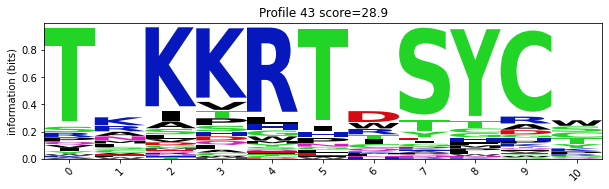

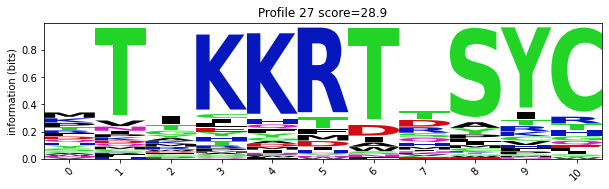

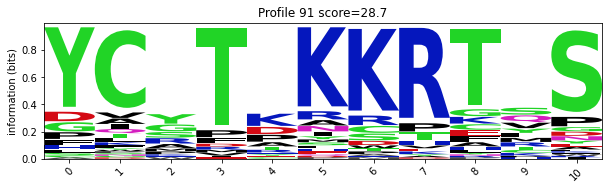

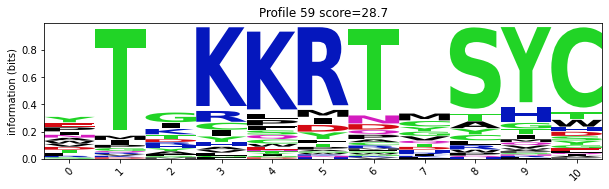

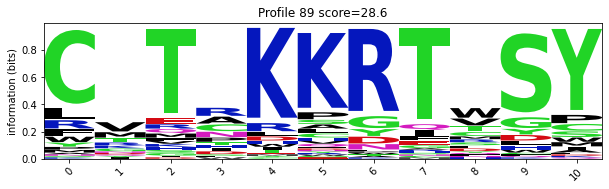

In [29]:
P = specProModel.getP()
pScores = specProModel.max_profile_scores(ds_score)
plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=5)
# should be similar to one of ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
# Repeats: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']

---

## Profile Score Distribution

In [30]:
R = specProModel.getR()
minscore = np.array(R).min() * specProModel.k # profile matches not at all
maxscore = np.array(R).max() * specProModel.k # all bases match perfectly
print(minscore, ",", maxscore)
minscore = np.math.floor(minscore)
maxscore = np.math.floor(maxscore)

-144.68446731567383 , 38.3241229057312


     P:     (k, alphSize, U) 
     X:     (batchsize, N, 6, T, alphSize) 
     Z:     (batchsize, N, 6, T-k+1, U)

In [31]:
scoreBins = dict([(b,0) for b in range(minscore, maxscore)])
assert k == R.shape[0]

#for pidx in range(R.shape[2]):
#    profile = R[:,:,pidx]
#    for seqidx in range(X.shape[1]):
#        for frame in range(X.shape[2]):
#            for i in range(0, X.shape[3]-k+1):
#                kmer = X[0,seqidx,frame,range(i,i+k),:]
#                assert kmer.shape == profile.shape, str(kmer.shape)+" != "+str(profile.shape)
#                score = np.math.floor(sum(np.array(kmer*profile).flatten()))
#                assert score in scoreBins, str(score)
#                scoreBins[score] += 1

for batch in ds_score:
    for X in batch:
        S, _, Z = specProModel(X)
        for s in np.array(Z[:,:,:,:,:]).flatten():
            score = np.math.floor(s)
            assert score in scoreBins, str(score)+" ("+str(s)+")"
            scoreBins[score] += 1

#S, R, Z = specProModel(X)
#for s in np.array(Z[:,:,:,:,:]).flatten():
#    score = np.math.floor(s)
#    assert score in scoreBins, str(score)+" ("+str(s)+")"
#    scoreBins[score] += 1

(array([19., 18., 18., 18., 18., 19., 18., 18., 18., 19.]),
 array([-145. , -126.8, -108.6,  -90.4,  -72.2,  -54. ,  -35.8,  -17.6,
           0.6,   18.8,   37. ]),
 <BarContainer object of 10 artists>)

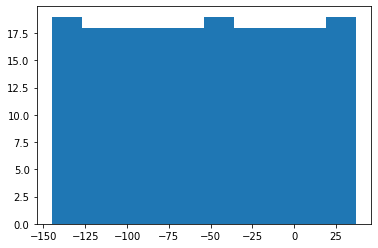

In [32]:
import matplotlib.pyplot as plt

plt.hist(scoreBins)

---

## Find Best Profiles

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [33]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [34]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train_ds(ds, steps_per_epoch, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #L1, L2, L4 = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [35]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [36]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [ ]:
if True:
    for i in range(20):
        P = runTraining()
        profiles = aaFromProfiles(P)
        print("Run", i)
        if insertPatterns is not None:
            print("Desired profiles:")
            patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
            for i in range(len(patternScores)):
                    print(patternProfiles[i])
                    print(format_alignment(*(patternAlignments[i])))

        if repeatPatterns is not None:
            print("Undesired profiles:")
            repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
            for i in range(len(repeatScores)):
                    print(repeatProfiles[i])
                    print(format_alignment(*(repeatAlignments[i])))

        print("")
        print("-----")
        print("")
        
else:
    P = specProModel.getP()
    profiles = aaFromProfiles(P)

    if insertPatterns is not None:
        print("Desired profiles:")
        patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
        for i in range(len(patternScores)):
                print(patternProfiles[i])
                print(format_alignment(*(patternAlignments[i])))

    if repeatPatterns is not None:
        print("Undesired profiles:")
        repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
        for i in range(len(repeatScores)):
            print(repeatProfiles[i])
            print(format_alignment(*(repeatAlignments[i])))

Run 0
Desired profiles:
Undesired profiles:
PERREPEATAE
4 REPEATAE
  ||||||||
1 REPEATAE
  Score=8

TAEPERREPEA
1 TAEPER
  ||||||
6 TAEPER
  Score=6


-----

Run 1
Desired profiles:
Undesired profiles:
EPERREPEATA
5 REPEATA
  |||||||
1 REPEATA
  Score=7


-----

Run 2
Desired profiles:
Undesired profiles:
RREPEATAEPE
2 REPEATAEPE
  ||||||||||
1 REPEATAEPE
  Score=10

PEATAEPERRE
1 PEATAEPER
  |||||||||
3 PEATAEPER
  Score=9

ERREPEATAEP
3 REPEATAEP
  |||||||||
1 REPEATAEP
  Score=9

PERREPEATAE
4 REPEATAE
  ||||||||
1 REPEATAE
  Score=8

PERREPEATAE
4 REPEATAE
  ||||||||
1 REPEATAE
  Score=8


-----

Run 3
Desired profiles:
RIQMIANSPT*
1 RIQMIAN
  |||..||
3 RIQSTAN
  Score=5

Undesired profiles:
PERREPEATAE
4 REPEATAE
  ||||||||
1 REPEATAE
  Score=8


-----

Run 4
Desired profiles:
Undesired profiles:
ERREPEATAEP
3 REPEATAEP
  |||||||||
1 REPEATAEP
  Score=9


-----

Run 5
Desired profiles:
MARIQSTAKKE
MARIQSTAKKE
||||||||.||
MARIQSTANKE
  Score=10

NDRIQTTEYKW
3 RIQTTEYK
  |||.|..|
3 

In [84]:
R = specProModel.getR()
profiles = aaFromProfiles(R)
if insertPatterns is not None:
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))

if repeatPatterns is not None:
    print("Undesired profiles:")
    repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
    for i in range(len(repeatScores)):
        print(repeatProfiles[i])
        print(format_alignment(*(repeatAlignments[i])))

Desired profiles:
Undesired profiles:


ValueError: attempt to get argmax of an empty sequence